# Baseline for Kaggle competition (HW2)
- This is a baseline for the Kaggle competition.
- Note that it is using **implicit feedback**.
- You can use this as a starting point for your own model.
- Please note that the task is **top-N recommendation**, so you need to predict the top 20 movies for each user, not the rating for a single movie.
- Unlike the question #1, it is implemented with PyTorch, not numpy.

### 1. Import packages

In [1]:
import os
import math
import torch
import pickle
import numpy as np
import pandas as pd

from tqdm import tqdm
from time import time
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
!pwd

/home/jiwon/recommender_system/HW2/Code/kaggle


In [3]:
data_dir = 'data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Load data

In [4]:
all_data = pd.read_csv(os.path.join(data_dir, "train_data.csv"), names=None)
train, valid = train_test_split(all_data, test_size=0.15, stratify=all_data['user_id'], random_state=1234)

test_data = pd.read_csv(os.path.join(data_dir, "test_data.csv"), names=None)

user_list = list(all_data['user_id'].unique())
item_list = list(all_data['item_id'].unique())

num_users = len(user_list)
num_items = len(item_list)
num_ratings = len(all_data)
print(num_users)
print(num_items)
user_id_dict = {old_uid: new_uid for new_uid, old_uid in enumerate(user_list)}
all_data.user_id = [user_id_dict[x] for x in all_data.user_id.tolist()]

item_id_dict = {old_uid: new_uid for new_uid, old_uid in enumerate(item_list)}
all_data.item_id = [item_id_dict[x] for x in all_data.item_id.tolist()]
print(f"# of users: {num_users},  # of items: {num_items},  # of ratings: {num_ratings}")

all_data = all_data[['user_id', 'item_id', 'rating']]
all_data = all_data.sort_values(by="user_id", ascending=True)

18397
7131
# of users: 18397,  # of items: 7131,  # of ratings: 846868


In [5]:
train = train.to_numpy()
valid = valid.to_numpy()
print('train',train.shape)
print('valid',valid.shape)
matrix = sparse.lil_matrix((num_users, num_items))
for (u, i, r) in train:
    matrix[u, i] = r
train = sparse.csr_matrix(matrix)
# print('train_sparse',train)
matrix = sparse.lil_matrix((num_users, num_items))
for (u, i, r) in valid:
    matrix[u, i] = r
valid = sparse.csr_matrix(matrix)
# print('valid_sparse',valid)
train = train.toarray()
valid = valid.toarray()
print('final_train',train)
print('final_valid',valid.shape)

train (719837, 3)
valid (127031, 3)
final_train [[0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
final_valid (18397, 7131)


### 3. Define an evaluation code

In [6]:
def compute_metrics(pred_u, target_u, top_k):
    pred_k = pred_u[:top_k]
    num_target_items = len(target_u)

    hits_k = [(i + 1, item) for i, item in enumerate(pred_k) if item in target_u]
    num_hits = len(hits_k)

    idcg_k = 0.0
    for i in range(1, min(num_target_items, top_k) + 1):
        idcg_k += 1 / math.log(i + 1, 2)

    dcg_k = 0.0
    for idx, item in hits_k:
        dcg_k += 1 / math.log(idx + 1, 2)

    prec_k = num_hits / top_k
    recall_k = num_hits / min(num_target_items, top_k)
    ndcg_k = dcg_k / idcg_k


    return prec_k, recall_k, ndcg_k

### 4. Predict and evaluate 
- We provide the most popular methods for a baseline.

In [7]:
# Get the most popular items
train_valid = train + valid

rating_cnt = train.sum(axis=0)
print(len(rating_cnt))
popular_items = np.argsort(rating_cnt)[::-1]
popular_items[:10]

7131


array([ 461,  416, 1788,    9,  262,  406, 1072,  779,  882,  409])

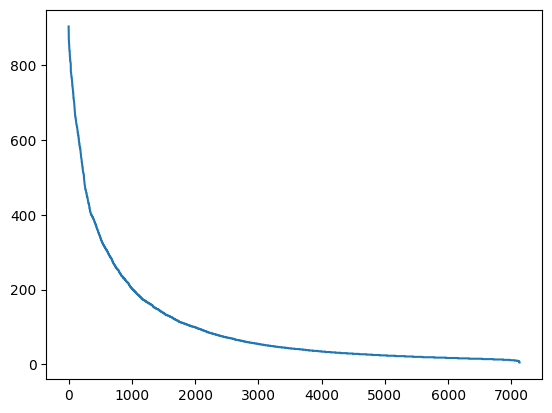

In [8]:
# Plot the distribution of the number of ratings per items
import matplotlib.pyplot as plt
plt.plot(np.sort(rating_cnt)[::-1])
plt.show()

In [9]:
train_data = train
test_data = valid
topks = [10, 30, 50, 100]

for top_k in topks:
    prec_list = []
    recall_list = []
    ndcg_list = []

    submission = pd.DataFrame(columns=['user_id', 'item_id'])

    for user_id in range(len(train_data)):
        train_by_user = train_data[user_id]
        missing_item_ids = np.where(train_by_user == 0)[0]  # missing item_id

        pred_u_idx = np.argsort(rating_cnt[missing_item_ids])[::-1]
        pred_u = missing_item_ids[pred_u_idx]

        test_by_user = test_data[user_id]
        target_u = np.where(test_by_user >= 0.5)[0]

        if len(target_u) == 0:
            continue

        prec_k, recall_k, ndcg_k = compute_metrics(pred_u, target_u, top_k)
            
        prec_list.append(prec_k)
        recall_list.append(recall_k)
        ndcg_list.append(ndcg_k)
        

    print(f"topk: {top_k}")
    print(f"prec: {np.mean(prec_list):.4f}, recall: {np.mean(recall_list):.4f}, ndcg: {np.mean(ndcg_list):.4f}")

topk: 10
prec: 0.0097, recall: 0.0190, ndcg: 0.0142
topk: 30
prec: 0.0093, recall: 0.0487, ndcg: 0.0246
topk: 50
prec: 0.0088, recall: 0.0761, ndcg: 0.0328
topk: 100
prec: 0.0082, recall: 0.1414, ndcg: 0.0495


### 6. Submit to Kaggle

In [12]:
print(train_valid)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
"""
Make submission
"""
train_valid = train + valid
print(train_valid.shape)
submission = pd.DataFrame(columns=['user_id', 'item_id'])

for user_id in tqdm(range(len(train_valid))):
    train_by_user = train_valid[user_id]
    print(train_by_user)
    missing_item_ids = np.where(train_by_user == 0)[0] 
    print('missing_item_ids',missing_item_ids)
    print(len(missing_item_ids))
    pred_u_idx = np.argsort(rating_cnt[missing_item_ids])[::-1]
    print(pred_u_idx)
    pred_u = missing_item_ids[pred_u_idx]
    
    pred_u = missing_item_ids[pred_u_idx]
    submission = submission.append(pd.DataFrame({'user_id': [user_id] * top_k, 'item_id': pred_u[:top_k]}))

submission.to_csv(os.path.join(data_dir, 'submission_1.csv'), index=False)

(18397, 7131)


  0%|          | 86/18397 [00:00<00:21, 855.65it/s]

[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    9 ... 7128 7129 7130]
7119
[ 449  404 1776 ... 5614 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 452  407 1779 ... 5546 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 436  391 1763 ... 6020 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6872
[ 202  157 1529 ... 5786 6816 3529]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7090
[ 420 1747    7 ... 5514 7034 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 444  412 1771 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7035
[ 428  403 1692 ... 6927 6979 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 456  412 1690 ... 5457 6977 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

  1%|▏         | 256/18397 [00:00<00:22, 813.77it/s]

[1630  245  941 ... 6469 6604 3484]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 455  410 1771 ... 6001 7031 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1783 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 450  406 1766 ... 5577 7026 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1773 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 450  407 1764 ... 6989 7041 3756]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6831
[ 417  380 1626 ... 5326 6775 3522]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458 1777    9 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1781 ... 6029 7059 3776]
[0. 0. 0. ... 0. 0. 

  2%|▏         | 417/18397 [00:00<00:23, 763.18it/s]

[ 453  409 1771 ... 5597 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  415 1779 ... 6999 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1777 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 448  407 1747 ... 5965 6995 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6989
[ 430  390 1716 ... 6798 6933 3663]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 416 1780    9 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  415 1779 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  410 1765 ... 6906 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1766 ... 6911 7046 3761]
[0. 0. 0. ... 0. 0. 

  3%|▎         | 568/18397 [00:00<00:24, 716.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1783 ... 6030 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  415 1783 ... 6912 7047 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  412 1779 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 416 1784    9 ... 5611 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1780    9 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 456  412 1772 ... 5505 7020 3745]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7013
[ 443  403    8 ... 5443 6957 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1783 ... 5607 7053 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

  4%|▍         | 710/18397 [00:00<00:26, 671.80it/s]

[ 454  410    9 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7024
[ 396 1719    9 ... 5519 6968 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1780 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1780 ... 7010 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  410 1770 ... 6012 7042 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1776 ... 5607 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6990
[1714  249  383 ... 6882 6934 3670]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  413 1776 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413    9 ... 6018 7048 3766]
[1. 0. 0. ... 0. 0. 

  4%|▍         | 778/18397 [00:01<00:27, 647.89it/s]

[ 453  411    9 ... 6907 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 449 1753  255 ... 5491 7011 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1781 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7030
[ 437  395 1735 ... 5529 6974 3701]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1772 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1770 ... 5521 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  409 1773 ... 6912 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  415 1771 ... 6021 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 

  5%|▍         | 905/18397 [00:01<00:29, 591.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1780 ... 7005 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 456  411 1770 ... 6897 7032 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  414 1774 ... 5527 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 451  406 1760 ... 5982 7010 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415    9 ... 6026 7056 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6790
[ 400  236  354 ... 5293 6734 3487]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7077
[ 446  405 1749 ... 5991 7021 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1786 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

  6%|▌         | 1022/18397 [00:01<00:32, 537.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  409 1775 ... 6915 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 445  403 1765 ... 5514 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 450  406 1757 ... 6001 7031 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1784 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1775 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 458  413    9 ... 5591 7038 3755]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7118
[ 460  415 1785 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  409 1764 ... 5589 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

  6%|▌         | 1128/18397 [00:01<00:35, 483.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6652
[ 410  369    9 ... 6544 6596 3444]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1777 ... 5536 7052 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 443  400 1754 ... 5974 7002 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 446  403 1736 ... 6928 6980 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  414 1770 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 447  403 1753 ... 5544 6986 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  414 1783 ... 7014 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1779 ... 5537 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

  6%|▋         | 1177/18397 [00:01<00:37, 459.28it/s]

[ 455  412 1771 ... 6911 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 444  405 1760 ... 5577 7025 3743]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7073
[ 449 1752  253 ... 6965 7017 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  413 1767 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 5543 7061 3776]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7093
[ 413 1764    8 ... 6902 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456 1780  260 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1782 ... 5607 7055 3771]
[0. 0. 0. ... 0. 0. 

  7%|▋         | 1268/18397 [00:02<00:42, 406.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 456  411 1759 ... 6978 7030 3744]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7030
[ 439 1731  252 ... 5527 6974 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 450  405    8 ... 5991 7020 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 452  408 1775 ... 5533 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1777 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  411 1775 ... 6020 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1783 ... 6928 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

  7%|▋         | 1348/18397 [00:02<00:46, 366.45it/s]

[ 459  414 1778 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 454  413 1774 ... 5591 7039 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 460  415 1784 ... 7016 7068 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 459  414 1778 ... 6009 7037 3765]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7068
[ 410 1754    8 ... 5494 7012 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 458  414 1767 ... 5584 7031 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  414 1780 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1781 ... 5540 7058 3774]
[0. 0. 0. ... 0. 0. 

  8%|▊         | 1385/18397 [00:02<00:48, 347.53it/s]

 [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1775 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1775 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6949
[ 435  397 1718 ... 5871 6893 3656]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1779 ... 6031 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  414 1776 ... 5529 7047 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1779 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  415 1783 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454 1768    8 ... 5527 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7024
[ 433  391 172

  8%|▊         | 1454/18397 [00:02<00:53, 319.57it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7121
[ 458  413 1782 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1780 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  412 1768 ... 6004 7033 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1782 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  416 1777 ... 5540 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 450 1762  256 ... 5593 7042 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

  8%|▊         | 1517/18397 [00:03<00:58, 288.95it/s]

[ 457  412 1776 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1777 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  411 1771 ... 5518 7036 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 447  403 1754 ... 6949 7001 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1778 ... 5536 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1780 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454 1771  259 ... 5535 7053 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7020
[ 448  407 1731 ... 5446 6964 3688]
[0. 0. 0. ... 0. 0. 

  8%|▊         | 1546/18397 [00:03<01:01, 274.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 416 1780    9 ... 6920 7055 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6933
[ 421  245  375 ... 6742 6877 3612]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1780 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1780 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1782 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 451  408 1770 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1780 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1781 ... 5607 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

  9%|▊         | 1601/18397 [00:03<01:04, 261.76it/s]

[ 454    9  261 ... 6976 7028 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6946
[ 433  395 1695 ... 5389 6890 3631]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409 1775 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 6925 7060 3776]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6597
[   6  215  330 ... 5128 6541 3369]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6588
[ 391  356 1537 ... 6480 6532 3348]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1777 ... 5539 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6485
[ 389  349 1503 ... 4975 6429 3305]
[0. 0. 0. ... 0. 0. 

  9%|▉         | 1654/18397 [00:03<01:07, 249.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6850
[ 437  396 1668 ... 6742 6794 3578]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 453  410    8 ... 6906 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453 1764  259 ... 5521 7041 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1769 ... 6989 7041 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1783 ... 5541 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7095
[ 451  409 1764 ... 6987 7039 3754]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7068
[ 445  401 1754 ... 5982 7012 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452  409 1772 ... 6997 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

  9%|▉         | 1703/18397 [00:03<01:12, 229.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1777 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1777 ... 6024 7054 3768]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6983
[ 441  397 1733 ... 5429 6927 3684]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 7009 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 414 1766    9 ... 6902 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  415 1777 ... 6999 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1780 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454 1769  259 ... 5594 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 10%|▉         | 1749/18397 [00:04<01:14, 222.10it/s]

[ 457  413 1779 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1777 ... 5613 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 415 1773    9 ... 6998 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 448  406 1749 ... 5976 7004 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 414 1779    9 ... 6921 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 457  412 1780 ... 6005 7032 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414    9 ... 6025 7054 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 456 1776    8 ... 7001 7053 3768]
[0. 0. 0. ... 0. 0. 

 10%|▉         | 1772/18397 [00:04<01:17, 215.35it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
6977
[ 438  394 1718 ... 5903 6921 3675]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 453  411 1766 ... 5589 7035 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  412 1776 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 414 1777    9 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1781 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 415 1778    9 ... 5531 7050 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7001
[ 432 1712    7 ... 5920 6945 3679]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454 1763    9 ... 6017 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
698

 10%|▉         | 1816/18397 [00:04<01:20, 205.62it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6950
[ 426  385 1685 ... 5382 6894 3626]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 454  412 1765 ... 6967 7019 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 413 1764    8 ... 5502 7022 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 7010 7062 3775]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7020
[ 448  404 1746 ... 5946 6964 3712]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
6830
[ 373    6  239 ... 6722 6774 3503]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 452  407 1771 ... 6918 7053 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7090
[ 449  406 1767 ... 6899 7034 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 10%|█         | 1857/18397 [00:04<01:25, 192.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1776 ... 5538 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1779 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  414 1780 ... 6016 7043 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  411 1773 ... 5597 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1781 ... 5545 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1783 ... 6921 7056 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  410 1774 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 10%|█         | 1897/18397 [00:04<01:25, 192.22it/s]

[ 458  414 1774 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  409 1775 ... 6021 7049 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7095
[ 458  413 1771 ... 6009 7039 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1783 ... 6927 7062 3778]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6978
[ 438 1708  252 ... 5409 6922 3661]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1781 ... 7001 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  412    9 ... 5524 7044 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6926
[ 430  395 1690 ... 6818 6870 3618]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7005
[ 446  403 1741 ... 6897 6949 3692]
[0. 0. 0. ... 0. 0. 

 11%|█         | 1936/18397 [00:05<01:29, 184.55it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 457  412 1769 ... 6979 7031 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  408 1768 ... 5523 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 407 1741  258 ... 5971 7001 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  412    9 ... 6013 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1777 ... 6997 7049 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 401 1731    9 ... 5522 6969 3689]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  411 1772 ... 6995 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
708

 11%|█         | 1974/18397 [00:05<01:31, 180.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 458  413 1778 ... 6990 7042 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1771 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1779 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 445  401 1746 ... 5466 6981 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  411 1773 ... 5526 7044 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 454  409 1768 ... 5589 7038 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 448  404 1766 ... 5517 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 11%|█         | 2011/18397 [00:05<01:33, 174.65it/s]

missing_item_ids [   1    2    3 ... 7128 7129 7130]
7021
[ 253 1006  833 ... 6913 6965 3682]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1779 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1780 ... 6035 7065 3779]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7057
[ 447 1749    7 ... 6866 7001 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1775 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1777 ... 5606 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 444  400 1749 ... 5973 7002 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 11%|█         | 2048/18397 [00:05<01:35, 172.03it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1777 ... 6921 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1776 ... 6918 7053 3767]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7086
[ 452  408 1772 ... 5584 7030 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1776 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1776 ... 6020 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1777 ... 5532 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1783 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 453  411 1776 ... 6028 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
708

 11%|█         | 2066/18397 [00:05<01:37, 166.73it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1776 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1775 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 415 1775    9 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1781 ... 5544 7064 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7066
[ 449  404 1753 ... 6958 7010 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1779 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 11%|█▏        | 2102/18397 [00:06<01:37, 166.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1769 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 441  397 1746 ... 5991 7021 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1775 ... 6022 7051 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7046
[ 448  408 1744 ... 6938 6990 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460 1783    9 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 454  410 1769 ... 6901 7035 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1776 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1779 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 12%|█▏        | 2137/18397 [00:06<01:38, 165.58it/s]

missing_item_ids [   1    2    3 ... 7128 7129 7130]
7108
[ 457  413 1777 ... 7000 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  414 1773 ... 6995 7047 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 449  406 1751 ... 5497 7014 3734]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7098
[ 458  413 1773 ... 6991 7042 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  409 1772 ... 5599 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1783 ... 6925 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1776 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1778 ... 7004 7056 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
694

 12%|█▏        | 2171/18397 [00:06<01:43, 157.14it/s]

[ 454  411 1764 ... 5589 7033 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 452  409 1772 ... 6994 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 451  406 1761 ... 6883 7018 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  409 1774 ... 6994 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1784 ... 5612 7061 3776]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
5650
[1217    6  173 ... 5472 5594 2734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1780 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7125
[ 460  415 1784 ... 7017 7069 3782]
[0. 0. 1. ... 0. 0. 

 12%|█▏        | 2203/18397 [00:06<01:43, 156.29it/s]

missing_item_ids [   1    2    3 ... 7128 7129 7130]
7115
[ 456 1778    8 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  414 1776 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  411 1771 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 449  405 1760 ... 6886 7021 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 451    8  258 ... 6878 7013 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411    9 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411    9 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
700

 12%|█▏        | 2235/18397 [00:06<01:45, 153.64it/s]

missing_item_ids [   1    2    3 ... 7128 7129 7130]
7112
[ 456  412 1772 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1779 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1777 ... 5608 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  415 1775 ... 6997 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6996
[ 442  398 1717 ... 6888 6940 3664]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  414 1767 ... 5522 7042 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 448  405 1756 ... 5483 6997 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  409 1775 ... 6917 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
712

 12%|█▏        | 2267/18397 [00:07<01:46, 151.24it/s]

[ 456  412 1774 ... 6004 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6946
[ 433  391 1716 ... 6838 6890 3650]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1769 ... 6989 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 5540 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6950
[ 434  392 1691 ... 6843 6894 3638]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 406 1744  397 ... 6885 7020 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 450  406 1752 ... 6844 6977 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 451  409 1771 ... 6025 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1777 ... 7008 7060 3774]
[1. 0. 0. ... 0. 0. 

 12%|█▏        | 2299/18397 [00:07<01:48, 148.90it/s]

[ 455  411 1770 ... 5513 7032 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1780 ... 5615 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1781 ... 6023 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 455  411 1759 ... 5564 7012 3734]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7095
[ 458  413 1761 ... 5519 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  410 1772 ... 6996 7048 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 406 1755    9 ... 5489 7008 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[ 402 1729    9 ... 6924 6976 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1779 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 

 13%|█▎        | 2329/18397 [00:07<01:51, 144.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 460  415 1783 ... 6933 7068 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1776 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1781 ... 5540 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  412 1775 ... 6904 7039 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 401 1723    9 ... 5448 6961 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  411 1771 ... 6012 7042 3761]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   3    4    5 ... 7128 7129 7130]
6852
[ 423  382 1671 ... 6747 6796 3563]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[1779    8  261 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 13%|█▎        | 2360/18397 [00:07<01:51, 143.85it/s]

[ 453  409 1766 ... 6890 7025 3747]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7027
[ 441  397 1730 ... 5942 6971 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1777 ... 7002 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1778 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 456  412 1781 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1782    9 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  412 1776 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1781 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 

 13%|█▎        | 2375/18397 [00:07<01:54, 139.53it/s]

[ 457  413 1781 ... 6035 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 453  409 1757 ... 6878 7013 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1776 ... 6026 7056 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 456 1771    8 ... 7001 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1782 ... 5541 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  415 1782 ... 5546 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 440  396 1741 ... 5525 6965 3698]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 444  400 1751 ... 5539 6975 3726]
[0. 0. 0. ... 0. 0. 

 13%|█▎        | 2406/18397 [00:08<01:53, 141.00it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1778 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409    8 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  414 1776 ... 6015 7043 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7020
[ 404 1734    9 ... 6829 6964 3696]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 456  411 1779 ... 6023 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1774 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7008
[ 429 1696    8 ... 5433 6952 3668]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 6928 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 13%|█▎        | 2436/18397 [00:08<01:53, 140.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 455  412 1769 ... 5511 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459  414 1771 ... 6014 7044 3760]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6999
[ 448  404 1726 ... 6892 6943 3686]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  414 1778 ... 5535 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1775 ... 6993 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1776 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6934
[ 427  385 1692 ... 5439 6878 3623]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 13%|█▎        | 2465/18397 [00:08<01:58, 134.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412    9 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 448  404 1764 ... 6867 7001 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1776 ... 6028 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 446  402 1740 ... 5536 6985 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1784 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1779 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 452  407 1767 ... 5596 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 14%|█▎        | 2494/18397 [00:08<01:58, 133.86it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  409 1775 ... 7000 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 7006 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1783 ... 5612 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 453  408 1768 ... 5589 7036 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 451  408 1745 ... 5519 6957 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1777 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1781 ... 5540 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1783 ... 6019 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 14%|█▎        | 2522/18397 [00:08<01:58, 133.77it/s]

[ 446  402 1746 ... 5970 7000 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1783 ... 5539 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6981
[ 434  395    8 ... 5485 6925 3667]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1783 ... 7007 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1782 ... 5613 7062 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7118
[ 458  413 1781 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 454  412 1761 ... 6895 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  414 1774 ... 6908 7043 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1782 ... 7008 7060 3777]
[0. 0. 0. ... 0. 0. 

 14%|█▍        | 2551/18397 [00:09<01:56, 135.45it/s]

[ 446  402    9 ... 5958 6986 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 459  414 1774 ... 5516 7033 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6781
[ 426  383 1627 ... 5716 6725 3503]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 449  404 1766 ... 5586 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460 1787    9 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1777 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6941
[1705  252  386 ... 5372 6885 3627]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1775 ... 5537 7057 3771]
[1. 0. 0. ... 0. 0. 

 14%|█▍        | 2579/18397 [00:09<02:01, 130.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1779 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 449  406 1764 ... 6901 7035 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  416 1780 ... 7004 7056 3773]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6861
[ 448  407 1727 ... 5812 6805 3650]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  411 1765 ... 6907 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1780 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1780 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 14%|█▍        | 2593/18397 [00:09<02:00, 130.79it/s]

[ 460  415 1782 ... 6921 7056 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1783 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6971
[ 434  390 1717 ... 5894 6916 3658]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1776 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  409 1776 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1784 ... 6027 7055 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 447 1740    9 ... 5533 6977 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1774 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453  408 1778 ... 5536 7053 3773]
[0. 0. 0. ... 0. 0. 

 14%|█▍        | 2622/18397 [00:09<02:00, 131.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1781 ... 5542 7060 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1778 ... 6027 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  416 1779 ... 5600 7047 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  411 1775 ... 6998 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1777 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 416 1780    9 ... 5537 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 14%|█▍        | 2649/18397 [00:09<02:06, 124.45it/s]

[ 459  415 1777 ... 5609 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1778 ... 5532 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 410 1769    9 ... 5525 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1782 ... 5615 7064 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7114
[ 457  412 1776 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1778 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1780 ... 5607 7056 3772]
[0. 0. 0. ... 0. 0. 

 15%|█▍        | 2675/18397 [00:10<02:05, 125.30it/s]

[ 459  414 1779 ... 6021 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1781 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 6023 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 450  405 1765 ... 6912 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  415 1779 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 460  415 1771 ... 6906 7040 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 451  407 1763 ... 5509 7028 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1778 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 461  416 1783 ... 5548 7068 3781]
[0. 0. 0. ... 0. 0. 

 15%|█▍        | 2701/18397 [00:10<02:07, 122.93it/s]

[ 457  412 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6990
[ 440  399 1711 ... 5419 6934 3662]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1775 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1784 ... 5536 7054 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  413 1769 ... 5588 7036 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  413 1775 ... 6985 7037 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  416 1784 ... 5613 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  410 1780 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 

 15%|█▍        | 2727/18397 [00:10<02:10, 120.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  406 1762 ... 6886 7021 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 440  400 1739 ... 5932 6957 3699]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1779 ... 5538 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1785 ... 6924 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1782 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 414 1771    9 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 451  407 1769 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1770 ... 6989 7041 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 15%|█▍        | 2753/18397 [00:10<02:09, 120.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1780 ... 5538 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1781 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 450 1743  257 ... 5554 7000 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 458  414 1777 ... 6880 7010 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  411 1777 ... 5602 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 449  405 1754 ... 5574 7019 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  412 1778 ... 6908 7043 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 447  404    9 ... 6872 7007 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 15%|█▌        | 2779/18397 [00:11<02:11, 118.73it/s]

[ 453  409 1768 ... 5587 7034 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 459  414 1777 ... 6899 7034 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414    9 ... 6926 7061 3774]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7116
[ 457  412 1784 ... 5541 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  411 1773 ... 6906 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1775 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1781 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 458  413 1761 ... 6959 7011 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 449  405 1764 ... 5521 7037 3757]
[0. 0. 0. ... 0. 0. 

 15%|█▌        | 2803/18397 [00:11<02:16, 114.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 450  407 1752 ... 6957 7009 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6898
[ 435  393 1695 ... 6792 6844 3623]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7112
[ 458  414 1779 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 413 1777    9 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1779 ... 7003 7055 3770]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7112
[ 457  413 1774 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 415 1780    9 ... 5530 7043 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  412    9 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 15%|█▌        | 2828/18397 [00:11<02:12, 117.46it/s]

[ 458  413 1770 ... 5597 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 454  409 1768 ... 6011 7039 3757]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6998
[ 438  396 1709 ... 5495 6942 3666]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 433  397 1739 ... 5455 6971 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1780 ... 5613 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1783 ... 6925 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1774 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  416 1779 ... 6027 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 

 15%|█▌        | 2840/18397 [00:11<02:14, 115.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1776 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1779 ... 5610 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 452  407 1771 ... 5522 7039 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  412 1769 ... 6014 7044 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  413 1780 ... 6036 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 450  406 1762 ... 5512 7031 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 443  400 1741 ... 5548 6996 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1779 ... 6027 7056 3771]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4

 16%|█▌        | 2865/18397 [00:11<02:15, 114.56it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7050
[ 446  403 1747 ... 5547 6994 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  412 1776 ... 6022 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6988
[ 432  388 1733 ... 6881 6932 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 416 1776    9 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6869
[ 430  390 1668 ... 6761 6813 3569]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1782 ... 5533 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1779 ... 5610 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 454  409 1774 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 16%|█▌        | 2889/18397 [00:11<02:15, 114.46it/s]

[ 460  416 1783 ... 6030 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 5537 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 447  403 1763 ... 5588 7036 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1778 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 453  408 1762 ... 6971 7023 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1778 ... 6027 7057 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6938
[ 433  393 1677 ... 5442 6883 3616]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1781 ... 5541 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 436  394 1717 ... 5910 6937 3661]
[1. 0. 0. ... 0. 0. 

 16%|█▌        | 2913/18397 [00:12<02:20, 110.51it/s]

[ 452  407 1759 ... 5513 7033 3746]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7090
[ 459  414    8 ... 6899 7034 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459 1779    9 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  411 1776 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 455  411 1769 ... 6901 7036 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1777 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1782 ... 5543 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6436
[ 363  329    9 ... 5436 6383 3344]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  408    9 ... 6898 7033 3748]
[0. 0. 0. ... 0. 0. 

 16%|█▌        | 2937/18397 [00:12<02:19, 110.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 5545 7064 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 451  407 1770 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  414 1770 ... 6992 7044 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1782 ... 6030 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 443  403 1740 ... 5468 6981 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 6032 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 458  414 1775 ... 5591 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 16%|█▌        | 2961/18397 [00:12<02:21, 109.35it/s]

[ 457  413 1777 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1777 ... 5609 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  410 1778 ... 5601 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  415 1782 ... 6037 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 415 1764    9 ... 5587 7036 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458 1780    9 ... 5617 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 416 1781    9 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7029
[ 403 1733    9 ... 5455 6973 3699]
[0. 0. 0. ... 0. 0. 

 16%|█▌        | 2984/18397 [00:12<02:19, 110.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1779 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  410 1778 ... 6024 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 456  412 1762 ... 6005 7035 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1778 ... 5543 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  412 1765 ... 5521 7038 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1781 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1781 ... 7002 7054 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5541 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 16%|█▋        | 3008/18397 [00:13<02:21, 109.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 450  406 1758 ... 6962 7014 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  412    9 ... 5543 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  412 1773 ... 6918 7053 3767]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   3    4    5 ... 7128 7129 7130]
6512
[ 348 1548  226 ... 6405 6456 3344]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1770 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  410 1766 ... 5593 7040 3759]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6974
[ 449  409 1716 ... 6866 6918 3650]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 451  407 1762 ... 5515 7034 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 16%|█▋        | 3030/18397 [00:13<02:24, 106.68it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1776 ... 6022 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  415 1780 ... 7006 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1779 ... 5612 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1782 ... 5542 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1777 ... 5599 7045 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  410 1770 ... 5598 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1767 ... 6912 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415    9 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 17%|█▋        | 3053/18397 [00:13<02:24, 106.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  416 1782 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1777 ... 7000 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  414 1773 ... 6909 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1779 ... 5538 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6921
[ 422  382 1678 ... 5353 6865 3600]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413    9 ... 5608 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1779 ... 6024 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1779 ... 5610 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 17%|█▋        | 3075/18397 [00:13<02:24, 105.86it/s]

[ 457  414 1770 ... 5597 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 442  400 1748 ... 5555 7002 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1779 ... 6025 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1780 ... 7004 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1780 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1783 ... 6918 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 451  407 1753 ... 5960 6988 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414    9 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 

 17%|█▋        | 3097/18397 [00:13<02:28, 102.97it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7119
[ 458  413 1781 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1781 ... 6925 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 454  409 1764 ... 5570 7016 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1779 ... 5609 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  413 1774 ... 5606 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1783 ... 5614 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1774 ... 6999 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 446  402 1764 ... 5578 7023 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 17%|█▋        | 3109/18397 [00:14<02:26, 104.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1777 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 5610 7059 3774]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7063
[ 456  411 1752 ... 6872 7007 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 452  408 1763 ... 6883 7018 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  412 1775 ... 6020 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  411 1771 ... 5526 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 432  390 1746 ... 5541 6984 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 17%|█▋        | 3131/18397 [00:14<02:28, 102.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  414 1780 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1778 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  412 1773 ... 6999 7051 3767]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6507
[ 407  364 1539 ... 5078 6454 3360]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 452  409 1773 ... 6904 7039 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6859
[ 410  372 1621 ... 6751 6803 3539]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6940
[ 441  398 1714 ... 5381 6885 3637]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412    9 ... 7007 7059 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 17%|█▋        | 3153/18397 [00:14<02:26, 104.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1775 ... 7005 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1780 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1781 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413    9 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1778 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 442  401 1754 ... 5561 7004 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1781 ... 6920 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 17%|█▋        | 3175/18397 [00:14<02:27, 103.16it/s]

[ 458  416 1781 ... 5541 7061 3778]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
7017
[ 444  404 1720 ... 5516 6961 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1783 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1778 ... 5608 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 6927 7062 3775]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6906
[ 426 1673    6 ... 6798 6850 3584]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1779 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1780 ... 5528 7045 3768]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
7017
[ 448  403 1732 ... 5517 6961 3695]
[0. 0. 0. ... 0. 0. 

 17%|█▋        | 3197/18397 [00:14<02:26, 103.56it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 454  410 1776 ... 7003 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6949
[ 440  396 1733 ... 5896 6894 3688]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1779 ... 5605 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  411 1779 ... 7010 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459 1781    9 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1782 ... 5614 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  409 1773 ... 6994 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 17%|█▋        | 3219/18397 [00:15<02:30, 101.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  416 1781 ... 6026 7055 3773]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7082
[ 452  409 1762 ... 5507 7026 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 446  404 1727 ... 6803 6938 3675]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7095
[ 454 1764  260 ... 6009 7039 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1778 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459 1777    9 ... 6024 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1772 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1783 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 18%|█▊        | 3240/18397 [00:15<02:33, 98.90it/s] 

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  414 1778 ... 6906 7041 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 454  409 1757 ... 5969 6997 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  415 1781 ... 6931 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1780 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6964
[ 427  386 1703 ... 6773 6908 3639]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6653
[ 388  348    9 ... 5596 6597 3409]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 454  411 1764 ... 5587 7032 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1780 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 18%|█▊        | 3260/18397 [00:15<02:33, 98.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  408 1776 ... 6022 7052 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7106
[ 455  412 1771 ... 5530 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 412 1774    9 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  413 1767 ... 6003 7033 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 446  402 1750 ... 5486 6997 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1777 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 452  408 1768 ... 6008 7035 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 6034 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 18%|█▊        | 3280/18397 [00:15<02:33, 98.34it/s]

[ 457  412 1775 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457 1774  260 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  410 1778 ... 6025 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1778 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1778 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 454  409 1775 ... 6905 7040 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 455  410 1770 ... 5512 7030 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1775 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 447  402 1758 ... 5496 7012 3738]
[0. 0. 0. ... 0. 0. 

 18%|█▊        | 3300/18397 [00:15<02:35, 97.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1781 ... 5607 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  412 1778 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  410 1771 ... 6993 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 455  410 1763 ... 6901 7036 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1774 ... 6999 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 437  396 1733 ... 5462 6980 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6992
[ 424  381    9 ... 5419 6936 3677]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1776 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 18%|█▊        | 3320/18397 [00:16<02:36, 96.27it/s]

[ 459  414 1774 ... 5590 7039 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  410 1774 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 447  405 1762 ... 5590 7038 3758]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7051
[ 452  413 1750 ... 6860 6995 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 458  413 1768 ... 6984 7036 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 454  409 1766 ... 6951 7003 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6919
[ 410  375    9 ... 5417 6863 3602]
[0. 0. 0. ... 0. 0. 

 18%|█▊        | 3340/18397 [00:16<02:36, 96.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1783 ... 5606 7054 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7034
[ 436  393    8 ... 5458 6978 3693]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1784 ... 5615 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 458  414 1779 ... 5593 7039 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 410 1762    9 ... 6973 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1776 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1779 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[1728    9  256 ... 5947 6976 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 18%|█▊        | 3361/18397 [00:16<02:35, 96.74it/s]

[ 453  409 1764 ... 6908 7043 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1783 ... 5545 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 454  410    9 ... 6896 7031 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1784 ... 5537 7054 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1779 ... 6997 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413 1769 ... 5593 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  412 1774 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1776 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 411 1775    9 ... 5601 7050 3765]
[0. 0. 0. ... 0. 0. 

 18%|█▊        | 3381/18397 [00:16<02:41, 93.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  416 1778 ... 7003 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1775 ... 6025 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1781 ... 5538 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416    9 ... 5539 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1781 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  413 1783 ... 5545 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1779 ... 5537 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1781 ... 5615 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 18%|█▊        | 3402/18397 [00:17<02:38, 94.37it/s]

[ 460  415 1778 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1784 ... 7009 7061 3779]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6977
[ 432 1695    6 ... 6869 6921 3645]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  410 1776 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  410 1772 ... 5534 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 452  407 1756 ... 6867 7002 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  415 1774 ... 5598 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 452  409 1765 ... 5515 7034 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1778 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 

 19%|█▊        | 3412/18397 [00:17<02:40, 93.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 412 1764    9 ... 5588 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 406 1735    9 ... 5526 6970 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  412 1778 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 450  406 1756 ... 5559 7002 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6982
[ 440  396 1725 ... 5489 6927 3676]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1778 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 453  408 1762 ... 5572 7013 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 19%|█▊        | 3432/18397 [00:17<02:39, 93.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1783 ... 7010 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1782 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 448  404    9 ... 5951 6970 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  413 1776 ... 7004 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  409 1771 ... 5584 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  412 1775 ... 5536 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 454  411 1762 ... 5511 7028 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 19%|█▉        | 3452/18397 [00:17<02:40, 92.97it/s]

missing_item_ids [   0    1    3 ... 7128 7129 7130]
7064
[ 447  404 1753 ... 5491 7008 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1779 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1772 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1781 ... 6030 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1777 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412    9 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1782    9 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  411 1773 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 19%|█▉        | 3472/18397 [00:17<02:37, 94.48it/s]

[ 446 1744    8 ... 5486 7006 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1782 ... 5543 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 415 1774    9 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1781 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 454  409 1771 ... 6007 7036 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1774 ... 5606 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 457  413 1764 ... 6886 7021 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 448  404 1746 ... 5966 6995 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  415 1780 ... 6029 7055 3777]
[0. 0. 0. ... 0. 0. 

 19%|█▉        | 3492/18397 [00:17<02:43, 90.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  409 1772 ... 6913 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1779 ... 6027 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6775
[ 406    8  234 ... 6585 6720 3506]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 7008 7060 3774]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7117
[ 458  415 1781 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1777 ... 5607 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  409 1770 ... 6906 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 444  401 1751 ... 5961 6985 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 19%|█▉        | 3512/18397 [00:18<02:44, 90.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1775 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  411 1768 ... 5519 7038 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  415 1776 ... 6912 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  409 1765 ... 5518 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  415 1772 ... 5599 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  411 1774 ... 6994 7046 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 413 1775    9 ... 6014 7040 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413    9 ... 6034 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 19%|█▉        | 3532/18397 [00:18<02:45, 89.94it/s]

[ 454  410 1764 ... 5584 7031 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  411 1773 ... 5523 7038 3763]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7122
[ 459  414 1781 ... 6036 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  410 1770 ... 5594 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456 1778    9 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1770 ... 6908 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 455  412 1766 ... 5517 7036 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411 1771 ... 6915 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1773 ... 6015 7045 3765]
[0. 0. 0. ... 0. 0. 

 19%|█▉        | 3552/18397 [00:18<02:44, 90.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457 1778    8 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 452  407 1770 ... 6908 7043 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1781 ... 5607 7056 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413    9 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1773 ... 6998 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 450  409 1759 ... 6972 7024 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 19%|█▉        | 3562/18397 [00:18<02:45, 89.67it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457 1769  260 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 6032 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  412 1779 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1779 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 452  407 1764 ... 6976 7028 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1775 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1777 ... 7004 7056 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 19%|█▉        | 3581/18397 [00:18<02:43, 90.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1771 ... 6019 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1779 ... 5540 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1777 ... 5537 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1775 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 5538 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  412 1767 ... 5519 7038 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 457  413    9 ... 6894 7029 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 411 1773    9 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 20%|█▉        | 3601/18397 [00:19<02:46, 88.82it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1781 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 461  416 1786 ... 5610 7050 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 450  405 1743 ... 5469 6986 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1775 ... 6910 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1773 ... 6023 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1781 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1781 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  415 1780 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 20%|█▉        | 3619/18397 [00:19<02:47, 88.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 451  407 1767 ... 5524 7044 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  409 1771 ... 6016 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1778 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1778 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1778 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1778 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1777 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 20%|█▉        | 3638/18397 [00:19<02:49, 87.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1783 ... 6922 7056 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7047
[ 437  394 1741 ... 6939 6991 3708]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6993
[ 444  400 1719 ... 5911 6937 3671]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 406 1768    9 ... 6902 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  412 1774 ... 5608 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1776 ... 7001 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  411 1771 ... 5596 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1783 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 20%|█▉        | 3656/18397 [00:19<02:52, 85.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  414 1774 ... 5607 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 454  411 1765 ... 6975 7026 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 453  409 1768 ... 5587 7035 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7034
[ 443  403    9 ... 5532 6978 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1784 ... 7012 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1782 ... 5607 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1776 ... 5604 7053 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6673
[ 395  357  234 ... 5602 6617 3401]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 20%|█▉        | 3674/18397 [00:20<02:53, 84.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  412 1780 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1785 ... 5611 7057 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7035
[ 456  412 1759 ... 5957 6979 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1782 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1775 ... 6918 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 449  409 1749 ... 5570 7017 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 460  415 1784 ... 6977 7029 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 20%|██        | 3692/18397 [00:20<02:55, 84.02it/s]

[ 456  411 1768 ... 5509 7023 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1776 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1777 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 460  415 1776 ... 6911 7046 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  411 1769 ... 6992 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  411 1774 ... 7005 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1783 ... 5611 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1783 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7129
[ 461  416 1786 ... 6938 7073 3786]
[0. 0. 0. ... 0. 0. 

 20%|██        | 3710/18397 [00:20<02:52, 85.35it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 412 1766    9 ... 6900 7035 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  411 1762 ... 6981 7033 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 459  415 1775 ... 6904 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414    9 ... 5531 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 460  415 1774 ... 6016 7045 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1780 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1774 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 459  414 1771 ... 5513 7025 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 20%|██        | 3728/18397 [00:20<02:54, 83.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 450 1755    9 ... 6867 7001 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6991
[ 421  383 1707 ... 5419 6935 3662]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1784 ... 6031 7060 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  416 1783 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7022
[ 434  395 1714 ... 5519 6966 3686]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  410 1767 ... 5519 7038 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1779 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  410 1776 ... 6921 7056 3770]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3

 20%|██        | 3746/18397 [00:20<02:58, 82.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6938
[ 424  383 1687 ... 6830 6882 3619]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6990
[ 398 1723    9 ... 5490 6934 3663]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456 1773    9 ... 6908 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  411 1771 ... 5594 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1778 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 449  406 1764 ... 5571 7017 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  411 1778 ... 7004 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1784 ... 6030 7060 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 20%|██        | 3765/18397 [00:21<02:56, 82.99it/s]

[ 445    9  251 ... 5966 6996 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1780 ... 5538 7056 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  408 1757 ... 5993 7021 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6983
[ 440  398 1726 ... 6875 6927 3679]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  416 1784 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1776 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1786 ... 6035 7058 3784]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7119
[ 460  415 1784 ... 7011 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  416 1784 ... 5609 7051 3780]
[0. 0. 0. ... 0. 0. 

 21%|██        | 3774/18397 [00:21<02:55, 83.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 455  411    9 ... 6979 7031 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 450  405 1766 ... 6908 7043 3757]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 6029 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 443  403 1739 ... 5549 6996 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  415 1772 ... 6981 7033 3756]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7116
[ 458  415 1778 ... 5611 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413 1774 ... 5528 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 459  415 1774 ... 5578 7026 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 21%|██        | 3792/18397 [00:21<02:56, 82.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  410 1776 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  413 1775 ... 6014 7042 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  416    9 ... 6022 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1778 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1775 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1775 ... 5597 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  416 1780 ... 6032 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 21%|██        | 3810/18397 [00:21<02:56, 82.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414    9 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  411 1774 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 456  411 1772 ... 5578 7023 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 458  414 1766 ... 6900 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1777 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7046
[ 450  406 1757 ... 5476 6990 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1774 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  414 1770 ... 5592 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 21%|██        | 3829/18397 [00:21<02:54, 83.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7019
[ 450  405 1729 ... 5934 6963 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  414 1777 ... 6914 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  413 1780 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1778 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 457  413 1769 ... 5581 7027 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1779 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 21%|██        | 3847/18397 [00:22<03:01, 80.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 451  408 1756 ... 6862 6997 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1777 ... 6026 7055 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116
[ 460  415 1780 ... 5611 7060 3773]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7037
[ 443 1739  255 ... 5534 6981 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 6034 7064 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6621
[ 375    6  642 ... 6432 6566 3351]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1777 ... 6021 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1777 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 21%|██        | 3865/18397 [00:22<02:55, 82.77it/s]

[ 453  409 1757 ... 6883 7017 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 409 1758    9 ... 5566 7012 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1781 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  413 1769 ... 5595 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1781 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1778 ... 6027 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1769 ... 5525 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1777 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  416 1784 ... 5607 7055 3774]
[0. 0. 0. ... 0. 0. 

 21%|██        | 3883/18397 [00:22<02:58, 81.32it/s]

[ 460  415 1774 ... 5538 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 454  409    9 ... 6968 7020 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6455
[ 387  346    7 ... 6348 6400 3332]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 5538 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 459  414 1779 ... 5596 7040 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  414 1783 ... 5617 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 446  403 1750 ... 6860 6995 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1782 ... 6924 7058 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 454  412    8 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 

 21%|██        | 3901/18397 [00:22<02:57, 81.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6953
[ 424  383 1712 ... 5874 6897 3639]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1769 ... 5593 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7002
[ 412 1744  259 ... 5433 6946 3699]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1779 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6973
[ 426  385 1693 ... 5889 6917 3639]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1781 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 447  403 1753 ... 6945 6997 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1781 ... 6922 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 21%|██▏       | 3910/18397 [00:22<02:59, 80.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454 1769  260 ... 6016 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1776 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1780 ... 6914 7049 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6763
[ 392 1577  226 ... 5688 6707 3469]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6707
[ 388  347 1593 ... 6520 6652 3478]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  416 1777 ... 6023 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1782 ... 6026 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1781 ... 6926 7061 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 21%|██▏       | 3928/18397 [00:23<02:56, 82.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1774 ... 5597 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1777 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1776 ... 6919 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 454  409 1764 ... 6889 7024 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1778 ... 6027 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1780 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6923
[ 410 1733    9 ... 5364 6867 3652]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 408 1769    9 ... 6005 7035 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 21%|██▏       | 3946/18397 [00:23<03:03, 78.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6846
[ 417  375 1648 ... 5769 6790 3540]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1776 ... 6914 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  412 1773 ... 5593 7038 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1784 ... 5540 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1778 ... 5610 7056 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  409 1765 ... 6898 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1785 ... 6928 7063 3782]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6963
[ 427  384 1682 ... 6772 6907 3631]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 22%|██▏       | 3964/18397 [00:23<03:00, 79.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1783 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414    9 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  415 1769 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1776 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  414 1774 ... 6907 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412    9 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1766 ... 5521 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 22%|██▏       | 3982/18397 [00:23<03:02, 79.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  412 1774 ... 6023 7052 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7114
[ 459  414    8 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1781 ... 5540 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1785 ... 6033 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1780 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7008
[ 444  400 1737 ... 5930 6952 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1783 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1774 ... 6918 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 22%|██▏       | 4000/18397 [00:24<03:04, 78.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 443  401 1737 ... 6837 6971 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1779 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451 1754    9 ... 6969 7021 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6950
[ 392 1695    8 ... 6842 6894 3630]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 412 1761    9 ... 5569 7017 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 416 1781    9 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 448  406 1762 ... 5514 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 22%|██▏       | 4017/18397 [00:24<02:59, 80.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1778 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 445  402 1754 ... 6971 7023 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6930
[ 420  379 1696 ... 6742 6875 3638]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6688
[   7  239  903 ... 5194 6632 3404]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1779 ... 5541 7061 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 452  407 1766 ... 6906 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1782 ... 6027 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1780 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 22%|██▏       | 4035/18397 [00:24<03:00, 79.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 450  405 1770 ... 6997 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7016
[ 438  398 1726 ... 5931 6960 3681]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 455  411 1763 ... 5995 7025 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6725
[ 412  369 1646 ... 5680 6670 3553]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 443  403 1742 ... 5963 6993 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  411 1767 ... 6902 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 447  405 1761 ... 6902 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 5541 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 22%|██▏       | 4051/18397 [00:24<03:03, 78.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1781 ... 5608 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 449 1764  258 ... 6978 7030 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  414 1782 ... 6018 7047 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1778 ... 5605 7054 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7081
[ 450  405    8 ... 5578 7025 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 412 1750    9 ... 6962 7014 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  409    9 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1782 ... 6924 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 22%|██▏       | 4067/18397 [00:24<03:03, 78.14it/s]

[ 460  415 1783 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1782 ... 5611 7057 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7025
[ 402 1722    8 ... 5449 6969 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6915
[ 428  388 1699 ... 6808 6860 3626]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1777 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 451  407 1764 ... 6981 7033 3749]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7101
[ 453  410 1768 ... 5525 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 455  412 1766 ... 6896 7031 3745]
[0. 0. 0. ... 0. 0. 

 22%|██▏       | 4083/18397 [00:25<03:03, 78.20it/s]

[ 460  415 1780 ... 6927 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1779 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 6927 7062 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7096
[ 456  411 1772 ... 6011 7040 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  414 1783 ... 5617 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 7009 7061 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7118
[ 457  412 1782 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1768 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 

 22%|██▏       | 4091/18397 [00:25<03:04, 77.67it/s]

[ 416 1780    9 ... 6921 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1779 ... 7001 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1781 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415 1774 ... 6022 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  413 1776 ... 5525 7042 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1780 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1774 ... 6917 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  415 1778 ... 5605 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 450  407 1762 ... 6958 7010 3738]
[0. 0. 0. ... 0. 0. 

 22%|██▏       | 4107/18397 [00:25<03:05, 77.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 455  411 1772 ... 6003 7031 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1779 ... 6922 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  413 1775 ... 6913 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 456  411 1770 ... 5512 7031 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7127
[ 459  414 1785 ... 5551 7071 3784]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 406 1757    9 ... 5982 7009 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1784 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 22%|██▏       | 4123/18397 [00:25<03:10, 74.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1782 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1780 ... 5540 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 461  416 1786 ... 5543 7051 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  409    9 ... 6905 7040 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1780 ... 7004 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6277
[ 315  282    9 ... 6091 6223 3110]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 450  406 1764 ... 5573 7017 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1779 ... 5609 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 22%|██▏       | 4139/18397 [00:25<03:09, 75.43it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7101
[ 451  406 1770 ... 5596 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1776 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 5543 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  407 1765 ... 6985 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1778 ... 5536 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  410 1778 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1780 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1777 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 23%|██▎       | 4156/18397 [00:26<03:06, 76.35it/s]

[ 452  407 1770 ... 6984 7036 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1775 ... 6913 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1779 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  406 1755 ... 5995 7021 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1779 ... 5608 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1776 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6878
[ 426  383 1697 ... 5335 6822 3611]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7102
[ 456  411 1769 ... 6994 7046 3760]
[0. 0. 0. ... 0. 0. 

 23%|██▎       | 4172/18397 [00:26<03:08, 75.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  415 1780 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1782 ... 6033 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 457  412 1758 ... 5979 7006 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1781    9 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  415 1778 ... 6996 7048 3768]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6928
[ 437 1704  252 ... 6738 6873 3633]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 450  408 1765 ... 6009 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  413 1775 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 23%|██▎       | 4188/18397 [00:26<03:06, 76.24it/s]

[ 459  415 1777 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1779 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 450  408 1773 ... 6022 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 460 1773    9 ... 6902 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1777 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1777 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1777 ... 6907 7041 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 458  415 1770 ... 5507 7027 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  412 1768 ... 6985 7037 3752]
[0. 0. 0. ... 0. 0. 

 23%|██▎       | 4204/18397 [00:26<03:08, 75.41it/s]

[ 453  408 1771 ... 6007 7037 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 415 1779    9 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1777 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1774 ... 6020 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  415 1775 ... 6999 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1774 ... 7001 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  413 1776 ... 6912 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 439  396 1720 ... 5930 6957 3682]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6891
[ 419  378    9 ... 5812 6835 3574]
[0. 0. 1. ... 0. 0. 

 23%|██▎       | 4221/18397 [00:26<03:04, 76.94it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1783 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1777 ... 6028 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6885
[ 423  385    8 ... 6778 6830 3563]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  408 1763 ... 5583 7029 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1778 ... 7004 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6982
[ 449  405 1732 ... 5488 6927 3675]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  411 1773 ... 6989 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1775 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 23%|██▎       | 4237/18397 [00:27<03:12, 73.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7009
[ 454  409 1769 ... 6903 6953 3733]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7045
[ 447  402 1742 ... 5469 6989 3704]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7045
[ 447  402 1741 ... 5543 6989 3709]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  414 1776 ... 6026 7056 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7108
[ 458  413 1772 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 456  415 1762 ... 6001 7031 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 447  403 1763 ... 5581 7029 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1776 ... 5607 7056 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4

 23%|██▎       | 4253/18397 [00:27<03:08, 75.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1779 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1778 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1783 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1784 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412    9 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415    9 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 442  399 1745 ... 6854 6989 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1779 ... 5598 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 23%|██▎       | 4269/18397 [00:27<03:12, 73.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 409 1764    9 ... 6895 7030 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  410 1769 ... 6986 7038 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1783 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1782 ... 7007 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  412    8 ... 6898 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 457  412 1763 ... 6969 7020 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1776 ... 5538 7056 3772]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   3    4    5 ... 7128 7129 7130]
6731
[ 405 1614    6 ... 5256 6675 3482]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 23%|██▎       | 4277/18397 [00:27<03:11, 73.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1782 ... 7011 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1776 ... 6016 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1776 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 453  408 1770 ... 5517 7034 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1777 ... 5536 7054 3770]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
6967
[ 445  401 1743 ... 6863 6914 3692]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7108
[ 460  415 1778 ... 7000 7052 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 23%|██▎       | 4293/18397 [00:27<03:10, 73.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1776 ... 5608 7057 3771]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7107
[ 452  409 1771 ... 6021 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1782 ... 5542 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 453  408 1761 ... 6886 7021 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1781 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452  408 1769 ... 6914 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 451  407 1759 ... 6984 7036 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1777 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 23%|██▎       | 4309/18397 [00:28<03:14, 72.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 449  406 1771 ... 5601 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  411 1775 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 457  413 1766 ... 6899 7034 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1771 ... 5599 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1776 ... 6917 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1779 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  408 1762 ... 6902 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6990
[ 433  389    9 ... 5907 6934 3665]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 24%|██▎       | 4325/18397 [00:28<03:14, 72.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  410 1773 ... 6017 7046 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1784 ... 5605 7052 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1783 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410 1772 ... 6914 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1774 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 450  406 1770 ... 5518 7033 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 453  409 1754 ... 6959 7011 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 24%|██▎       | 4341/18397 [00:28<03:11, 73.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  410 1778 ... 5607 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 447  405 1758 ... 5969 6994 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  412 1776 ... 6991 7043 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  411 1773 ... 6994 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 452  408    9 ... 5995 7025 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1780 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  412 1767 ... 6909 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 24%|██▎       | 4357/18397 [00:28<03:11, 73.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1776 ... 5539 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1777 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 455  413 1762 ... 6883 7018 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1776 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1778 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1777 ... 5611 7060 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7026
[ 452  407 1754 ... 6918 6970 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 24%|██▍       | 4373/18397 [00:29<03:16, 71.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  409 1775 ... 6919 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  410 1772 ... 5529 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1778 ... 6914 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1780 ... 5615 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7010
[ 436  392 1717 ... 6902 6954 3673]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  413 1770 ... 5597 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1780 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 24%|██▍       | 4389/18397 [00:29<03:11, 73.02it/s]

[ 456  412 1776 ... 5604 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 414 1770    9 ... 6915 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1776 ... 6915 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  415 1769 ... 5597 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 445  401 1752 ... 5967 6993 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1780 ... 6019 7047 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459 1781    9 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  411 1772 ... 5599 7048 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6956
[ 430  389 1687 ... 5457 6901 3627]
[0. 0. 0. ... 0. 0. 

 24%|██▍       | 4397/18397 [00:29<03:16, 71.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  415 1773 ... 6916 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  414 1777 ... 6915 7050 3771]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7072
[ 447 1751  256 ... 5567 7016 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  410 1768 ... 6908 7043 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1781 ... 6926 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7086
[ 451 1757    8 ... 6000 7030 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 459  414 1769 ... 5522 7039 3760]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7105
[ 414 1770    8 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 24%|██▍       | 4413/18397 [00:29<03:15, 71.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1783 ... 6930 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1782 ... 6922 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 414 1776    9 ... 6021 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 447  402    9 ... 6954 7006 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1780 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1774 ... 5536 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1778 ... 6921 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  412 1772 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 24%|██▍       | 4429/18397 [00:29<03:16, 71.11it/s]

[ 443  399 1751 ... 6946 6998 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1775 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 445  402 1734 ... 6867 7002 3717]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7111
[ 458 1780    8 ... 7003 7055 3771]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7021
[ 438  398    8 ... 5517 6965 3686]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 459  415 1770 ... 5519 7038 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1783 ... 5606 7054 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416    9 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  414 1783 ... 7014 7066 3780]
[0. 0. 0. ... 0. 0. 

 24%|██▍       | 4445/18397 [00:30<03:14, 71.84it/s]

[ 455 1760    9 ... 5569 7016 3735]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6455
[ 366  217  603 ... 5400 6400 3263]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 455 1771  260 ... 5557 6996 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 451  406 1759 ... 6984 7036 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1783 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1772 ... 6916 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 455 1763    9 ... 6878 7013 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  413 1778 ... 5533 7050 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1779 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 

 24%|██▍       | 4461/18397 [00:30<03:13, 71.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1778 ... 5607 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1778 ... 6030 7060 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7120
[ 457  413 1780 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1784 ... 6920 7055 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 450  409 1767 ... 6989 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 452  409 1753 ... 5490 7009 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  410 1781 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 24%|██▍       | 4477/18397 [00:30<03:19, 69.79it/s]

[ 458  414 1781 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1780 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1782 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1774 ... 6916 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 448  407 1753 ... 5984 7013 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1776 ... 7004 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 415 1780    9 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 452 1767    9 ... 6995 7047 3762]
[0. 0. 0. ... 0. 0. 

 24%|██▍       | 4485/18397 [00:30<03:18, 70.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1781 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  414 1776 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1781 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 6031 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1770 ... 6018 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 458  413 1773 ... 6985 7036 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1780 ... 5610 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  408 1769 ... 5590 7039 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 24%|██▍       | 4501/18397 [00:30<03:18, 69.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 454  412 1762 ... 6897 7032 3748]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7099
[ 456  412 1777 ... 6908 7043 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 460  415 1779 ... 5502 7010 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 456  413 1772 ... 5516 7035 3757]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7058
[ 407 1734    8 ... 5553 7002 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 444  405 1752 ... 5506 7024 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1773 ... 6022 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 25%|██▍       | 4517/18397 [00:31<03:19, 69.56it/s]

[ 458  415 1780 ... 5606 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 450  407 1768 ... 6983 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 454  410 1750 ... 6936 6987 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1774 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  413 1773 ... 6992 7044 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 441  397 1739 ... 6940 6992 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1777 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 447  407 1758 ... 6968 7020 3738]
[0. 0. 0. ... 0. 0. 

 25%|██▍       | 4532/18397 [00:31<03:15, 71.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  414 1779 ... 6998 7050 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1776 ... 5537 7057 3771]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7114
[ 455  411 1776 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1781 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 454  410 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1775 ... 7000 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 453  409 1760 ... 5991 7021 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 25%|██▍       | 4548/18397 [00:31<03:18, 69.83it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  413 1774 ... 5601 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1784 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 448 1754    8 ... 5496 7013 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1783 ... 6030 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  412 1774 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 450  407 1768 ... 6012 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1780 ... 5613 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 450  405 1758 ... 5499 7019 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
707

 25%|██▍       | 4564/18397 [00:31<03:17, 70.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  414 1780 ... 6915 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 453  408 1771 ... 5593 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1782 ... 6031 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 449  406    9 ... 6866 7001 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1782 ... 5541 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6743
[ 405  368 1647 ... 6557 6688 3524]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 455  412 1777 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 451  406    9 ... 5547 6987 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 25%|██▍       | 4579/18397 [00:31<03:20, 68.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  412 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1775 ... 5533 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 404    9  254 ... 5951 6981 3701]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416 1777 ... 5610 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 452  408 1769 ... 5589 7035 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1783 ... 5612 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 446  404 1761 ... 6889 7024 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 445  402 1754 ... 6970 7022 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 25%|██▍       | 4593/18397 [00:32<03:21, 68.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 451  409 1765 ... 6902 7037 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1774 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1784 ... 6922 7057 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7066
[ 456  412 1761 ... 6958 7010 3734]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7109
[ 458  414 1780 ... 7001 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 415 1775    9 ... 5597 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 456  413 1758 ... 6890 7025 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 25%|██▌       | 4607/18397 [00:32<03:23, 67.87it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 397 1737    9 ... 5535 6981 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  409 1773 ... 6981 7033 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 456  411 1770 ... 6883 7017 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1773 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 449  405 1752 ... 6957 7009 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  410 1763 ... 6894 7029 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1778 ... 6030 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  407 1769 ... 5596 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
708

 25%|██▌       | 4621/18397 [00:32<03:23, 67.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1775 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  411 1774 ... 5532 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  410 1771 ... 6015 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6032 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1783 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 440  398    9 ... 5468 6987 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 414 1774    9 ... 6027 7057 3770]
[0. 0. 0. ... 0. 1. 0.]
missing_item_ids [   0    1    2 ... 7127 7128 7130]
7081
[ 457  413 1766 ... 5506 7026 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 25%|██▌       | 4628/18397 [00:32<03:25, 67.06it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 453  408 1764 ... 6006 7036 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 403 1735    9 ... 5543 6992 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1775 ... 5606 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 460  415 1780 ... 6020 7048 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  413 1777 ... 6026 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 416 1782    9 ... 6030 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1782 ... 6919 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1778 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
709

 25%|██▌       | 4649/18397 [00:32<03:24, 67.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1782 ... 5545 7065 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7112
[ 458  413 1776 ... 5608 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1768 ... 5594 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1772 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1773 ... 6017 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 415 1761    9 ... 6894 7029 3743]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6801
[ 395 1645    6 ... 5311 6745 3533]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
6889
[ 244  960  795 ... 5391 6833 3581]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 25%|██▌       | 4656/18397 [00:33<03:26, 66.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 448  405 1760 ... 6979 7031 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 458  415 1759 ... 6982 7034 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 440  396 1754 ... 5502 7020 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1774 ... 6021 7049 3766]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6774
[ 413  371 1632 ... 5236 6718 3515]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 448  406 1755 ... 5569 7018 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1775 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 25%|██▌       | 4677/18397 [00:33<03:22, 67.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1778 ... 6917 7052 3766]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7098
[ 459  414 1770 ... 5594 7042 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[ 444  399 1749 ... 6842 6976 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1784 ... 5614 7061 3780]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7051
[ 448  404 1745 ... 5480 6995 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 409 1747    8 ... 5499 7019 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1778 ... 5531 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 25%|██▌       | 4691/18397 [00:33<03:21, 67.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 7005 7057 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6856
[ 415 1648    7 ... 6748 6800 3543]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 452  409 1753 ... 5482 7001 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1781 ... 6028 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  412 1766 ... 5592 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1779 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1779 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 26%|██▌       | 4698/18397 [00:33<03:22, 67.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1779 ... 5611 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1780 ... 6023 7052 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1776 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1777 ... 6025 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1780 ... 6023 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1779 ... 6026 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  412 1768 ... 5517 7033 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 26%|██▌       | 4713/18397 [00:33<03:21, 68.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  411 1778 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 445  402 1757 ... 5997 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  415 1779 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1776 ... 6918 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 435  395 1734 ... 5529 6970 3699]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7082
[ 455  410 1762 ... 5998 7026 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  415 1779 ... 5611 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 26%|██▌       | 4727/18397 [00:34<03:23, 67.06it/s]

[ 458  413 1775 ... 6016 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  415 1779 ... 5608 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1778 ... 5543 7063 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116
[ 455  410 1778 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  414 1780 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 458  414 1759 ... 6961 7013 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1781 ... 6930 7065 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6392
[ 361  333  704 ... 5323 6337 3183]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 408 1757    9 ... 5560 7006 3729]
[0. 0. 0. ... 0. 0. 

 26%|██▌       | 4741/18397 [00:34<03:23, 66.97it/s]

[ 416 1782    9 ... 5543 7063 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7102
[ 456 1772  260 ... 5598 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7010
[ 449  405 1758 ... 5515 6954 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6995
[ 450  405 1729 ... 5912 6939 3681]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1777 ... 7001 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  414 1779 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1782 ... 6922 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  408 1760 ... 6000 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456 1774    9 ... 6917 7052 3765]
[0. 0. 0. ... 0. 0. 

 26%|██▌       | 4755/18397 [00:34<03:28, 65.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 439  397 1747 ... 5468 6985 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 460  415 1774 ... 6908 7043 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  411 1779 ... 5543 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  411 1774 ... 5607 7056 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6987
[ 441  398 1744 ... 5914 6931 3687]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6880
[ 430 1660  254 ... 5797 6824 3563]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  411 1757 ... 5585 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 26%|██▌       | 4770/18397 [00:34<03:23, 67.03it/s]

[ 447  403 1753 ... 6909 6961 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1779 ... 5601 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412    9 ... 5599 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6983
[ 440  395 1722 ... 5901 6927 3666]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1777 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1773 ... 6021 7051 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7107
[ 455  412 1777 ... 6999 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1776 ... 6020 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  413 1779 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 

 26%|██▌       | 4785/18397 [00:35<03:22, 67.20it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1777 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  410 1774 ... 5604 7050 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7010
[ 431  389 1718 ... 6819 6954 3679]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  414 1773 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1777 ... 7000 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457 1777    9 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6952
[ 396 1701    9 ... 6763 5384 3640]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1775 ... 5597 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 26%|██▌       | 4799/18397 [00:35<03:27, 65.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  410 1779 ... 5612 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 6030 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 460  415 1778 ... 5595 7038 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 452  411 1769 ... 5595 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  414 1770 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 454  410 1773 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  411 1772 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 26%|██▌       | 4813/18397 [00:35<03:27, 65.44it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  413 1776 ... 5534 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 453  409 1761 ... 6002 7032 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 452  408 1770 ... 5591 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[1771    9  260 ... 5604 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1776 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1781 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  411 1773 ... 6898 7033 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 450  407 1772 ... 5602 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
709

 26%|██▌       | 4827/18397 [00:35<03:27, 65.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  412 1767 ... 6008 7038 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7019
[ 438  399 1733 ... 5936 6963 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  411 1770 ... 5597 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 456  412 1766 ... 5577 7015 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 446  402 1746 ... 6870 7005 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  416 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6874
[ 427  390 1681 ... 5327 6819 3596]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6898
[ 422  385 1675 ... 5824 6842 3605]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 26%|██▋       | 4841/18397 [00:35<03:25, 66.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 458  413 1772 ... 5524 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1781 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 405 1742  256 ... 5549 6995 3718]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
6601
[1581    5  244 ... 6414 6546 3391]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1772 ... 7001 7053 3768]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    5 ... 7128 7129 7130]
7046
[ 451  408 1736 ... 5470 6990 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 5612 7061 3777]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6867
[ 430 1672  251 ... 5301 6812 3588]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 26%|██▋       | 4855/18397 [00:36<03:32, 63.68it/s]

[ 459  414 1779 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 458  414 1758 ... 5512 7031 3748]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6909
[ 422 1680  248 ... 6720 5413 3617]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1782 ... 7008 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  412 1776 ... 6915 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  414 1780 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 450  408 1772 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457 1771    9 ... 5599 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1777 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 

 26%|██▋       | 4862/18397 [00:36<03:30, 64.43it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7016
[ 437 1716  253 ... 5932 6960 3682]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7034
[ 438  397 1740 ... 5533 6978 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1771 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  411 1775 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1778 ... 6919 7054 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7061
[ 445 1747    8 ... 5975 7005 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1777 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  413 1774 ... 6903 7038 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 27%|██▋       | 4876/18397 [00:36<03:30, 64.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1781 ... 7004 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  411 1774 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 412 1774    8 ... 6010 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 449  404 1758 ... 5508 7028 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 449  406 1759 ... 6890 7025 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1777 ... 5606 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 453  408 1759 ... 6890 7025 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1772 ... 6997 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 27%|██▋       | 4890/18397 [00:36<03:31, 63.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 414 1778    9 ... 5602 7049 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1774 ... 5603 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1775 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 452  409 1768 ... 5515 7034 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1778 ... 5616 7065 3778]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
7041
[ 454  410 1745 ... 5470 6985 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1772 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 27%|██▋       | 4904/18397 [00:36<03:27, 65.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 447  406 1754 ... 6949 7001 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1777 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 453  409 1765 ... 6901 7036 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1770 ... 5596 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 448  405    9 ... 6970 7022 3743]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6897
[1669  254  973 ... 5817 6842 3590]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1774 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 27%|██▋       | 4918/18397 [00:37<03:31, 63.87it/s]

[ 458  413 1775 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1778 ... 5529 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1783 ... 5615 7064 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  414 1779 ... 7006 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 451  407 1773 ... 6988 7040 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6841
[ 401  363 1677 ... 5365 6785 3580]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  413 1777 ... 6915 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  408 1770 ... 5594 7043 3759]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 

 27%|██▋       | 4932/18397 [00:37<03:27, 64.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 456  412 1770 ... 6899 7034 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1781 ... 6930 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  409 1773 ... 5595 7041 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7092
[ 449  405 1763 ... 6901 7036 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1777 ... 6906 7041 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1782 ... 6032 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1785 ... 5542 7059 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 27%|██▋       | 4946/18397 [00:37<03:32, 63.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1781 ... 7008 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1782 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 453  410 1766 ... 6893 7028 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1778 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453 1767    9 ... 5521 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 6922 7057 3775]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6960
[ 422  382    6 ... 6853 6905 3637]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 27%|██▋       | 4960/18397 [00:37<03:28, 64.57it/s]

[ 457  412 1765 ... 6978 7030 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1776 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1778 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1781 ... 5613 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1778 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  415 1776 ... 6022 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1785 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 6028 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1780 ... 5539 7058 3774]
[0. 0. 0. ... 0. 0. 

 27%|██▋       | 4974/18397 [00:37<03:21, 66.67it/s]

[ 458 1774  260 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  412 1772 ... 5595 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  411 1772 ... 5523 7038 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6990
[ 435  390 1732 ... 6799 6934 3671]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 454  409 1764 ... 6899 7034 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1784 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 416 1776    9 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416    9 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1779 ... 6026 7056 3772]
[0. 0. 0. ... 0. 0. 

 27%|██▋       | 4988/18397 [00:38<03:24, 65.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  412 1772 ... 6995 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 459  414 1770 ... 6978 7030 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 450  406 1771 ... 6998 7050 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 415 1772    9 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1785 ... 5543 7062 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1775 ... 5536 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1773 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1781 ... 5608 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 27%|██▋       | 5002/18397 [00:38<03:23, 65.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1775 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1776 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 452 1765    9 ... 6005 7034 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  410 1768 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413    8 ... 5538 7058 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6965
[ 434  392 1700 ... 5395 6909 3651]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1781 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 27%|██▋       | 5016/18397 [00:38<03:33, 62.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 6918 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411 1772 ... 6914 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 453  410 1763 ... 5514 7034 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1779 ... 6027 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  413 1772 ... 5589 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 434  392 1741 ... 5538 6985 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 449  404    9 ... 6967 7019 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1777 ... 5597 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 27%|██▋       | 5023/18397 [00:38<03:26, 64.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1777 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1773 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1779 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1776 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 7009 7061 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7095
[ 458  414 1775 ... 6904 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 453  408 1773 ... 6975 7027 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1782 ... 6034 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 27%|██▋       | 5037/18397 [00:38<03:30, 63.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1776 ... 6019 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  414 1778 ... 5525 7043 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  412 1772 ... 5599 7046 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 414 1779    9 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 7009 7061 3776]
[1. 1. 1. ... 0. 1. 0.]
missing_item_ids [   4    5    6 ... 7127 7128 7130]
6381
[ 587  663  468 ... 4849 6326 3183]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7117
[ 459  414 1784 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  411 1772 ... 6909 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 27%|██▋       | 5051/18397 [00:39<03:32, 62.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  415 1779 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 457  413 1762 ... 6002 7032 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410    9 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 461  416 1778 ... 5601 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1782 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1774 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6792
[ 434  392    9 ... 5260 6736 3543]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 454  411 1735 ... 5944 6970 3704]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4

 28%|██▊       | 5065/18397 [00:39<03:27, 64.13it/s]

[ 456  414 1777 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  413 1776 ... 5585 7033 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415    9 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  411 1774 ... 6996 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1779 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6994
[ 433  393 1709 ... 5421 6938 3666]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1783 ... 6929 7064 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6991
[ 431  389  247 ... 5905 6935 3657]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1779 ... 6026 7055 3771]
[0. 0. 0. ... 0. 0. 

 28%|██▊       | 5079/18397 [00:39<03:30, 63.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1772 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  411 1773 ... 7000 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 454  411 1762 ... 6882 7017 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  411 1772 ... 7001 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1780 ... 7001 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456 1771    9 ... 7001 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1777 ... 5528 7047 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 28%|██▊       | 5093/18397 [00:39<03:33, 62.28it/s]

[ 454  410 1775 ... 6023 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 450 1755    9 ... 5476 6992 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 455  410 1766 ... 6006 7036 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1785 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454  409    9 ... 5580 7029 3747]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6856
[ 407  369    8 ... 5358 6800 3548]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1773 ... 6997 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 449  405 1754 ... 5571 7020 3738]
[0. 0. 0. ... 0. 0. 

 28%|██▊       | 5107/18397 [00:40<03:29, 63.44it/s]

[ 460  415 1783 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1776 ... 6029 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1781 ... 5609 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6952
[ 426    7  379 ... 5867 6896 3622]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1784 ... 5618 7064 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  408 1773 ... 7000 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 460  415 1768 ... 6893 7028 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1783 ... 6022 7051 3774]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6621
[ 402  369 1560 ... 6513 6565 3384]
[0. 0. 0. ... 0. 0. 

 28%|██▊       | 5121/18397 [00:40<03:33, 62.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1781 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1781 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1775 ... 6998 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1782 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 457  412 1772 ... 5577 7020 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  410 1773 ... 6996 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1781 ... 6927 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1780 ... 6921 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 28%|██▊       | 5128/18397 [00:40<03:33, 62.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1779 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1783 ... 6036 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1773 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 445  403 1758 ... 5568 7016 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 453  409 1772 ... 6916 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 5535 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1775 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1780 ... 5610 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 28%|██▊       | 5142/18397 [00:40<03:31, 62.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  409 1779 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1774 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 6927 7062 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7100
[ 457  413 1773 ... 5595 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1780 ... 6030 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452  408 1769 ... 6997 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  410 1776 ... 6915 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 28%|██▊       | 5156/18397 [00:40<03:28, 63.46it/s]

[ 454  411 1770 ... 5588 7035 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1778 ... 5544 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  413 1776 ... 6019 7049 3766]
[0. 0. 0. ... 0. 1. 0.]
missing_item_ids [   0    1    2 ... 7127 7128 7130]
7065
[ 459  415 1766 ... 6875 7010 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1776 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 453  411 1765 ... 5996 7024 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 448  405 1761 ... 5501 7021 3740]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7106
[ 455  411 1771 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  409 1775 ... 6016 7045 3766]
[0. 0. 0. ... 0. 0. 

 28%|██▊       | 5170/18397 [00:41<03:36, 60.96it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 452  409 1772 ... 6996 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  408 1762 ... 5513 7033 3746]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7112
[ 459  414 1779 ... 5537 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  415 1778 ... 5606 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  414 1775 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 449 1771    9 ... 5593 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  412 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
704

 28%|██▊       | 5184/18397 [00:41<03:33, 61.88it/s]

[ 459  415 1779 ... 6920 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1777 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1782 ... 5540 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1779 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 455  411 1778 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1782 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  413 1777 ... 5596 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1779 ... 5610 7058 3775]
[0. 0. 0. ... 0. 0. 

 28%|██▊       | 5198/18397 [00:41<03:32, 62.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  411 1771 ... 6907 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1782 ... 5538 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  415 1774 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 413 1767    9 ... 5522 7042 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414    9 ... 5541 7061 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7108
[ 457  413 1777 ... 5603 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6892
[ 429  389 1690 ... 5412 6837 3611]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 28%|██▊       | 5205/18397 [00:41<03:34, 61.48it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6803
[ 413  370 1627 ... 5726 6747 3514]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1779 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456 1770    9 ... 5590 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  413 1772 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 448  405 1758 ... 5574 7022 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1774 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 451  406 1768 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6952
[ 432  391 1708 ... 5877 6896 3651]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 28%|██▊       | 5219/18397 [00:41<03:33, 61.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 442  400 1723 ... 5532 6981 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459 1776    9 ... 6027 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 448  406 1762 ... 5589 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 447  403 1751 ... 6850 6983 3715]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7102
[ 459  414 1768 ... 5597 7046 3762]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7072
[ 446 1753    7 ... 5570 7016 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  411 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 457  413 1777 ... 5986 7008 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 28%|██▊       | 5233/18397 [00:42<03:32, 62.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1777 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  409 1769 ... 5594 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6980
[1698  254  996 ... 5483 6924 3654]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7109
[ 458  414 1779 ... 5605 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 452  408 1764 ... 5995 7024 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  411 1777 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 451  408 1757 ... 5968 6996 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 5609 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 29%|██▊       | 5247/18397 [00:42<03:33, 61.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  407 1758 ... 6886 7021 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1779 ... 6922 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1776 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1781 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1778 ... 6030 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414    9 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1782 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416 1775 ... 6028 7058 3771]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4

 29%|██▊       | 5261/18397 [00:42<03:33, 61.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1778 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7005
[ 437  394    9 ... 6815 6949 3675]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
7042
[ 444  400 1747 ... 5962 6987 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 459  415 1772 ... 5584 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 451  408 1760 ... 6982 7034 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 455  411 1767 ... 6872 7006 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1775 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1778 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 29%|██▊       | 5275/18397 [00:42<03:34, 61.05it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7045
[ 444  402 1737 ... 6937 6989 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 453  409 1766 ... 5508 7027 3748]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7065
[ 453  410 1750 ... 5982 7009 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1779 ... 5606 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 6033 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452  407 1772 ... 6997 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 411 1742    9 ... 5966 6996 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1780 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 29%|██▊       | 5282/18397 [00:42<03:34, 61.10it/s]

[ 430  392    9 ... 6876 6928 3660]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 458  413 1771 ... 5596 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1781 ... 6029 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 6926 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7114
[ 458  413 1775 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1773 ... 5529 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7022
[ 401    9  251 ... 5450 6966 3689]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 454  409 1769 ... 6965 7016 3744]
[0. 0. 0. ... 0. 0. 

 29%|██▉       | 5296/18397 [00:43<03:35, 60.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410 1768 ... 6019 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  411 1778 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  411 1782 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 441  400 1738 ... 5464 6981 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 414 1777  260 ... 5611 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1775 ... 6023 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  414 1772 ... 5593 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 29%|██▉       | 5310/18397 [00:43<03:37, 60.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 458  413 1767 ... 5586 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1777 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  412 1783 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1780 ... 5614 7062 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7101
[ 453  411 1765 ... 6910 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 446  402 1754 ... 5573 7021 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  413 1777 ... 6907 7042 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 29%|██▉       | 5324/18397 [00:43<03:31, 61.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 458  414    9 ... 6867 7002 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  410 1774 ... 7000 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 453  409 1753 ... 6866 7000 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  408 1769 ... 5520 7040 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 454  409 1779 ... 5615 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  410 1763 ... 6894 7029 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  412 1777 ... 6911 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 29%|██▉       | 5338/18397 [00:43<03:38, 59.64it/s]

[ 459  414 1777 ... 5596 7042 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 5539 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 6918 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  414 1773 ... 5596 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 408 1759    9 ... 6888 7023 3741]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6965
[ 435  394 1694 ... 5880 6909 3637]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 452  407 1764 ... 6890 7024 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 451  406 1753 ... 6961 7013 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  415 1777 ... 6021 7050 3767]
[0. 0. 0. ... 0. 0. 

 29%|██▉       | 5352/18397 [00:44<03:37, 60.04it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6981
[ 438  394 1722 ... 5412 6925 3665]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  411 1773 ... 6907 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 456  412 1780 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  413 1776 ... 6030 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1770 ... 6993 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1780 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 453  410 1771 ... 5593 7042 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  412 1778 ... 6029 7059 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 29%|██▉       | 5359/18397 [00:44<03:38, 59.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  410 1773 ... 7000 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1782 ... 5539 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 451  409 1768 ... 6989 7041 3760]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
5653
[ 314 1235  195 ... 4687 5601 2755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  414 1774 ... 5596 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 453  409 1760 ... 6982 7034 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 5541 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  410 1772 ... 6989 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 29%|██▉       | 5373/18397 [00:44<03:38, 59.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  410 1777 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1771 ... 5594 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1779 ... 6923 7058 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6881
[ 417 1649  247 ... 6773 6825 3558]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6938
[ 441  398 1715 ... 5457 6883 3658]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 461  416 1777 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 452  407 1769 ... 6903 7038 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 29%|██▉       | 5386/18397 [00:44<03:35, 60.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1780 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1785 ... 6031 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  412 1776 ... 6016 7044 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6925
[ 433    9  250 ... 6734 6869 3594]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 456  412 1769 ... 5516 7031 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  411 1768 ... 6898 7033 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 450  407 1756 ... 6862 6997 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 29%|██▉       | 5400/18397 [00:44<03:38, 59.46it/s]

[ 456  411 1771 ... 5518 7035 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 457  412 1760 ... 6980 7032 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1776 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 451  410 1761 ... 6890 7024 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1783 ... 5537 7056 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 457  412 1775 ... 5593 7039 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  408 1766 ... 6987 7039 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1782 ... 5612 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416    9 ... 5616 7065 3779]
[1. 0. 0. ... 0. 0. 

 29%|██▉       | 5414/18397 [00:45<03:35, 60.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 450  406 1762 ... 6006 7034 3755]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7119
[ 457  412 1776 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1779 ... 6918 7053 3768]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7115
[ 458  413 1778 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1778 ... 5606 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  408 1769 ... 6904 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 452  410 1775 ... 5535 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1778 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 29%|██▉       | 5421/18397 [00:45<03:40, 58.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7012
[ 441  397 1729 ... 5443 6957 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  409 1775 ... 5599 7048 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7079
[ 453  409 1757 ... 6971 7023 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  412 1770 ... 6985 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 446  403 1736 ... 5956 6986 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  413 1774 ... 6991 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1778 ... 5613 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454 1770  261 ... 6993 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 30%|██▉       | 5435/18397 [00:45<03:34, 60.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7047
[ 454  410 1760 ... 5553 6991 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  412 1771 ... 5521 7036 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  415 1781 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6975
[ 438  395 1715 ... 6867 6919 3657]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1784 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  410 1769 ... 6907 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 454  409 1760 ... 6871 7006 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6927
[ 421  379    9 ... 5847 6871 3611]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 30%|██▉       | 5448/18397 [00:45<03:39, 58.95it/s]

[ 458  413 1781 ... 6925 7060 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7112
[ 453  409 1775 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 452  407 1771 ... 6021 7051 3767]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
7054
[ 450  406 1746 ... 6863 6998 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1780 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 408 1766    9 ... 5589 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1786 ... 5612 7059 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 412 1766    9 ... 6907 7041 3758]
[0. 0. 0. ... 0. 0. 

 30%|██▉       | 5462/18397 [00:45<03:39, 58.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  410 1779 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 414 1768    9 ... 5508 7026 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1773 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 453  408 1774 ... 6015 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1784 ... 7010 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 455  410 1744 ... 6853 6988 3716]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7105
[ 457  412 1772 ... 5530 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455 1768    9 ... 6903 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 30%|██▉       | 5475/18397 [00:46<03:35, 60.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1777 ... 6025 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6956
[ 418  372  986 ... 6765 6900 3627]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 407 1758    9 ... 5992 7020 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  410 1772 ... 5602 7047 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1778 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 30%|██▉       | 5488/18397 [00:46<03:42, 57.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  411 1780 ... 5614 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 447  402    9 ... 5513 6961 3689]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7116
[ 457  413    8 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 458  415 1775 ... 6977 7029 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457  413 1770 ... 6011 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1781 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 430  387 1723 ... 5441 6957 3682]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 30%|██▉       | 5501/18397 [00:46<03:40, 58.56it/s]

[ 456  413 1781 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  411 1779 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  409 1768 ... 5588 7033 3755]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   3    4    5 ... 7128 7129 7130]
7040
[ 444 1727  392 ... 5464 6984 3701]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1768 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 451  409 1768 ... 6908 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 451  408 1773 ... 6020 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  415 1779 ... 5527 7046 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1783 ... 5538 7056 3773]
[0. 0. 0. ... 0. 0. 

 30%|██▉       | 5507/18397 [00:46<03:46, 56.96it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 450  406 1775 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1777 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 442 1742    8 ... 6859 6994 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 452  407 1769 ... 6992 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1775 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1779 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  413 1774 ... 6015 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454 1771    9 ... 6985 7037 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 30%|███       | 5520/18397 [00:46<03:39, 58.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1774 ... 5531 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 451  407 1767 ... 6906 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1780 ... 6920 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1778 ... 5611 7060 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7039
[ 405 1736  256 ... 6931 6983 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  416 1778 ... 5615 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1780 ... 6030 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 30%|███       | 5533/18397 [00:47<03:38, 58.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1782 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1779 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  412 1776 ... 7002 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6799
[ 396  359 1619 ... 5727 6743 3513]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 441  397 1731 ... 6822 6957 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1779 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 448  403 1753 ... 5560 7005 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 6926 7061 3776]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3

 30%|███       | 5545/18397 [00:47<03:43, 57.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1776 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1781 ... 5609 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1775 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  413 1772 ... 5600 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 6918 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1781 ... 5612 7061 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 30%|███       | 5558/18397 [00:47<03:40, 58.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1775 ... 5607 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  411 1771 ... 5528 7046 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1776 ... 6991 7043 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  416 1776 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1781 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 434    9  247 ... 6887 6938 3681]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 459  415 1767 ... 6897 7032 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1781 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 30%|███       | 5571/18397 [00:47<03:40, 58.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  413 1779 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  410 1772 ... 5596 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1778 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1775 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  413    9 ... 5599 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1772 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  410 1772 ... 6995 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1776 ... 6914 7049 3765]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4

 30%|███       | 5583/18397 [00:47<03:44, 57.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  410 1776 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1777 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1779 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  414 1778 ... 7003 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1780 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 457  412 1756 ... 5557 6999 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 456  413 1776 ... 6001 7026 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 30%|███       | 5596/18397 [00:48<03:45, 56.77it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1780 ... 6925 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  415 1769 ... 5516 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 448  404 1753 ... 6882 7017 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 449  404 1768 ... 6994 7046 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1778 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 30%|███       | 5609/18397 [00:48<03:41, 57.86it/s]

missing_item_ids [   0    2    3 ... 7128 7129 7130]
7057
[ 402 1739  252 ... 6949 7001 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1781 ... 6030 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 452  407 1760 ... 6980 7032 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 452  407 1755 ... 5977 7003 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1778 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1782 ... 5540 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1778 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 447  406 1764 ... 6008 7036 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 31%|███       | 5621/18397 [00:48<03:44, 56.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 451  407    9 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  411 1779 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 447  404 1749 ... 6869 7004 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  415 1785 ... 7015 7067 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 440  400 1744 ... 5485 7001 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1773 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 31%|███       | 5634/18397 [00:48<03:40, 57.90it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1783 ... 7005 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 410 1773    9 ... 6000 7029 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1783 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 415 1781    9 ... 6031 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 5612 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 449  406 1764 ... 6902 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 450  407 1767 ... 6908 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 459  415    9 ... 6899 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
710

 31%|███       | 5646/18397 [00:49<03:43, 56.97it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7079
[ 448  404 1755 ... 5993 7023 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  410 1773 ... 5596 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1783    9 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1780 ... 5541 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 461  416 1784 ... 7015 7067 3782]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7005
[ 441  398 1739 ... 6815 6949 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1778 ... 5540 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6605
[   8  229  355 ... 6499 6549 3385]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 31%|███       | 5653/18397 [00:49<03:42, 57.33it/s]

[ 430 1700  245 ... 5465 6903 3648]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  410 1765 ... 6977 7029 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 415 1746    9 ... 5516 6957 3699]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 452  408 1770 ... 5592 7040 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1773 ... 5535 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458 1779    9 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 456  412 1760 ... 6869 7004 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  411 1774 ... 5530 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  412 1771 ... 6016 7046 3763]
[0. 0. 0. ... 0. 0. 

 31%|███       | 5665/18397 [00:49<03:40, 57.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1780 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457 1780  259 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  413 1775 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 453  408 1777 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1779 ... 6027 7057 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7105
[ 459  414 1779 ... 5601 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  412 1772 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 31%|███       | 5677/18397 [00:49<03:45, 56.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1775 ... 5541 7061 3774]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6863
[ 416  373 1673 ... 6757 6807 3581]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  412 1782 ... 5615 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1777 ... 5538 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  411 1770 ... 5524 7042 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 446  402 1765 ... 5508 7025 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 5608 7057 3771]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
6994
[1699    5  251 ... 5910 6938 3665]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 31%|███       | 5689/18397 [00:49<03:41, 57.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  410 1773 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 452  408 1754 ... 5565 7014 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  412 1773 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  410 1779 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 5538 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 452  408 1762 ... 5490 7004 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 453  410 1772 ... 5524 7042 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1780 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 31%|███       | 5701/18397 [00:50<03:41, 57.21it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7119
[ 460  415 1783 ... 6033 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 6032 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455 1773    9 ... 6020 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1778 ... 6997 7049 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7107
[ 457  413 1773 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  410 1770 ... 6991 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  415 1780 ... 5538 7057 3771]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4

 31%|███       | 5713/18397 [00:50<03:38, 57.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 5609 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 446 1751    8 ... 5537 6983 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1781 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 449  408 1747 ... 5473 6989 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  416 1781 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 450  405 1760 ... 6877 7012 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 5614 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 31%|███       | 5725/18397 [00:50<03:49, 55.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1776 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  415 1781 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 446  403 1753 ... 5506 7026 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  409 1780 ... 6922 7057 3770]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6994
[ 448 1733    8 ... 6804 6938 3679]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7115
[ 454  410 1775 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1783 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1782 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 31%|███       | 5737/18397 [00:50<03:51, 54.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  412 1770 ... 5600 7049 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6991
[ 437  393 1715 ... 5912 6935 3671]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7046
[ 449  404 1750 ... 5546 6990 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  411 1778 ... 5541 7060 3775]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6176
[ 385 1449    5 ... 6079 6126 3131]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  415 1773 ... 6018 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 31%|███       | 5749/18397 [00:50<03:43, 56.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1768 ... 6017 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 448  405 1771 ... 7000 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456  412 1759 ... 6894 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1775 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  411 1771 ... 5591 7037 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1774 ... 6917 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1782 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413    9 ... 5610 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 31%|███▏      | 5761/18397 [00:51<03:47, 55.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1771 ... 6020 7050 3763]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
7054
[1736    7  256 ... 5550 6998 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 448  406    9 ... 6830 6965 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  411    9 ... 5600 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1783 ... 6033 7062 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7074
[ 451  406    8 ... 6884 7018 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1778 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 31%|███▏      | 5773/18397 [00:51<03:44, 56.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1774 ... 6021 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 451  408 1747 ... 5971 7000 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1777 ... 5539 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1771 ... 7001 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1779 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6130
[ 309    9    3 ... 5940 6075 2972]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1778 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 31%|███▏      | 5785/18397 [00:51<03:47, 55.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  411 1762 ... 5584 7033 3749]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 450  405 1761 ... 5996 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  412 1766 ... 6981 7033 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453 1769    8 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1783 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1773 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1766 ... 6011 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5797/18397 [00:51<03:44, 56.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1776 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  415 1771 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1781 ... 5538 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7054
[ 447  405 1739 ... 5478 6998 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1773 ... 5530 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1780 ... 7002 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6973
[ 441  397 1716 ... 5890 6917 3655]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 5608 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5809/18397 [00:51<03:45, 55.84it/s]

[ 459  414 1780 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  416 1781 ... 6925 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  412 1763 ... 6903 7038 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1778 ... 5534 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 458  415 1779 ... 5982 7001 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 455  412 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 413 1777    9 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1779 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 

 32%|███▏      | 5821/18397 [00:52<03:46, 55.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1776 ... 5529 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  414 1785 ... 6932 7067 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 415 1779    9 ... 5611 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 449  404 1749 ... 6865 6999 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 458  415 1779 ... 6013 7038 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1777 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7054
[ 442  398 1738 ... 5550 6998 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5834/18397 [00:52<03:40, 56.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5543 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7029
[ 438  396 1728 ... 5945 6973 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  412    9 ... 6010 7038 3761]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7115
[ 459  414 1778 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 5541 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1784 ... 7011 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1777 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 459  414 1778 ... 6911 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5846/18397 [00:52<03:50, 54.55it/s]

[ 461  416 1775 ... 6911 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1774 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6919
[ 428  383 1693 ... 6730 6863 3623]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  410 1772 ... 6911 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1775 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 453  411 1758 ... 6001 7031 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1776 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 446  401 1752 ... 5981 7006 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 445  402 1753 ... 6886 7021 3740]
[0. 0. 0. ... 0. 0. 

 32%|███▏      | 5858/18397 [00:52<03:46, 55.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 452  409 1766 ... 6896 7031 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  410 1770 ... 5597 7046 3760]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7113
[ 459  415 1779 ... 5609 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  408 1768 ... 5592 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  413    9 ... 6025 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453  410 1774 ... 6918 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1778 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7016
[ 441  397 1745 ... 5460 6961 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5870/18397 [00:53<03:51, 54.06it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 458  414 1777 ... 5518 7028 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6916
[ 432  388 1705 ... 6726 6860 3628]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  408 1772 ... 6912 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  415 1777 ... 6995 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  411 1774 ... 5533 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1787 ... 5608 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  414 1778 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456  414 1772 ... 5512 7029 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 32%|███▏      | 5882/18397 [00:53<03:48, 54.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1780 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1782 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 448  404 1749 ... 5981 7009 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1774 ... 5604 7053 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7111
[ 453  408 1774 ... 5535 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1776 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 413 1740    9 ... 6836 6971 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1779 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5894/18397 [00:53<03:45, 55.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1771 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 451  407 1766 ... 5515 7035 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 452  410 1754 ... 5564 7009 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 452  409 1772 ... 6999 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7054
[ 455  411 1765 ... 5973 6998 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1771 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1775 ... 6027 7057 3770]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7088
[ 453  408 1769 ... 5586 7032 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5900/18397 [00:53<03:49, 54.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1774 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458 1781    9 ... 5544 7064 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6785
[ 410 1621    7 ... 5231 6730 3508]
[0. 0. 1. ... 0. 1. 0.]
missing_item_ids [   0    1    3 ... 7127 7128 7130]
7020
[ 457  412 1751 ... 5455 6965 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1776 ... 7004 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 449  406 1742 ... 5967 6997 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  413 1777 ... 5537 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5912/18397 [00:53<03:46, 55.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 456  411  261 ... 5998 7028 3744]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7081
[ 412 1758    8 ... 5507 7025 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 453  408 1763 ... 6888 7023 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452  407 1768 ... 6019 7049 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6936
[1676  250  383 ... 6828 6880 3609]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 436  394 1733 ... 6840 6975 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  412 1776 ... 6913 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1784 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5924/18397 [00:54<03:52, 53.60it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7108
[ 456  411 1775 ... 5533 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 437  394 1739 ... 5523 6965 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1785 ... 5534 7054 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  410 1771 ... 5602 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7046
[ 453  409 1755 ... 5963 6990 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  410 1777 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  412 1768 ... 5597 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5937/18397 [00:54<03:44, 55.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 415 1783    9 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 444 1731    9 ... 5530 6977 3701]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1780 ... 5614 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1779 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  412 1773 ... 6909 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 452  410    9 ... 5955 6980 3717]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    5    6 ... 7128 7129 7130]
6833
[1656  247  695 ... 5343 6778 3555]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1781 ... 5616 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5950/18397 [00:54<03:41, 56.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  414 1775 ... 5532 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 452  408 1757 ... 5992 7019 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  415 1775 ... 6917 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1781 ... 5608 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1779    9 ... 6033 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1776 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 451  407    9 ... 6904 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  408 1771 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5962/18397 [00:54<03:46, 54.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 415 1774    9 ... 6913 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1778 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1782 ... 5613 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  410 1774 ... 5601 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1780 ... 5530 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1772 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1776 ... 5606 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 32%|███▏      | 5974/18397 [00:54<03:45, 55.05it/s]

[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6848
[ 409 1616  363 ... 5347 6792 3530]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  411 1778 ... 6025 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 6926 7061 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7066
[ 411 1759    8 ... 5491 7010 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 445  402 1754 ... 5468 6981 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1777 ... 5540 7060 3773]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    5 ... 7128 7129 7130]
6720
[1602    6  245 ... 5174 6665 3458]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1774 ... 7001 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 33%|███▎      | 5986/18397 [00:55<03:52, 53.49it/s]

[ 454 1766    9 ... 6914 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  415 1775 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 451  407 1760 ... 6968 7020 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1782 ... 5544 7063 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 457  415 1767 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1777 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 455  411 1742 ... 6949 7001 3724]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6497
[ 388 1581  227 ... 6393 6442 3391]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1782 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 

 33%|███▎      | 5992/18397 [00:55<03:50, 53.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 416 1779    9 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 451  407 1755 ... 6973 7025 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1781 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  411 1779 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 452  407 1772 ... 7003 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 446  404 1761 ... 5511 7030 3747]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6988
[ 434  391  383 ... 5487 6932 3666]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 33%|███▎      | 6004/18397 [00:55<03:54, 52.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6883
[ 414  372 1672 ... 6776 6827 3601]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1781 ... 6023 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  410 1773 ... 6998 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1780 ... 6026 7054 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1784 ... 5610 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 449  404 1763 ... 6896 7030 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 6023 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1780 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 33%|███▎      | 6016/18397 [00:55<03:46, 54.61it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 451  407 1758 ... 5574 7022 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  413 1781 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  409 1767 ... 6985 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1782 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  413 1769 ... 6015 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6917
[ 436  394 1711 ... 5842 6861 3631]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  416 1776 ... 7000 7052 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6601
[ 344 1514  228 ... 5046 6545 3324]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
675

 33%|███▎      | 6028/18397 [00:55<03:50, 53.70it/s]

missing_item_ids [   1    2    3 ... 7128 7129 7130]
6971
[ 435  393 1698 ... 6781 6916 3655]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  413 1779 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 5543 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458 1779  261 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 460  415 1782 ... 7016 7068 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
710

 33%|███▎      | 6040/18397 [00:56<03:50, 53.58it/s]

[ 454  409 1775 ... 6016 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  409 1771 ... 5522 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 461  416 1785 ... 6995 7046 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 453  408 1772 ... 5526 7042 3763]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
6493
[ 406  366 1590 ... 4999 6438 3376]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 454  412 1767 ... 5580 7024 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 416 1781    9 ... 6917 7051 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1782 ... 5608 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7015
[ 447  405 1728 ... 6907 6959 3680]
[0. 0. 0. ... 0. 0. 

 33%|███▎      | 6052/18397 [00:56<03:50, 53.67it/s]

[ 454  410 1769 ... 5595 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 454  410 1771 ... 5583 7027 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 6027 7057 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7092
[ 451 1759    8 ... 5587 7036 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1778 ... 6017 7045 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  413 1780 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  416 1776 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1779 ... 5533 7052 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  411 1771 ... 5596 7045 3762]
[0. 0. 0. ... 0. 0. 

 33%|███▎      | 6058/18397 [00:56<03:47, 54.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6825
[ 432  392 1692 ... 5367 6770 3588]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1779 ... 6918 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 5615 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  413 1776 ... 6995 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1774 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460 1781    9 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1776 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1780 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 33%|███▎      | 6070/18397 [00:56<03:50, 53.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  412 1778 ... 6999 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1781 ... 5539 7055 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1783 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1777 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1774 ... 6018 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  410 1774 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6946
[ 444  401 1717 ... 5382 6890 3647]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 33%|███▎      | 6082/18397 [00:56<03:51, 53.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1773 ... 5603 7052 3765]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7068
[ 450  407 1752 ... 6877 7012 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1779 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  408 1770 ... 5597 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 457 1758    9 ... 5996 7023 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1780 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  412 1771 ... 5518 7033 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 447  403 1754 ... 6970 7022 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 33%|███▎      | 6094/18397 [00:57<03:45, 54.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1782 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1779 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  411 1767 ... 6994 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1779 ... 6927 7062 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7053
[ 408    8  258 ... 5969 6997 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  412 1776 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 453  408 1777 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1781 ... 5536 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 33%|███▎      | 6107/18397 [00:57<03:43, 55.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1772 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1781 ... 7011 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 442  398 1754 ... 5490 7005 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  410 1770 ... 5592 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 447  405 1757 ... 6976 7028 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1777 ... 5607 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  413    9 ... 5588 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 33%|███▎      | 6119/18397 [00:57<03:51, 53.12it/s]

[ 454  411 1764 ... 6906 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416    9 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1775 ... 6913 7048 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1773 ... 5530 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411    9 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 453  409 1756 ... 6959 7011 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 5608 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 414 1781    9 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1780 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 

 33%|███▎      | 6131/18397 [00:57<03:49, 53.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7012
[ 439 1731    8 ... 5514 6956 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1778 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 449  406 1761 ... 6953 7005 3736]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7043
[ 445  405 1724 ... 6852 6987 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 452  409 1744 ... 5476 6993 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  410 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7023
[ 445  402 1744 ... 6915 6967 3699]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  409 1775 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 33%|███▎      | 6137/18397 [00:58<03:52, 52.76it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1776 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1770 ... 5530 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 457  412 1770 ... 5591 7039 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1781 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 448  406 1759 ... 6883 7018 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 446  405 1751 ... 5570 7017 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1781 ... 5546 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1784 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
707

 33%|███▎      | 6149/18397 [00:58<03:49, 53.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1772 ... 5601 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5614 7061 3778]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7040
[ 445 1743  255 ... 5955 6984 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1779 ... 5534 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 451  406 1772 ... 6984 7036 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 450 1763    9 ... 6981 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1777 ... 6025 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1780 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 33%|███▎      | 6161/18397 [00:58<03:52, 52.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  413 1769 ... 6015 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 453  409 1779 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1774 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 455  410 1765 ... 6895 7030 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  415 1776 ... 6911 7046 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  415 1784 ... 6932 7067 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5612 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 34%|███▎      | 6173/18397 [00:58<03:51, 52.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1782 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 5539 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1782 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 448  403 1761 ... 6970 7022 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  409 1777 ... 5539 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1775 ... 5609 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 443  401 1730 ... 5520 6966 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 447 1766    9 ... 5587 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 34%|███▎      | 6185/18397 [00:58<03:51, 52.70it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 408 1769    9 ... 5581 7028 3748]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7073
[ 455  411 1755 ... 5569 7017 3736]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7052
[ 448  409 1752 ... 6944 6996 3717]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7086
[ 455  412 1766 ... 6895 7030 3747]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6929
[ 427  386    6 ... 5849 6874 3623]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 451  407 1773 ... 6913 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1776 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1783 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
705

 34%|███▎      | 6197/18397 [00:59<03:53, 52.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1780 ... 5540 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 459  414 1774 ... 6890 7024 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  413 1769 ... 6909 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1779 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6919
[ 430 1674    9 ... 6812 6863 3610]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1782 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  409 1774 ... 5602 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 34%|███▎      | 6203/18397 [00:59<03:48, 53.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  411 1763 ... 5589 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1770 ... 5595 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 451  406 1765 ... 6904 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1778 ... 6921 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7023
[ 446  402 1730 ... 5451 6967 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1779 ... 6927 7062 3776]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6882
[ 418 1653  246 ... 6774 6826 3558]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 416 1776    9 ... 5519 7037 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 34%|███▍      | 6215/18397 [00:59<03:49, 53.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1780 ... 7005 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1783 ... 5611 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1775 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1781 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1784 ... 7013 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1778 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 34%|███▍      | 6227/18397 [00:59<03:53, 52.18it/s]

[ 455  411 1776 ... 6014 7042 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  413 1769 ... 5590 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 454  409 1754 ... 5985 7014 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  413 1770 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 457  412 1775 ... 6904 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1781 ... 6023 7053 3771]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7090
[ 448  407 1757 ... 6899 7034 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1781 ... 5545 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1776 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 

 34%|███▍      | 6239/18397 [00:59<03:48, 53.24it/s]

missing_item_ids [   0    2    3 ... 7128 7129 7130]
7069
[ 407 1750  255 ... 6878 7013 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6925
[ 430    8  252 ... 5424 6869 3601]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6882
[ 413  371    9 ... 6691 6826 3564]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 454  409 1765 ... 6986 7038 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 413 1752    9 ... 5500 7019 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 459  414 1775 ... 6911 7046 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1779 ... 6025 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 449  405 1757 ... 5577 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
700

 34%|███▍      | 6251/18397 [01:00<03:52, 52.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  414 1777 ... 6998 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1783 ... 7001 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 456  411 1770 ... 5578 7022 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6986
[ 425  380 1723 ... 5911 6930 3672]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7052
[ 446  405 1748 ... 5483 6996 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1783 ... 6033 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 34%|███▍      | 6263/18397 [01:00<03:49, 52.82it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7110
[ 457  412 1775 ... 5534 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 452  408 1765 ... 6982 7034 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  415 1777 ... 6914 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1785 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1776 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415    9 ... 5614 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 34%|███▍      | 6269/18397 [01:00<03:54, 51.77it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1777 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1776 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 447  403 1752 ... 5559 7005 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 454  409 1761 ... 6900 7035 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1777 ... 5607 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
708

 34%|███▍      | 6281/18397 [01:00<03:52, 52.19it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6500
[ 389 1563  226 ... 5469 6447 3366]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 452  409 1775 ... 5606 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  415 1774 ... 6024 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1782 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 411 1769  259 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 451  408 1773 ... 6020 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 457  414 1775 ... 5515 7027 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 34%|███▍      | 6293/18397 [01:00<03:54, 51.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 413 1775    9 ... 5533 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  414 1777 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 453  408 1764 ... 5576 7022 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  411 1769 ... 6993 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1782 ... 5545 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  414 1771 ... 6021 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1783 ... 6922 7056 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 34%|███▍      | 6305/18397 [01:01<03:52, 51.96it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7097
[ 456  411 1767 ... 5521 7041 3755]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7074
[ 454  410 1765 ... 5989 7018 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  410 1773 ... 6998 7050 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7094
[ 447 1764  257 ... 6008 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 448  405 1737 ... 5468 6985 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1776 ... 6025 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459 1780    8 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 409 1762    9 ... 6982 7034 3753]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 34%|███▍      | 6317/18397 [01:01<03:53, 51.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  415 1778 ... 5605 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  415 1784 ... 5617 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 455  412 1766 ... 5514 7031 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410    9 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 443  401 1759 ... 6975 7027 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  413 1772 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1774 ... 5532 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 451  408 1760 ... 6894 7029 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 34%|███▍      | 6329/18397 [01:01<03:54, 51.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1778 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1779 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1779 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 458  414 1769 ... 5591 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1777 ... 5538 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 450  406 1757 ... 5999 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  413 1779 ... 7004 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 34%|███▍      | 6335/18397 [01:01<03:52, 51.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7005
[ 444  401    9 ... 6814 6949 3677]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 456  413 1766 ... 5495 7009 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 455  410 1768 ... 6904 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1782 ... 5540 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  413 1777 ... 5605 7050 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1782 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▍      | 6347/18397 [01:02<03:56, 51.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 5539 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411    9 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 451  406 1764 ... 6961 7013 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1780 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 452  409 1775 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  413 1779 ... 6998 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1778 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1780 ... 7006 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▍      | 6359/18397 [01:02<03:53, 51.50it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7061
[ 448  405    8 ... 5975 7005 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6885
[ 450  407 1712 ... 6701 6830 3630]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  411 1766 ... 6911 7046 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454  411 1755 ... 5991 7021 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1776 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  413 1775 ... 7003 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 443  399 1755 ... 5493 7009 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 452  409    9 ... 6980 7032 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▍      | 6371/18397 [01:02<03:57, 50.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  412 1771 ... 5606 7055 3769]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7113
[ 460  415 1784 ... 5538 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 454  411 1762 ... 6984 7036 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 445  402 1758 ... 6937 6989 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 415 1776  261 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  412 1773 ... 5524 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▍      | 6383/18397 [01:02<03:53, 51.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 460  416 1781 ... 6998 7049 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 454 1766    8 ... 5593 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 451  407 1772 ... 5534 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  414 1778 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1784 ... 5540 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 453  410    9 ... 5554 7001 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7046
[ 448  409 1735 ... 6938 6990 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1774 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▍      | 6389/18397 [01:02<03:57, 50.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1774 ... 5536 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1773 ... 6915 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  414 1777 ... 7002 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6625
[ 386  351    9 ... 6517 6569 3381]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1782 ... 7010 7061 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1777 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 446  401 1756 ... 5984 7013 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  412 1772 ... 5597 7041 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▍      | 6401/18397 [01:03<03:50, 51.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 456  412 1764 ... 6958 7010 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 412 1756    9 ... 6902 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  410 1777 ... 5536 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 453  410 1779 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1781 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 452  407 1750 ... 5476 6994 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 452  409 1775 ... 6905 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1781 ... 5545 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▍      | 6413/18397 [01:03<03:58, 50.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1772 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 444  400 1731 ... 6852 6987 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 461  416 1777 ... 5592 7038 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 409 1769    9 ... 6013 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1778 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 459 1773    9 ... 6982 7034 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  411 1766 ... 6903 7038 3759]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7119
[ 459  414 1779 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▍      | 6425/18397 [01:03<03:55, 50.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1773 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1782 ... 5606 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  412 1774 ... 6910 7044 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414    9 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  413 1780 ... 6021 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  411 1775 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▍      | 6437/18397 [01:03<03:56, 50.52it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1779 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  414 1765 ... 6005 7033 3756]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6982
[ 440 1717    7 ... 6791 6926 3655]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6971
[ 444  402 1721 ... 5890 6915 3662]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  411 1780 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 456  412 1765 ... 5520 7040 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  409 1779 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  415 1784 ... 5546 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
709

 35%|███▌      | 6443/18397 [01:03<03:51, 51.61it/s]

[ 459  414 1765 ... 6900 7035 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 446  404 1738 ... 6945 6997 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1779 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413    9 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 416 1765    9 ... 5511 7028 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 455  412 1755 ... 5986 7016 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  413 1780 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1785 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6957
[ 413  374    9 ... 6766 6901 3635]
[0. 0. 0. ... 0. 0. 

 35%|███▌      | 6455/18397 [01:04<03:52, 51.26it/s]

[1. 0. 0. ... 0. 1. 1.]
missing_item_ids [   1    2    4 ... 7126 7127 7128]
6652
[1559  235  360 ... 5092 6549 3392]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 448  404 1759 ... 6984 7036 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  409 1767 ... 6902 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 452  408    9 ... 5592 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  412 1780 ... 5613 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 412 1753    8 ... 6920 6972 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 447  403 1761 ... 6891 7026 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1778 ... 5538 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▌      | 6467/18397 [01:04<03:56, 50.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  414 1776 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411    9 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6992
[ 437  394 1712 ... 5912 6936 3664]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  410 1766 ... 5518 7037 3754]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6962
[ 436 1715  248 ... 5468 6906 3658]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413    9 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7047
[ 446  404 1744 ... 6939 6991 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▌      | 6479/18397 [01:04<03:53, 51.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5542 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  414 1774 ... 6022 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1783 ... 6029 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 459 1770    9 ... 6007 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 451  409 1774 ... 7003 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1776 ... 6030 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 414 1777    9 ... 6914 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459 1781    9 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▌      | 6491/18397 [01:04<03:55, 50.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452 1765    9 ... 6902 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1777 ... 5612 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 460  415 1775 ... 5590 7034 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  410 1774 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 416 1777    9 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1782 ... 5608 7055 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▌      | 6497/18397 [01:04<03:49, 51.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6737
[ 392  355    9 ... 5194 6682 3475]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 415 1781    9 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  413 1775 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1787 ... 6031 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6982
[ 444  403 1731 ... 6874 6926 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1775 ... 6918 7053 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3

 35%|███▌      | 6509/18397 [01:05<04:00, 49.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 448  405 1736 ... 6937 6989 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1780 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1774 ... 6916 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 461  416 1777 ... 6018 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  409    9 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1773 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1782 ... 5545 7064 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 35%|███▌      | 6521/18397 [01:05<03:55, 50.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 452  407 1772 ... 6014 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  415    8 ... 5546 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  407 1767 ... 6887 7022 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1784 ... 5611 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  414 1773 ... 5522 7038 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1786 ... 6918 7053 3774]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7114
[ 414    8  261 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  412 1777 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 36%|███▌      | 6533/18397 [01:05<03:55, 50.44it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 450 1763    9 ... 5586 7035 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1782 ... 6927 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 446  406 1762 ... 5997 7027 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6926 7061 3777]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6895
[1647    7  961 ... 6705 6839 3578]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1785 ... 6029 7057 3779]
[0. 0. 0. ... 0. 0. 1.]
missing_item_ids [   0    1    2 ... 7127 7128 7129]
7075
[ 455  411 1763 ... 5994 7020 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 442  399 1734 ... 5540 6985 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
702

 36%|███▌      | 6539/18397 [01:05<03:53, 50.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1780 ... 6922 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1781 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  415 1781 ... 6931 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1783 ... 6997 7049 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1778 ... 5605 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 449 1757    8 ... 6955 7007 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1782 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 452  407 1765 ... 5591 7040 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 36%|███▌      | 6551/18397 [01:06<04:00, 49.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 445  401 1744 ... 5964 6992 3717]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 456  412 1777 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1781 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 457  413 1772 ... 6005 7031 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 460  416 1776 ... 6018 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1786 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 457  414 1776 ... 5585 7031 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 36%|███▌      | 6563/18397 [01:06<03:54, 50.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 458  414 1761 ... 6000 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 7006 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6977
[ 437 1717    9 ... 5895 6921 3661]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  413 1777 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 452  407 1761 ... 6946 6998 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 450  405 1752 ... 6945 6997 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 446  402 1761 ... 5977 7003 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1778 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 36%|███▌      | 6574/18397 [01:06<03:59, 49.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  415 1781 ... 5614 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412  259 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1778 ... 5610 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1777 ... 6020 7049 3770]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
6993
[ 427  383 1713 ... 5504 6938 3680]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  413 1770 ... 6994 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6966
[ 442  398 1715 ... 5474 6911 3660]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 36%|███▌      | 6585/18397 [01:06<03:59, 49.42it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  412 1771 ... 5598 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453  410 1769 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7019
[ 442  399    9 ... 5517 6963 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 456  411 1781 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1778 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 450  408 1762 ... 6911 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1782 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1775 ... 5534 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
710

 36%|███▌      | 6591/18397 [01:06<03:53, 50.53it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 5542 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458 1780    9 ... 7006 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 416 1776    9 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1775 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  413 1775 ... 5598 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1781 ... 5542 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 413 1775    8 ... 6024 7054 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6907
[ 422    8  246 ... 5826 6852 3592]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
708

 36%|███▌      | 6603/18397 [01:07<03:58, 49.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  411    9 ... 5521 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  413 1771 ... 5598 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 452  407 1771 ... 6995 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 5614 7061 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1776 ... 6918 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 450  409 1744 ... 5958 6983 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 416 1773    9 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 36%|███▌      | 6615/18397 [01:07<03:56, 49.89it/s]

[ 458  413 1773 ... 5534 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  411 1771 ... 5523 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1783 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457 1779    8 ... 5609 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 408 1761    9 ... 5563 7005 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1778 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 449  406 1745 ... 5973 7001 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  410 1779 ... 6023 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1778 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 

 36%|███▌      | 6627/18397 [01:07<03:50, 51.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 459  414    9 ... 6898 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1773 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6942
[ 430  387 1683 ... 6834 6886 3618]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 452  409 1776 ... 7000 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1782 ... 6924 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1778 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 444  399 1728 ... 5940 6969 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  412 1782 ... 6929 7064 3778]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3

 36%|███▌      | 6633/18397 [01:07<03:55, 49.88it/s]

[ 456  412 1780 ... 6924 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1776 ... 6022 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1782 ... 5546 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  413 1776 ... 6018 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  413 1771 ... 6017 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 449 1761    9 ... 6966 7018 3743]
[0. 0. 0. ... 0. 0. 

 36%|███▌      | 6645/18397 [01:07<03:54, 50.15it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7024
[ 443  400 1729 ... 5521 6968 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1780 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1782 ... 5607 7054 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 416 1770    9 ... 5594 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  411 1774 ... 5589 7038 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1780 ... 6920 7055 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7073
[ 449  404 1760 ... 5570 7017 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
707

 36%|███▌      | 6657/18397 [01:08<03:57, 49.38it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 6926 7061 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7112
[ 456 1776    8 ... 5536 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1783 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 451  408 1766 ... 6983 7035 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1784 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 453  408 1766 ... 5983 6997 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  410 1769 ... 6905 7040 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
710

 36%|███▌      | 6668/18397 [01:08<03:55, 49.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1781 ... 6027 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 5612 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  410 1774 ... 5535 7048 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  412 1780 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1772 ... 6023 7053 3767]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7063
[ 453  409 1754 ... 6872 7007 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  409 1766 ... 6003 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  414 1775 ... 5595 7041 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 36%|███▋      | 6678/18397 [01:08<03:57, 49.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  407 1768 ... 6911 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 453  410 1762 ... 6973 7025 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  408 1768 ... 6981 7033 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1778 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  414 1773 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 448  404 1754 ... 6959 7011 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1774 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1777 ... 6029 7059 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 36%|███▋      | 6684/18397 [01:08<03:53, 50.07it/s]

[ 456  412 1766 ... 6900 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  414 1776 ... 6023 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1779 ... 6918 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6930
[ 426  385    9 ... 5853 6876 3632]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  416 1778 ... 7002 7054 3771]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7108
[ 454  410 1776 ... 7000 7052 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1771 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1777 ... 5536 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1766 ... 5522 7041 3758]
[0. 0. 0. ... 0. 0. 

 36%|███▋      | 6695/18397 [01:08<04:01, 48.47it/s]

[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6988
[ 399 1712  250 ... 6797 6932 3660]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 461  416 1777 ... 6913 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1780 ... 6925 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1775 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  414 1780 ... 6032 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 454  409    9 ... 6966 7018 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 458  414 1770 ... 6894 7029 3756]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
6952
[ 395 1694    7 ... 6761 6896 3627]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 36%|███▋      | 6706/18397 [01:09<03:58, 49.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1785 ... 5609 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 5544 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1782 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 455  412 1762 ... 5506 7025 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1776 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  415 1778 ... 6028 7057 3773]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7115
[ 454  411 1776 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  411 1782 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6717/18397 [01:09<03:58, 49.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1781 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  410 1779 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 409 1769    9 ... 5517 7036 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 456  411 1764 ... 6963 7015 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  411 1775 ... 6910 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 454  409 1762 ... 6976 7028 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1777 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6728/18397 [01:09<03:59, 48.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6977
[ 448  404 1737 ... 6870 6921 3687]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 456  414 1765 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1774 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1770 ... 5604 7053 3766]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7036
[ 441 1726    8 ... 5950 6980 3701]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457 1772    9 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  408    9 ... 5525 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6739/18397 [01:09<03:57, 48.99it/s]

[ 459  415 1780 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1780 ... 6921 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1776 ... 6021 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 452  408 1765 ... 6900 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  415 1773 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415    9 ... 6036 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459  415 1779 ... 6909 7044 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1779 ... 6917 7052 3771]
[0. 0. 0. ... 0. 0. 

 37%|███▋      | 6750/18397 [01:10<04:01, 48.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 452  407 1757 ... 6892 7026 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  415 1783 ... 5615 7064 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1783 ... 6923 7057 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6997
[ 447  402 1762 ... 5455 6941 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  411 1776 ... 6989 7041 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  416 1783 ... 5546 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1781 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6760/18397 [01:10<04:04, 47.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1782    9 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1778 ... 6021 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 440  397 1721 ... 5941 6971 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  411 1768 ... 6912 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 445  401 1751 ... 6932 6984 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  408 1760 ... 5587 7033 3751]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7052
[ 450    7  259 ... 6944 6996 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1777 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6771/18397 [01:10<04:01, 48.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 409 1758    9 ... 5981 7006 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 5538 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453 1772    9 ... 6910 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 415 1783    9 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1775 ... 5597 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1777 ... 5610 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6783/18397 [01:10<03:52, 50.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1775 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1770 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 457  414 1762 ... 6901 7036 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 441  397 1748 ... 5562 7005 3730]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7103
[ 452  408 1769 ... 5599 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455 1775  259 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6793/18397 [01:10<03:58, 48.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  410 1766 ... 5520 7040 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1781 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1775 ... 6910 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 452  408  399 ... 5586 7035 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1780 ... 6927 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 6925 7060 3774]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7045
[ 452  407 1751 ... 6854 6989 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  415 1776 ... 6025 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6799/18397 [01:11<03:54, 49.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1776 ... 5537 7056 3771]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7102
[ 455  412 1771 ... 6994 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 448  406 1743 ... 5553 7001 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1778 ... 6024 7054 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  413 1780 ... 7012 7064 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7110
[ 456  413 1775 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1771 ... 6013 7041 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1784 ... 6923 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6809/18397 [01:11<04:01, 47.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  414 1773 ... 6025 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1782 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  416 1779 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1782 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 453  410 1760 ... 6892 7027 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1782 ... 5605 7054 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6819/18397 [01:11<04:02, 47.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415    9 ... 6023 7052 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1783 ... 6923 7058 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 460  415 1767 ... 5520 7040 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1780 ... 5611 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1779 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  409 1773 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1773 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6830/18397 [01:11<03:59, 48.29it/s]

[ 450  406 1774 ... 6919 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  412 1770 ... 5524 7044 3758]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7109
[ 455  411 1776 ... 5534 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  415 1778 ... 6022 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  416 1779 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 461  416 1781 ... 6907 7042 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1778 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6932
[ 422  383 1676 ... 6741 6876 3604]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1779 ... 7006 7058 3775]
[1. 0. 0. ... 0. 0. 

 37%|███▋      | 6840/18397 [01:11<04:00, 48.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411    9 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1777 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 450  411    9 ... 5548 6997 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1779 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 7011 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  414 1770 ... 6913 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1776 ... 5605 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 452  408    8 ... 5582 7031 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6850/18397 [01:12<03:59, 48.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1778 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  410 1775 ... 6009 7037 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1776 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7034
[ 456  411 1757 ... 5953 6979 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1784    9 ... 7013 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6944
[ 445  402 1712 ... 5871 6888 3648]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  415 1778 ... 5599 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  411 1773 ... 6908 7043 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6860/18397 [01:12<04:04, 47.15it/s]

[ 454  409 1778 ... 6032 7062 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7100
[ 453  409 1763 ... 6909 7044 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 453  410 1762 ... 6895 7030 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1783 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1774 ... 5527 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1782 ... 5615 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1777 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 451 1763    8 ... 6899 7034 3749]
[0. 0. 0. ... 0. 0. 

 37%|███▋      | 6872/18397 [01:12<03:55, 49.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1774 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  415 1777 ... 6025 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1774 ... 6914 7049 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6705
[ 431  388 1648 ... 5177 6651 3496]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 407 1761  256 ... 6004 7033 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  413 1781 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 442 1735    9 ... 6923 6975 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 450  407 1769 ... 5598 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6882/18397 [01:12<03:59, 48.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1779 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1779 ... 5535 7055 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 5539 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 451  407 1764 ... 6983 7035 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  408 1773 ... 6020 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1777 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6032 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 453  410 1771 ... 5535 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 37%|███▋      | 6892/18397 [01:13<04:03, 47.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1781 ... 5609 7056 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  411 1769 ... 5525 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1785 ... 6028 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1779 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1773 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1777 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 440  396 1748 ... 6913 6965 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  416 1782 ... 5543 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 6903/18397 [01:13<03:56, 48.62it/s]

[ 452 1774    9 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  414 1776 ... 5530 7050 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1777 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1778 ... 5534 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1778 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  413 1775 ... 5601 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  409 1763 ... 5585 7033 3749]
[0. 0. 0. ... 0. 0. 

 38%|███▊      | 6913/18397 [01:13<03:59, 47.88it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1779 ... 7004 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6999
[ 444  402 1732 ... 6809 6943 3686]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7125
[ 460  415 1785 ... 5549 7069 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1773 ... 6919 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7019
[ 438  398 1734 ... 5939 6963 3694]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6664
[ 409  371 1598 ... 6559 6610 3461]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1772 ... 5530 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1781 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
710

 38%|███▊      | 6919/18397 [01:13<03:55, 48.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412    9 ... 5531 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  416 1781 ... 5534 7051 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 5538 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1783 ... 5612 7060 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7040
[ 445 1752    7 ... 6932 6984 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  414 1776 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 448  404 1743 ... 6865 7000 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 6929/18397 [01:13<04:00, 47.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 445  404 1746 ... 5572 7020 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1778 ... 5534 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  412 1774 ... 6905 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1772 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1781 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  413 1780 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1774 ... 6027 7057 3770]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4

 38%|███▊      | 6940/18397 [01:14<03:58, 47.97it/s]

[ 454  409 1771 ... 5594 7042 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1778 ... 5613 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 444  403 1750 ... 5556 7005 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1775 ... 5609 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1776 ... 5598 7046 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 457  412    9 ... 5591 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 450  405 1769 ... 6906 7041 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1783 ... 5615 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1777 ... 5539 7058 3776]
[0. 0. 0. ... 0. 0. 

 38%|███▊      | 6950/18397 [01:14<03:58, 47.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6922
[ 425  385    9 ... 5429 6866 3614]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7046
[ 447  405 1749 ... 6938 6990 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 453  410 1777 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 448  403 1762 ... 5986 7011 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 455  413 1750 ... 5498 7018 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1778 ... 5533 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412    9 ... 5602 7051 3765]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 6960/18397 [01:14<03:59, 47.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1779 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1781 ... 5540 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 454  413 1767 ... 6905 7040 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  413 1780 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  410    8 ... 6903 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1768 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  416 1777 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 457  412 1777 ... 6904 7039 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 6970/18397 [01:14<04:01, 47.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 414 1774    9 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  412 1772 ... 5602 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 449  408 1760 ... 6985 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  410 1773 ... 7000 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 450  407 1747 ... 5474 6989 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 455  410    9 ... 5997 7027 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1777 ... 7001 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 6980/18397 [01:14<04:01, 47.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413    9 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1776 ... 6029 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1774 ... 6027 7057 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6921
[1699    8  252 ... 5431 6866 3624]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 413 1769    9 ... 6906 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1781 ... 7003 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1773 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1777 ... 5535 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 6990/18397 [01:15<03:58, 47.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  411 1775 ... 5540 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 447  402 1764 ... 6890 7025 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1782 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 460  415 1778 ... 6991 7043 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  416 1781 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  412 1771 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 448  406 1747 ... 6861 6996 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 452  409 1772 ... 6013 7040 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 7000/18397 [01:15<04:04, 46.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 446 1747    9 ... 5489 7008 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6881
[ 438  397 1703 ... 5816 6827 3612]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1777 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  416 1778 ... 5606 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6166
[ 350 1374    9 ... 4762 6115 3061]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 461  416 1781 ... 6902 7037 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 447  406 1750 ... 5963 6989 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  410 1776 ... 5535 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 7010/18397 [01:15<04:04, 46.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1781 ... 5611 7059 3777]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
5150
[ 313  290 1102 ... 4993 5108 2488]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1774 ... 6019 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  410 1772 ... 5603 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 416 1778    9 ... 5608 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  412 1780 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  409 1775 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 7020/18397 [01:15<04:03, 46.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  416 1780 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7006
[ 448  405 1744 ... 6898 6950 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 455 1761    9 ... 6890 7025 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  409 1756 ... 6886 7021 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1769 ... 6012 7041 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 448  404 1760 ... 5584 7033 3748]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7014
[ 442 1726    7 ... 6823 6958 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  415 1782 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 7031/18397 [01:15<03:57, 47.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1779 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  407 1766 ... 5588 7037 3752]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7093
[ 458  413 1772 ... 5523 7037 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1774 ... 6020 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1783 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1782 ... 7008 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 414 1772    9 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  411 1772 ... 6007 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 7041/18397 [01:16<04:03, 46.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1775 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  414 1773 ... 5589 7033 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 6924 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1780 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  412 1775 ... 5523 7041 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6997
[ 426  388 1707 ... 6889 6941 3664]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1780 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 449  406 1768 ... 5524 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 7051/18397 [01:16<04:05, 46.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1780 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6966
[ 443 1720    8 ... 6775 6910 3651]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 447  402 1739 ... 5536 6985 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 5610 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 451  407 1759 ... 6974 7026 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 449  407 1770 ... 6997 7049 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 457  413 1780 ... 5538 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 7062/18397 [01:16<03:58, 47.55it/s]

[ 444  400    8 ... 5566 7014 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1784 ... 5543 7062 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 449  405 1753 ... 6942 6993 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1775 ... 6019 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  411 1773 ... 5588 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1778 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1782 ... 6924 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 450  406 1750 ... 5580 7029 3744]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
5881
[ 286 1237  177 ... 4450 5828 2786]
[0. 0. 0. ... 0. 0. 

 38%|███▊      | 7072/18397 [01:16<04:00, 47.03it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7113
[ 456  413 1778 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  410 1770 ... 6993 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 413 1781    9 ... 5540 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1777 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1781 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1774 ... 6027 7057 3770]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7057
[ 455  410 1763 ... 6866 7001 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  411 1768 ... 6902 7037 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 38%|███▊      | 7082/18397 [01:17<04:04, 46.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1773 ... 5605 7054 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7077
[ 450 1750    7 ... 5991 7021 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 453  409 1768 ... 6900 7035 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1780 ... 6032 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  414 1773 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1777 ... 5537 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1782 ... 5615 7061 3778]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7060
[ 452  409 1743 ... 6869 7004 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▊      | 7093/18397 [01:17<03:58, 47.38it/s]

[ 459  414 1780 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 451  406 1771 ... 5535 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1769 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  414    9 ... 5524 7041 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1779 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1775 ... 6918 7053 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 411 1766    8 ... 6016 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1779 ... 6027 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1777 ... 6917 7052 3770]
[0. 0. 0. ... 0. 0. 

 39%|███▊      | 7098/18397 [01:17<04:03, 46.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413 1772 ... 6013 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 438  396 1749 ... 5487 7005 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 5541 7061 3774]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7073
[ 448  407 1762 ... 5570 7017 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1784 ... 5602 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1780 ... 6026 7056 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7010
[ 445 1719    7 ... 6902 6954 3683]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 456  411 1766 ... 5513 7030 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▊      | 7109/18397 [01:17<03:57, 47.52it/s]

[0. 0. 1. ... 0. 1. 0.]
missing_item_ids [   0    1    3 ... 7127 7128 7130]
6969
[ 451  407 1739 ... 5484 6914 3683]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 444  401 1753 ... 5569 7018 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  413 1775 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1777 ... 7002 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 447  405 1739 ... 6930 6981 3709]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 410 1758    9 ... 5513 7033 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 5614 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1771 ... 6016 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▊      | 7119/18397 [01:17<04:03, 46.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1780 ... 5609 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1775 ... 5538 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  412 1775 ... 6020 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  409 1776 ... 6999 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 461  416 1785 ... 6037 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1773 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1784 ... 5606 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▉      | 7129/18397 [01:18<04:04, 46.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 446  403 1764 ... 5525 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1780 ... 5541 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 460 1783    9 ... 6933 7068 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  414 1780 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1775 ... 5599 7048 3763]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6867
[1667  375  701 ... 5378 6812 3575]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▉      | 7139/18397 [01:18<04:01, 46.54it/s]

[ 456  411 1777 ... 6027 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  414 1769 ... 6906 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1785 ... 7009 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1771 ... 5598 7047 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116
[ 457  412 1781 ... 6030 7060 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 413 1767    8 ... 6910 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7004
[ 448  406 1744 ... 6815 6948 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 451  408 1760 ... 5500 7017 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1779 ... 7005 7057 3775]
[0. 0. 0. ... 0. 0. 

 39%|███▉      | 7149/18397 [01:18<04:04, 45.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 413 1772    9 ... 5599 7048 3762]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7078
[ 450 1757  257 ... 5574 7022 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1777 ... 5609 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  411    9 ... 6902 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  414 1773 ... 5594 7041 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1775 ... 5536 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  412 1768 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  413 1768 ... 6898 7033 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▉      | 7159/18397 [01:18<04:05, 45.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456 1778    9 ... 7010 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 450  406    9 ... 6904 7039 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1779 ... 6026 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411 1774 ... 6998 7049 3765]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7109
[ 458  414 1774 ... 6918 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1776 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 454  410 1777 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 458  415 1763 ... 5487 7006 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▉      | 7169/18397 [01:18<03:59, 46.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1784 ... 6930 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 446  403 1754 ... 6881 7016 3736]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7106
[ 458  414 1775 ... 6915 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1767 ... 5597 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1767 ... 6991 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1781 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▉      | 7180/18397 [01:19<03:55, 47.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1778 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 460  415 1775 ... 6992 7043 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  414 1776 ... 6025 7055 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7058
[ 405    8  256 ... 5484 7002 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1780 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1781 ... 5537 7056 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 458  413 1774 ... 6986 7038 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455 1772    9 ... 6020 7049 3765]
[0. 0. 0. ... 0. 0. 1.]
missing_item_ids [   0    1    2

 39%|███▉      | 7191/18397 [01:19<03:58, 46.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  413 1773 ... 6992 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1781 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1780 ... 6920 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1771 ... 6017 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1776 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  416 1780 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 456  412 1774 ... 6901 7035 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▉      | 7201/18397 [01:19<04:06, 45.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1778 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 454  409 1749 ... 6960 7012 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 449  406    9 ... 6861 6996 3724]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
6890
[ 408  366 1656 ... 5394 6835 3585]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 6927 7062 3775]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   3    4    5 ... 7128 7129 7130]
7073
[ 454  409 1756 ... 6882 7017 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1779 ... 5609 7056 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 39%|███▉      | 7211/18397 [01:19<04:01, 46.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453  409 1776 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 460  416 1777 ... 5594 7041 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1783 ... 6924 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1776 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1777 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1780 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 452  409 1748 ... 6869 7003 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  413 1775 ... 6014 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▉      | 7221/18397 [01:20<04:06, 45.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6902
[ 435  398 1688 ... 5342 6848 3602]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  407 1763 ... 6002 7029 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  409 1770 ... 6013 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1783 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 452  407 1769 ... 6904 7038 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 457  413 1775 ... 6900 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  413 1761 ... 6898 7033 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▉      | 7231/18397 [01:20<04:04, 45.59it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 452  408 1762 ... 6974 7026 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454 1780    8 ... 7005 7057 3775]
[0. 0. 0. ... 0. 1. 0.]
missing_item_ids [   0    1    2 ... 7127 7128 7130]
7105
[ 458  413 1779 ... 5532 7050 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1781 ... 5617 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  412 1770 ... 5526 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  414 1779 ... 6017 7045 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1778 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
698

 39%|███▉      | 7241/18397 [01:20<04:01, 46.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 447  404 1733 ... 5954 6983 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  414 1775 ... 5607 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  416 1782 ... 5607 7050 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1783 ... 5544 7062 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1776 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 447  402 1759 ... 5585 7034 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1777 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457 1775    9 ... 5599 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▉      | 7246/18397 [01:20<04:06, 45.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1779 ... 6028 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1778 ... 5534 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6943
[ 394 1684    9 ... 6752 6887 3614]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 450  407 1768 ... 6910 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1770 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  413 1769 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1783 ... 6928 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▉      | 7256/18397 [01:20<04:00, 46.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  412 1766 ... 6902 7037 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1782 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1775 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 452  407 1763 ... 5500 7015 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 416 1780    9 ... 5614 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1779 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1783 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  413 1779 ... 5612 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 39%|███▉      | 7266/18397 [01:21<04:04, 45.52it/s]

[ 457  413 1775 ... 6916 7051 3765]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7115
[ 460  415 1783 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1780 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412    9 ... 6021 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  413 1767 ... 6898 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1786 ... 6924 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  415 1778 ... 5607 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  409 1775 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1776 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 

 40%|███▉      | 7276/18397 [01:21<04:06, 45.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  411 1777 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416    9 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 447  405 1750 ... 6882 7017 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1783 ... 7011 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1782 ... 5542 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  412    8 ... 5589 7037 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1780 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1778 ... 7004 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|███▉      | 7286/18397 [01:21<04:03, 45.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 459  414 1771 ... 5590 7039 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457 1780    9 ... 6926 7061 3774]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7120
[ 457  412 1779 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  412 1776 ... 6017 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  411 1769 ... 6994 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  410 1775 ... 6015 7044 3762]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5

 40%|███▉      | 7296/18397 [01:21<04:03, 45.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7000
[ 430  390 1712 ... 6809 6944 3666]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 452  410 1765 ... 6976 7028 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1777 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1776 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1773 ... 6019 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459 1774    9 ... 6021 7051 3766]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    5    6 ... 7128 7129 7130]
6737
[ 418  242  931 ... 5667 6685 3482]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1782 ... 5544 7063 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|███▉      | 7306/18397 [01:21<04:06, 45.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456 1767    9 ... 5594 7043 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6753
[ 369 1618    7 ... 5194 6697 3478]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  413    9 ... 5600 7049 3764]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7066
[1755    7  258 ... 5492 7010 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  415 1767 ... 6908 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6988
[ 456  411 1749 ... 6799 6932 3698]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1778 ... 5538 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6997
[ 444  403 1729 ... 6807 6941 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|███▉      | 7316/18397 [01:22<04:10, 44.17it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7115
[ 458  413 1782 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1777 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 6926 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7053
[ 451  406 1745 ... 5969 6998 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1779    9 ... 7009 7061 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7030
[ 445  402 1719 ... 5944 6974 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6956
[ 430  390 1705 ... 5877 6900 3647]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 405 1742    9 ... 5979 7008 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|███▉      | 7326/18397 [01:22<04:05, 45.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1780 ... 5615 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1779 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1779 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1785 ... 7006 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1782 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6885
[ 965  702  802 ... 6777 6829 3559]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|███▉      | 7336/18397 [01:22<04:11, 43.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1778 ... 5614 7062 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6993
[ 433  393 1713 ... 5908 6937 3662]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 448  404 1761 ... 6974 7026 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1772 ... 6014 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 453  409 1759 ... 6879 7014 3738]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7080
[ 447  404 1759 ... 5505 7024 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1779 ... 5610 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|███▉      | 7346/18397 [01:22<04:09, 44.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415    9 ... 5539 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 450  405    9 ... 6002 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6857
[ 424  382    9 ... 5371 6801 3586]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1783 ... 5542 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1779 ... 6022 7052 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 457  413 1782 ... 6031 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7045
[ 454  409 1752 ... 5962 6989 3726]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7105
[ 451  406 1772 ... 6997 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|███▉      | 7351/18397 [01:22<04:11, 43.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1771 ... 6011 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452 1770  257 ... 6989 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  410 1770 ... 5595 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1775 ... 6996 7048 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7122
[ 457  412 1783 ... 6036 7066 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1777 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1778 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|████      | 7361/18397 [01:23<04:18, 42.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  409 1771 ... 6003 7033 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  410    9 ... 5598 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  415 1777 ... 6021 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  414 1775 ... 5594 7041 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1771 ... 6021 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1778 ... 6028 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1775 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1777 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|████      | 7371/18397 [01:23<04:10, 44.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 446  403 1732 ... 5456 6971 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 457  412 1773 ... 6904 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1783 ... 5539 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 6926 7061 3775]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6942
[ 397 1699    6 ... 6834 6886 3627]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 451  407    9 ... 6879 7014 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  415 1783 ... 6036 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|████      | 7381/18397 [01:23<04:16, 42.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 451  409 1762 ... 6889 7024 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 455  410 1770 ... 6012 7042 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  413 1776 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1778 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  415 1777 ... 5607 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  410 1772 ... 5593 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 448  405 1764 ... 6987 7039 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 445  403 1747 ... 6943 6995 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|████      | 7391/18397 [01:23<04:14, 43.22it/s]

[ 394 1577  752 ... 5260 6705 3446]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6525
[   6  222    2 ... 5042 6469 3287]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  410 1770 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 450  408    9 ... 6987 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1778 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1778 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1781 ... 7006 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  414 1777 ... 6023 7053 3769]


 40%|████      | 7396/18397 [01:24<04:22, 41.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1782    9 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 452  409 1768 ... 5592 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 413 1773    9 ... 5598 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 455  410 1775 ... 5589 7036 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6974
[ 437  393    9 ... 5472 6918 3651]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 416 1778    9 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1784 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1778 ... 5609 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|████      | 7406/18397 [01:24<04:26, 41.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1780 ... 6919 7054 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1781 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1782 ... 6925 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1778 ... 6996 7048 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1780 ... 6029 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  410 1779 ... 5538 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1779 ... 6924 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|████      | 7416/18397 [01:24<04:24, 41.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 450  405 1755 ... 5495 7015 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1772 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  411 1764 ... 6903 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1782 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6983
[ 433  390 1703 ... 5484 6927 3656]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 5541 7061 3777]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6986
[ 446  403 1705 ... 6878 6930 3654]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3

 40%|████      | 7426/18397 [01:24<04:21, 41.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1776 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1779 ... 5539 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1777 ... 6918 7053 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7118
[ 458  413 1781 ... 6927 7062 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7047
[ 451  406 1752 ... 5545 6991 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 416 1782    9 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1777 ... 5534 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 40%|████      | 7436/18397 [01:24<04:20, 42.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 447  403 1755 ... 6962 7014 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 399 1736    8 ... 5541 6987 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1779 ... 7000 7052 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  411 1777 ... 6994 7046 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1778 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1780 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1780 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459 1780    9 ... 6922 7057 3775]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2

 40%|████      | 7441/18397 [01:25<04:17, 42.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1778 ... 5536 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1780    9 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  408 1770 ... 6981 7033 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 447  403 1744 ... 5475 6994 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 459  415 1778 ... 6994 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1782 ... 6921 7056 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 450  408 1768 ... 6008 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7451/18397 [01:25<04:28, 40.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 450  405    9 ... 6906 7041 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  411 1770 ... 6910 7045 3759]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 455  410 1767 ... 6993 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1775 ... 6019 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 449  404 1764 ... 6985 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 449  408 1767 ... 6006 7035 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  414 1778 ... 5531 7048 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  412 1765 ... 5587 7035 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7461/18397 [01:25<04:25, 41.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1782 ... 6928 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6852
[ 410  370 1664 ... 6744 6796 3565]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  412 1780 ... 6023 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1782 ... 5612 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6857
[ 423  387 1667 ... 5368 6801 3577]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6033 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 458  413 1773 ... 5592 7038 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7471/18397 [01:25<04:21, 41.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1780 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1781 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 414 1773    9 ... 5598 7046 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  411 1770 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1782 ... 5611 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1776 ... 6922 7057 3772]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7097
[ 454  411 1773 ... 6012 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7481/18397 [01:26<04:12, 43.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7029
[ 446  407 1735 ... 6839 6973 3701]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  414 1783 ... 7014 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 452  409 1749 ... 6952 7004 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 7011 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7028
[ 450  407 1732 ... 5948 6972 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  408 1775 ... 6914 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 453  408 1759 ... 5495 7015 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1775 ... 6024 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7486/18397 [01:26<04:20, 41.94it/s]

missing_item_ids [   0    2    3 ... 7128 7129 7130]
6958
[ 427  389 1693 ... 6850 6902 3634]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  415 1780 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1780 ... 5534 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 447  404 1761 ... 6901 7036 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 440  398    9 ... 6826 6961 3681]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1778 ... 5532 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 459  414 1784 ... 5621 7068 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459 1782    9 ... 5539 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 41%|████      | 7496/18397 [01:26<04:13, 42.97it/s]

[ 458  415 1780 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1784 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1780 ... 5541 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  413 1781 ... 7010 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1774 ... 5602 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 411 1772    9 ... 5593 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1779 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1778 ... 7004 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1773 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 

 41%|████      | 7506/18397 [01:26<04:18, 42.10it/s]

[ 455  414 1777 ... 5532 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1772 ... 6918 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 455  411 1759 ... 5978 7006 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 457  413 1754 ... 5486 7003 3726]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6928
[ 390 1687  250 ... 5432 6872 3619]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1772 ... 6918 7053 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7007
[ 443  399 1736 ... 5505 6951 3688]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1777 ... 6027 7057 3771]


 41%|████      | 7511/18397 [01:26<04:23, 41.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1777 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 449  406 1754 ... 5987 7017 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 415 1770    9 ... 5596 7045 3760]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7099
[ 406 1765    7 ... 6991 7043 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 451  406 1766 ... 6902 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6855
[ 384 1687    8 ... 6748 6800 3588]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7097
[ 455  411 1772 ... 5592 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 455  412 1771 ... 5996 7025 3750]


 41%|████      | 7521/18397 [01:26<04:14, 42.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  416 1777 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1779 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 453  409 1762 ... 5578 7024 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1785 ... 5611 7057 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  413 1775 ... 5514 7033 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6700
[ 390  358 1569 ... 6510 6645 3427]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  414 1779 ... 5541 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7531/18397 [01:27<04:17, 42.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 449  407 1747 ... 5481 7000 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1780 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6933
[ 424  381    9 ... 5370 6877 3630]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1782 ... 5610 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  412 1772 ... 6013 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1780 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  413 1772 ... 6016 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7541/18397 [01:27<04:19, 41.89it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7101
[ 455  413 1768 ... 5596 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 451  408 1758 ... 5571 7017 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 456  411    9 ... 5582 7028 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1780 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 5610 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 448  403 1757 ... 5986 7015 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  413 1775 ... 6014 7043 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 459  414 1770 ... 5592 7040 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7551/18397 [01:27<04:16, 42.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 444  401 1754 ... 6949 7001 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  412 1777 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  410 1773 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456  412 1775 ... 5583 7029 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1780 ... 6028 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1782 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  411 1777 ... 6027 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 457  412 1759 ... 5507 7026 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7556/18397 [01:27<04:19, 41.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  411 1777 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 459  414 1772 ... 5514 7029 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1776 ... 5539 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1774 ... 6915 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 450  405    9 ... 5481 7001 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 445  403 1736 ... 5540 6986 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 416 1772    9 ... 6912 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454  409 1764 ... 6000 7029 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7566/18397 [01:28<04:13, 42.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  412 1770 ... 5521 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1781 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1783 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411 1774 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  416 1783 ... 6025 7054 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 453  408 1753 ... 5558 7005 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7576/18397 [01:28<04:19, 41.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  411 1763 ... 6899 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1779 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  411 1778 ... 5613 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1775 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6953
[ 432  391 1698 ... 6845 6897 3631]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1773 ... 5536 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 414 1769  260 ... 6989 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 446  403 1741 ... 5458 6977 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████      | 7586/18397 [01:28<04:21, 41.34it/s]

[ 459  415 1769 ... 5591 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 450  407 1759 ... 5578 7022 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1776 ... 6914 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1781 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1773 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6921
[ 422  382 1685 ... 5842 6865 3609]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1776 ... 6024 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1784 ... 5611 7058 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1779 ... 6023 7053 3766]


 41%|████▏     | 7591/18397 [01:28<04:24, 40.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1776 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6995
[ 420  387 1712 ... 5427 6939 3674]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 453  409 1774 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  412 1773 ... 5595 7042 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1772 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1781 ... 5612 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6935
[ 434  391 1711 ... 5450 6879 3654]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 41%|████▏     | 7601/18397 [01:28<04:12, 42.80it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7088
[ 456  411 1764 ... 6897 7032 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 449  406 1757 ... 5510 7029 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 6030 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  415 1779 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  410 1777 ... 5534 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 451  407 1768 ... 5589 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  415 1779 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1779 ... 6030 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████▏     | 7611/18397 [01:29<04:17, 41.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  410 1772 ... 6021 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1780 ... 6997 7049 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  409 1772 ... 5597 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  409 1774 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  410 1775 ... 5534 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 441  398 1738 ... 5475 6994 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  410 1769 ... 5517 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 41%|████▏     | 7621/18397 [01:29<04:13, 42.53it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 460  415 1772 ... 6910 7045 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7073
[ 453  411    8 ... 5572 7018 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 405    9  256 ... 5975 7002 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 456  411 1760 ... 5983 7011 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 454  410 1768 ... 5521 7039 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6696
[ 409  376 1649 ... 6592 6642 3488]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  412 1773 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 41%|████▏     | 7631/18397 [01:29<04:16, 41.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  415 1764 ... 6902 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1780 ... 6016 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 456 1771    9 ... 5588 7035 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 449  405 1749 ... 5495 7014 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1782 ... 5611 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  409    9 ... 5592 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1779 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7636/18397 [01:29<04:13, 42.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1778 ... 5527 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 448  404 1763 ... 5585 7032 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  411 1771 ... 6985 7037 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1773 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 454  409 1777 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1775 ... 5607 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  416 1773 ... 6995 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 453  408 1771 ... 5534 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7646/18397 [01:29<04:18, 41.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1774 ... 5536 7056 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7089
[ 452  410 1763 ... 5516 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 447 1758    9 ... 5995 7024 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1775 ... 5603 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 414 1767  261 ... 6890 7025 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 455  412 1762 ... 5581 7030 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 452  409 1762 ... 6893 7028 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6987
[ 435  393 1708 ... 6796 6931 3652]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7656/18397 [01:30<04:14, 42.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  412 1777 ... 6017 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1777 ... 5540 7060 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7094
[ 452  407    7 ... 5520 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 411 1756    9 ... 6882 7017 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1781 ... 5534 7053 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  409 1768 ... 6985 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 5614 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1776 ... 6919 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7666/18397 [01:30<04:12, 42.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[1735    9  258 ... 5557 7005 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1775 ... 6917 7052 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7085
[ 454  411 1761 ... 6000 7029 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1777 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 442  399 1743 ... 5542 6985 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1777 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6951
[ 421 1695    9 ... 5387 6895 3639]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1782 ... 5609 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7676/18397 [01:30<04:15, 42.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 457  412 1761 ... 5555 6993 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  409 1777 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1782 ... 5545 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1778 ... 5533 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1780 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 454  413 1760 ... 6880 7015 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  415 1772 ... 6910 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7681/18397 [01:30<04:14, 42.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1782 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 444  399 1753 ... 5961 6986 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  410 1773 ... 5535 7055 3768]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7093
[ 457  413 1771 ... 5517 7037 3753]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7000
[ 427  388 1706 ... 5495 6944 3662]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1783 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1778 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 454  409    9 ... 5517 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7691/18397 [01:31<04:13, 42.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1772 ... 5599 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1782 ... 5610 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6985
[ 424  381 1717 ... 6794 6929 3655]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 416 1779    9 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6397
[ 334 1452  829 ... 4938 6343 3195]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1781 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1779 ... 6023 7053 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7105
[ 454  410 1771 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7701/18397 [01:31<04:13, 42.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  414 1779 ... 6024 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1777 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1777 ... 7000 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  414 1780 ... 6023 7051 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  414 1775 ... 6019 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1774 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1780 ... 6028 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 415 1775    9 ... 6027 7057 3771]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5

 42%|████▏     | 7711/18397 [01:31<04:16, 41.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6938
[ 423  380 1697 ... 5374 6882 3630]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1786 ... 7013 7065 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1779 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1775 ... 5602 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 443  400 1759 ... 5492 7007 3730]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7089
[ 451 1765  257 ... 5585 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  416 1778 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  414 1778 ... 6024 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7716/18397 [01:31<04:22, 40.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1781 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  413 1772 ... 6902 7037 3757]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6974
[ 438  397 1709 ... 6866 6918 3653]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 413 1782    9 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 414 1762    9 ... 6969 7021 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1777 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1782 ... 5615 7064 3777]


 42%|████▏     | 7726/18397 [01:31<04:16, 41.62it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7101
[ 460  415 1779 ... 6910 7045 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  410 1775 ... 5606 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1783 ... 6925 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7012
[ 443  398 1738 ... 6822 6956 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1782 ... 6925 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 454  411 1772 ... 5593 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1775 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1776 ... 5609 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7736/18397 [01:32<04:16, 41.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1765 ... 6910 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 456  412 1756 ... 5537 6977 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6709
[ 398 1603    7 ... 6602 6653 3459]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 445  402 1724 ... 5525 6970 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 450  406 1761 ... 6962 7014 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 436  393 1724 ... 6850 6985 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 456  411 1771 ... 6983 7035 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  412 1776 ... 6999 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7746/18397 [01:32<04:16, 41.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 457  412 1768 ... 6896 7031 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  409    9 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  412 1777 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  409 1763 ... 6985 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 461  416 1783 ... 6918 7052 3780]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7089
[ 458  414 1759 ... 6898 7033 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 452  407 1772 ... 5596 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7756/18397 [01:32<04:17, 41.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1773 ... 5603 7051 3765]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7073
[ 455  412 1754 ... 6882 7017 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1778 ... 6027 7056 3771]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7058
[1742  256 1037 ... 5554 7002 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 451  407 1755 ... 6868 7003 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 451  407 1758 ... 5584 7032 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1783 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7761/18397 [01:32<04:15, 41.63it/s]

[1. 1. 0. ... 1. 0. 0.]
missing_item_ids [   2    3    4 ... 7127 7129 7130]
6680
[ 413 1603  238 ... 6495 6626 3443]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1780 ... 5609 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  415 1772 ... 6013 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1776 ... 6024 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  411 1773 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 442  401 1730 ... 5461 6981 3701]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7771/18397 [01:32<04:18, 41.14it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6810
[ 390  917  660 ... 5726 6754 3484]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 5611 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 448 1750  253 ... 5574 7023 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  410 1773 ... 6908 7043 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1782 ... 5542 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1778 ... 5604 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1779 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  414 1781 ... 5547 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7781/18397 [01:33<04:17, 41.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6957
[ 390    9  244 ... 5456 6901 3635]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 451  408 1760 ... 6966 7017 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1773 ... 5534 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1777 ... 5607 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1776 ... 7001 7053 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 448  405 1755 ... 6871 7006 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 415 1776  261 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7791/18397 [01:33<04:11, 42.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 434  393 1726 ... 5461 6977 3701]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7098
[ 457  412 1768 ... 6990 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 447  404 1755 ... 5975 7005 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1784 ... 7001 7053 3772]
[1. 0. 0. ... 0. 0. 1.]
missing_item_ids [   1    2    3 ... 7127 7128 7129]
6561
[ 400  358 1575 ... 5521 6507 3390]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1780 ... 6921 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1780    9 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1769 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7801/18397 [01:33<04:14, 41.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1784 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412    9 ... 5531 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1785 ... 5611 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 413 1775    9 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 451  406 1765 ... 6980 7032 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 445  400 1745 ... 5964 6994 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1780 ... 5544 7064 3778]
[0. 0. 1. ... 0. 1. 0.]
missing_item_ids [   0    1    4 ... 7127 7128 7130]
6365
[ 418 1588    7 ... 4967 6317 3339]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 42%|████▏     | 7806/18397 [01:33<04:14, 41.63it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7031
[ 433  388 1725 ... 5946 6975 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1785 ... 5616 7057 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6997
[ 394 1710    8 ... 5427 6941 3667]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1781 ... 6926 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7104
[ 453  409 1772 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  409 1767 ... 6894 7029 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  408 1768 ... 5586 7033 3753]
[0. 0. 0. ... 0. 0. 0.]


 42%|████▏     | 7816/18397 [01:34<04:21, 40.39it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1780 ... 5542 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  415 1778 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7011
[ 449  405 1747 ... 5445 6956 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1784 ... 5616 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 438    8  250 ... 6846 6981 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  414 1775 ... 6915 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 450  407 1760 ... 6962 7014 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1778 ... 7006 7057 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
711

 43%|████▎     | 7826/18397 [01:34<04:17, 41.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1777 ... 6024 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 450  407 1753 ... 6880 7015 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1781    9 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 412 1761    9 ... 6893 7028 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 414 1779    9 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 452  409 1761 ... 6896 7031 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1776 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7836/18397 [01:34<04:20, 40.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1779 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1777 ... 5607 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1783 ... 7012 7064 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  413 1775 ... 6911 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  409 1768 ... 6991 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415    9 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1776 ... 5541 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1777 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7841/18397 [01:34<04:15, 41.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413    9 ... 5526 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1777 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1776 ... 5609 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 5609 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410 1773 ... 6020 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7016
[ 453  410 1759 ... 5460 6960 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1780 ... 7004 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  412 1773 ... 5597 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7851/18397 [01:34<04:14, 41.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1782 ... 5606 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1775 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 455  412 1762 ... 6896 7031 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  408 1770 ... 5597 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1779 ... 6024 7054 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 457  413 1775 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 7009 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6853
[1677  249  380 ... 5364 6798 3572]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3

 43%|████▎     | 7861/18397 [01:35<04:08, 42.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1780 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  410 1776 ... 6027 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411    7 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 449  405 1756 ... 5567 7015 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 5540 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  416 1779 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1778 ... 5610 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  414 1774 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7871/18397 [01:35<04:11, 41.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1776 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1781 ... 5538 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1781 ... 5545 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  409 1761 ... 6991 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1781 ... 5616 7065 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6969
[ 402 1734    8 ... 5411 6914 3668]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  415    9 ... 6932 7067 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7881/18397 [01:35<04:12, 41.57it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116
[ 459  415 1783 ... 5540 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  408 1774 ... 6021 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 449  406 1757 ... 6886 7021 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1777 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459  414 1777 ... 6909 7044 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  415 1773 ... 6909 7044 3759]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7049
[1738  256  398 ... 6941 6993 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7886/18397 [01:35<04:10, 42.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6999
[ 439  397 1718 ... 6891 6943 3669]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1779 ... 5609 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  407 1761 ... 5509 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  413 1775 ... 6909 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1778 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 414 1764  261 ... 5999 7027 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 452  408 1776 ... 6022 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7896/18397 [01:35<04:14, 41.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  410 1773 ... 5533 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1779 ... 5536 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 6027 7057 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6980
[ 431 1717  249 ... 5895 6924 3651]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1778 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414    9 ... 6026 7056 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1777 ... 5609 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1781 ... 7001 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7906/18397 [01:36<04:09, 42.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 454  410 1777 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 449  404    9 ... 5496 7016 3729]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6997
[ 439  399 1711 ... 6889 6941 3666]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1781 ... 6024 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  411 1767 ... 6901 7036 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1778 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1777 ... 6027 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457 1777  260 ... 6028 7058 3771]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4

 43%|████▎     | 7916/18397 [01:36<04:22, 39.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412    9 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 452  409 1754 ... 6864 6999 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 457  414 1766 ... 5589 7035 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1778 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1785 ... 5614 7063 3779]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1775 ... 7003 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1784 ... 5611 7051 3777]
[0. 0. 0. ... 0. 0. 0.]


 43%|████▎     | 7921/18397 [01:36<04:23, 39.77it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1779 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6972
[ 438  395 1703 ... 6782 6916 3650]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 455  411 1747 ... 5465 6977 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1784 ... 6928 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1780 ... 6919 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1777 ... 6919 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1780 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 43%|████▎     | 7931/18397 [01:36<04:14, 41.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 447  404    8 ... 5548 6995 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 449  406 1758 ... 5962 6981 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 6922 7057 3779]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6896
[ 410 1641    7 ... 5812 6840 3574]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7106
[ 456  411 1769 ... 6021 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1774 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1781 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  413 1776 ... 5592 7037 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7941/18397 [01:37<04:20, 40.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458 1775    9 ... 6912 7047 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 415 1778    9 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1782 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  411 1770 ... 6993 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1783 ... 6029 7056 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  415 1781 ... 6036 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  415 1781 ... 6927 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1784    9 ... 6035 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7951/18397 [01:37<04:17, 40.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 436  392 1723 ... 5449 6966 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453  409 1777 ... 5534 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 460  415 1779 ... 6898 7032 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1777 ... 6022 7049 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1782 ... 6027 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1778 ... 6919 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1780 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 449  407 1757 ... 6884 7019 3739]


 43%|████▎     | 7956/18397 [01:37<04:13, 41.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1776 ... 5605 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1778 ... 5610 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457  414 1773 ... 5594 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 413 1739    9 ... 5463 6981 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 445  401 1737 ... 5953 6981 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 408 1751    9 ... 6963 7015 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1776 ... 6914 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7966/18397 [01:37<04:21, 39.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 451  408    9 ... 6894 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 459  415 1759 ... 5513 7033 3748]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7062
[ 448  405 1749 ... 6871 7006 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6908
[ 425 1678    9 ... 5341 6852 3600]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 5615 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  415 1780 ... 6931 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  411 1771 ... 6911 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1779 ... 5611 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7976/18397 [01:37<04:16, 40.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1777 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7028
[ 456  411 1757 ... 5544 6972 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1781    9 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 448  403    9 ... 5554 6997 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1780 ... 5530 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1781 ... 7009 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 415 1775    9 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7986/18397 [01:38<04:17, 40.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 455  411 1764 ... 5510 7029 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 449  406 1751 ... 6876 7011 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 450  408 1761 ... 6875 7010 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 450  405 1754 ... 6882 7017 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  414 1775 ... 6021 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414    9 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1778 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6926
[ 430  387 1712 ... 6735 6870 3649]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 7996/18397 [01:38<04:09, 41.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1778 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 448  406 1744 ... 5550 6995 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7006
[ 445  400 1744 ... 6816 6951 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  409 1771 ... 6017 7046 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1774 ... 6993 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1783 ... 5617 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1784 ... 5546 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1777 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 43%|████▎     | 8001/18397 [01:38<04:16, 40.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1780 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1783 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  415 1773 ... 5598 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 453  409 1763 ... 5976 6999 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1787 ... 5537 7054 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1781 ... 6998 7050 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1777 ... 5541 7061 3774]


 44%|████▎     | 8010/18397 [01:38<04:25, 39.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1782 ... 6919 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 454  411 1768 ... 6987 7039 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455 1776    9 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1780 ... 6917 7052 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1779 ... 6999 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 454  410 1762 ... 6005 7035 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459  414 1774 ... 5596 7044 3762]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7110
[ 455  410 1772 ... 7002 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▎     | 8020/18397 [01:39<04:19, 40.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 452  408 1748 ... 6876 7011 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  415 1781 ... 6024 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 412 1767    9 ... 6990 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1773 ... 6997 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  413 1776 ... 6995 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454 1765    8 ... 5519 7037 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1775 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1777 ... 6025 7055 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 44%|████▎     | 8030/18397 [01:39<04:16, 40.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  415    9 ... 6029 7059 3774]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7077
[ 456  411 1761 ... 5992 7021 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7046
[ 412 1740    9 ... 5965 6990 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415    9 ... 7012 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6971
[ 443  398    9 ... 5407 6915 3669]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1785 ... 7005 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1778 ... 5608 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▎     | 8040/18397 [01:39<04:13, 40.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 448  407 1754 ... 6875 7010 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 457 1762    9 ... 6982 7034 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1782 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  409 1762 ... 6905 7040 3755]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7040
[ 447  408 1743 ... 5466 6984 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 453  409 1756 ... 6889 7024 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 413 1771    9 ... 5995 7023 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1776 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▎     | 8045/18397 [01:39<04:16, 40.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  413 1775 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413 1774 ... 5599 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 442  400 1734 ... 6923 6975 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1775 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 447  403 1759 ... 5574 7020 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1778 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459 1779    9 ... 5615 7064 3777]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7074
[ 457  412 1765 ... 5988 7018 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▍     | 8055/18397 [01:39<04:12, 40.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  409 1773 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 449  404    9 ... 5482 7002 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  408 1770 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1782 ... 6921 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 453  409 1762 ... 6967 7019 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1772 ... 6998 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 444  401    9 ... 5499 6937 3673]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▍     | 8065/18397 [01:40<04:13, 40.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1776 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6969
[ 425  382 1697 ... 5470 6914 3646]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415    9 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  413 1776 ... 5604 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 445 1736  253 ... 6849 6984 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  410 1771 ... 5599 7048 3765]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7087
[ 452  408 1758 ... 6896 7031 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▍     | 8075/18397 [01:40<04:21, 39.46it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7099
[ 458  414 1768 ... 5523 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 415 1773    9 ... 6912 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 450 1751    9 ... 5497 7017 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1780 ... 6913 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 414 1774    9 ... 5600 7049 3763]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7091
[ 455  411 1769 ... 5518 7035 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  411 1772 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1779 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▍     | 8085/18397 [01:40<04:13, 40.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1777 ... 6914 7049 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1776 ... 5523 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457 1768    9 ... 6912 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6968
[ 434  392 1719 ... 5895 6913 3668]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6889
[ 393 1691    9 ... 6700 6834 3604]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 414 1777    9 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1782 ... 5537 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▍     | 8090/18397 [01:40<04:15, 40.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  415 1772 ... 6906 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1773 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1778 ... 5614 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  413 1780 ... 7014 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 437  393 1729 ... 5951 6981 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1780 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6031 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 453  410 1757 ... 6955 7007 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▍     | 8100/18397 [01:41<04:16, 40.12it/s]

[ 448  406 1766 ... 6009 7035 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1780 ... 6027 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  409 1777 ... 5606 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  412    8 ... 6986 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1777 ... 7005 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  408 1761 ... 6898 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 450  406 1753 ... 5487 7005 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1784 ... 7005 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1777 ... 7001 7053 3771]


 44%|████▍     | 8110/18397 [01:41<04:12, 40.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1781 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1784 ... 7011 7063 3779]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7110
[ 458  414 1776 ... 7002 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1779 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7008
[ 448  404 1754 ... 6819 6952 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1776 ... 7000 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1779 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1776 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▍     | 8115/18397 [01:41<04:16, 40.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6957
[ 420  380    9 ... 6849 6901 3624]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1780 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1780 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  410 1775 ... 6020 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458 1780    9 ... 7009 7061 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7080
[ 453  409    8 ... 6889 7024 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 455  411 1770 ... 6897 7032 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 7005 7057 3773]


 44%|████▍     | 8125/18397 [01:41<04:13, 40.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 416 1772    9 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1781 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1779 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1777 ... 6911 7045 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 458  413 1764 ... 5496 7008 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 454  409 1754 ... 5568 7015 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1777 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1776 ... 6993 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▍     | 8135/18397 [01:41<04:12, 40.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457 1774    9 ... 6908 7043 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 448  404 1752 ... 6886 7021 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1781 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  416 1778 ... 7004 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 448  403 1763 ... 6006 7036 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1779 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1775 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1777 ... 6921 7056 3769]


 44%|████▍     | 8145/18397 [01:42<04:19, 39.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1772 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1781 ... 6997 7049 3771]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7113
[ 456  414 1779 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5543 7061 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116
[ 456  412 1777 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1774 ... 7002 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 449  406 1771 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413    9 ... 5538 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▍     | 8150/18397 [01:42<04:17, 39.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 414 1780    9 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 453  410 1775 ... 5536 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  412 1772 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458 1773    9 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 458  414 1764 ... 6899 7034 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 412    9  260 ... 5580 7029 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1776 ... 5603 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1781 ... 6030 7060 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 44%|████▍     | 8160/18397 [01:42<04:11, 40.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 457  414 1773 ... 6967 7019 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 461  416 1777 ... 5528 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 413 1768    9 ... 6912 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 431 1711    8 ... 6822 6957 3678]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 456  411 1765 ... 6979 7031 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1783 ... 7001 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 44%|████▍     | 8170/18397 [01:42<04:13, 40.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1784 ... 5538 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1781 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412    9 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7024
[ 444  403 1737 ... 6834 6968 3693]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412    9 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  411 1771 ... 6985 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1775 ... 6921 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1776 ... 5537 7057 3770]
[0. 0. 0. ... 0. 0. 0.]


 44%|████▍     | 8180/18397 [01:43<04:17, 39.67it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1779 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1778 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 448  404 1746 ... 6853 6988 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458 1780    9 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1780 ... 7005 7057 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
709

 44%|████▍     | 8184/18397 [01:43<04:23, 38.69it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6806
[1600  234  764 ... 5242 6750 3506]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  410 1762 ... 5993 7022 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  415 1779 ... 5601 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1776 ... 6920 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1777 ... 6024 7053 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 445  401 1754 ... 5979 7005 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1782 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 443  404 1762 ... 5984 7013 3742]


 45%|████▍     | 8194/18397 [01:43<04:14, 40.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1784 ... 5539 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  412    8 ... 6991 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1779 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1778 ... 6025 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1780 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1785 ... 7013 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 45%|████▍     | 8204/18397 [01:43<04:17, 39.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1782 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 454  409 1747 ... 6870 7005 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413    9 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1781 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 450  408 1761 ... 5574 7022 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  412 1773 ... 6016 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 458  415 1773 ... 6011 7040 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1779 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 45%|████▍     | 8214/18397 [01:43<04:11, 40.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 454  410 1761 ... 5992 7022 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  412 1773 ... 5602 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 414 1781    8 ... 5615 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1778 ... 5609 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1776 ... 6025 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 456  413 1770 ... 5523 7040 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1776 ... 6921 7056 3770]


 45%|████▍     | 8219/18397 [01:43<04:10, 40.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  408 1771 ... 6993 7045 3762]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 5610 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  414 1775 ... 6021 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 457  412 1779 ... 5546 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1780 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457 1780    9 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  410 1771 ... 6011 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 45%|████▍     | 8228/18397 [01:44<04:23, 38.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7028
[ 436  394 1724 ... 5942 6972 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 450  405 1769 ... 5593 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  411 1771 ... 5599 7048 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 414 1775    9 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  410 1780 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1783 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458 1775    9 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1783 ... 6925 7060 3777]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4

 45%|████▍     | 8238/18397 [01:44<04:15, 39.78it/s]

[ 446  401 1757 ... 5576 7021 3741]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7033
[ 445  401 1735 ... 5950 6977 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 458  413 1769 ... 5595 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1784 ... 5541 7057 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1776 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 434  394 1728 ... 6918 6970 3688]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 414 1781    9 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]


 45%|████▍     | 8247/18397 [01:44<04:16, 39.61it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  407 1770 ... 5590 7037 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1777 ... 6027 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  415 1775 ... 5605 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1781 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  413 1771 ... 6009 7038 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1773 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 415 1780    9 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 457  412 1776 ... 5516 7033 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
710

 45%|████▍     | 8252/18397 [01:44<04:13, 40.03it/s]

[ 461  416 1775 ... 6024 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 449  407 1758 ... 6895 7030 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1774 ... 5606 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1778 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 457 1766    9 ... 6981 7033 3754]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6886
[   6  248  979 ... 5393 6830 3582]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 443  401 1736 ... 5559 7007 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5613 7061 3776]


 45%|████▍     | 8262/18397 [01:45<04:13, 39.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1778 ... 6997 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1777 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  413 1780 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1774 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 459  414 1767 ... 6988 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1784 ... 6920 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  416 1776 ... 6995 7047 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1779 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 45%|████▍     | 8272/18397 [01:45<04:10, 40.36it/s]

[ 452  409 1769 ... 5602 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1772 ... 5596 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 459 1782    9 ... 5600 7046 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 448  407 1763 ... 6900 7035 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1773 ... 6025 7055 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7077
[ 449  410 1755 ... 5573 7021 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1778 ... 5536 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7006
[ 435  392 1734 ... 6898 6950 3694]


 45%|████▌     | 8282/18397 [01:45<04:16, 39.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6991
[ 449  409 1731 ... 5422 6935 3677]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1777 ... 6917 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1780 ... 6926 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 454  410 1759 ... 6896 7031 3749]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6728
[ 416  373    6 ... 6620 6672 3498]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 458  413    9 ... 5508 7028 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 451  406 1757 ... 5557 7002 3734]
[0. 0. 0. ... 0. 0. 0.]


 45%|████▌     | 8286/18397 [01:45<04:17, 39.32it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
6795
[ 407  368  360 ... 6689 6739 3526]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 455  411 1778 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 416 1777    9 ... 5537 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  412 1777 ... 5604 7051 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  411 1770 ... 5534 7054 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7065
[ 450 1746  257 ... 5980 7009 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 453  409 1765 ... 5992 7019 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1777 ... 5611 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
711

 45%|████▌     | 8295/18397 [01:45<04:16, 39.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1783 ... 5546 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455 1778    9 ... 5608 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1782 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1776 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1776 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 446 1743  257 ... 5461 6977 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  416 1779 ... 5608 7056 3771]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 45%|████▌     | 8305/18397 [01:46<04:13, 39.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456    9  261 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1783 ... 5612 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1780 ... 6026 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1780 ... 5605 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1776 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1779 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1778 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1779 ... 7008 7060 3773]


 45%|████▌     | 8314/18397 [01:46<04:16, 39.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 449  405 1755 ... 6941 6993 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  414 1782 ... 5618 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  412 1778 ... 5597 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 452  408 1777 ... 7000 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1782 ... 5611 7060 3777]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7114
[ 457  413 1780 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 450  406 1749 ... 6950 7002 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 446  404    9 ... 5490 7007 3731]


 45%|████▌     | 8324/18397 [01:46<04:16, 39.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1782 ... 7008 7060 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7012
[ 436  391 1731 ... 5929 6956 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  410 1763 ... 6977 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1780 ... 5538 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  412 1778 ... 5522 7041 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1784 ... 6036 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 442  400 1763 ... 6980 7032 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 446  404 1757 ... 5492 7006 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 45%|████▌     | 8328/18397 [01:46<04:21, 38.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1775 ... 6013 7041 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6964
[   8  251  994 ... 5883 6908 3638]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 450  405 1761 ... 6898 7033 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7003
[ 436  394 1718 ... 6896 6947 3677]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  412 1779 ... 6023 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1775 ... 7001 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1777 ... 6031 7061 3774]


 45%|████▌     | 8338/18397 [01:47<04:15, 39.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  414 1765 ... 6981 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 451  409 1771 ... 6995 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  415 1775 ... 5603 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  412 1780 ... 6034 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 440  398    9 ... 5533 6981 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1784 ... 5544 7060 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1777 ... 6025 7055 3771]


 45%|████▌     | 8346/18397 [01:47<04:24, 38.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1773 ... 5534 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 6031 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  414 1774 ... 6989 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1779 ... 5539 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1782 ... 6032 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5613 7062 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6941
[ 440  397 1714 ... 5450 6885 3645]


 45%|████▌     | 8354/18397 [01:47<04:29, 37.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1771 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  416 1780 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1777 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1782 ... 5545 7065 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6684
[1539  877  627 ... 5185 6628 3381]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1777 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 457  412 1766 ... 6982 7034 3751]


 45%|████▌     | 8363/18397 [01:47<04:19, 38.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 452  409 1765 ... 6905 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1778 ... 5606 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  414 1776 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6905
[ 433  390 1703 ... 6715 6850 3625]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1777 ... 5532 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1772 ... 5597 7045 3761]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7001
[ 439  396 1731 ... 5442 6945 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1776 ... 5601 7049 3765]


 46%|████▌     | 8371/18397 [01:47<04:23, 38.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1783 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  413 1779 ... 5612 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1776 ... 6919 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 445  401 1742 ... 5553 7000 3719]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7023
[ 397 1719    8 ... 5519 6967 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1784 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 453  410 1748 ... 5558 7005 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]


 46%|████▌     | 8376/18397 [01:48<04:18, 38.70it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414    9 ... 5526 7045 3763]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7074
[ 451  408 1758 ... 5500 7018 3738]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6816
[ 413  243  374 ... 5732 6761 3507]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1779 ... 7007 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  413 1782 ... 5616 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1776 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 448  404 1761 ... 5564 7013 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  413 1772 ... 6916 7051 3765]


 46%|████▌     | 8389/18397 [01:48<04:15, 39.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1778 ... 5534 7050 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  410 1770 ... 5587 7033 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  412 1773 ... 5527 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1779 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457 1772    9 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1777 ... 6027 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 452  408 1772 ... 5517 7036 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1778 ... 5537 7057 3772]


 46%|████▌     | 8394/18397 [01:48<04:10, 39.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  412 1777 ... 7005 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456 1768    9 ... 6901 7036 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1779 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 441  398 1741 ... 5972 7000 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 460  415 1784 ... 7015 7067 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1784 ... 5610 7057 3779]


 46%|████▌     | 8402/18397 [01:48<04:20, 38.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1780 ... 6920 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 416 1779    9 ... 6922 7057 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6032 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1770 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  411 1775 ... 5589 7038 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1781 ... 7002 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1783 ... 5613 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 451  408 1768 ... 5517 7036 3753]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3

 46%|████▌     | 8411/18397 [01:48<04:16, 38.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6990
[ 442  402 1701 ... 5418 6934 3662]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1779    9 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1782 ... 6030 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1775 ... 6911 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  413 1775 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1776 ... 6927 7062 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 456  412 1775 ... 5597 7045 3762]


 46%|████▌     | 8419/18397 [01:49<04:21, 38.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410    9 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6909
[ 428 1674  249 ... 5340 6853 3596]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1782 ... 5544 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1777 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1776 ... 7000 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1784 ... 6030 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 413 1775    9 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  413 1768 ... 6989 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 46%|████▌     | 8428/18397 [01:49<04:17, 38.64it/s]

[ 456  413 1779 ... 6028 7058 3772]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7057
[ 447  405 1743 ... 6867 7002 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  412 1772 ... 6026 7056 3770]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6621
[ 381  350    6 ... 6433 6566 3374]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1778 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1777 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 459  414 1772 ... 6905 7040 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1780 ... 5545 7065 3778]


 46%|████▌     | 8436/18397 [01:49<04:15, 38.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409 1777 ... 5529 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454  411 1771 ... 6000 7029 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 453  408 1768 ... 5585 7030 3752]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7062
[ 452  407 1755 ... 5977 7006 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1781 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 5540 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1781 ... 6919 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1778 ... 6026 7056 3771]


 46%|████▌     | 8444/18397 [01:49<04:19, 38.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1776 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6841
[ 428  389 1672 ... 6652 6785 3564]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1780 ... 6030 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1776 ... 5537 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7035
[ 449  404 1743 ... 5533 6979 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1779 ... 5609 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 449  404 1753 ... 6875 7010 3732]
[0. 1. 0. ... 0. 0. 0.]


 46%|████▌     | 8452/18397 [01:49<04:16, 38.75it/s]

missing_item_ids [   0    2    3 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 5535 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  412 1773 ... 6011 7038 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6742
[ 414  374 1634 ... 6636 6688 3510]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 453  409 1780 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  413 1778 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 5612 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 448  404 1759 ... 6888 7023 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 446  403 1760 ... 5992 7020 3740]
[0. 0. 0. ... 0. 0. 0.]


 46%|████▌     | 8460/18397 [01:50<04:16, 38.69it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 458  413 1779 ... 6012 7039 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1778 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1779 ... 5536 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1783 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 442  400 1756 ... 5556 6999 3730]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7054
[ 442  398 1749 ... 6863 6998 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6953
[ 437  393 1697 ... 5453 6897 3635]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1783 ... 5538 7056 3777]


 46%|████▌     | 8468/18397 [01:50<04:21, 38.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 6029 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1779 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1775 ... 5605 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1779 ... 6021 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1776 ... 6920 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6973
[ 437  394 1708 ... 6866 6918 3651]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1780 ... 6922 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2

 46%|████▌     | 8473/18397 [01:50<04:25, 37.42it/s]

[ 457  412 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 447  404 1764 ... 6008 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 451  407 1766 ... 6906 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 461  416 1775 ... 6011 7038 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1778 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  415 1778 ... 5531 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7011
[ 445  401 1735 ... 6823 6956 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458 1782    9 ... 6033 7063 3777]


 46%|████▌     | 8482/18397 [01:50<04:23, 37.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 446  401 1760 ... 6971 7023 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  411 1770 ... 6916 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1776 ... 6998 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1778 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  411 1768 ... 6987 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  413 1772 ... 5599 7048 3762]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6965
[ 433  390 1691 ... 6775 6909 3631]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1773 ... 6023 7053 3767]


 46%|████▌     | 8491/18397 [01:51<04:22, 37.71it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7099
[ 451  408 1767 ... 6991 7043 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6944
[ 436  392 1721 ... 5457 6888 3655]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 456  415 1780 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 458  413 1764 ... 5585 7032 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1781 ... 6032 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6969
[ 434  393 1713 ... 6778 6913 3650]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 453  411 1776 ... 5539 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 7009 7061 3777]
[1. 0. 0. ... 0. 0. 0.]


 46%|████▌     | 8499/18397 [01:51<04:29, 36.79it/s]

missing_item_ids [   1    2    3 ... 7128 7129 7130]
7112
[ 457  413 1775 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  411 1771 ... 5593 7042 3758]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
6956
[ 429 1681  252 ... 6765 6900 3625]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  415 1781 ... 5546 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 450  407 1773 ... 5598 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1774 ... 6918 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1783 ... 6031 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
689

 46%|████▌     | 8508/18397 [01:51<04:19, 38.08it/s]

[ 431 1680    9 ... 6709 6843 3590]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7006
[ 446  404 1732 ... 5927 6950 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1779 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  413 1773 ... 6993 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 456  413 1764 ... 6972 7024 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 454  411 1764 ... 6983 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 452  411 1755 ... 5971 7000 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1779 ... 5607 7056 3772]


 46%|████▋     | 8517/18397 [01:51<04:22, 37.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 451  410 1750 ... 5485 7005 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1782 ... 6924 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 456  411 1781 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  413 1780 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6935
[ 436  395 1694 ... 5442 6879 3629]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7102
[ 455  412 1773 ... 5528 7046 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 452  408 1772 ... 6010 7034 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1781 ... 5613 7062 3777]


 46%|████▋     | 8525/18397 [01:51<04:26, 37.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 413 1764    9 ... 6978 7029 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 453  409 1763 ... 5986 7012 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1775 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1777 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  413 1771 ... 5595 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  412 1775 ... 5534 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1776 ... 6922 7057 3771]


 46%|████▋     | 8533/18397 [01:52<04:22, 37.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  412 1770 ... 6909 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459 1779    9 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 459  414 1772 ... 6957 7009 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  409 1768 ... 6982 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411    9 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1781 ... 5611 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 457  413 1775 ... 6973 7025 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1780 ... 7005 7057 3775]


 46%|████▋     | 8537/18397 [01:52<04:30, 36.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 416 1776    9 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 452  408 1760 ... 6979 7031 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 412 1770    9 ... 5593 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1774 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  410 1764 ... 5521 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1780 ... 5540 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 450  409 1764 ... 6001 7029 3752]


 46%|████▋     | 8546/18397 [01:52<04:30, 36.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1783 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1773 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  413 1781 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6929
[ 407 1719    9 ... 6742 6873 3648]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1773 ... 6023 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456  413 1765 ... 6977 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1780 ... 5542 7062 3778]


 46%|████▋     | 8554/18397 [01:52<04:39, 35.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413 1776 ... 6906 7041 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 416 1778    9 ... 6015 7044 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 5612 7061 3780]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7105
[ 456  411 1774 ... 5530 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1778 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6682
[1598    8  242 ... 6495 6628 3426]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7016
[ 451  409 1739 ... 6909 6961 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 6032 7061 3777]


 47%|████▋     | 8564/18397 [01:52<04:24, 37.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 413 1754    9 ... 6893 7028 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 445  404    9 ... 5985 7014 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1783 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  412 1778 ... 6994 7046 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1772 ... 5532 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  410 1769 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1777 ... 5543 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1780 ... 6025 7053 3774]


 47%|████▋     | 8572/18397 [01:53<04:24, 37.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  412 1778 ... 7012 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1785 ... 5542 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415    9 ... 5604 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  411 1774 ... 6919 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1779 ... 5611 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 448  405 1755 ... 6976 7028 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1779 ... 6028 7057 3772]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
6484
[ 351  312 1524 ... 6298 6429 3312]


 47%|████▋     | 8580/18397 [01:53<04:22, 37.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  415 1780 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1781 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1783 ... 5545 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 449 1755    9 ... 5484 7002 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1780 ... 5607 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1782 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1778 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1777 ... 6024 7053 3771]


 47%|████▋     | 8588/18397 [01:53<04:18, 37.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1779 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 461  416 1776 ... 5529 7048 3767]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7097
[ 450  406 1766 ... 5522 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1777 ... 6997 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 459  414 1767 ... 6895 7030 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1783 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1780 ... 5543 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 448  405 1765 ... 5589 7036 3753]


 47%|████▋     | 8596/18397 [01:53<04:17, 38.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  410 1775 ... 5530 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 457  413 1782 ... 7014 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1785 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413    9 ... 5546 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 413 1773    9 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 6930 7065 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7028
[ 437  395 1724 ... 6920 6972 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 6027 7057 3774]


 47%|████▋     | 8601/18397 [01:53<04:16, 38.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1777 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 446  403 1748 ... 5489 7009 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 455  412 1765 ... 6978 7030 3751]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7007
[   7  251  997 ... 5503 6951 3667]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  412 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1778 ... 5613 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 458  414 1775 ... 5592 7038 3760]


 47%|████▋     | 8609/18397 [01:54<04:21, 37.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  413 1767 ... 5584 7033 3756]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6974
[ 431 1684  251 ... 5889 6918 3635]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1777 ... 5539 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  411 1773 ... 6910 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1774 ... 6019 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1781 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 411 1771    9 ... 5603 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  409 1769 ... 5510 7029 3749]


 47%|████▋     | 8618/18397 [01:54<04:14, 38.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1780 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  414 1774 ... 6998 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  414 1777 ... 5593 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 452  411 1768 ... 5586 7032 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  412 1767 ... 6900 7035 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1782 ... 5610 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 6918 7053 3767]


 47%|████▋     | 8626/18397 [01:54<04:25, 36.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1782 ... 7011 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1778 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[ 448  404 1750 ... 6847 6979 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 450  406 1754 ... 6946 6998 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 5537 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  410 1766 ... 6004 7033 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458 1777    9 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452  407 1774 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]


 47%|████▋     | 8636/18397 [01:54<04:11, 38.88it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 459  414 1770 ... 5513 7029 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1785 ... 5611 7058 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  414 1772 ... 6902 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  415 1775 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1780 ... 7001 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1775 ... 7001 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413 1772 ... 5594 7041 3759]


 47%|████▋     | 8644/18397 [01:55<04:24, 36.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459 1783    9 ... 5545 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1776 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1781 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1782 ... 6033 7063 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7102
[ 455  411 1776 ... 6018 7046 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6989
[ 406 1740    8 ... 5505 6933 3688]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 414 1764    9 ... 6889 7024 3747]


 47%|████▋     | 8649/18397 [01:55<04:14, 38.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 449 1754  256 ... 6880 7015 3735]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6873
[ 425  387 1652 ... 5796 6817 3573]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1777 ... 5537 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  411 1778 ... 6907 7042 3767]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7017
[ 441  401 1732 ... 5447 6961 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 415 1771    9 ... 6914 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  415 1774 ... 6023 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 458  413 1774 ... 6015 7043 3764]


 47%|████▋     | 8657/18397 [01:55<04:17, 37.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 454  411 1765 ... 6002 7032 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1781 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 458  415 1773 ... 5520 7040 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6892
[ 434  394 1708 ... 6785 6836 3624]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1778 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 447  405    9 ... 6860 6995 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1779 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]


 47%|████▋     | 8666/18397 [01:55<04:12, 38.58it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 455  413 1770 ... 5588 7034 3759]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7033
[ 440 1729  253 ... 6925 6977 3698]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1781 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 455  413 1770 ... 5585 7034 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1775 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 6028 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1778 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1779 ... 6926 7061 3777]


 47%|████▋     | 8674/18397 [01:55<04:20, 37.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454  411 1762 ... 6970 7021 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 415 1777    9 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1778 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  414 1779 ... 6017 7044 3767]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6785
[1648  954  688 ... 5236 6730 3507]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1785 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1779 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 412 1768    9 ... 5596 7045 3760]


 47%|████▋     | 8682/18397 [01:56<04:22, 37.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 415 1782    9 ... 5543 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454  410 1769 ... 5511 7029 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1772 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1776 ... 5597 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 455  412 1758 ... 6854 6989 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1783 ... 5614 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  411 1771 ... 6016 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 450  407 1761 ... 6853 6986 3737]


 47%|████▋     | 8691/18397 [01:56<04:16, 37.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456 1776    9 ... 6025 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 437    9  256 ... 6918 6970 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1776 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 414 1777    9 ... 6994 7046 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  413 1771 ... 5598 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 460  415 1770 ... 5595 7043 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1781 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1784 ... 5615 7063 3780]


 47%|████▋     | 8699/18397 [01:56<04:24, 36.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 445  402 1738 ... 5934 6961 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 449  407 1767 ... 5573 7017 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 461  416    9 ... 6917 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 453  410 1776 ... 5596 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7019
[ 440  400    9 ... 5517 6963 3694]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7104
[ 458  413 1777 ... 6913 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1783 ... 6928 7063 3777]


 47%|████▋     | 8708/18397 [01:56<04:17, 37.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1775 ... 5537 7056 3770]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7099
[ 454  410 1773 ... 6991 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 458  413 1770 ... 6012 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  412 1762 ... 6902 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 452  408 1767 ... 6007 7036 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  409 1770 ... 5526 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  412 1770 ... 5601 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1776 ... 6997 7049 3768]


 47%|████▋     | 8712/18397 [01:56<04:24, 36.68it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6767
[ 421  380 1637 ... 6659 6711 3509]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6957
[ 433  391 1704 ... 6849 6901 3652]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1777 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 415 1772  261 ... 6916 7051 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7105
[ 454  409 1774 ... 6997 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  410 1775 ... 5532 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413    9 ... 6027 7057 3770]


 47%|████▋     | 8721/18397 [01:57<04:24, 36.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  411 1771 ... 6910 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 5610 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 416 1778    9 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  412 1769 ... 6981 7033 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1774 ... 6912 7047 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 454  411 1763 ... 5976 7004 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  416 1779 ... 7000 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 452  410 1766 ... 6990 7042 3755]


 47%|████▋     | 8729/18397 [01:57<04:21, 36.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1779 ... 6922 7057 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7041
[ 399 1732    8 ... 6850 6985 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1773 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 461  416 1767 ... 6894 7029 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  414 1771 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1774 ... 7003 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1781 ... 6927 7062 3778]


 47%|████▋     | 8737/18397 [01:57<04:16, 37.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1775 ... 6989 7041 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1779 ... 5608 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1777 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  415 1779 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1779 ... 6027 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  411 1773 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1780 ... 5605 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 461  416 1783 ... 5546 7066 3779]


 48%|████▊     | 8745/18397 [01:57<04:19, 37.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  409    9 ... 6902 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1785 ... 6928 7062 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 442  398 1749 ... 6962 7014 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1767 ... 5522 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  414 1778 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  413 1776 ... 7003 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1780 ... 6919 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 457  412 1773 ... 5512 7026 3752]


 48%|████▊     | 8753/18397 [01:58<04:14, 37.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413 1779 ... 5605 7048 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1777 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410 1774 ... 5601 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1772 ... 6918 7053 3767]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6697
[1559  653  740 ... 6506 6641 3405]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6990
[ 410 1732  258 ... 6799 6934 3681]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 449  404 1763 ... 5576 7024 3743]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7100
[ 454  412 1768 ... 5596 7044 3759]


 48%|████▊     | 8761/18397 [01:58<04:19, 37.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1778 ... 5608 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1785 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1775 ... 5600 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1778 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1775 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6783
[ 416    7  243 ... 6675 6727 3483]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1779 ... 6923 7058 3772]


 48%|████▊     | 8769/18397 [01:58<04:24, 36.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  411 1778 ... 6008 7034 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1781 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1781 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 461  416 1782 ... 5535 7051 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1781 ... 7009 7061 3775]


 48%|████▊     | 8777/18397 [01:58<04:21, 36.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  412 1765 ... 5593 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1777 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1773 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 455  411 1774 ... 6011 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  410 1781 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1780 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6999
[ 405 1718    9 ... 5918 6945 3675]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415    9 ... 6930 7065 3778]


 48%|████▊     | 8785/18397 [01:58<04:21, 36.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 454  410 1760 ... 6884 7019 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 449  405 1753 ... 6891 7026 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1779 ... 6914 7049 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7078
[ 450 1756  257 ... 5573 7022 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  414 1773 ... 5598 7047 3761]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7010
[ 439    7  393 ... 5435 6954 3674]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  410    9 ... 6011 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 449  404 1746 ... 5480 6997 3725]


 48%|████▊     | 8793/18397 [01:59<04:24, 36.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 452  409 1771 ... 6915 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  407 1773 ... 5523 7037 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  414 1780 ... 5617 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  416 1775 ... 6025 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 450  405 1763 ... 5575 7021 3745]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7048
[ 451  409    8 ... 6857 6992 3719]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7078
[ 452 1765  259 ... 5504 7022 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457 1768    9 ... 6906 7041 3756]


 48%|████▊     | 8801/18397 [01:59<04:14, 37.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1782 ... 5530 7048 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1782 ... 5610 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1781 ... 6919 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 447  405 1768 ... 5594 7042 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1784 ... 7005 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 452  411 1759 ... 6006 7036 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411 1770 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082


 48%|████▊     | 8809/18397 [01:59<04:23, 36.35it/s]

[ 446  404 1762 ... 5998 7026 3747]
[1. 1. 0. ... 0. 0. 1.]
missing_item_ids [   2    4    5 ... 7127 7128 7129]
6611
[ 375 1627  238 ... 5106 6559 3453]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1781 ... 6927 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 449  406 1756 ... 5988 7018 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1781 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1781 ... 5542 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1777 ... 7001 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1777 ... 6926 7061 3774]


 48%|████▊     | 8817/18397 [01:59<04:18, 37.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 445  403 1758 ... 6965 7017 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 457  412    9 ... 5993 7021 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1780 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 413 1777    9 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416 1778 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1782 ... 5611 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1779 ... 6921 7056 3774]


 48%|████▊     | 8825/18397 [01:59<04:13, 37.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 460  415 1778 ... 6019 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 447  405 1754 ... 5510 7030 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7000
[ 442  400 1726 ... 6893 6944 3672]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1779 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 458  413 1766 ... 5512 7032 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  413 1774 ... 5599 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1785 ... 5615 7062 3780]


 48%|████▊     | 8833/18397 [02:00<04:12, 37.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 450  407 1750 ... 5545 6986 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 451  411 1773 ... 5597 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6861
[ 419  378 1676 ... 6756 6806 3591]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411    9 ... 5530 7050 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6846
[ 370 1656    8 ... 6655 6790 3551]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  413 1771 ... 5520 7037 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 6029 7059 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7108
[ 455  410 1773 ... 5533 7052 3768]


 48%|████▊     | 8841/18397 [02:00<04:18, 36.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  412 1772 ... 6908 7043 3762]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6952
[ 432  396 1693 ... 6761 6896 3631]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1778 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1775 ... 5538 7058 3773]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7098
[ 454  411 1769 ... 6990 7042 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1776 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  416 1779 ... 5613 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 451  406  255 ... 6879 7014 3735]


 48%|████▊     | 8849/18397 [02:00<04:16, 37.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1780 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 452  409 1763 ... 5501 7015 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 450  406 1761 ... 5499 7017 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 410 1769    9 ... 5524 7044 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  410 1773 ... 6915 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 449  405 1748 ... 5469 6984 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1775 ... 7007 7059 3773]


 48%|████▊     | 8857/18397 [02:00<04:24, 36.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1778 ... 5610 7059 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7064
[ 451 1750    8 ... 6873 7008 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  413 1781 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 413 1775    9 ... 5609 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  414 1778 ... 6026 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 452  408 1773 ... 7005 7057 3771]


 48%|████▊     | 8866/18397 [02:01<04:17, 37.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  410 1775 ... 5599 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1780 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 454  409 1758 ... 6957 7009 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7004
[ 433  393 1725 ... 5435 6948 3679]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7121
[ 458  414 1783 ... 5616 7065 3779]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7111
[ 459  415 1779 ... 5535 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1784 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 451  409 1774 ... 5532 7051 3769]


 48%|████▊     | 8874/18397 [02:01<04:20, 36.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1778 ... 5609 7058 3771]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7102
[ 454 1767    8 ... 5598 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  414 1781 ... 5613 7062 3776]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6939
[ 389 1689  381 ... 6831 6883 3619]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1778 ... 5606 7053 3771]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7120
[ 457  415 1779 ... 5615 7064 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7102
[ 454  410 1766 ... 6911 7046 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1776 ... 5608 7057 3773]


 48%|████▊     | 8879/18397 [02:01<04:14, 37.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 453 1766  260 ... 6901 7036 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1781 ... 6923 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1775 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1782 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 450  409 1772 ... 7001 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1783 ... 5612 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1780 ... 5544 7064 3778]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
7005
[ 439 1722  255 ... 6814 6949 3680]


 48%|████▊     | 8887/18397 [02:01<04:17, 36.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 455  411 1778 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 460  415 1780 ... 6994 7046 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  416 1780 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1782 ... 5540 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  410 1775 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1783 ... 7011 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  410 1769 ... 5596 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 453  410 1755 ... 6889 7024 3739]


 48%|████▊     | 8895/18397 [02:01<04:19, 36.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1781 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409 1778 ... 5530 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7024
[ 428  388 1721 ... 6916 6968 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 454  410 1748 ... 5561 7008 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7008
[ 434  391 1733 ... 6900 6952 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 450  406 1764 ... 6894 7029 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 442  402 1735 ... 5453 6965 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1773 ... 5601 7050 3765]


 48%|████▊     | 8903/18397 [02:02<04:17, 36.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  411 1778 ... 5606 7055 3770]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7044
[1739    6  256 ... 5541 6988 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1776 ... 5536 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 451  409 1763 ... 6003 7033 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1781 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  411 1776 ... 5602 7046 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  412 1764 ... 6903 7038 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1783 ... 5614 7062 3777]


 48%|████▊     | 8911/18397 [02:02<04:14, 37.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1776 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  410 1771 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 453 1760  260 ... 6891 7026 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 453  408 1774 ... 5536 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7002
[ 445  402 1731 ... 5503 6946 3682]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1778 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 450  406 1751 ... 5478 6995 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 453  408 1768 ... 5570 7012 3747]


 48%|████▊     | 8919/18397 [02:02<04:23, 36.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1772 ... 6019 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416    9 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 451  412 1755 ... 6976 7028 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1775 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1781 ... 6029 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1775 ... 6910 7045 3762]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6989
[ 393 1713  248 ... 6881 6933 3666]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1770 ... 5600 7049 3764]


 49%|████▊     | 8928/18397 [02:02<04:19, 36.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 6034 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1781 ... 6925 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6877
[ 410  369 1666 ... 5322 6821 3582]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 447  402 1761 ... 5576 7024 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1776 ... 6023 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1781 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6555
[ 375  336    8 ... 5506 6500 3365]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 457  413 1757 ... 5994 7023 3740]


 49%|████▊     | 8936/18397 [02:02<04:17, 36.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1775 ... 5608 7057 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6561
[ 399 1559  229 ... 6373 6506 3378]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1783 ... 6922 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 458  414 1766 ... 6984 7036 3756]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7094
[ 453  409 1770 ... 6903 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1781 ... 7002 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1780 ... 7007 7059 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 7011 7063 3777]


 49%|████▊     | 8944/18397 [02:03<04:18, 36.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1779 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  416 1781 ... 5543 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1782 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 406 1769    9 ... 5588 7035 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1780 ... 5611 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1777 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1777 ... 5612 7061 3774]


 49%|████▊     | 8952/18397 [02:03<04:10, 37.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1775 ... 6022 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 460  415 1778 ... 5594 7038 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 413 1765    9 ... 5574 7022 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 460  415 1771 ... 5576 7025 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 5613 7062 3776]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7029
[ 436 1724    8 ... 6838 6973 3691]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7085
[ 457  412 1774 ... 6000 7029 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  416 1772 ... 6997 7049 3764]


 49%|████▊     | 8960/18397 [02:03<04:19, 36.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1781 ... 7002 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1780 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 446  402 1760 ... 5581 7028 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  413 1776 ... 5523 7038 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  416 1779 ... 6998 7050 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1774 ... 5592 7041 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 7009 7061 3775]


 49%|████▊     | 8968/18397 [02:03<04:15, 36.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1776 ... 7002 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1781 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  416 1780 ... 5599 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 449  405 1761 ... 5509 7028 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  408 1768 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1781 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1777 ... 5538 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 448  406 1750 ... 6954 7006 3730]


 49%|████▉     | 8976/18397 [02:04<04:19, 36.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453 1773    9 ... 5590 7037 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1773 ... 5531 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1780 ... 7006 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  415 1781 ... 5541 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  413 1781 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1781 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1771 ... 5530 7048 3765]


 49%|████▉     | 8985/18397 [02:04<04:14, 36.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 461  416 1787 ... 5543 7049 3784]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 434  391 1732 ... 5466 6983 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1781 ... 6925 7060 3774]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6987
[ 438  397 1713 ... 6796 6931 3664]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 436  392 1724 ... 5940 6969 3689]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 455  412 1765 ... 6001 7031 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7035
[ 449  405 1754 ... 6928 6980 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 450  406 1763 ... 6981 7033 3752]


 49%|████▉     | 8993/18397 [02:04<04:21, 35.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 449  406 1761 ... 5510 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6965
[ 449 1727    9 ... 5412 6909 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413 1777 ... 6011 7041 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  414 1771 ... 5600 7047 3763]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7121
[ 457 1781    7 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1780 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1768 ... 5600 7049 3762]


 49%|████▉     | 9001/18397 [02:04<04:19, 36.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1781 ... 5616 7064 3778]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1775 ... 5600 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 452  408 1761 ... 6982 7034 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 453  410 1776 ... 5609 7057 3772]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6945
[1706    7  255 ... 6838 6890 3641]


 49%|████▉     | 9009/18397 [02:04<04:20, 36.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  410 1759 ... 6898 7033 3750]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7105
[ 453  408 1771 ... 5601 7049 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 458  413 1776 ... 7001 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 450  405 1767 ... 5583 7032 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 452 1761    9 ... 6890 7025 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457 1777  260 ... 7004 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1777 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 449  405 1738 ... 5455 6969 3702]


 49%|████▉     | 9017/18397 [02:05<04:16, 36.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 453  408 1758 ... 5562 7005 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  409 1771 ... 6912 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1780 ... 6925 7060 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7067
[ 451  406 1752 ... 6959 7011 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  410 1772 ... 6024 7054 3768]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6896
[ 424  382  243 ... 5331 6840 3586]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
6853
[ 377    9  243 ... 6747 5777 6799]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1778 ... 5612 7061 3774]


 49%|████▉     | 9025/18397 [02:05<04:18, 36.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7038
[ 448  408 1737 ... 6847 6982 3699]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1781 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1782 ... 6925 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  410 1769 ... 6005 7033 3757]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
6978
[ 440  397 1718 ... 5897 6922 3670]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 456  411 1774 ... 6893 7027 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1775 ... 6024 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  411 1775 ... 6910 7045 3763]


 49%|████▉     | 9033/18397 [02:05<04:19, 36.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 450  406 1764 ... 6886 7021 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1778 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416 1778 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1781 ... 7007 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 435  392 1724 ... 6925 6977 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 445  402 1744 ... 5489 7009 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7047
[ 451  407 1760 ... 5553 6991 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1780 ... 5614 7063 3777]


 49%|████▉     | 9041/18397 [02:05<04:18, 36.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459 1781    9 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 407 1751  256 ... 5501 7020 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1773 ... 6024 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1777 ... 5533 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1771 ... 6022 7052 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7105
[ 457  412 1771 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1781 ... 6930 7065 3778]


 49%|████▉     | 9049/18397 [02:06<04:17, 36.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 456  413 1768 ... 6975 7025 3753]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  413 1774 ... 5597 7043 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  410    9 ... 5597 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 452  408 1764 ... 6897 7032 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 450  407 1762 ... 5498 7014 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 451  407 1775 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1784 ... 5616 7061 3782]


 49%|████▉     | 9057/18397 [02:06<04:16, 36.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1779 ... 5614 7063 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7096
[ 453  410 1774 ... 5594 7040 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  412    9 ... 5596 7043 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 453  409 1763 ... 5506 7020 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  416 1780 ... 6923 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 455  411 1761 ... 5582 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 450  405 1773 ... 6977 7029 3759]


 49%|████▉     | 9065/18397 [02:06<04:19, 35.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1777 ... 6030 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1780 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  412 1770 ... 6911 7046 3763]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7116
[ 456  411 1778 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 451  410 1762 ... 5513 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1779 ... 6030 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 448  405 1755 ... 6888 7023 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1779 ... 6914 7049 3768]


 49%|████▉     | 9069/18397 [02:06<04:22, 35.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 5541 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 444  401 1744 ... 5547 6989 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  414 1774 ... 5531 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  412 1767 ... 6016 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  412 1772 ... 6908 7043 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1782 ... 7012 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 458  414 1775 ... 5514 7018 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 444  402 1749 ... 6952 7004 3722]


 49%|████▉     | 9078/18397 [02:06<04:11, 37.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1775 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1779 ... 7009 7061 3774]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6989
[ 448  404 1741 ... 5495 6933 3686]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 413 1774    8 ... 6010 7040 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  410 1776 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 6926 7061 3774]


 49%|████▉     | 9086/18397 [02:07<04:11, 37.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1767 ... 6913 7048 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  411 1773 ... 6993 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457 1769  261 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1782 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1782 ... 5611 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  411 1771 ... 5598 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1781 ... 7006 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1778 ... 6923 7058 3774]


 49%|████▉     | 9094/18397 [02:07<04:14, 36.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1779 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 454  412 1765 ... 6005 7035 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413    9 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413 1774 ... 6913 7048 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6965
[ 416  372 1714 ... 5888 6909 3652]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  414 1772 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1778 ... 5600 7045 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 455  410 1757 ... 6888 7023 3742]


 49%|████▉     | 9102/18397 [02:07<04:14, 36.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 452  410 1753 ... 5554 7001 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  412 1780 ... 6929 7064 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116
[ 460  415 1778 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1776 ... 5535 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1779 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  407 1767 ... 6906 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  410 1769 ... 5589 7037 3753]
[0. 0. 0. ... 0. 0. 0.]


 50%|████▉     | 9111/18397 [02:07<04:15, 36.30it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
6944
[ 413  378 1690 ... 5444 6888 3623]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  412 1770 ... 5586 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7035
[ 453  413 1762 ... 6927 6979 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1773 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1780 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412    9 ... 6996 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 414 1780    9 ... 6031 7061 3774]


 50%|████▉     | 9119/18397 [02:07<04:13, 36.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 414 1771    9 ... 5529 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 450  409 1765 ... 6977 7029 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1783 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  411 1769 ... 5596 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  409 1766 ... 6907 7042 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1778 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1772 ... 6021 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1779 ... 6030 7059 3776]


 50%|████▉     | 9127/18397 [02:08<04:14, 36.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1779 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  414 1783 ... 7009 7061 3777]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7105
[ 453  409 1771 ... 6997 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 461  416 1783 ... 6917 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  410 1778 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 450  406 1755 ... 5993 7022 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6982
[ 438  395 1724 ... 5911 6927 3680]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7016
[ 444  403 1724 ... 6825 6960 3689]


 50%|████▉     | 9135/18397 [02:08<04:10, 36.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 457  412 1769 ... 6900 7034 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 5609 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1775 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1776 ... 6914 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 457  413 1773 ... 6984 7036 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1774 ... 6915 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6032 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1784 ... 7011 7063 3778]


 50%|████▉     | 9143/18397 [02:08<04:13, 36.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454 1771    9 ... 6019 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 450  407 1765 ... 6974 7026 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1778 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 453  408 1757 ... 6945 6997 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 449  405 1769 ... 5589 7036 3753]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
6921
[ 428  389 1675 ... 5838 6865 3605]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 448  408    9 ... 6871 7006 3721]


 50%|████▉     | 9151/18397 [02:08<04:18, 35.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 457  414 1764 ... 6943 6995 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1782 ... 5543 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1776 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1777 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  411 1771 ... 6992 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  409 1772 ... 5592 7040 3761]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 456  412 1771 ... 5523 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1778 ... 6023 7053 3770]


 50%|████▉     | 9159/18397 [02:09<04:16, 36.02it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7080
[ 453  410 1764 ... 6889 7024 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 458  413 1770 ... 6890 7025 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  411 1771 ... 5520 7040 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1777 ... 5611 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  414 1781 ... 6913 7048 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1771 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 458  413 1773 ... 5521 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1778 ... 6921 7056 3769]


 50%|████▉     | 9167/18397 [02:09<04:11, 36.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 458  413 1773 ... 6008 7036 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 454  411 1769 ... 5519 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1776 ... 6021 7051 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1781 ... 5533 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1776 ... 6026 7056 3769]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
7027
[ 444 1741    5 ... 6836 6971 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1779 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  412 1770 ... 6020 7050 3766]


 50%|████▉     | 9175/18397 [02:09<04:15, 36.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1779 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5612 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1786 ... 6925 7060 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1776 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1775 ... 5538 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1778 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 6924 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  415 1771 ... 5533 7051 3768]


 50%|████▉     | 9183/18397 [02:09<04:10, 36.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 453  409 1760 ... 6969 7021 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  416 1782 ... 6025 7053 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1780 ... 6027 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1779 ... 6030 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6991
[ 440  397 1707 ... 5421 6935 3663]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1782 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 414 1768    9 ... 6979 7031 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  411 1776 ... 5603 7052 3768]


 50%|████▉     | 9191/18397 [02:09<04:10, 36.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  413 1770 ... 6007 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  415 1780 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  412 1777 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  411    9 ... 6911 7046 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 460  415 1778 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1781 ... 5534 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  410 1773 ... 5594 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 458  414 1774 ... 6894 7029 3754]


 50%|█████     | 9199/18397 [02:10<04:18, 35.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  413 1777 ... 6016 7044 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  408 1771 ... 6906 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 453  409 1773 ... 5597 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 415 1777    9 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1776 ... 6914 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  416 1783 ... 5608 7056 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 414 1774    9 ... 6906 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1777 ... 5530 7049 3770]


 50%|█████     | 9207/18397 [02:10<04:14, 36.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1774 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 441  398 1748 ... 5505 7025 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 454  411 1758 ... 6878 7013 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 7005 7057 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7110
[ 456  412 1774 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410 1770 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1768 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456 1779  260 ... 6032 7062 3775]


 50%|█████     | 9211/18397 [02:10<04:13, 36.19it/s]

[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    5    6 ... 7128 7129 7130]
7015
[ 440 1722  251 ... 6907 6959 3679]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 456  411 1765 ... 5998 7027 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 453  410 1777 ... 6027 7057 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7038
[ 447  403 1732 ... 5464 6982 3701]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413 1776 ... 6018 7048 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7118
[ 457  412 1779 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 458  414 1767 ... 5507 7025 3747]


 50%|█████     | 9219/18397 [02:10<04:16, 35.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1782 ... 7001 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 451 1757    9 ... 5568 7013 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1774 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1783 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 447 1742  257 ... 6861 6996 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455 1774  259 ... 5532 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1777 ... 7005 7057 3771]


 50%|█████     | 9227/18397 [02:10<04:20, 35.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7003
[ 400 1725    8 ... 6812 6947 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1780 ... 6913 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 460  416 1769 ... 6972 7024 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1780 ... 5540 7060 3776]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
7100
[ 457  412 1766 ... 6909 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1779 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  416 1775 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 416 1779    9 ... 6033 7063 3776]


 50%|█████     | 9235/18397 [02:11<04:18, 35.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  412 1770 ... 5587 7033 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  408 1772 ... 6995 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1782 ... 6924 7059 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6927
[1691    7  251 ... 5846 6872 3613]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7113
[ 457  412 1780 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 447  405 1753 ... 5991 7020 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456 1777  258 ... 6028 7058 3772]


 50%|█████     | 9243/18397 [02:11<04:14, 35.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1773 ... 5534 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455 1768  259 ... 6019 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 6032 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1776 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  412 1777 ... 6023 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  409 1767 ... 6977 7029 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 452  410 1765 ... 6894 7028 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1784 ... 7007 7059 3780]


 50%|█████     | 9251/18397 [02:11<04:18, 35.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1784 ... 6924 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 5543 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[1769    9  262 ... 6914 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1781 ... 5540 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  413 1770 ... 6986 7038 3753]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6947
[ 388 1683    8 ... 6756 6891 3614]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1783 ... 6921 7056 3775]


 50%|█████     | 9259/18397 [02:11<04:16, 35.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414    9 ... 5609 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 450  406 1764 ... 6010 7038 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1771 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1777 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1782 ... 6030 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1781 ... 6035 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 409 1764    9 ... 6904 7039 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  414 1779 ... 7010 7062 3776]


 50%|█████     | 9267/18397 [02:12<04:15, 35.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 453  409 1771 ... 6990 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 450  406 1768 ... 5527 7046 3762]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7073
[ 453  408 1756 ... 5568 7017 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 442  399 1741 ... 5470 6989 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 461  416 1784 ... 7015 7067 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 452  407 1756 ... 5504 7019 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1778 ... 6027 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1779 ... 5612 7060 3775]


 50%|█████     | 9275/18397 [02:12<04:13, 35.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1780 ... 5540 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  416 1778 ... 5608 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 411 1767    9 ... 6898 7033 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 411 1776    8 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  412 1776 ... 6024 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7009
[ 451  409 1727 ... 6818 6953 3686]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 447  403 1763 ... 5590 7039 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1778 ... 6924 7059 3775]


 50%|█████     | 9283/18397 [02:12<04:10, 36.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1778 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1777 ... 6027 7057 3770]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7033
[ 441  401 1738 ... 6925 6977 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  410 1770 ... 6992 7044 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413 1775 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1771 ... 5529 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  411 1772 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  412 1777 ... 5526 7042 3765]


 51%|█████     | 9291/18397 [02:12<04:16, 35.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 450  406 1756 ... 5509 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1780 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1782 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 444  401 1752 ... 5486 7006 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 401 1735    9 ... 5526 6970 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413    8 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  409 1768 ... 5581 7029 3749]


 51%|█████     | 9299/18397 [02:12<04:12, 36.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1779 ... 6031 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1772 ... 5607 7055 3770]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
7093
[ 453 1758  257 ... 6985 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1775 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1777 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6361
[1444    9  206 ... 6255 6307 3191]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1781    9 ... 7009 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1781 ... 5541 7061 3774]


 51%|█████     | 9307/18397 [02:13<04:08, 36.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6746
[ 431  387 1660 ... 5318 6692 3551]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1779 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  409 1777 ... 6020 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 434  392 1736 ... 6846 6981 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1773 ... 6018 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  411 1774 ... 6025 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  410    9 ... 6911 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1781 ... 6925 7060 3777]


 51%|█████     | 9315/18397 [02:13<04:21, 34.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 454  409 1774 ... 6890 7024 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1778 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  415 1782 ... 6999 7051 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459  414 1778 ... 6910 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 448  406 1762 ... 5515 7033 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 460  415 1778 ... 6994 7046 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1783 ... 5608 7056 3775]


 51%|█████     | 9324/18397 [02:13<04:14, 35.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 449  405 1765 ... 6882 7017 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1772 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1783 ... 7008 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 454  409 1769 ... 5590 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  410 1777 ... 6920 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1775 ... 5534 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  408 1771 ... 6911 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 5612 7061 3774]


 51%|█████     | 9332/18397 [02:13<04:23, 34.44it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7085
[ 454  410 1754 ... 6894 7029 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1783 ... 5537 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1778 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1773 ... 7001 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1777 ... 5540 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1778 ... 5537 7057 3771]


 51%|█████     | 9340/18397 [02:14<04:17, 35.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 455  410 1773 ... 5594 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1774 ... 5534 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 415 1778    9 ... 6032 7062 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7104
[ 459  415 1774 ... 5599 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1771 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 454  409 1768 ... 5592 7040 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1771 ... 5597 7046 3760]


 51%|█████     | 9348/18397 [02:14<04:11, 35.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1779 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  412 1773 ... 6998 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 450  407 1759 ... 5570 7018 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 414 1777    9 ... 5539 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 453  408 1750 ... 5557 7002 3732]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
6935
[ 429  386 1700 ... 6747 6880 3638]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  410 1769 ... 6913 7048 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 6926 7061 3775]


 51%|█████     | 9356/18397 [02:14<04:19, 34.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 451  409 1760 ... 6900 7035 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1782 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 449  406 1758 ... 6890 7025 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 5541 7060 3774]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7111
[ 459  414 1781 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  410    9 ... 5515 7035 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 6926 7061 3774]


 51%|█████     | 9364/18397 [02:14<04:12, 35.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 455  411 1761 ... 6892 7027 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1777 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6883
[ 413  375 1663 ... 6775 6827 3581]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1775 ... 6020 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1772 ... 6911 7046 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459 1769    9 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 459  414 1771 ... 5591 7040 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  415 1775 ... 6994 7046 3767]


 51%|█████     | 9368/18397 [02:14<04:15, 35.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1779 ... 6918 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  413 1773 ... 5518 7033 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1777 ... 6917 7052 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 450  405    9 ... 5477 6988 3726]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
7001
[ 441  397 1746 ... 5524 6948 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1781 ... 5610 7059 3772]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    7 ... 7128 7129 7130]
5748
[ 328  300  750 ... 5577 5699 2801]


 51%|█████     | 9376/18397 [02:15<04:12, 35.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  412 1769 ... 5595 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  409 1768 ... 5517 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1777 ... 6920 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1780 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1782 ... 5535 7055 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1784 ... 7013 7065 3780]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6703
[ 417  379 1592 ... 5228 6648 3441]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 460  415 1783 ... 6023 7048 3771]


 51%|█████     | 9384/18397 [02:15<04:20, 34.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1773 ... 5597 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 448  407 1755 ... 5488 7001 3734]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7097
[ 454  410 1775 ... 6013 7041 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 450  406 1771 ... 6022 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1782 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 455  411    9 ... 6858 6992 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1782 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]


 51%|█████     | 9393/18397 [02:15<04:11, 35.78it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
6865
[ 429  387 1693 ... 6757 6809 3610]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1776 ... 6024 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1782 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1778 ... 5607 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 451  407    9 ... 6901 7036 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1774 ... 5605 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097


 51%|█████     | 9401/18397 [02:15<04:17, 34.95it/s]

[ 457  412 1773 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1781 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 414 1780    9 ... 5606 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  414 1779 ... 5535 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 460  415 1775 ... 6013 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1782 ... 6030 7058 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 408 1756    9 ... 6962 7013 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1772 ... 6993 7045 3766]


 51%|█████     | 9409/18397 [02:16<04:14, 35.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 449  404 1754 ... 5975 7001 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 443  403 1740 ... 5455 6971 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1778 ... 5536 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 449  405 1749 ... 6862 6996 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 416 1780    9 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 6032 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 444  402 1729 ... 6822 6957 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7018
[ 443  398 1748 ... 5537 6963 3720]


 51%|█████     | 9417/18397 [02:16<04:17, 34.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 5608 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 453  409 1768 ... 5516 7036 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1780 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1782 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1779 ... 6025 7055 3771]


 51%|█████     | 9421/18397 [02:16<04:11, 35.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  410 1777 ... 6025 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 408 1751    9 ... 6918 6970 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1774 ... 6021 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1781 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 453  409 1760 ... 5995 7025 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 415 1777    9 ... 5605 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 449  405 1763 ... 6893 7027 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  413 1781 ... 6029 7058 3777]


 51%|█████▏    | 9429/18397 [02:16<04:15, 35.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 454  409 1757 ... 5583 7032 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1780 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6986
[ 449  405 1740 ... 6798 6931 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 456  411 1771 ... 6007 7034 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413    9 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  412 1767 ... 6903 7038 3756]


 51%|█████▏    | 9437/18397 [02:16<04:23, 33.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415    9 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 451  410    9 ... 5991 7020 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1776 ... 6024 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1772 ... 6021 7050 3766]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7081
[ 450  409 1756 ... 5996 7025 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 7009 7061 3779]


 51%|█████▏    | 9445/18397 [02:17<04:15, 35.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  413 1771 ... 6997 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459 1775    9 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1778 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415    9 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1779 ... 6923 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7030
[ 445  401 1751 ... 5952 6974 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1780 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101


 51%|█████▏    | 9453/18397 [02:17<04:12, 35.44it/s]

[ 459  414    9 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1777 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 413 1779    9 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1778 ... 7000 7052 3768]


 51%|█████▏    | 9461/18397 [02:17<04:22, 34.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 454  410 1771 ... 5577 7022 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  412 1777 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1783 ... 5610 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1781 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1784 ... 7014 7066 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1781    9 ... 5613 7061 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7051
[ 444 1742    8 ... 5477 6995 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1778 ... 5612 7061 3774]


 51%|█████▏    | 9466/18397 [02:17<04:15, 34.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1776 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 459  416 1770 ... 5589 7037 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1780    9 ... 5541 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7011
[ 441 1714    9 ... 6821 6955 3682]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 6922 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 450  408 1746 ... 5545 6993 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7016
[ 439  399 1729 ... 5446 6960 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1783 ... 5615 7064 3779]


 51%|█████▏    | 9474/18397 [02:17<04:19, 34.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 452  407 1757 ... 5975 7004 3727]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7108
[ 455  410 1768 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 437  393    9 ... 5952 6980 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 450  407 1750 ... 5978 7007 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1780 ... 7001 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 449  406 1754 ... 5570 7018 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 411 1759    9 ... 6972 7024 3743]


 52%|█████▏    | 9482/18397 [02:18<04:12, 35.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 458  413 1768 ... 6907 7042 3755]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 5614 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 5538 7057 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6984
[ 435  395 1709 ... 5481 6928 3654]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6994
[ 442  398 1732 ... 5498 6938 3684]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 450 1773    9 ... 6015 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 446  402 1742 ... 6906 6957 3710]
[0. 0. 0. ... 0. 0. 0.]


 52%|█████▏    | 9490/18397 [02:18<04:23, 33.74it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1776 ... 5599 7048 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7105
[ 454 1768    8 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1779 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  412 1774 ... 7005 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1777 ... 7004 7056 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7092
[ 454 1764    8 ... 6901 7036 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1779 ... 5612 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1780 ... 5534 7054 3767]


 52%|█████▏    | 9498/18397 [02:18<04:15, 34.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1781 ... 7010 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 415 1773    9 ... 6910 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458 1778    9 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7007
[ 441  398    9 ... 6818 6951 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 449  407 1760 ... 6890 7025 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  413 1770 ... 5590 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 455  413 1765 ... 6003 7032 3752]


 52%|█████▏    | 9506/18397 [02:18<04:20, 34.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1773 ... 7002 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1779 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 452  408 1759 ... 6004 7034 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1775 ... 5525 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1783 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1777 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 414 1775    9 ... 5538 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455 1763    9 ... 6905 7040 3755]


 52%|█████▏    | 9514/18397 [02:19<04:17, 34.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1783 ... 7006 7058 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1775 ... 6025 7055 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6906
[ 433  389    8 ... 6719 6851 3646]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 443  401 1724 ... 5533 6980 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  408 1770 ... 6987 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 414 1758    9 ... 5979 7005 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1774 ... 6918 7053 3767]


 52%|█████▏    | 9522/18397 [02:19<04:13, 34.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1780 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1780 ... 6028 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6824
[ 427  387 1676 ... 6720 6771 3590]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  415 1772 ... 6021 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  413 1773 ... 5524 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 448 1755  256 ... 6973 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1781 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]


 52%|█████▏    | 9530/18397 [02:19<04:14, 34.78it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
6994
[ 443  400 1726 ... 5500 6938 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 450  406 1768 ... 5595 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1780 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  416 1779 ... 5542 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1782 ... 6030 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 451  409 1762 ... 5996 7024 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453 1766    9 ... 6912 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1780 ... 6028 7058 3774]


 52%|█████▏    | 9534/18397 [02:19<04:14, 34.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1776 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1770 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1779 ... 5610 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  414 1770 ... 6992 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1782 ... 5612 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6861
[ 432  396    7 ... 5311 6805 3588]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 415 1781    9 ... 5614 7063 3777]


 52%|█████▏    | 9542/18397 [02:19<04:18, 34.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1778 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454 1771    9 ... 6915 7049 3767]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7094
[ 454  409 1772 ... 5589 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  414 1773 ... 6911 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  412 1776 ... 5603 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1782 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1778 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415    9 ... 7008 7060 3773]


 52%|█████▏    | 9550/18397 [02:20<04:16, 34.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7009
[ 444  402 1727 ... 6818 6953 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 450  405  256 ... 5565 7013 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456  411 1767 ... 5581 7029 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1775 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 5614 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  414 1777 ... 5540 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  414 1771 ... 5521 7041 3755]


 52%|█████▏    | 9558/18397 [02:20<04:17, 34.29it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7102
[ 452 1770    7 ... 6994 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 443  399 1752 ... 6942 6994 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 448  405 1758 ... 5582 7030 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1773 ... 6025 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416    9 ... 7009 7061 3778]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6636
[ 396  362  238 ... 6447 6580 3419]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7006
[ 438 1716  252 ... 6898 6950 3673]


 52%|█████▏    | 9566/18397 [02:20<04:17, 34.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1779 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6955
[ 445  401 1715 ... 5396 6899 3659]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1775 ... 5535 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 460  416 1777 ... 6994 7046 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1782 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  414 1779 ... 6996 7048 3768]


 52%|█████▏    | 9574/18397 [02:20<04:17, 34.33it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7000
[1715    8  256 ... 6810 6945 3675]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 453  409    8 ... 5514 7031 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416 1781 ... 6029 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  414 1781 ... 5600 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  408 1761 ... 5991 7021 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  410    8 ... 5594 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 449 1750  256 ... 5499 7017 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1781 ... 7001 7053 3772]


 52%|█████▏    | 9582/18397 [02:21<04:17, 34.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 450  408 1751 ... 6877 7012 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 458  414 1784 ... 6037 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  409    9 ... 6015 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  412 1781 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1778 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1780 ... 7000 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1778 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]


 52%|█████▏    | 9586/18397 [02:21<04:19, 34.01it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1781 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  411    9 ... 6008 7037 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 448  405 1751 ... 5557 7004 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7034
[ 436  395 1733 ... 5534 6978 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1784 ... 6921 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1775 ... 6918 7053 3767]


 52%|█████▏    | 9594/18397 [02:21<04:15, 34.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 459  415 1783 ... 6018 7037 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  410 1768 ... 6010 7040 3756]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7098
[ 450 1763    7 ... 6012 7042 3759]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7041
[ 449  404 1742 ... 6933 6985 3711]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7098
[ 454  410 1768 ... 6907 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1780 ... 5543 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6917
[ 424  383 1692 ... 5844 6863 3632]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1778 ... 5612 7060 3774]


 52%|█████▏    | 9602/18397 [02:21<04:15, 34.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1781 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1779 ... 5606 7054 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414    9 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1779 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1777 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 449  404 1759 ... 5990 7019 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 450  405 1759 ... 5988 7016 3740]


 52%|█████▏    | 9610/18397 [02:21<04:14, 34.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1784 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  414 1781 ... 5542 7062 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7115
[ 457  413 1779 ... 5540 7059 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7104
[ 455  411 1770 ... 6996 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1777 ... 6022 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 413 1771    9 ... 6020 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 7009 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1782 ... 6031 7060 3774]


 52%|█████▏    | 9618/18397 [02:22<04:18, 34.03it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7065
[1746    8  258 ... 5491 7009 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 6028 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 445 1744    8 ... 5559 7007 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1785 ... 5540 7060 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1781 ... 5610 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 445  401 1749 ... 6881 7015 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  411 1772 ... 6909 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  410 1774 ... 7004 7056 3770]


 52%|█████▏    | 9627/18397 [02:22<04:14, 34.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  410 1763 ... 6010 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1779 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1780 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6851
[ 422  383 1664 ... 6743 6795 3558]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 449  411 1761 ... 6964 7016 3743]


 52%|█████▏    | 9635/18397 [02:22<04:19, 33.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  409 1768 ... 5594 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1776 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1780 ... 5610 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 452  408 1767 ... 6975 7027 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1779 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1783 ... 5545 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 450 1762    9 ... 5587 7035 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105


 52%|█████▏    | 9639/18397 [02:22<04:25, 32.97it/s]

[ 416 1782    9 ... 6914 7049 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1778 ... 5614 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1779 ... 5541 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 413 1774    9 ... 5518 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  413 1772 ... 5531 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1777 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 453  408 1772 ... 5602 7051 3764]


 52%|█████▏    | 9647/18397 [02:23<04:17, 33.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 448  405 1748 ... 6844 6978 3718]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7085
[ 448  403 1765 ... 6001 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1767 ... 6993 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  410 1772 ... 6010 7037 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1778 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1776 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1777 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116


 52%|█████▏    | 9655/18397 [02:23<04:20, 33.62it/s]

[ 459  414 1779 ... 5612 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1780 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 446  402 1751 ... 6953 7005 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1773 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1779 ... 7000 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 451  408 1765 ... 6977 7029 3754]


 53%|█████▎    | 9663/18397 [02:23<04:15, 34.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1783 ... 6032 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  411 1775 ... 5601 7049 3765]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7071
[ 446  403 1746 ... 5985 7015 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413    9 ... 5533 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  413 1771 ... 5597 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1778 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1775 ... 7001 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112


 53%|█████▎    | 9667/18397 [02:23<04:18, 33.81it/s]

[ 458  413 1777 ... 6921 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  411 1778 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6916
[ 409  373 1700 ... 5841 6860 3626]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1785 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1778 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6986
[ 439  394 1728 ... 5916 6930 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1783 ... 5615 7064 3780]
[0. 0. 0. ... 0. 0. 0.]


 53%|█████▎    | 9675/18397 [02:23<04:13, 34.43it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 459  415 1779 ... 6987 7039 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  415 1779 ... 5604 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 452  409 1755 ... 5507 7025 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457 1780    9 ... 5541 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7027
[ 438 1724    7 ... 6836 6971 3689]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 453  409 1771 ... 5510 7025 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1780 ... 6034 7064 3778]
[0. 0. 0. ... 0. 0. 0.]


 53%|█████▎    | 9683/18397 [02:24<04:17, 33.88it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 451  409 1772 ... 6917 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1775 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1779 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1778 ... 5611 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1778 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 456  413 1766 ... 6980 7032 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  415 1781 ... 6034 7064 3777]


 53%|█████▎    | 9691/18397 [02:24<04:13, 34.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  413 1768 ... 6902 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1783 ... 6030 7060 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    5 ... 7128 7129 7130]
6919
[ 423    6  242 ... 5426 6863 3614]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 414 1774    9 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1777 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 455  412 1766 ... 6891 7026 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1781 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415 1779 ... 6020 7050 3768]


 53%|█████▎    | 9695/18397 [02:24<04:17, 33.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 459  414 1777 ... 5521 7036 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1771 ... 5596 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  411 1771 ... 5521 7037 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1781 ... 6026 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6986
[ 434  395 1721 ... 5417 6930 3663]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 450  406 1757 ... 5989 7018 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  416 1779 ... 5542 7061 3776]


 53%|█████▎    | 9703/18397 [02:24<04:15, 34.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 450  405 1755 ... 5559 7004 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1778 ... 5530 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 5542 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1781 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1777 ... 5534 7053 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  412    9 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 411 1749    9 ... 5471 6987 3716]


 53%|█████▎    | 9711/18397 [02:24<04:15, 34.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1781 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1781 ... 6033 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7012
[ 452  407 1750 ... 5460 6956 3711]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 412 1741    9 ... 6841 6975 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 455  411 1766 ... 6004 7033 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1785 ... 5545 7065 3781]


 53%|█████▎    | 9719/18397 [02:25<04:14, 34.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1783 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 413 1764    9 ... 6970 7022 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1780 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  416 1770 ... 6913 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 456  413 1762 ... 5585 7034 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7001
[ 454  409 1738 ... 6814 6945 3701]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 414 1775    9 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095


 53%|█████▎    | 9727/18397 [02:25<04:13, 34.22it/s]

[ 457  412 1774 ... 6010 7039 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1782 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  409 1767 ... 6987 7039 3755]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7009
[ 437 1718    8 ... 6901 6953 3679]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1780 ... 5615 7063 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7095
[ 453  410 1768 ... 5593 7039 3761]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7043
[ 453  410 1744 ... 5472 6987 3713]


 53%|█████▎    | 9731/18397 [02:25<04:12, 34.27it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7081
[ 450  407 1752 ... 5995 7025 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 7011 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  409 1769 ... 5522 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1779 ... 7012 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6992
[ 441  398 1724 ... 5494 6936 3669]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  412 1763 ... 6898 7033 3749]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7077
[ 455  412 1763 ... 5573 7021 3742]


 53%|█████▎    | 9739/18397 [02:25<04:18, 33.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1778 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1777 ... 5609 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 452  410 1768 ... 5516 7032 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1780 ... 5606 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  414 1772 ... 6021 7051 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6997
[ 439  398 1712 ... 5425 6941 3669]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1775 ... 6920 7055 3769]


 53%|█████▎    | 9747/18397 [02:25<04:15, 33.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1776 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 446  403 1748 ... 6878 7013 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6900
[ 408  373 1653 ... 5331 6844 3575]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1783 ... 5612 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  411 1770 ... 6994 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1778 ... 6022 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  413 1782 ... 6929 7064 3777]


 53%|█████▎    | 9755/18397 [02:26<04:14, 33.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1783 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1778 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1780 ... 5540 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 446  401 1749 ... 5479 6994 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  413 1776 ... 6023 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1776 ... 7002 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  416 1779 ... 7003 7055 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6925


 53%|█████▎    | 9759/18397 [02:26<04:16, 33.66it/s]

[ 428 1680    7 ... 5841 6870 3603]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 454  409 1779 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1783 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410 1772 ... 5529 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1775 ... 6025 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1776 ... 6023 7053 3767]


 53%|█████▎    | 9767/18397 [02:26<04:12, 34.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1778 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  412 1769 ... 5517 7037 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1779 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 456  411 1780 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  412 1778 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1779 ... 5612 7060 3775]


 53%|█████▎    | 9775/18397 [02:26<04:20, 33.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1780 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 415 1779    9 ... 5608 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1774 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  411 1772 ... 5595 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1770 ... 6997 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  412 1774 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1781 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109


 53%|█████▎    | 9783/18397 [02:27<04:08, 34.64it/s]

[ 459  414 1781 ... 5608 7053 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6809
[ 404 1645  231 ... 5335 6753 3536]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 454  411 1766 ... 6008 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 442  399 1738 ... 5536 6985 3702]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7015
[ 436  395 1715 ... 6824 6959 3688]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454 1771    8 ... 6989 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1775 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118


 53%|█████▎    | 9787/18397 [02:27<04:16, 33.56it/s]

[ 458  414 1778 ... 7010 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  413 1771 ... 5525 7044 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  410 1780 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 455  410 1778 ... 6897 7032 3764]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7029
[ 448  404 1739 ... 6921 6973 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6347
[ 350  318    8 ... 4827 6293 3162]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 442  399 1723 ... 6929 6981 3701]


 53%|█████▎    | 9795/18397 [02:27<04:10, 34.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  411 1777 ... 6023 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1783 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1777 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 461  416 1779 ... 6915 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1783 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453 1768    8 ... 5597 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 454  411 1771 ... 6008 7036 3759]
[1. 0. 0. ... 0. 0. 0.]


 53%|█████▎    | 9803/18397 [02:27<04:20, 32.99it/s]

missing_item_ids [   1    2    4 ... 7128 7129 7130]
7070
[ 404 1747    7 ... 6962 7014 3732]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6931
[ 426  385 1707 ... 5859 6743 3634]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1784 ... 5537 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  414 1773 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7000
[ 445  403 1725 ... 6892 6944 3681]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 449  407 1760 ... 6006 7036 3753]


 53%|█████▎    | 9811/18397 [02:27<04:21, 32.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1782 ... 7004 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1777 ... 6023 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  409 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6961
[ 431  387 1713 ... 5393 6905 3650]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6635
[ 410  241  371 ... 6527 6579 3425]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6853
[ 432  392 1673 ... 5295 6797 3571]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1779 ... 5608 7056 3772]


 53%|█████▎    | 9815/18397 [02:28<04:22, 32.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 452  407 1755 ... 5496 7015 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1781 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 5546 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1780 ... 6997 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1778 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  409 1774 ... 6999 7051 3768]


 53%|█████▎    | 9823/18397 [02:28<04:19, 33.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 459  415 1784 ... 5550 7068 3784]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  410 1774 ... 6999 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  415 1778 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 451  407 1760 ... 5993 7019 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1781 ... 6920 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 448  404    8 ... 5500 7020 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1781 ... 7007 7059 3776]


 53%|█████▎    | 9831/18397 [02:28<04:21, 32.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1775 ... 5608 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1778 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1779 ... 5613 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  411 1770 ... 5524 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1780 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 5615 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  414 1778 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]


 53%|█████▎    | 9839/18397 [02:28<04:12, 33.91it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1774 ... 5604 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 451  407 1768 ... 6011 7041 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411    9 ... 6912 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1775 ... 6996 7048 3768]


 54%|█████▎    | 9843/18397 [02:28<04:16, 33.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1775 ... 5609 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 453  408 1762 ... 5511 7030 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1779 ... 7006 7058 3771]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7108
[ 453 1773    7 ... 6022 7052 3767]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6881
[ 429  386 1684 ... 6693 6826 3614]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7085
[ 453 1765    8 ... 6000 7029 3749]


 54%|█████▎    | 9851/18397 [02:29<04:13, 33.69it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7099
[ 455  412 1773 ... 6908 7043 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 450  406 1758 ... 6885 7020 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1782 ... 6030 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1779 ... 6919 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416 1780 ... 5538 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1785 ... 6030 7059 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  416 1782 ... 6026 7053 3774]
[0. 0. 0. ... 0. 0. 0.]


 54%|█████▎    | 9859/18397 [02:29<04:15, 33.41it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1778 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  416    9 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 449  406 1742 ... 6937 6989 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 454  409 1775 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 7005 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 5537 7057 3772]


 54%|█████▎    | 9867/18397 [02:29<04:15, 33.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1778 ... 5542 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1782 ... 5538 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 451  407 1759 ... 6875 7010 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 457  412 1766 ... 5579 7025 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1779 ... 6015 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1783 ... 7005 7057 3776]


 54%|█████▎    | 9871/18397 [02:29<04:15, 33.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1777 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  411 1766 ... 6902 7037 3755]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 457  412 1773 ... 6910 7045 3761]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7091
[ 448  405 1766 ... 6900 7035 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  411 1769 ... 5596 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 445  401 1760 ... 6972 7024 3742]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7081
[ 446  402 1760 ... 5506 7025 3743]


 54%|█████▎    | 9879/18397 [02:29<04:20, 32.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1776 ... 5606 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  409 1765 ... 6894 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1775 ... 5603 7050 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7002
[ 443  403 1717 ... 5916 6946 3671]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  415 1776 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  413 1776 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 6922 7057 3773]


 54%|█████▎    | 9887/18397 [02:30<04:18, 32.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 452  407 1765 ... 5581 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 450  405 1759 ... 5996 7026 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1775 ... 5529 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1779 ... 6927 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 453  411 1775 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1783 ... 5612 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6999
[ 432 1712    9 ... 5495 6943 3663]


 54%|█████▍    | 9895/18397 [02:30<04:15, 33.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1778 ... 5538 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 454  409    9 ... 6892 7027 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453 1764  258 ... 6904 7039 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1783 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1778 ... 5608 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457 1782    8 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 448  409 1762 ... 5518 7035 3753]


 54%|█████▍    | 9899/18397 [02:30<04:13, 33.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 413 1774    9 ... 6999 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457 1775    9 ... 5599 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 458  414 1777 ... 6011 7036 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1784 ... 6925 7060 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6859
[ 406  372 1634 ... 6751 6803 3543]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  410 1775 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1781 ... 5616 7065 3779]


 54%|█████▍    | 9907/18397 [02:30<04:21, 32.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  412    9 ... 6912 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1782 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 414 1776    8 ... 5602 7050 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6984
[ 433  394 1698 ... 5414 6928 3659]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 454  412 1761 ... 6889 7024 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  413 1780 ... 6912 7047 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]


 54%|█████▍    | 9915/18397 [02:31<04:16, 33.07it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1784 ... 7008 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415    9 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1773 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1779 ... 5613 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 448  404    9 ... 5539 6987 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 5613 7061 3778]


 54%|█████▍    | 9923/18397 [02:31<04:16, 33.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1779 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 445  403 1756 ... 5562 7009 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  410 1777 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6826
[ 424 1665    9 ... 6720 6770 3573]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 461  416 1785 ... 5618 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 451  408 1763 ... 5591 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456  411 1769 ... 5583 7029 3753]


 54%|█████▍    | 9927/18397 [02:31<04:20, 32.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1772 ... 5602 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1770 ... 5599 7048 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1779 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1780 ... 6026 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  410 1774 ... 6917 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454  410 1763 ... 5575 7022 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1781 ... 5539 7059 3772]


 54%|█████▍    | 9935/18397 [02:31<04:17, 32.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460 1778    9 ... 6025 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 416 1778    9 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1781 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1783 ... 5536 7050 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6724
[ 424  383 1687 ... 6543 6668 3560]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  412 1784 ... 5545 7065 3779]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7058
[ 446  402 1756 ... 5973 7002 3729]


 54%|█████▍    | 9943/18397 [02:31<04:10, 33.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1776 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1778 ... 5606 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1784 ... 6024 7052 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1775 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6987
[ 447  403 1732 ... 6796 6931 3680]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  415 1775 ... 5609 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  413 1777 ... 5600 7047 3764]


 54%|█████▍    | 9951/18397 [02:32<04:17, 32.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414    9 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 5538 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  415 1782 ... 5606 7051 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1782 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 453  408 1777 ... 5608 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  416 1777 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6905
[ 424  384 1691 ... 5409 6849 3598]


 54%|█████▍    | 9955/18397 [02:32<04:20, 32.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 459 1769    9 ... 6904 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1786 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  412    9 ... 5524 7042 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 414 1778    9 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458 1780    9 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 416 1772    9 ... 5593 7040 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1778 ... 6025 7053 3770]


 54%|█████▍    | 9963/18397 [02:32<04:13, 33.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  412 1778 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1773 ... 6910 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 451  408 1763 ... 5589 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1779 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 460  415 1783 ... 6011 7040 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  415 1775 ... 6917 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6960
[1681  245  379 ... 6769 6904 3619]


 54%|█████▍    | 9971/18397 [02:32<04:21, 32.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1775 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1779 ... 5539 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1779 ... 6034 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1775 ... 6025 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  416 1780 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1777 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 459  414 1774 ... 6902 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116


 54%|█████▍    | 9979/18397 [02:32<04:13, 33.23it/s]

[ 458  413 1778 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6960
[ 424 1700    9 ... 6852 6904 3653]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1783 ... 6925 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 409 1746    8 ... 5534 6977 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  411 1778 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  414 1771 ... 5599 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  412 1779 ... 6033 7062 3776]


 54%|█████▍    | 9983/18397 [02:33<04:15, 32.88it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7091
[ 448  406 1768 ... 6983 7035 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  410 1771 ... 6998 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 452  407 1755 ... 6954 7006 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 448  406 1753 ... 6868 7003 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458 1780    9 ... 5543 7062 3777]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[ 457  414 1777 ... 6926 7061 3774]


 54%|█████▍    | 9991/18397 [02:33<04:19, 32.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  415 1779 ... 6926 7061 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[ 457  413 1780 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 5609 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416    9 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1781 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 5610 7059 3774]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
7067
[ 453  409 1753 ... 5982 7011 3730]
[0. 0. 0. ... 0. 0. 0.]


 54%|█████▍    | 9999/18397 [02:33<04:09, 33.71it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 7009 7061 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7090
[ 457  412 1771 ... 6982 7034 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 457  414 1760 ... 5574 7021 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  412 1772 ... 5519 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1778 ... 5598 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  416 1780 ... 6918 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  409 1767 ... 5520 7039 3754]


 54%|█████▍    | 10007/18397 [02:33<04:18, 32.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1783 ... 6928 7062 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6190
[1528  236  623 ... 6095 6139 3228]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1781 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 453  408 1775 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1782 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1781 ... 5613 7060 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1780 ... 6920 7055 3771]


 54%|█████▍    | 10011/18397 [02:33<04:21, 32.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  414 1781 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 410 1744    9 ... 6878 7013 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  412 1765 ... 5586 7033 3752]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    5 ... 7128 7129 7130]
6677
[ 382 1624  248 ... 5207 5616 6623]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  413 1765 ... 5589 7038 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  407 1773 ... 5593 7037 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  412 1778 ... 6924 7059 3772]


 54%|█████▍    | 10019/18397 [02:34<04:14, 32.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7020
[ 446  404 1734 ... 6829 6964 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 445  402 1755 ... 6887 7022 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415    9 ... 5536 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  414 1775 ... 6021 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1778 ... 6028 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 7013 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  411 1768 ... 5527 7047 3760]


 55%|█████▍    | 10027/18397 [02:34<04:20, 32.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  416    9 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 453  409    9 ... 5518 7036 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1782 ... 7004 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 6030 7060 3775]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7106
[ 458  414 1777 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1777 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  414 1781 ... 5612 7060 3777]


 55%|█████▍    | 10035/18397 [02:34<04:13, 32.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 457  413 1774 ... 5521 7035 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  411 1769 ... 5524 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 451  406 1767 ... 6988 7040 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 456  413 1763 ... 5587 7035 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1783    9 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1777 ... 7003 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1780 ... 5537 7057 3774]


 55%|█████▍    | 10039/18397 [02:34<04:14, 32.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1779 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1773 ... 5605 7053 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6778
[ 398  363 1607 ... 5703 6723 3483]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 441  400 1740 ... 5553 7001 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 451  407 1735 ... 5476 6993 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1772 ... 6911 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1782 ... 7008 7060 3775]


 55%|█████▍    | 10047/18397 [02:35<04:21, 31.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1784 ... 5614 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1780 ... 6920 7055 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7007
[ 433  391 1721 ... 6816 6951 3684]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1773 ... 6020 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1780 ... 6025 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  414    9 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1783 ... 6033 7060 3779]


 55%|█████▍    | 10055/18397 [02:35<04:18, 32.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1772 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 451  407 1743 ... 5955 6983 3709]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7025
[ 445  405 1727 ... 6917 6969 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 414 1776    9 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 450 1768    9 ... 5522 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 457 1774    9 ... 5519 7039 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1777 ... 5610 7059 3774]


 55%|█████▍    | 10063/18397 [02:35<04:23, 31.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  410 1772 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 456  411 1767 ... 5996 7023 3751]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7063
[ 445  403 1750 ... 6872 7007 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1782 ... 5612 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1786 ... 5540 7058 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1779 ... 7000 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1776 ... 5610 7059 3773]


 55%|█████▍    | 10067/18397 [02:35<04:22, 31.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1777 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1776 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  416 1781 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  413 1778 ... 5536 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1777 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6860
[ 395  358    9 ... 5298 6805 3561]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1781    9 ... 7013 7065 3779]


 55%|█████▍    | 10075/18397 [02:35<04:13, 32.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6965
[ 396 1717    9 ... 5403 6910 3662]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1778 ... 6922 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 448  406 1754 ... 5565 7011 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1780 ... 6024 7052 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1783 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6801
[ 397  358    9 ... 5312 6745 3498]


 55%|█████▍    | 10083/18397 [02:36<04:18, 32.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 450  405 1760 ... 6890 7025 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  409 1775 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7002
[ 445  403 1743 ... 5517 6946 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 455  410 1773 ... 6982 7034 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  411 1777 ... 5536 7056 3771]


 55%|█████▍    | 10091/18397 [02:36<04:09, 33.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1781 ... 6923 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6949
[ 429  388 1699 ... 5869 6893 3631]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1781 ... 6033 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 458  414 1766 ... 6886 7021 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7000
[ 430  389 1699 ... 5914 6944 3661]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 444  402 1742 ... 5972 7002 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 6028 7058 3773]


 55%|█████▍    | 10095/18397 [02:36<04:14, 32.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 461  416 1779 ... 6995 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1785 ... 6924 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1775 ... 6917 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  413 1764 ... 6898 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 415 1779    9 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  408 1767 ... 5590 7038 3755]


 55%|█████▍    | 10103/18397 [02:36<04:17, 32.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  415 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  414 1777 ... 6017 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1783 ... 5544 7061 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 5610 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7009
[ 446  403 1745 ... 6820 6954 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  410 1774 ... 6027 7057 3770]


 55%|█████▍    | 10111/18397 [02:37<04:11, 32.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7030
[ 408 1743    8 ... 6922 6974 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 5543 7063 3778]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    5    6 ... 7128 7129 7130]
6225
[ 345  308 1474 ... 4782 6170 3197]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 452  407    9 ... 5506 7026 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1770 ... 5529 7049 3765]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7052
[ 450  409    8 ... 6861 6996 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 450  407 1759 ... 5501 7017 3745]


 55%|█████▌    | 10119/18397 [02:37<04:12, 32.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 456  413 1762 ... 6005 7034 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1777 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1774 ... 6024 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1782 ... 6033 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 452    9  258 ... 6965 7017 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1779 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  411 1780 ... 6032 7062 3775]


 55%|█████▌    | 10123/18397 [02:37<04:14, 32.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 5542 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1773 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  410 1777 ... 6998 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1778 ... 5606 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  410 1767 ... 6910 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1781 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1782 ... 6930 7065 3778]


 55%|█████▌    | 10131/18397 [02:37<04:21, 31.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 455  410 1762 ... 5513 7028 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 457  412 1761 ... 6002 7032 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 453  408 1764 ... 6882 7016 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1784 ... 5545 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 453  411 1771 ... 6023 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1780 ... 5609 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1767 ... 6990 7041 3758]


 55%|█████▌    | 10139/18397 [02:37<04:15, 32.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  410 1764 ... 5517 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  411 1775 ... 5521 7038 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 455  410 1766 ... 6001 7023 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410 1771 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1781 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 443  401 1747 ... 5474 6988 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  416 1784 ... 6931 7066 3780]


 55%|█████▌    | 10147/18397 [02:38<04:14, 32.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1776 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6957
[ 425  386 1695 ... 5877 6901 3646]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6996
[ 445  400    9 ... 5443 6941 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1781 ... 6921 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1771 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 458  414 1770 ... 5490 7002 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[ 437  394    9 ... 6924 6976 3699]


 55%|█████▌    | 10151/18397 [02:38<04:17, 31.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 410 1773    9 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  411 1769 ... 5597 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  411 1776 ... 7003 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 7008 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 450  406 1739 ... 5482 7001 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 5540 7059 3775]


 55%|█████▌    | 10159/18397 [02:38<04:17, 32.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 451  408 1771 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1781 ... 6029 7058 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7098
[ 455  411 1772 ... 6014 7042 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  412 1778 ... 6912 7047 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1780 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 436  397 1739 ... 5549 6997 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415 1779 ... 6998 7050 3771]


 55%|█████▌    | 10167/18397 [02:38<04:15, 32.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411 1776 ... 6021 7049 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1777 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1782 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1780 ... 7010 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  415 1774 ... 6027 7057 3772]


 55%|█████▌    | 10175/18397 [02:39<04:17, 31.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 7001 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1775 ... 6025 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 451  409 1767 ... 6902 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1768 ... 5596 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  410 1770 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1782 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1779 ... 5604 7051 3769]


 55%|█████▌    | 10179/18397 [02:39<04:15, 32.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1776 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1779 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454    9  261 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1777 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  411 1772 ... 6009 7039 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 458  413 1773 ... 6011 7040 3760]


 55%|█████▌    | 10187/18397 [02:39<04:15, 32.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 449  405 1767 ... 6993 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 461  416 1775 ... 5528 7042 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  413 1776 ... 5532 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6888
[ 390 1655    8 ... 5312 6832 3556]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  411 1771 ... 5526 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1773 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]


 55%|█████▌    | 10195/18397 [02:39<04:21, 31.35it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1783 ... 7005 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1778 ... 5535 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1769 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 448  404    9 ... 5989 7019 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 451  407 1760 ... 6882 7017 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 413 1762    9 ... 5573 7019 3737]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6920
[ 446  402 1719 ... 5848 6864 3650]


 55%|█████▌    | 10199/18397 [02:39<04:15, 32.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  412 1771 ... 6981 7033 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1780 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1780 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  409 1774 ... 5604 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 416 1779    9 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  412 1776 ... 5600 7048 3763]


 55%|█████▌    | 10207/18397 [02:40<04:12, 32.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1783    9 ... 7009 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 445  400 1758 ... 5506 7026 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1779 ... 5539 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  410 1772 ... 5533 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1777 ... 6914 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1776 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1777 ... 6924 7059 3772]


 56%|█████▌    | 10215/18397 [02:40<04:06, 33.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 452  407 1775 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1770 ... 6910 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1777 ... 5606 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1774 ... 5597 7043 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  411 1770 ... 5603 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6965
[ 437  396 1696 ... 5881 6909 3649]


 56%|█████▌    | 10223/18397 [02:40<04:11, 32.55it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7081
[ 450  407 1756 ... 5577 7025 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 455  411 1777 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1780 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 450  407 1768 ... 5519 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7028
[ 445  402 1748 ... 6920 6972 3709]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7115
[ 458  414 1781 ... 5539 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  413 1773 ... 6027 7057 3772]


 56%|█████▌    | 10227/18397 [02:40<04:10, 32.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6971
[ 445  403 1723 ... 5409 6915 3665]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  412 1764 ... 5514 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6697
[ 388  353 1576 ... 6507 6641 3415]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1779 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1782 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1786 ... 7008 7060 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 452  409 1735 ... 6850 6985 3712]


 56%|█████▌    | 10235/18397 [02:40<04:09, 32.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1774 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415    9 ... 5540 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 456  413 1763 ... 6893 7028 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  416 1779 ... 6025 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 7011 7063 3777]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7108
[ 457  413 1771 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 455  411 1766 ... 6901 7036 3755]


 56%|█████▌    | 10243/18397 [02:41<04:19, 31.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413 1776 ... 5602 7048 3769]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7105
[ 456  413 1771 ... 6914 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  410 1769 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1779 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6847
[ 411  372 1643 ... 5354 6792 3545]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6911
[ 420  380 1652 ... 6720 6855 3586]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 440  395 1754 ... 5502 7022 3737]


 56%|█████▌    | 10251/18397 [02:41<04:09, 32.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  408 1764 ... 5993 7022 3741]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7076
[ 451  409 1756 ... 6885 7020 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 415 1778    9 ... 5611 7060 3775]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
6893
[ 423 1644    4 ... 5813 6837 3573]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 456  411 1768 ... 6905 7040 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1782 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6957
[ 435  391 1718 ... 6766 6901 3657]


 56%|█████▌    | 10255/18397 [02:41<04:10, 32.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1777 ... 6993 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1774 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 446  403 1756 ... 5993 7023 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1778 ... 5612 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  412 1767 ... 6906 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1780 ... 7000 7052 3769]
[0. 0. 0. ... 0. 0. 1.]
missing_item_ids [   0    1    2 ... 7127 7128 7129]
7111
[ 456  411 1780 ... 5537 7056 3771]


 56%|█████▌    | 10263/18397 [02:41<04:09, 32.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455 1768    9 ... 6021 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 449  405 1761 ... 5569 7016 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  412 1771 ... 5599 7046 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 458  413 1776 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  414 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 415 1765    9 ... 5510 7028 3752]


 56%|█████▌    | 10271/18397 [02:41<04:06, 33.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 6926 7061 3774]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7015
[ 441  398 1733 ... 5517 6959 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1776 ... 6997 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1777 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1780 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  410 1769 ... 5590 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 6029 7058 3775]


 56%|█████▌    | 10279/18397 [02:42<04:09, 32.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1777 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 453  411 1761 ... 5572 7019 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 415 1780    9 ... 6928 7063 3776]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
7037
[ 445  401 1741 ... 5951 6981 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1783 ... 5615 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1778 ... 5539 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  413 1774 ... 6917 7052 3768]


 56%|█████▌    | 10283/18397 [02:42<04:12, 32.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1780 ... 7001 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458 1780  260 ... 6031 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1777 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1774 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 451  406 1773 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 449  405 1770 ... 5593 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 453  411 1769 ... 6907 7042 3758]


 56%|█████▌    | 10291/18397 [02:42<04:08, 32.61it/s]

[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   3    4    5 ... 7128 7129 7130]
7089
[ 454  409 1765 ... 6981 7033 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 452  408 1741 ... 5463 6975 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  410 1764 ... 6900 7035 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1781 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1777 ... 6024 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1776 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  410 1755 ... 5995 7022 3739]


 56%|█████▌    | 10299/18397 [02:42<04:14, 31.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1768 ... 5599 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 455  410 1755 ... 6961 7013 3737]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7087
[ 454  409 1762 ... 6979 7031 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1778 ... 5535 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6525
[ 366  326 1508 ... 5057 6470 3288]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  415 1776 ... 6914 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  413 1768 ... 6898 7033 3751]


 56%|█████▌    | 10307/18397 [02:43<04:13, 31.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  413 1776 ... 7002 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  414 1776 ... 5532 7048 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1781 ... 5538 7057 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6342
[ 352  213  755 ... 6152 6286 3123]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1774 ... 6914 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7014
[ 405 1728    9 ... 5443 6958 3683]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7092
[ 450 1759  255 ... 5587 7036 3749]


 56%|█████▌    | 10311/18397 [02:43<04:14, 31.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  408 1766 ... 5504 7023 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6996
[ 441  399 1712 ... 5495 6940 3672]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 453  412 1776 ... 5603 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 456  412 1753 ... 5499 7015 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1779 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  410 1766 ... 5999 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1778 ... 6924 7059 3773]


 56%|█████▌    | 10319/18397 [02:43<04:13, 31.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1770 ... 6999 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1781 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 453  409    8 ... 5586 7032 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1775 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  408 1760 ... 6886 7021 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1781 ... 6027 7057 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7064
[ 446  403 1753 ... 6873 7008 3729]


 56%|█████▌    | 10327/18397 [02:43<04:17, 31.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 457  412 1758 ... 5497 7017 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1781 ... 6030 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  415 1781 ... 7011 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 5608 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1781 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1775 ... 6024 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 450  405 1772 ... 5522 7038 3762]


 56%|█████▌    | 10335/18397 [02:43<04:12, 31.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 450  407 1758 ... 5970 6999 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411    9 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1778 ... 5609 7053 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7089
[ 457  413 1772 ... 6899 7034 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  416 1776 ... 7001 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1783 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  415 1770 ... 5598 7047 3761]


 56%|█████▌    | 10339/18397 [02:44<04:12, 31.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  415 1781 ... 6995 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7003
[ 437  394    9 ... 5505 6947 3687]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7099
[ 457  414 1766 ... 6908 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  411 1773 ... 5591 7040 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1776 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7125
[ 459  414 1783 ... 5550 7069 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1771 ... 6020 7050 3763]


 56%|█████▌    | 10347/18397 [02:44<04:19, 31.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1782 ... 5542 7059 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1783 ... 5539 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  410 1771 ... 5526 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  416 1782 ... 7010 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6985
[ 399 1726    9 ... 6877 6929 3672]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1778 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 445  404 1743 ... 5534 6975 3706]


 56%|█████▋    | 10355/18397 [02:44<04:11, 31.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  413 1776 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 454  410 1766 ... 5588 7034 3752]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
7084
[ 453  409 1770 ... 6893 7028 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1781 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1781 ... 7004 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415    9 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1783 ... 5613 7062 3776]


 56%|█████▋    | 10363/18397 [02:44<04:16, 31.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1777 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1779 ... 6029 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413    9 ... 5529 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 452  408 1757 ... 6002 7032 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1775 ... 6918 7053 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7093
[ 453  410 1764 ... 5521 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  410 1776 ... 6026 7055 3770]


 56%|█████▋    | 10367/18397 [02:44<04:16, 31.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  412 1770 ... 5592 7039 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  407 1773 ... 5592 7037 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 448  407 1758 ... 6954 7006 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 6029 7059 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7070
[ 453  409 1757 ... 6879 7014 3734]


 56%|█████▋    | 10375/18397 [02:45<04:10, 31.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1780 ... 5544 7064 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7115
[ 458  413 1777 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  413 1775 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1784 ... 5609 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  408 1767 ... 5590 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  413 1775 ... 7003 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1780 ... 6027 7057 3773]


 56%|█████▋    | 10383/18397 [02:45<04:12, 31.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6994
[ 441  399 1735 ... 6887 6939 3683]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413    9 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1778 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  410 1769 ... 5591 7037 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 458  413 1768 ... 6010 7038 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 413 1768    9 ... 5517 7036 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  414 1783 ... 6932 7067 3780]


 56%|█████▋    | 10391/18397 [02:45<04:19, 30.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1782 ... 7009 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1771 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1778 ... 7007 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  414 1778 ... 6916 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1781 ... 5539 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  408 1770 ... 5523 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[ 441 1739    7 ... 5949 6976 3703]


 57%|█████▋    | 10395/18397 [02:45<04:19, 30.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1780 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1779 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  415 1773 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  412 1781 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 457  412 1747 ... 6845 6980 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  413 1778 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  409 1766 ... 5590 7038 3754]


 57%|█████▋    | 10403/18397 [02:46<04:12, 31.72it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7061
[ 453  410 1762 ... 6953 7005 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6929
[ 420  379 1680 ... 6738 6873 3612]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7120
[ 458 1779    8 ... 7012 7064 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6996
[ 446  404 1726 ... 5498 6941 3674]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1775 ... 5537 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 448  404 1756 ... 5964 6988 3721]


 57%|█████▋    | 10411/18397 [02:46<04:16, 31.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1775 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 449  406 1760 ... 5988 7017 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 458  413 1776 ... 6010 7039 3760]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7114
[ 460  415 1781 ... 5538 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 454  409 1769 ... 6972 7024 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  415 1779 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3774]


 57%|█████▋    | 10415/18397 [02:46<04:14, 31.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 6032 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1779 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6989
[ 435  393 1713 ... 5904 6933 3658]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1782 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  409 1776 ... 6921 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  413 1778 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1779 ... 7010 7062 3775]


 57%|█████▋    | 10423/18397 [02:46<04:09, 31.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 450  406 1756 ... 6860 6995 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1773 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1776 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6773
[ 407  368 1645 ... 6588 6719 3530]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 451  409 1760 ... 5574 7016 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1774 ... 6914 7049 3764]


 57%|█████▋    | 10431/18397 [02:47<04:10, 31.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  412 1776 ... 6999 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1777 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1783 ... 5539 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1778 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  413 1772 ... 6014 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 458  414 1776 ... 6980 7032 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1774 ... 5601 7050 3769]


 57%|█████▋    | 10439/18397 [02:47<04:09, 31.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456 1777    9 ... 5540 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1778 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  410 1778 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1776 ... 7001 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 444  400 1751 ... 5991 7021 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  416 1778 ... 5593 7041 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1774 ... 6029 7059 3772]


 57%|█████▋    | 10443/18397 [02:47<04:13, 31.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 6028 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 457  412 1772 ... 6974 7026 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6635
[ 386  350 1547 ... 6529 6581 3357]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 415 1782    9 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 5535 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1779 ... 5540 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  413 1782 ... 5545 7064 3778]


 57%|█████▋    | 10451/18397 [02:47<04:08, 31.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  410 1764 ... 6983 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 449 1759    9 ... 5995 7025 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1779 ... 6027 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  408 1770 ... 6985 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1775 ... 5538 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 5613 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 450    9  259 ... 5513 7033 3748]


 57%|█████▋    | 10459/18397 [02:47<04:09, 31.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 456  412 1772 ... 5593 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 416 1783    9 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 454  409 1763 ... 6904 7038 3752]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6968
[ 432  390 1708 ... 6778 6912 3659]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7075
[ 451 1751  256 ... 6967 7019 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  413 1775 ... 5601 7049 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7033
[ 405 1739    8 ... 6925 6977 3705]


 57%|█████▋    | 10467/18397 [02:48<04:15, 31.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 451  407 1762 ... 6973 7025 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 450  407 1768 ... 5596 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1781 ... 5611 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1779 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 440 1729    9 ... 6845 6980 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 452  409 1777 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1777 ... 6023 7053 3769]


 57%|█████▋    | 10471/18397 [02:48<04:09, 31.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1774 ... 6019 7046 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  407 1771 ... 5585 7034 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 453  413 1761 ... 5562 7009 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6812
[ 420  380    9 ... 6704 6756 3515]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7101
[ 409 1765  256 ... 6910 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1782 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 7009 7061 3774]


 57%|█████▋    | 10479/18397 [02:48<04:11, 31.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  416 1776 ... 6022 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1770 ... 6997 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1780 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1782 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1770 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  410 1768 ... 5589 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1776 ... 6917 7052 3768]


 57%|█████▋    | 10487/18397 [02:48<04:11, 31.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1778 ... 6029 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1779 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  410 1776 ... 6023 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 459  415 1775 ... 5992 5504 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  413 1777 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 459  414 1781 ... 6933 7068 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1779 ... 6925 7060 3774]


 57%|█████▋    | 10495/18397 [02:49<04:08, 31.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1777 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1778 ... 5604 7050 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 5541 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 445  402 1752 ... 5974 7001 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 410 1770    9 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 454  410 1780 ... 6031 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1779 ... 6917 7052 3769]


 57%|█████▋    | 10499/18397 [02:49<04:09, 31.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1779 ... 5534 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 454  409 1779 ... 5542 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 450  405 1767 ... 5590 7039 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1769 ... 5526 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 412 1758    9 ... 6900 7035 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 453  409 1758 ... 5989 7017 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 439  396 1725 ... 5512 6957 3688]


 57%|█████▋    | 10507/18397 [02:49<04:08, 31.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1776 ... 6918 7053 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6984
[ 400    8  254 ... 5409 6928 3655]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1781 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1779 ... 5612 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458 1782    8 ... 7009 7061 3775]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6928
[ 439  396 1683 ... 5428 6872 3609]


 57%|█████▋    | 10515/18397 [02:49<04:16, 30.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  412    9 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 452  410 1764 ... 5507 7025 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 451  407 1766 ... 6891 7026 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1779 ... 6033 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1784 ... 6033 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 408 1746    8 ... 5492 7012 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 414 1768    9 ... 5589 7032 3758]


 57%|█████▋    | 10523/18397 [02:49<04:10, 31.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 455  411 1779 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 433  393 1730 ... 6936 6988 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1780 ... 5603 7049 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1776 ... 6027 7057 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 457  412    8 ... 5593 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 452  409 1761 ... 6892 7027 3748]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6967
[ 444  403 1697 ... 5393 6911 3642]


 57%|█████▋    | 10527/18397 [02:50<04:15, 30.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415    9 ... 5609 7050 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 5541 7061 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7087
[ 448 1761    7 ... 6979 7031 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  408 1764 ... 5519 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 416 1782    9 ... 7005 7057 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1782 ... 5614 7063 3776]


 57%|█████▋    | 10535/18397 [02:50<04:13, 31.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  416 1778 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456 1777    9 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1772 ... 5528 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1781 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1777 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 451  407 1760 ... 5571 7019 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1774 ... 6021 7050 3766]


 57%|█████▋    | 10543/18397 [02:50<04:13, 31.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1780 ... 6031 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6883
[ 434 1683  250 ... 6775 6827 3576]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1782 ... 5602 7050 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1783 ... 6035 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  410 1771 ... 5525 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1781 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  407 1767 ... 6015 7045 3760]


 57%|█████▋    | 10547/18397 [02:50<04:11, 31.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1780 ... 6026 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 416 1781    9 ... 5538 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  413 1773 ... 6986 7037 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1777 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 451  408    9 ... 6901 7036 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1781 ... 6035 7065 3778]


 57%|█████▋    | 10555/18397 [02:50<04:14, 30.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 452  410 1767 ... 5524 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  412 1773 ... 5530 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  411 1777 ... 5611 7059 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7108
[ 457 1774    8 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 459  414 1776 ... 5592 7035 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  408 1755 ... 5509 7029 3744]


 57%|█████▋    | 10563/18397 [02:51<04:10, 31.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 451  407 1764 ... 5589 7035 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7024
[ 441  396 1737 ... 5524 6968 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1774 ... 6015 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1774 ... 6920 7055 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 414 1777    8 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[ 440  398 1732 ... 5463 6976 3713]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 6027 7057 3773]


 57%|█████▋    | 10571/18397 [02:51<04:16, 30.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  412 1771 ... 5588 7034 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6977
[ 440    9  391 ... 5898 6923 3661]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1776 ... 6018 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 446  403 1752 ... 5992 7022 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6921
[ 420 1683    9 ... 6813 6865 3620]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093


 57%|█████▋    | 10575/18397 [02:51<04:13, 30.91it/s]

[1768    9  261 ... 6902 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  415 1781 ... 5539 7059 3777]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7106
[ 456  411    8 ... 6020 7050 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7058
[ 453  412 1750 ... 6950 7002 3725]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6618
[ 406  366  238 ... 6432 6564 3405]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1781 ... 5610 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1782 ... 5540 7056 3775]


 58%|█████▊    | 10583/18397 [02:51<04:14, 30.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 458  414 1773 ... 5521 7039 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1781 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454  410 1766 ... 6894 7029 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1776 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1775 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 461  416 1773 ... 6987 7039 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 455  411 1767 ... 6893 7028 3749]


 58%|█████▊    | 10591/18397 [02:52<04:15, 30.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6800
[ 409  371    9 ... 5310 6744 3499]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 453  408 1767 ... 6975 7027 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 454  410 1759 ... 6889 7024 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 415 1770    9 ... 5594 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 451  408 1772 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 454  409 1774 ... 6924 7059 3772]


 58%|█████▊    | 10595/18397 [02:52<04:17, 30.30it/s]

[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6760
[ 241  879  646 ... 6569 6704 3444]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7112
[ 459  414 1780 ... 7004 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1780 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456 1773    8 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  414 1775 ... 6020 7047 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 453  411 1749 ... 6881 7016 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6688
[ 392    9  680 ... 5633 6636 3432]


 58%|█████▊    | 10603/18397 [02:52<04:12, 30.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1782 ... 7011 7063 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1782    9 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  410 1778 ... 6024 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 453  408 1764 ... 5991 7017 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 443  398 1743 ... 6935 6987 3715]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116
[ 458  415 1782 ... 5611 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  411 1779 ... 5614 7062 3776]


 58%|█████▊    | 10611/18397 [02:52<04:07, 31.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 454  412 1763 ... 6986 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 416 1778    9 ... 5536 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1781 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 415 1774    9 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1770 ... 5594 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1780 ... 5611 7060 3776]


 58%|█████▊    | 10619/18397 [02:53<04:12, 30.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  411 1776 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 427 1718  248 ... 5517 6961 3686]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 414 1784    9 ... 6037 7067 3780]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    5 ... 7128 7129 7130]
6888
[ 440 1690    6 ... 6697 6832 3605]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  414 1779 ... 6917 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1777 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1778 ... 6031 7061 3775]


 58%|█████▊    | 10623/18397 [02:53<04:14, 30.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1779 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[ 453  409 1747 ... 6842 6977 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411 1772 ... 6914 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 447  403 1749 ... 5986 7016 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1778 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1774 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1779 ... 6018 7045 3768]


 58%|█████▊    | 10631/18397 [02:53<04:09, 31.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1777 ... 5607 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411    9 ... 5602 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1780 ... 6921 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1776 ... 5608 7057 3771]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7097
[ 409 1766  257 ... 6989 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1778 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  416 1777 ... 5539 7059 3774]


 58%|█████▊    | 10639/18397 [02:53<04:06, 31.50it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6999
[ 441  399 1723 ... 6891 6943 3667]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1782 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1779 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1776 ... 5536 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6844
[ 415  375 1650 ... 5284 6788 3547]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 448  405 1769 ... 6911 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1777 ... 7006 7058 3773]


 58%|█████▊    | 10647/18397 [02:53<04:08, 31.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1778 ... 5614 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 455  412 1765 ... 5589 7036 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1780 ... 6028 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 6032 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1776 ... 6915 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  414 1780 ... 7010 7062 3777]


 58%|█████▊    | 10651/18397 [02:54<04:08, 31.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  410 1765 ... 5516 7035 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1774 ... 6025 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1775 ... 5599 7046 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1780 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1778 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1776 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 5612 7059 3776]


 58%|█████▊    | 10659/18397 [02:54<04:03, 31.79it/s]

[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6433
[ 324 1465  317 ... 6244 6377 3248]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 413    9  260 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  407 1768 ... 6902 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  413 1775 ... 5522 7039 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415    9 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1771 ... 6989 7041 3756]


 58%|█████▊    | 10667/18397 [02:54<04:09, 30.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1774 ... 6918 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1782 ... 6024 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 5613 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1783 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  416 1774 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1776 ... 6995 7047 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1785 ... 5616 7065 3778]


 58%|█████▊    | 10675/18397 [02:54<04:01, 31.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1780 ... 6920 7055 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  414 1775 ... 5608 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1777 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 455  410 1757 ... 5995 7025 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 443  399 1747 ... 5556 7004 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411    8 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 447  404    9 ... 5581 7029 3749]


 58%|█████▊    | 10679/18397 [02:54<04:05, 31.39it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7111
[ 455  410 1774 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1782 ... 5540 7060 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7081
[ 458  413 1762 ... 6973 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6852
[ 404  366 1631 ... 5360 6796 3547]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 460  415 1784 ... 7015 7067 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1777 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1782 ... 5613 7061 3777]


 58%|█████▊    | 10687/18397 [02:55<04:06, 31.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1773 ... 5598 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1782 ... 6032 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 445  403 1752 ... 5986 7016 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 5609 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 5536 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1782 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  409 1773 ... 5530 7049 3766]


 58%|█████▊    | 10695/18397 [02:55<04:04, 31.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1782 ... 7009 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 460  415 1775 ... 5528 7043 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1778 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458 1776    9 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 6924 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  414 1781 ... 6036 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1776 ... 6027 7057 3771]


 58%|█████▊    | 10703/18397 [02:55<04:07, 31.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1781 ... 6922 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 451  406 1773 ... 5535 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1782 ... 6929 7064 3778]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7086
[ 452  407 1763 ... 6895 7030 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1770 ... 5602 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1778 ... 6914 7049 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  408 1771 ... 6989 7041 3760]


 58%|█████▊    | 10707/18397 [02:55<04:08, 30.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1779 ... 7004 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 447  404 1761 ... 6972 7024 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7038
[ 441  398 1739 ... 5465 6982 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1781 ... 6923 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 450  405 1772 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1776 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 414 1764    9 ... 5587 7035 3753]


 58%|█████▊    | 10715/18397 [02:56<04:10, 30.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 415 1775    9 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1783 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7029
[ 443  400 1725 ... 5525 6973 3698]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 441  401 1748 ... 6876 7011 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 414 1757    9 ... 5505 7025 3742]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7100
[ 457  412 1771 ... 5524 7044 3762]


 58%|█████▊    | 10723/18397 [02:56<04:07, 30.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1772 ... 6906 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  412 1772 ... 5590 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 415 1779    9 ... 6027 7057 3770]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7101
[ 455  411 1771 ... 6015 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6949
[ 378  978  706 ... 5863 6893 3619]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6959
[ 432  390 1722 ... 5880 6903 3656]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113


 58%|█████▊    | 10727/18397 [02:56<04:05, 31.30it/s]

[ 460  415 1778 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459 1779    9 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  413 1775 ... 6024 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 451  406 1752 ... 6945 6997 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 444  402 1743 ... 5954 6983 3704]


 58%|█████▊    | 10735/18397 [02:56<04:09, 30.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6939
[ 426  382 1697 ... 6831 6883 3642]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  416 1781 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1775 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 442 1747    9 ... 5555 7002 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  415 1776 ... 5533 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  408 1765 ... 6895 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1775 ... 6922 7057 3773]


 58%|█████▊    | 10743/18397 [02:57<04:02, 31.51it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7097
[ 458 1779    8 ... 6906 7041 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1776 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 457  412 1772 ... 5587 7034 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1778 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1781 ... 6928 7063 3776]


 58%|█████▊    | 10751/18397 [02:57<04:08, 30.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  415 1774 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1778 ... 6997 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1785 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  414 1781 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  412 1779 ... 5616 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1780 ... 6028 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1776 ... 6023 7053 3768]


 58%|█████▊    | 10755/18397 [02:57<04:03, 31.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7047
[ 450  406 1757 ... 5969 6991 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 450  405 1763 ... 5513 7032 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 461  416 1781 ... 6919 7052 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1778 ... 7001 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  408 1762 ... 6886 7021 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 455  410 1768 ... 5581 7029 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1781 ... 6030 7059 3773]


 59%|█████▊    | 10763/18397 [02:57<04:05, 31.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1779 ... 6024 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1784 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  413 1764 ... 6898 7033 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  414 1773 ... 5594 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1779 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6850
[ 417  375    9 ... 5301 6794 3569]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 450  410 1761 ... 6003 7033 3752]


 59%|█████▊    | 10771/18397 [02:57<04:04, 31.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1772 ... 6019 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 414 1778    9 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1778 ... 6033 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1783 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 5616 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  410 1768 ... 6910 7045 3759]


 59%|█████▊    | 10779/18397 [02:58<04:06, 30.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 415 1776    9 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1780 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  409    9 ... 5587 7033 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 451  408 1770 ... 5523 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 451  407 1766 ... 5513 7032 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1780 ... 7007 7059 3775]


 59%|█████▊    | 10783/18397 [02:58<04:07, 30.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 458  414 1769 ... 5523 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 5536 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413    8 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  411    9 ... 5592 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 449  406 1762 ... 5506 7026 3746]


 59%|█████▊    | 10791/18397 [02:58<04:02, 31.43it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7105
[ 455 1768    8 ... 6914 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454 1768    9 ... 5595 7042 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 460  415 1777 ... 6991 7043 3765]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6744
[ 413  377 1609 ... 5253 6688 3471]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1778 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416    9 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  408 1764 ... 6894 7029 3748]


 59%|█████▊    | 10799/18397 [02:58<04:03, 31.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  412 1774 ... 5596 7036 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1779 ... 5537 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1783 ... 5543 7062 3778]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7025
[ 444  402 1747 ... 6834 6969 3699]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6653
[ 372    7  323 ... 6545 6597 3388]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  414 1775 ... 5531 7047 3768]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
6909
[ 423 1653  798 ... 6718 6853 3582]


 59%|█████▊    | 10807/18397 [02:59<04:05, 30.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 412 1761    9 ... 5582 7029 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 445  403 1758 ... 6890 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  415 1777 ... 6916 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1778 ... 5536 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  414 1780 ... 6024 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414    9 ... 6025 7055 3769]


 59%|█████▉    | 10811/18397 [02:59<04:04, 31.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6988
[ 435  393 1722 ... 5908 6932 3672]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 451  406 1766 ... 5496 7000 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 458  414 1782 ... 6933 7068 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7029
[ 436  396 1732 ... 5946 6973 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 440  396    9 ... 5465 6983 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 456  413 1757 ... 5984 7011 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6922
[ 419  383    9 ... 5424 6866 3607]


 59%|█████▉    | 10819/18397 [02:59<04:12, 30.00it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6986
[ 399 1702    8 ... 5414 6930 3657]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  413 1765 ... 6904 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452  410 1770 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1777 ... 5611 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1781 ... 6925 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1775 ... 6020 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455 1774    9 ... 6921 7056 3770]


 59%|█████▉    | 10827/18397 [02:59<04:03, 31.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 409    9  259 ... 6014 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 452  409 1759 ... 5583 7031 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1781 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1785 ... 5545 7060 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 452  409 1764 ... 6983 7035 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1783 ... 6928 7063 3779]
[0. 0. 0. ... 0. 0. 0.]


 59%|█████▉    | 10831/18397 [02:59<04:04, 30.99it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 456  413 1754 ... 6890 7025 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1773 ... 6021 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1780 ... 6026 7056 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7057
[ 446  405 1750 ... 6949 7001 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  411 1771 ... 5587 7033 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1782 ... 6929 7064 3779]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7115
[ 460  415 1779 ... 5540 7059 3773]


 59%|█████▉    | 10839/18397 [03:00<04:08, 30.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1786 ... 6928 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1774 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 416 1782    9 ... 7010 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1783 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1780 ... 6917 7051 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  415 1779 ... 6923 7058 3774]


 59%|█████▉    | 10847/18397 [03:00<04:05, 30.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 446  402 1752 ... 5977 7007 3725]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7109
[ 456  411 1772 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1776 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  410 1769 ... 5597 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  409 1768 ... 5520 7039 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  407 1751 ... 6969 7021 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6032 7061 3775]


 59%|█████▉    | 10855/18397 [03:00<04:08, 30.33it/s]

[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6447
[1429  694    1 ... 6340 6391 3203]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 443  400    9 ... 6850 6985 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 452  408 1776 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1781 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 458  415 1765 ... 5586 7035 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1776 ... 6908 7043 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  411 1774 ... 6910 7045 3763]


 59%|█████▉    | 10859/18397 [03:00<04:08, 30.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1782 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1781 ... 5541 7060 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6692
[ 403    6  233 ... 6502 6637 3439]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 457  413 1762 ... 6882 7017 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 448  404 1753 ... 5502 7021 3739]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7121
[ 455  411 1778 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1778 ... 6020 7049 3768]


 59%|█████▉    | 10867/18397 [03:01<04:08, 30.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 461  416 1776 ... 6914 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 452  411 1753 ... 5971 6998 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  414 1781 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 456  412 1767 ... 5509 7024 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1782 ... 6031 7056 3778]
[0. 0. 0. ... 0. 0. 0.]


 59%|█████▉    | 10875/18397 [03:01<04:08, 30.22it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1782 ... 6922 7057 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7109
[ 453  408 1771 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1777 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 5540 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413    9 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1780 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 453  408 1763 ... 5586 7032 3752]


 59%|█████▉    | 10879/18397 [03:01<04:09, 30.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1778 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414    9 ... 6019 7049 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7089
[ 411    7  259 ... 6898 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1779 ... 5599 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  413    9 ... 6994 7046 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  413 1775 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105


 59%|█████▉    | 10887/18397 [03:01<04:05, 30.54it/s]

[ 415 1775    9 ... 6997 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 444  400 1757 ... 5984 7011 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  412 1775 ... 7004 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1777 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1774 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1772 ... 5602 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1778 ... 5608 7055 3775]


 59%|█████▉    | 10895/18397 [03:01<04:03, 30.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 448  403 1768 ... 5589 7035 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6894
[ 430  389 1669 ... 5401 6838 3586]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415    9 ... 6926 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7072
[ 454  410 1759 ... 5571 7016 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 450  407 1766 ... 6902 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1775 ... 5534 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 5541 7061 3774]


 59%|█████▉    | 10899/18397 [03:02<04:00, 31.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  416 1780 ... 7014 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 416 1778    9 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7024
[ 445  401 1736 ... 5942 6968 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 454  409    9 ... 5537 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  411 1771 ... 6984 7036 3759]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[ 458  414 1782 ... 5541 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1775 ... 6026 7056 3769]


 59%|█████▉    | 10907/18397 [03:02<03:59, 31.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  412 1777 ... 6008 7038 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 453  409    8 ... 5991 7018 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  409 1778 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  409 1772 ... 6908 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1783 ... 5541 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1778 ... 5609 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  415 1782 ... 5546 7066 3779]


 59%|█████▉    | 10915/18397 [03:02<04:05, 30.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459 1780    9 ... 5612 7061 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7077
[ 456  411 1771 ... 5998 7023 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6982
[ 440  396 1727 ... 5908 6927 3683]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 450  410 1768 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 454  411 1781 ... 5544 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1783 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1779 ... 6023 7053 3770]


 59%|█████▉    | 10923/18397 [03:02<03:59, 31.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1783 ... 5612 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 452  407 1773 ... 6911 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  413 1777 ... 6902 7037 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 450  407 1750 ... 5495 7014 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 450  407 1763 ... 5585 7032 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 436    8  257 ... 5935 6965 3688]


 59%|█████▉    | 10927/18397 [03:02<04:00, 31.07it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7117
[ 456  412 1778 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1770 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 6032 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  411 1773 ... 5524 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  416 1778 ... 5606 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7015
[ 452  408 1755 ... 6908 6959 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 452  407 1755 ... 5494 7013 3738]


 59%|█████▉    | 10935/18397 [03:03<04:04, 30.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  416 1777 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1777 ... 6029 7059 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7069
[ 448  405 1753 ... 5493 7013 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1770 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 453  408 1766 ... 5577 7021 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1779 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1785 ... 5612 7061 3778]


 59%|█████▉    | 10943/18397 [03:03<04:01, 30.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6973
[ 424  386 1694 ... 5401 6917 3638]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 411 1765    9 ... 5588 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1780 ... 6020 7048 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  410 1758 ... 6898 7033 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1775 ... 5527 7041 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 5541 7061 3776]


 60%|█████▉    | 10951/18397 [03:03<04:04, 30.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1782 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1783 ... 5610 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  414 1774 ... 6995 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  408 1767 ... 6000 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 457  412 1773 ... 6969 7021 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 454  410 1754 ... 6864 6997 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 416 1777    9 ... 7005 7057 3770]


 60%|█████▉    | 10955/18397 [03:03<03:57, 31.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1776 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 415 1780    9 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 455  412 1771 ... 5582 7027 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1776 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  412 1781 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  412 1769 ... 6012 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  416 1774 ... 5601 7049 3763]


 60%|█████▉    | 10963/18397 [03:04<04:02, 30.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 446  404 1760 ... 6885 7020 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1776 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1778 ... 5534 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1774 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1781 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 452  408 1770 ... 6904 7039 3754]


 60%|█████▉    | 10971/18397 [03:04<04:05, 30.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6968
[ 432  392 1710 ... 5893 6912 3669]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 449  404 1762 ... 5504 7023 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 454  409 1773 ... 5999 7028 3757]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
7021
[ 437 1731    5 ... 5449 6965 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  411 1775 ... 5602 7051 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7085
[ 452 1756  257 ... 5580 7029 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1775 ... 5536 7056 3770]


 60%|█████▉    | 10975/18397 [03:04<04:05, 30.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 447  404 1741 ... 5526 6969 3699]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 456  412 1768 ... 6897 7032 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1783 ... 5615 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1782 ... 6930 7065 3779]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6828
[1646    5  251 ... 5757 6775 3555]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1781 ... 5610 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6812
[ 418  376 1658 ... 5336 6757 3547]


 60%|█████▉    | 10983/18397 [03:04<04:00, 30.88it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7121
[ 459  414 1780 ... 5617 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1777 ... 6914 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 446  403 1757 ... 5571 7018 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  414 1774 ... 6906 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  414    9 ... 6906 7041 3761]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7097
[ 450 1764  255 ... 5592 7041 3754]


 60%|█████▉    | 10991/18397 [03:05<03:59, 30.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1780 ... 6027 7056 3773]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6998
[ 424  389  247 ... 5912 6942 3664]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 457  412 1770 ... 6006 7036 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 454  409 1777 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 455  410 1758 ... 6960 7012 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1779 ... 5611 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1773 ... 5537 7057 3771]


 60%|█████▉    | 10999/18397 [03:05<04:01, 30.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 453  409 1759 ... 6885 7020 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6934
[ 442  399 1712 ... 5444 6880 3639]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6815
[ 412  370 1638 ... 5341 6759 3546]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  414 1774 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  412 1769 ... 5592 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 456  413    9 ... 5511 7031 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  414 1776 ... 5538 7058 3771]


 60%|█████▉    | 11003/18397 [03:05<04:03, 30.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  413 1766 ... 6909 7044 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 451  407 1769 ... 6898 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  413 1771 ... 6911 7046 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7093
[ 454  409 1761 ... 5588 7037 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  414 1778 ... 6029 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  413    9 ... 6012 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1780 ... 5605 7053 3772]


 60%|█████▉    | 11011/18397 [03:05<04:00, 30.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6901
[ 446  401 1721 ... 6716 6846 3645]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1783 ... 5540 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  412 1778 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  410 1769 ... 5593 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413    9 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 445  401 1755 ... 6969 7021 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1784 ... 6035 7065 3778]


 60%|█████▉    | 11019/18397 [03:05<03:57, 31.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1783 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 455  411 1762 ... 6889 7024 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  412 1775 ... 5524 7044 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 412 1765    9 ... 6990 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456 1767    9 ... 6912 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 454  411 1778 ... 5541 7060 3775]


 60%|█████▉    | 11027/18397 [03:06<04:01, 30.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1773 ... 5607 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 450  406 1759 ... 6959 7011 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 461  416 1784 ... 5548 7068 3781]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
7021
[ 449  407 1741 ... 5451 6965 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 415 1784    9 ... 7013 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 454 1747    9 ... 5552 7001 3719]


 60%|█████▉    | 11031/18397 [03:06<04:02, 30.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 459  414 1782 ... 5601 7041 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 460  415 1776 ... 6994 7046 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  410 1778 ... 6911 7046 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1780 ... 7013 7065 3778]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7109
[ 457 1775  260 ... 5604 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 451  407 1768 ... 5595 7043 3757]


 60%|██████    | 11039/18397 [03:06<03:57, 31.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 458  414 1773 ... 6894 7029 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  410 1770 ... 6902 7037 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6032 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  411 1772 ... 6014 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 445  406 1749 ... 6878 7013 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1777 ... 7001 7053 3769]


 60%|██████    | 11047/18397 [03:06<03:56, 31.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456 1772    9 ... 6915 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 440  401 1738 ... 5472 6989 3709]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 458  415 1784 ... 5548 7068 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 449  411 1766 ... 6978 7030 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1779 ... 5610 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 7009 7061 3779]


 60%|██████    | 11055/18397 [03:07<03:58, 30.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1779 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 455  411 1763 ... 5574 7020 3740]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6995
[ 444 1730  251 ... 6806 6939 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1780 ... 5615 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  409 1770 ... 5599 7048 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1784 ... 7013 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410 1774 ... 6997 7049 3763]


 60%|██████    | 11059/18397 [03:07<03:59, 30.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  410 1771 ... 6909 7044 3762]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   5    8    9 ... 7128 7129 7130]
6084
[ 359    2  220 ... 4583 6029 3039]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  414 1780 ... 5599 7045 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1775 ... 7003 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1779 ... 6017 7045 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1780 ... 6919 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1774 ... 6996 7048 3767]


 60%|██████    | 11067/18397 [03:07<03:52, 31.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1776 ... 5536 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1776 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1777 ... 7005 7057 3771]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7071
[ 449  404 1755 ... 5568 7016 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 453  410 1765 ... 6982 7034 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1770 ... 5596 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1777 ... 6916 7051 3766]


 60%|██████    | 11075/18397 [03:07<03:56, 30.90it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6869
[ 432  388 1697 ... 5390 6814 3603]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  410 1774 ... 6018 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 461  416 1783 ... 5607 7048 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1777 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6640
[ 393  359    9 ... 5152 6585 3352]


 60%|██████    | 11083/18397 [03:08<04:01, 30.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 460  415 1774 ... 6981 7033 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 413 1780    9 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1777 ... 6923 7058 3773]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
7089
[ 452    7  260 ... 6898 7033 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 453  408 1760 ... 5977 7005 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  410 1778 ... 6027 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 455  410 1764 ... 5579 7025 3745]


 60%|██████    | 11087/18397 [03:08<03:56, 30.97it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6943
[ 438  395 1689 ... 6836 6887 3637]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1780 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  411 1772 ... 5599 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 455  412 1763 ... 5499 7011 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  411 1770 ... 6994 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 452  409 1766 ... 6891 7026 3746]


 60%|██████    | 11095/18397 [03:08<03:58, 30.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1782 ... 7004 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1781 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413    9 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415    9 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1781 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 451  407 1767 ... 5587 7035 3755]


 60%|██████    | 11103/18397 [03:08<03:56, 30.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 452  408 1752 ... 5500 7019 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1779 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1783 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 5610 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  411 1769 ... 5597 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1775 ... 5605 7053 3767]
[0. 0. 0. ... 0. 0. 0.]


 60%|██████    | 11107/18397 [03:08<03:53, 31.21it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 5539 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 459  415 1776 ... 6017 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 5611 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1784 ... 6925 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1780 ... 6023 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 451  407 1774 ... 6995 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 454  410 1757 ... 5984 7010 3732]


 60%|██████    | 11115/18397 [03:09<03:56, 30.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1781 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 454  410 1762 ... 6892 7027 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1779 ... 5604 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1783 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 450  406 1763 ... 6883 7018 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1775 ... 5609 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1770 ... 6910 7045 3760]


 60%|██████    | 11123/18397 [03:09<03:55, 30.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 447  405 1748 ... 5987 7016 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1783 ... 6033 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1772 ... 5603 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1782 ... 6930 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1781 ... 6034 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 459  414 1771 ... 6905 7040 3759]
[0. 0. 0. ... 0. 0. 0.]


 60%|██████    | 11127/18397 [03:09<03:58, 30.46it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 414 1781    9 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  409 1778 ... 6026 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 452  408    9 ... 5989 7019 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 461  416 1781 ... 5605 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1781 ... 5544 7063 3779]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 457  412 1766 ... 6013 7041 3757]


 61%|██████    | 11134/18397 [03:09<04:05, 29.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  411 1774 ... 6915 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 449  407 1760 ... 5987 7016 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1777 ... 6914 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1774 ... 6912 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  416 1781 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458 1783  260 ... 6035 7064 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  414 1781 ... 5617 7066 3780]


 61%|██████    | 11142/18397 [03:10<04:01, 30.05it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7081
[ 453  409    8 ... 5506 7025 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1784 ... 6919 7054 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413    9 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 415 1761    9 ... 6901 7036 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 458 1764    9 ... 6980 7032 3755]
[0. 0. 0. ... 0. 0. 0.]


 61%|██████    | 11146/18397 [03:10<04:03, 29.80it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  416 1778 ... 5532 7050 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1775 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1777 ... 6026 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1767 ... 6989 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 449  408 1738 ... 6925 6977 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1774 ... 5597 7042 3763]


 61%|██████    | 11153/18397 [03:10<04:00, 30.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  408 1760 ... 5587 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 455  410 1768 ... 5515 7032 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1785 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1773 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 6029 7058 3773]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7058
[ 452  410 1754 ... 6950 7002 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 451  406 1748 ... 5957 6983 3714]


 61%|██████    | 11161/18397 [03:10<03:57, 30.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1780 ... 5540 7060 3774]
[0. 0. 0. ... 0. 1. 0.]
missing_item_ids [   0    1    2 ... 7127 7128 7130]
7110
[ 414 1776    9 ... 7003 7055 3770]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7113
[ 457  414 1778 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  415 1784 ... 6931 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415    9 ... 5539 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  411 1772 ... 7002 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1775 ... 7006 7058 3772]


 61%|██████    | 11165/18397 [03:10<03:59, 30.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 451  406 1764 ... 6894 7029 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1780 ... 5616 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 451  408 1767 ... 5595 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 407    9  256 ... 5491 7011 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1778 ... 6923 7058 3772]


 61%|██████    | 11173/18397 [03:11<04:01, 29.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 413 1773    9 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 451  409 1774 ... 5533 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6971
[ 437  393    9 ... 5470 6915 3649]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 408 1760    9 ... 5522 7042 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 455  412 1768 ... 6904 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 451  408 1766 ... 5998 7027 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 454  410 1760 ... 6965 7017 3739]


 61%|██████    | 11181/18397 [03:11<03:59, 30.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1779 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455 1774    9 ... 5539 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  413 1773 ... 6013 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1779 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1779 ... 5611 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 406 1753    9 ... 5957 6981 3719]


 61%|██████    | 11185/18397 [03:11<03:59, 30.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1778 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1783 ... 6929 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  412 1770 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  410 1767 ... 6909 7044 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 452  409 1773 ... 6911 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 439 1739    7 ... 5966 6995 3714]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6882
[ 389 1646    8 ... 6691 6826 3569]


 61%|██████    | 11192/18397 [03:11<04:04, 29.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415    9 ... 6026 7055 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 459  414 1780 ... 5596 7040 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1768 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1782 ... 5615 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1781 ... 6031 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1773 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 5608 7057 3774]


 61%|██████    | 11200/18397 [03:11<03:58, 30.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6901
[ 395    9  251 ... 6794 6846 3623]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  410 1773 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456  411 1769 ... 5516 7029 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 415 1777    9 ... 6912 7047 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  416 1777 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1784 ... 7008 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1776 ... 6025 7055 3769]


 61%|██████    | 11208/18397 [03:12<04:02, 29.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 453  409 1777 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1771 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411    9 ... 5525 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  409 1765 ... 5510 7029 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  413 1776 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 6922 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 445    9  255 ... 5552 6996 3721]


 61%|██████    | 11215/18397 [03:12<04:01, 29.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  413 1771 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1775 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1778 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1780 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1777 ... 6022 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 6926 7061 3775]


 61%|██████    | 11222/18397 [03:12<04:00, 29.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1779 ... 6997 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1782 ... 5543 7063 3776]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6925
[ 426  382  979 ... 6735 6870 3600]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  411 1773 ... 6009 7039 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 455  412 1769 ... 5584 7030 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1779 ... 5540 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1782 ... 5611 7060 3775]


 61%|██████    | 11225/18397 [03:12<04:05, 29.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6987
[ 429  384 1712 ... 5491 6931 3670]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  415 1774 ... 5597 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1777 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1781 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1783 ... 5541 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1785 ... 7012 7064 3777]


 61%|██████    | 11233/18397 [03:13<04:01, 29.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1782 ... 7004 7056 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6967
[ 433  393 1724 ... 5891 6913 3659]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 454 1758    9 ... 6961 7013 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 5546 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 458  413 1770 ... 5997 7025 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 408 1766  257 ... 5583 7031 3749]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7114


 61%|██████    | 11241/18397 [03:13<03:58, 29.95it/s]

[ 456  413 1777 ... 5609 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1777 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1782 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1777 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 447  402 1753 ... 5568 7014 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1782 ... 6028 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1779 ... 5608 7057 3771]


 61%|██████    | 11244/18397 [03:13<04:03, 29.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1780 ... 7007 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  416 1778 ... 6023 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1781 ... 7005 7057 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7114
[ 455  412 1776 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  411 1768 ... 5521 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  415 1782 ... 6930 7065 3778]


 61%|██████    | 11252/18397 [03:13<03:58, 29.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1778 ... 7007 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 438  400 1742 ... 6955 7007 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1781 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 453  411 1776 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  414 1775 ... 5528 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415    9 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112


 61%|██████    | 11259/18397 [03:13<03:58, 29.90it/s]

[ 455  412 1781 ... 5608 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1782 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1782 ... 6034 7063 3777]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7043
[ 405 1741    8 ... 5542 6987 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1781 ... 5614 7063 3778]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  412 1777 ... 6031 7061 3774]


 61%|██████    | 11267/18397 [03:14<03:55, 30.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 415 1781    9 ... 6924 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 460  415 1777 ... 6907 7042 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1779 ... 5540 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  415 1775 ... 6914 7049 3767]
[1. 1. 1. ... 0. 1. 0.]
missing_item_ids [   4    5    6 ... 7127 7128 7130]
5428
[1113    5  446 ... 4034 5375 2488]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6915
[ 422  380 1684 ... 5841 6860 3621]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7054
[ 451  408 1754 ... 5555 7000 3723]


 61%|██████▏   | 11271/18397 [03:14<03:56, 30.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1777 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1782 ... 6034 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1781 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454 1778    9 ... 6926 7061 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 7005 7057 3772]


 61%|██████▏   | 11278/18397 [03:14<04:06, 28.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1777 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  409 1770 ... 5602 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6946
[ 425  386    9 ... 5380 6890 3638]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1784 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  411 1777 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 447  403 1768 ... 5996 7023 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1776 ... 6922 7057 3772]


 61%|██████▏   | 11285/18397 [03:14<03:59, 29.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  412 1777 ... 6998 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458 1780    9 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1781 ... 7006 7058 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7093
[ 452  410 1766 ... 6985 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1775 ... 5533 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1779 ... 7003 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1772 ... 6910 7045 3761]


 61%|██████▏   | 11293/18397 [03:15<03:57, 29.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 460  415 1777 ... 6914 7048 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  410 1769 ... 5593 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 454  411 1776 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6923
[ 427  388    9 ... 5350 6867 3601]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7106
[ 456 1770    8 ... 6915 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 450  407 1754 ... 6882 7017 3736]
[0. 0. 0. ... 0. 0. 0.]


 61%|██████▏   | 11297/18397 [03:15<03:56, 30.08it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1780 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  411 1773 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  408 1768 ... 6908 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1776 ... 5605 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  414 1783 ... 5546 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  409 1770 ... 5598 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  413 1778 ... 6024 7054 3769]


 61%|██████▏   | 11305/18397 [03:15<03:57, 29.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 446  402 1756 ... 5990 7020 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1779 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 441  396 1744 ... 5536 6977 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1771 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 451  407 1773 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1783 ... 6927 7062 3778]


 61%|██████▏   | 11311/18397 [03:15<04:01, 29.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 458  413 1775 ... 5582 7027 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6955
[ 429  388    8 ... 5386 6899 3639]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  414 1774 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  409 1770 ... 5517 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  414 1769 ... 6906 7041 3760]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7109
[ 455  411 1771 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 5613 7061 3780]


 62%|██████▏   | 11318/18397 [03:15<03:59, 29.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 447  404 1763 ... 6007 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 453  410 1757 ... 6898 7032 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  415 1780 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6991
[ 446  401 1746 ... 6883 6935 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1782 ... 5545 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 452  409 1751 ... 5976 7002 3730]


 62%|██████▏   | 11325/18397 [03:16<04:02, 29.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6783
[ 396  356    9 ... 6676 6727 3519]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 456  413 1765 ... 5996 7024 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 5539 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 455  410 1744 ... 6843 6977 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7008
[ 451  406 1734 ... 5438 6952 3693]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 451  408 1761 ... 5566 7015 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041


 62%|██████▏   | 11329/18397 [03:16<04:01, 29.30it/s]

[ 440  398 1742 ... 6933 6985 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1784 ... 5538 7054 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  410 1769 ... 6991 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1781 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1782 ... 7011 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 451  407 1769 ... 6991 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1777 ... 6924 7059 3773]


 62%|██████▏   | 11336/18397 [03:16<03:57, 29.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  413 1771 ... 6996 7048 3763]
[0. 1. 1. ... 0. 1. 0.]
missing_item_ids [   0    3    4 ... 7127 7128 7130]
6828
[ 427  385 1633 ... 5751 6773 3546]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  414 1774 ... 5535 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  414 1771 ... 5601 7049 3764]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7109
[ 457  412 1773 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  415 1779 ... 5541 7060 3775]


 62%|██████▏   | 11343/18397 [03:16<03:52, 30.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1775 ... 5605 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1777 ... 5534 7054 3769]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7074
[ 457  412 1761 ... 5990 7018 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1781 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1769 ... 6993 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1780 ... 6028 7057 3772]


 62%|██████▏   | 11350/18397 [03:16<03:58, 29.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456 1775    8 ... 6024 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 5537 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1774 ... 6996 7048 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  410 1777 ... 6022 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6811


 62%|██████▏   | 11357/18397 [03:17<03:56, 29.76it/s]

[ 402 1605    7 ... 5728 6755 3492]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 450  405 1762 ... 5591 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1779 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  413 1778 ... 6903 7038 3760]


 62%|██████▏   | 11363/18397 [03:17<04:01, 29.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1778 ... 7002 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1779 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1777 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  412 1758 ... 5585 7033 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1770 ... 5596 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  412 1774 ... 6917 7052 3765]


 62%|██████▏   | 11369/18397 [03:17<04:00, 29.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  414 1771 ... 6994 7046 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6979
[ 443  398 1732 ... 6791 6924 3679]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 451  411 1772 ... 6917 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  412 1778 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 410 1767  258 ... 5506 7023 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  413 1777 ... 6914 7049 3765]


 62%|██████▏   | 11376/18397 [03:17<03:56, 29.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  416 1777 ... 7001 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1773 ... 5606 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7035
[ 446  402 1744 ... 5472 6979 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  416 1773 ... 5527 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1777 ... 5608 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 452  407 1769 ... 6010 7039 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1783 ... 5539 7054 3778]


 62%|██████▏   | 11380/18397 [03:18<03:58, 29.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  416 1781 ... 5602 7049 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1779 ... 7002 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 460  416 1783 ... 6038 7068 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1770 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1773 ... 6025 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 457  412 1760 ... 5570 7015 3736]


 62%|██████▏   | 11388/18397 [03:18<03:58, 29.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  408 1769 ... 6016 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 453  409 1752 ... 5489 7006 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  410 1764 ... 5523 7043 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  414 1778 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  414 1775 ... 5524 7037 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 450  405 1768 ... 6995 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 5539 7059 3774]


 62%|██████▏   | 11396/18397 [03:18<03:51, 30.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1778 ... 5538 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 451  406 1755 ... 6934 6986 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1785 ... 6034 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  413 1776 ... 6903 7037 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7023
[ 410 1747  257 ... 5941 6967 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1785 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098


 62%|██████▏   | 11400/18397 [03:18<03:56, 29.64it/s]

[ 459  414 1774 ... 6907 7042 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 453  411 1776 ... 5607 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457 1773    9 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 449  406 1763 ... 6878 7013 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  416 1778 ... 7005 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  412 1776 ... 6009 7037 3758]


 62%|██████▏   | 11407/18397 [03:18<03:56, 29.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1779 ... 6030 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1780 ... 6919 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415    9 ... 5537 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1784 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1778 ... 5610 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1778 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 447  403 1766 ... 5507 7027 3744]


 62%|██████▏   | 11414/18397 [03:19<03:56, 29.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1779 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1773 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  409 1773 ... 6010 7039 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 449  408 1755 ... 6958 7010 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  409 1771 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1773 ... 7006 7058 3771]


 62%|██████▏   | 11421/18397 [03:19<04:01, 28.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 452  409 1767 ... 6008 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 441  397 1744 ... 5489 7009 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1771 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1783 ... 5544 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  408 1771 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1779 ... 6999 7051 3769]


 62%|██████▏   | 11428/18397 [03:19<03:55, 29.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1777 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 414 1779    9 ... 6028 7057 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7090
[ 455  411 1764 ... 5518 7034 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1779 ... 5534 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 451  408 1764 ... 5508 7025 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 450  406 1755 ... 5478 6996 3722]


 62%|██████▏   | 11435/18397 [03:19<03:54, 29.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 437  396 1743 ... 6874 7009 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1777 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1776 ... 5536 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1779 ... 7002 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 453  409 1774 ... 5606 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 452  410 1757 ... 6891 7026 3743]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7069


 62%|██████▏   | 11441/18397 [03:20<03:54, 29.66it/s]

[ 450  406 1750 ... 6878 7013 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 452  409 1763 ... 5508 7026 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455 1775    9 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1774 ... 5536 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  416 1774 ... 6020 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118


 62%|██████▏   | 11445/18397 [03:20<03:52, 29.90it/s]

[ 457  412 1780 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1780 ... 6023 7051 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1779 ... 5536 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416    9 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1776 ... 6914 7049 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116


 62%|██████▏   | 11451/18397 [03:20<04:00, 28.91it/s]

[ 414 1776    8 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1783 ... 5612 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  406 1763 ... 5572 7021 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 416 1779    9 ... 6027 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  409 1768 ... 6985 7037 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 450  409 1756 ... 5550 6983 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  408 1776 ... 6019 7045 3768]


 62%|██████▏   | 11459/18397 [03:20<03:54, 29.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1780 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1782 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1782 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  413 1778 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 446  401 1734 ... 6917 6969 3705]


 62%|██████▏   | 11465/18397 [03:20<03:56, 29.32it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6999
[ 442 1727    8 ... 5496 6943 3679]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 455  410 1766 ... 6894 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1776 ... 6999 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 5609 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452 1771    9 ... 5600 7049 3765]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 411 1767    8 ... 5592 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112


 62%|██████▏   | 11469/18397 [03:21<03:59, 28.97it/s]

[ 460  416 1782 ... 6027 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1777 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 415 1780    9 ... 5609 7056 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 451  407 1748 ... 6870 7005 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 5610 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1779 ... 6920 7055 3768]


 62%|██████▏   | 11477/18397 [03:21<03:52, 29.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1775 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 449  405 1761 ... 6898 7033 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 447  405 1754 ... 5506 7024 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 451  408 1752 ... 6957 7009 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 408 1758    8 ... 6892 7027 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  409    9 ... 6910 7045 3759]


 62%|██████▏   | 11483/18397 [03:21<03:57, 29.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 451  408 1757 ... 6960 7012 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 451  406 1767 ... 6902 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  413 1768 ... 6907 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 414 1780    9 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1780 ... 5609 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6939
[ 437  393 1707 ... 5869 6884 3643]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1781 ... 5542 7061 3777]


 62%|██████▏   | 11489/18397 [03:21<03:58, 29.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456 1772    9 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 429  385 1727 ... 5523 6971 3693]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1779 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1782 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 450  405 1758 ... 5583 7031 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1777 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1779 ... 5611 7058 3774]


 62%|██████▏   | 11497/18397 [03:21<03:53, 29.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 443  401    9 ... 6961 7013 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1777 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 453  410 1770 ... 6005 7032 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 6028 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1780 ... 6920 7055 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 447  402 1768 ... 6901 7036 3753]


 63%|██████▎   | 11503/18397 [03:22<03:56, 29.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1775 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1776 ... 5536 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1780 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  414 1766 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1783 ... 7006 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1780 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6885


 63%|██████▎   | 11510/18397 [03:22<03:54, 29.42it/s]

[ 434  393 1684 ... 6777 6829 3588]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414    9 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453 1766  259 ... 6001 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453  408 1774 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1777 ... 5541 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  416 1779 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124


 63%|██████▎   | 11513/18397 [03:22<03:57, 28.99it/s]

[ 461  416 1784 ... 6933 7068 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 452  407 1766 ... 6888 7023 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1774 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  411 1776 ... 7003 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1780 ... 5541 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 7009 7061 3775]


 63%|██████▎   | 11520/18397 [03:22<03:52, 29.62it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7100
[ 447  402 1767 ... 5595 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1776 ... 6911 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 458  414 1768 ... 5585 7032 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  415 1778 ... 5539 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1786 ... 6930 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1776 ... 6021 7051 3767]


 63%|██████▎   | 11527/18397 [03:23<03:55, 29.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 457  412 1755 ... 5491 7008 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 451  410 1772 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  414 1774 ... 5530 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 453  413 1769 ... 6966 7018 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 457  414 1764 ... 6979 7031 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  409 1771 ... 5594 7043 3758]
[0. 0. 0. ... 0. 0. 0.]


 63%|██████▎   | 11534/18397 [03:23<03:54, 29.30it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1785 ... 6930 7065 3780]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
6980
[1687  248  986 ... 6789 6924 3643]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 454  410 1757 ... 6950 7002 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 449  404    9 ... 6886 7021 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 451  409 1771 ... 6912 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1777 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]


 63%|██████▎   | 11540/18397 [03:23<03:53, 29.31it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  415 1774 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 414 1776    9 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 448  403 1752 ... 6929 6980 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 452  408 1757 ... 5506 7026 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 453  411 1771 ... 6901 7036 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 460  415 1778 ... 6909 7043 3760]
[0. 0. 0. ... 0. 0. 0.]


 63%|██████▎   | 11546/18397 [03:23<03:59, 28.65it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1776 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1773 ... 6019 7048 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 454 1729    9 ... 5448 6965 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  412 1776 ... 6017 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 453  409 1762 ... 6960 7012 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1779 ... 5540 7060 3774]


 63%|██████▎   | 11552/18397 [03:23<04:00, 28.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 448  406 1765 ... 6900 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 458 1757    9 ... 5986 7015 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 453 1751    8 ... 6879 7014 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  410 1774 ... 5603 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1779 ... 5538 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1777 ... 5610 7058 3772]
[0. 0. 1. ... 0. 0. 0.]


 63%|██████▎   | 11558/18397 [03:24<03:57, 28.84it/s]

missing_item_ids [   0    1    3 ... 7128 7129 7130]
7105
[ 458  413 1780 ... 6998 7050 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 438    9  253 ... 5517 6961 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  410 1769 ... 6992 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  413 1773 ... 6025 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  413 1771 ... 5604 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111


 63%|██████▎   | 11564/18397 [03:24<03:54, 29.15it/s]

[ 461  416 1778 ... 7003 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412    9 ... 5536 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 433  392 1734 ... 5950 6977 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1783 ... 6030 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1777 ... 5604 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  415 1771 ... 5529 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121


 63%|██████▎   | 11570/18397 [03:24<03:56, 28.89it/s]

[ 416 1779    9 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1783 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 460  415 1779 ... 6910 7045 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415    9 ... 6029 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1783 ... 6924 7058 3777]


 63%|██████▎   | 11576/18397 [03:24<03:59, 28.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 453  411 1775 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1776 ... 6919 7054 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 456    8  259 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1779 ... 6030 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6683
[ 386 1575  227 ... 5611 6628 3424]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109


 63%|██████▎   | 11579/18397 [03:24<03:57, 28.70it/s]

[ 458  413    9 ... 6918 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 459  414 1774 ... 5598 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 414 1777    9 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  409 1757 ... 5572 7021 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  411 1764 ... 6981 7033 3752]


 63%|██████▎   | 11586/18397 [03:25<03:53, 29.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1776 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 455  411 1769 ... 5594 7039 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1781 ... 5543 7063 3777]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    4    5 ... 7128 7129 7130]
6916
[   6  243  974 ... 5345 6860 3607]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  413 1776 ... 5600 7048 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 7008 7060 3775]


 63%|██████▎   | 11593/18397 [03:25<03:56, 28.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6998
[ 411 1755    9 ... 6812 6942 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5613 7061 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6806
[ 247  784    2 ... 6699 6751 3502]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455 1771    9 ... 6993 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 460  415 1785 ... 6015 7041 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1773 ... 6016 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 410 1768    8 ... 5519 7037 3755]


 63%|██████▎   | 11601/18397 [03:25<03:55, 28.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 452  409 1759 ... 6887 7022 3742]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7105
[ 454  411 1771 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1781 ... 7009 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  410 1773 ... 6898 7033 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1780 ... 6026 7055 3771]


 63%|██████▎   | 11605/18397 [03:25<03:56, 28.76it/s]

[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
6556
[ 229  839  351 ... 5076 6501 3323]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1785 ... 5544 7057 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  409 1777 ... 6026 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1782 ... 7011 7063 3779]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7014
[ 457  415 1743 ... 5449 6958 3698]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074


 63%|██████▎   | 11612/18397 [03:25<03:54, 28.95it/s]

[ 448  403 1760 ... 5572 7018 3740]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7055
[ 451  407 1757 ... 6947 6999 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 449 1750    9 ... 5985 7013 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 448  403 1756 ... 5574 7020 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1777 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  413 1775 ... 5534 7054 3771]


 63%|██████▎   | 11618/18397 [03:26<03:54, 28.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 415 1779    9 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460 1783    9 ... 5611 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1777 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1780 ... 6029 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1778 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1783 ... 5610 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089


 63%|██████▎   | 11624/18397 [03:26<03:56, 28.66it/s]

[ 459  414 1765 ... 6898 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 452  408 1737 ... 5950 6980 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 447  403 1732 ... 5912 6937 3679]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1775 ... 6997 7048 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1775 ... 6026 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413    9 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416    9 ... 5612 7061 3774]


 63%|██████▎   | 11631/18397 [03:26<03:55, 28.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6982
[ 427 1701    9 ... 6791 6926 3652]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1783 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1779 ... 5541 7061 3774]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7112
[ 459  414 1777 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1778 ... 5610 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1782 ... 5540 7059 3776]


 63%|██████▎   | 11637/18397 [03:26<04:00, 28.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1780 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1780 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1777 ... 5607 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 451  407 1769 ... 5589 7032 3758]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6688
[ 389 1578    8 ... 6500 6635 3422]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  415 1782 ... 5541 7061 3777]


 63%|██████▎   | 11643/18397 [03:27<03:55, 28.62it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7091
[ 451  408 1767 ... 5586 7035 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456 1777    9 ... 5603 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1776 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1779 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1778 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  415 1783 ... 5614 7063 3777]


 63%|██████▎   | 11649/18397 [03:27<03:53, 28.86it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7083
[ 453  409 1759 ... 5580 7027 3744]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7106
[ 459  414 1769 ... 6915 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1776 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1780 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  416 1784 ... 7014 7066 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457 1777    9 ... 6918 7053 3770]


 63%|██████▎   | 11655/18397 [03:27<03:54, 28.77it/s]

[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6989
[ 447  404 1719 ... 6881 6933 3673]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1779 ... 6019 7049 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  411 1765 ... 6902 7037 3752]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6978
[ 444  400 1712 ... 5896 6922 3661]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 451  407 1770 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6869


 63%|██████▎   | 11662/18397 [03:27<03:52, 29.00it/s]

[ 433  392 1683 ... 5385 6813 3600]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1780 ... 5612 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1777 ... 5530 7049 3766]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    7 ... 7128 7129 7130]
7026
[ 439 1734    4 ... 5451 6970 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 455  410 1761 ... 6895 7029 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1779 ... 6920 7055 3768]


 63%|██████▎   | 11668/18397 [03:27<03:52, 28.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  414 1769 ... 6015 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1783 ... 7012 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  415 1779 ... 7005 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1785 ... 5612 7060 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 407 1747    9 ... 6959 7011 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  410 1773 ... 7002 7054 3768]


 63%|██████▎   | 11674/18397 [03:28<03:58, 28.24it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7069
[ 453  409 1760 ... 6878 7013 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1780 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457  413 1775 ... 5523 7040 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 457  413 1760 ... 6002 7031 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1779 ... 5538 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 6925 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112


 63%|██████▎   | 11678/18397 [03:28<03:55, 28.52it/s]

[ 457  412 1774 ... 7004 7056 3772]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7041
[ 441  400 1737 ... 6933 6985 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 448  404 1755 ... 5574 7018 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 446  402    9 ... 5535 6980 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1781 ... 6927 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457 1772    9 ... 6906 7041 3761]


 64%|██████▎   | 11684/18397 [03:28<03:51, 29.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1780 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 452  407 1771 ... 6024 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6925
[1690    9  251 ... 5423 6869 3608]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 450  405 1763 ... 6894 7029 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1784 ... 7009 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1772 ... 5598 7045 3761]


 64%|██████▎   | 11690/18397 [03:28<03:52, 28.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454  409 1757 ... 5992 7021 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  409 1770 ... 6993 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 451  408 1747 ... 6951 7003 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1778 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 451  406 1759 ... 6980 7032 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6913
[ 421 1670    8 ... 5831 6857 3596]


 64%|██████▎   | 11696/18397 [03:28<03:54, 28.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 6032 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1775 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1781 ... 5543 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458 1779  261 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 451  406 1767 ... 6905 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1781 ... 6997 7049 3770]


 64%|██████▎   | 11702/18397 [03:29<03:52, 28.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1776 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 457  413 1774 ... 5977 7001 3743]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7055
[ 443  399    8 ... 6947 6999 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1784 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  415 1772 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1783 ... 5614 7060 3780]


 64%|██████▎   | 11708/18397 [03:29<03:56, 28.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  414 1778 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1779 ... 5536 7054 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  411 1771 ... 6025 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 410 1765    9 ... 6983 7035 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1778 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  411 1774 ... 6018 7047 3764]


 64%|██████▎   | 11714/18397 [03:29<03:53, 28.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 456  411 1771 ... 6889 7024 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 415 1782    9 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1773 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1780 ... 5610 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  415    9 ... 5617 7066 3779]


 64%|██████▎   | 11720/18397 [03:29<03:53, 28.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 454  410 1747 ... 6941 6993 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1771 ... 6020 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 416 1775    9 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415    9 ... 6027 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1784 ... 6928 7063 3780]


 64%|██████▎   | 11726/18397 [03:29<03:54, 28.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 453  411 1763 ... 5587 7036 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6953
[ 436  394 1740 ... 6767 6899 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412    9 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1771 ... 6023 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1782 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  412 1780 ... 5545 7065 3778]


 64%|██████▍   | 11732/18397 [03:30<03:54, 28.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 460  416 1771 ... 6910 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 441  398 1752 ... 6858 6992 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1777 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1781    9 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 448  404 1766 ... 6905 7040 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085


 64%|██████▍   | 11739/18397 [03:30<03:49, 28.96it/s]

[ 450  407 1761 ... 6894 7029 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1776 ... 7001 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5542 7061 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 411 1775    8 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1779 ... 5609 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  408 1767 ... 6993 7045 3762]


 64%|██████▍   | 11746/18397 [03:30<03:52, 28.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1781 ... 7005 7057 3772]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7083
[ 455  410 1767 ... 5583 7027 3749]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6970
[ 445  401 1730 ... 6865 6915 3681]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  414 1783 ... 5613 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1780 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416    9 ... 5608 7057 3771]


 64%|██████▍   | 11750/18397 [03:30<03:52, 28.64it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7054
[ 409 1749    8 ... 6863 6998 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414    9 ... 5609 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 454  409 1763 ... 5495 7013 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1781 ... 5536 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1778 ... 5609 7054 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7059
[ 448 1748    8 ... 5978 7003 3733]


 64%|██████▍   | 11756/18397 [03:30<03:52, 28.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 453  409 1753 ... 6963 7015 3733]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7089
[ 450 1762    7 ... 5584 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1778 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1773 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1782 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1777 ... 6917 7052 3766]


 64%|██████▍   | 11762/18397 [03:31<03:57, 27.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1779 ... 5541 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 459  414 1776 ... 6904 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1783 ... 6924 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1780 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1782 ... 5545 7064 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455 1775  259 ... 6920 7055 3771]


 64%|██████▍   | 11770/18397 [03:31<03:51, 28.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 459  414 1784 ... 5548 7068 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 454  409 1767 ... 6895 7030 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1778 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 453  408 1766 ... 5507 7025 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1774 ... 6021 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  411 1773 ... 5534 7054 3767]


 64%|██████▍   | 11776/18397 [03:31<03:53, 28.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453 1764    9 ... 5520 7037 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1781 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 457 1763    8 ... 5994 7022 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 453 1749    9 ... 5462 6971 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1771 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 415 1774    9 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113


 64%|██████▍   | 11780/18397 [03:31<03:50, 28.76it/s]

[ 459  414 1781 ... 6028 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410    9 ... 5604 7053 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6724
[ 417    8  244 ... 6620 6669 3514]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  412 1776 ... 6021 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 459  414 1775 ... 6904 7039 3764]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
6910
[ 429  388 1666 ... 6720 6855 3601]


 64%|██████▍   | 11786/18397 [03:32<03:50, 28.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 454  411 1768 ... 5589 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1782 ... 6034 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 451  407    9 ... 6887 7022 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1784 ... 5538 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1779 ... 5539 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1771 ... 6915 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115


 64%|██████▍   | 11794/18397 [03:32<03:46, 29.15it/s]

[ 456  413 1781 ... 5541 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 457  412 1769 ... 5503 7018 3753]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7086
[ 452  409 1759 ... 5510 7030 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1783 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1778 ... 6026 7055 3769]


 64%|██████▍   | 11800/18397 [03:32<03:51, 28.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1778 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 448  405 1747 ... 5558 7007 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 447  406 1741 ... 5520 6957 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1774 ... 5592 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109


 64%|██████▍   | 11803/18397 [03:32<03:50, 28.65it/s]

[ 459  414 1779 ... 6918 7053 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7104
[ 454  410 1772 ... 6996 7048 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1778 ... 5605 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 5545 7065 3779]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7033
[ 411 1737    8 ... 6842 6977 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1781 ... 7006 7058 3779]


 64%|██████▍   | 11810/18397 [03:32<03:49, 28.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7001
[ 440  401 1735 ... 5920 6945 3684]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1779 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1778 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1778 ... 5607 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6832
[ 411  376    9 ... 6643 6776 3529]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  413 1776 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]


 64%|██████▍   | 11817/18397 [03:33<03:44, 29.33it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1784 ... 6919 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6948
[ 443 1728    9 ... 6760 6892 3667]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 459  414 1778 ... 6011 7039 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 449  406 1772 ... 6908 7043 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 450  406 1774 ... 6020 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1779 ... 5535 7055 3770]


 64%|██████▍   | 11824/18397 [03:33<03:44, 29.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 459  415 1770 ... 5517 7034 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1778 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415 1782 ... 6023 7050 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1773 ... 5530 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1778 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  409 1772 ... 5594 7041 3760]
[0. 0. 0. ... 0. 0. 0.]


 64%|██████▍   | 11830/18397 [03:33<03:49, 28.66it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1780 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1782 ... 5608 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 457  413 1771 ... 6003 7027 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 461  416 1778 ... 5598 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 5538 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 450  407 1745 ... 5541 6984 3712]


 64%|██████▍   | 11836/18397 [03:33<03:44, 29.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1778 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  416 1778 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  408 1766 ... 6989 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1780 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1783 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 457  414 1771 ... 5995 7022 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7004


 64%|██████▍   | 11839/18397 [03:33<03:48, 28.68it/s]

[ 440 1732  255 ... 5509 6949 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 6031 7061 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7097
[ 455  411 1772 ... 6989 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1778 ... 6017 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 448  403 1737 ... 6932 6984 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1777 ... 6026 7056 3771]


 64%|██████▍   | 11846/18397 [03:34<03:46, 28.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  409 1773 ... 5601 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  416 1780 ... 7005 7057 3773]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7060
[ 454  409 1755 ... 6869 7004 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  410 1772 ... 6902 7037 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 450  405 1756 ... 5999 7029 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  410    9 ... 6028 7058 3772]


 64%|██████▍   | 11853/18397 [03:34<03:45, 29.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1779 ... 5610 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1782 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415    9 ... 5601 7049 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7088
[ 451  408 1761 ... 5583 7032 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 455  412 1767 ... 5578 7017 3753]


 64%|██████▍   | 11859/18397 [03:34<03:49, 28.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 455  412 1764 ... 6897 7032 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 451  407 1745 ... 5539 6980 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454  409 1760 ... 5581 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457  412 1771 ... 5594 7040 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 455  410 1758 ... 6969 7021 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  411 1778 ... 5612 7061 3775]


 64%|██████▍   | 11866/18397 [03:34<03:44, 29.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  414 1773 ... 5598 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 452  407 1774 ... 6990 7042 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 451  409 1762 ... 5997 7025 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 448  406 1758 ... 6882 7017 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  412 1772 ... 5593 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1773 ... 6994 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116


 65%|██████▍   | 11873/18397 [03:35<03:41, 29.50it/s]

[ 459  414 1781 ... 5540 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  414 1777 ... 6994 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1779 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1777 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1776 ... 6018 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1783 ... 6923 7057 3773]


 65%|██████▍   | 11876/18397 [03:35<03:43, 29.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6688
[ 440  400 1694 ... 5218 6636 3558]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1778 ... 5536 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7005
[ 398 1730    9 ... 5504 6949 3678]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  410 1775 ... 6025 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1783 ... 6919 7054 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6808
[ 398 1622  945 ... 5726 6752 3501]


 65%|██████▍   | 11883/18397 [03:35<03:46, 28.72it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6762
[ 412  370 1647 ... 5708 6708 3521]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 414 1781  260 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  407 1767 ... 5596 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1780 ... 5605 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1774 ... 5537 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  412 1766 ... 6901 7036 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117


 65%|██████▍   | 11891/18397 [03:35<03:40, 29.55it/s]

[ 458  413 1779 ... 7009 7061 3774]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7111
[ 457  413 1777 ... 5607 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  412 1768 ... 5591 7040 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412    9 ... 5609 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 412 1771    9 ... 5598 7046 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  413 1764 ... 5586 7033 3749]


 65%|██████▍   | 11894/18397 [03:35<03:44, 28.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  411 1772 ... 6906 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1779 ... 6921 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1782 ... 6027 7057 3772]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7106
[ 457  412 1772 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1782 ... 5616 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1771 ... 5600 7049 3762]


 65%|██████▍   | 11903/18397 [03:36<03:43, 29.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  412 1780 ... 6033 7063 3776]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7114
[ 459  414 1779 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6929
[ 444  400 1707 ... 6742 6873 3638]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7047
[ 443  399 1747 ... 5473 6991 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 415 1777    9 ... 6920 7055 3770]


 65%|██████▍   | 11906/18397 [03:36<03:42, 29.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 458  413 1774 ... 6973 7025 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  412 1776 ... 5604 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1782 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1778 ... 5605 7053 3770]
[0. 0. 0. ... 0. 0. 1.]
missing_item_ids [   0    1    2 ... 7127 7128 7129]
7005
[ 446  401 1737 ... 6815 6950 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102


 65%|██████▍   | 11913/18397 [03:36<03:42, 29.20it/s]

[ 459  414    9 ... 6911 7046 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6917
[ 432  389 1690 ... 5354 6861 3616]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413    9 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7029
[ 453  409 1743 ... 5460 6973 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  411    9 ... 6906 7041 3757]


 65%|██████▍   | 11919/18397 [03:36<03:47, 28.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1783 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1776 ... 7000 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  411 1769 ... 6992 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1777 ... 5537 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 456  411 1761 ... 5973 7002 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 455 1779    8 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089


 65%|██████▍   | 11923/18397 [03:36<03:45, 28.76it/s]

[ 455  413 1765 ... 6898 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1782 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  412 1780 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 449  409 1765 ... 6014 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1777 ... 6920 7055 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7077
[ 447  407 1757 ... 5991 7021 3744]


 65%|██████▍   | 11930/18397 [03:37<03:41, 29.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1775 ... 6914 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 6925 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6869
[ 403  365    9 ... 5787 6813 3549]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 442  400    9 ... 6934 6986 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1780 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1775 ... 5608 7057 3770]


 65%|██████▍   | 11937/18397 [03:37<03:46, 28.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1780 ... 6923 7058 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7116
[ 459  414 1778 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 454  409 1756 ... 5979 7008 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[1766    9  404 ... 6001 7031 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 452  407 1764 ... 6012 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1780 ... 7012 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114


 65%|██████▍   | 11944/18397 [03:37<03:40, 29.23it/s]

[ 459  414 1782 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1778 ... 6019 7049 3766]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7038
[ 448  404 1748 ... 5465 6982 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1780 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 452  410 1757 ... 6945 6997 3732]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7085
[ 450 1759    8 ... 5999 7029 3745]
[0. 0. 0. ... 0. 0. 0.]


 65%|██████▍   | 11950/18397 [03:37<03:44, 28.72it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1777 ... 5531 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1772 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1783 ... 7012 7064 3781]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7119
[ 458  414 1778 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1784 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 410    9  261 ... 6983 7035 3750]


 65%|██████▍   | 11956/18397 [03:37<03:45, 28.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1777 ... 6910 7045 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 453  411 1755 ... 5491 7008 3730]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7061
[ 448  403 1760 ... 6954 7005 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1775 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  409 1770 ... 5529 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  411 1778 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112


 65%|██████▌   | 11962/18397 [03:38<03:42, 28.95it/s]

[ 460  415 1778 ... 5607 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  412 1775 ... 6908 7043 3761]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6589
[ 360  212  854 ... 5100 6533 3328]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  409 1764 ... 6985 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 456  412 1760 ... 6880 7015 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  411 1773 ... 6916 7051 3766]


 65%|██████▌   | 11968/18397 [03:38<03:43, 28.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  410 1768 ... 6012 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1774 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 452  409 1759 ... 5494 7012 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 458  416 1780 ... 7015 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 5614 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 409 1747  257 ... 5563 7011 3730]


 65%|██████▌   | 11974/18397 [03:38<03:46, 28.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1783 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 452    9  258 ... 6961 7013 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  411 1769 ... 5585 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 6029 7057 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 447  406 1753 ... 5498 7018 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  414 1772 ... 6989 7041 3763]


 65%|██████▌   | 11980/18397 [03:38<03:44, 28.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1777 ... 5539 7059 3772]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7101
[ 415 1773    8 ... 6016 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  415 1779 ... 5530 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 414 1765    9 ... 6898 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1782 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 448  404 1757 ... 6959 7011 3736]


 65%|██████▌   | 11986/18397 [03:38<03:46, 28.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1780 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1782 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1772 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 451  407 1772 ... 5603 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  411 1776 ... 6911 7045 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  413 1779 ... 5613 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117


 65%|██████▌   | 11992/18397 [03:39<03:44, 28.56it/s]

[ 457  412 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1779 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 6926 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6617
[ 385  345 1561 ... 5572 6561 3404]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  412 1768 ... 6911 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 461  416 1782 ... 6913 7048 3771]


 65%|██████▌   | 11995/18397 [03:39<03:45, 28.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 414 1771    9 ... 5590 7038 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  413 1774 ... 5597 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1766 ... 6912 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1781 ... 7003 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1784 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 442  400 1758 ... 6952 7003 3736]


 65%|██████▌   | 12003/18397 [03:39<03:44, 28.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1779 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1774 ... 6918 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1774 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459 1769    9 ... 5603 7052 3765]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6725
[ 405  369  754 ... 5240 6670 3444]


 65%|██████▌   | 12009/18397 [03:39<03:44, 28.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  411 1774 ... 6007 7037 3759]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7108
[ 456  412 1774 ... 5603 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1775 ... 6019 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1773 ... 6019 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  414 1783 ... 7014 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  412 1774 ... 5600 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098


 65%|██████▌   | 12015/18397 [03:39<03:42, 28.62it/s]

[ 459  414 1775 ... 6990 7042 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 456  413 1760 ... 5473 6988 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1776 ... 6919 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6958
[ 392    9  251 ... 5883 6902 3653]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455 1778    9 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1776 ... 5534 7052 3768]


 65%|██████▌   | 12022/18397 [03:40<03:39, 29.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  414 1765 ... 6908 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1781 ... 5610 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 452 1756    8 ... 5984 7013 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 458  414 1769 ... 5591 7038 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1783 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6961
[ 435  390 1703 ... 5883 6905 3647]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104


 65%|██████▌   | 12028/18397 [03:40<03:43, 28.55it/s]

[ 456  411 1772 ... 5600 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1772 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1777 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 451  408 1755 ... 6953 7005 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1779 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1776 ... 5535 7053 3771]


 65%|██████▌   | 12035/18397 [03:40<03:38, 29.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413 1763 ... 6011 7041 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1778 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  415 1777 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 450  406    9 ... 5431 6937 3686]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 451  407 1752 ... 6945 6997 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1781 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]


 65%|██████▌   | 12038/18397 [03:40<03:40, 28.78it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 460  415 1784 ... 5618 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 458  415 1767 ... 5583 7031 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1775 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1782 ... 5614 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 460  415 1773 ... 6005 7033 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 450  411 1763 ... 5573 7015 3745]


 65%|██████▌   | 12047/18397 [03:41<03:39, 28.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1773 ... 6913 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415    9 ... 6019 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1779 ... 6914 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  414 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411    9 ... 6024 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 452  408 1747 ... 6859 6993 3720]


 65%|██████▌   | 12050/18397 [03:41<03:39, 28.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1781 ... 7003 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 451  407 1769 ... 5592 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  414 1772 ... 5597 7045 3762]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7114
[ 459  415 1776 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 5540 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 460  415 1772 ... 5999 7027 3752]


 66%|██████▌   | 12057/18397 [03:41<03:40, 28.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  410 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  414 1774 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  409 1771 ... 5528 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  412 1775 ... 5594 7040 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 402 1751    9 ... 5978 7008 3728]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6684
[1554    7  345 ... 6577 6629 3407]


 66%|██████▌   | 12063/18397 [03:41<03:44, 28.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 414 1779    9 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  413 1776 ... 6022 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 455  411 1767 ... 5584 7029 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  413 1770 ... 6986 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457 1770    9 ... 5594 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 5614 7063 3777]


 66%|██████▌   | 12069/18397 [03:41<03:49, 27.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  411 1773 ... 6916 7051 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 457  412 1777 ... 5533 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6834
[ 416    8  247 ... 5342 6778 3533]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 451  409 1745 ... 6878 7013 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1783 ... 6928 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 5543 7062 3776]


 66%|██████▌   | 12075/18397 [03:42<03:45, 28.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1773 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1776 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1783 ... 6034 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1783 ... 6920 7055 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 447    9  256 ... 5560 7008 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  410 1772 ... 6912 7047 3763]


 66%|██████▌   | 12081/18397 [03:42<03:47, 27.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1773 ... 5595 7041 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1777 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1782 ... 6925 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  409 1774 ... 5595 7042 3762]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7113
[ 455  410 1774 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1775 ... 6019 7049 3766]


 66%|██████▌   | 12088/18397 [03:42<03:41, 28.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1779 ... 6916 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1774 ... 6918 7053 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7098
[ 451  410 1768 ... 6907 7042 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1777 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 448  403 1753 ... 6958 7010 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6909
[ 433  390    8 ... 5348 6853 3608]


 66%|██████▌   | 12094/18397 [03:42<03:45, 27.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1775 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1779 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1779 ... 5610 7059 3773]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6966
[ 435  395  386 ... 6776 6911 3644]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 445  400 1733 ... 5923 6937 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1772 ... 5531 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062


 66%|██████▌   | 12100/18397 [03:42<03:43, 28.24it/s]

[ 451  407 1760 ... 5563 7007 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1776 ... 6919 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7010
[ 428  388    9 ... 5435 6954 3676]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7016
[ 438 1723  253 ... 5444 6960 3685]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6622
[ 362 1587    7 ... 5574 6568 3425]


 66%|██████▌   | 12104/18397 [03:43<03:43, 28.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 455  410 1761 ... 6979 7031 3747]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6985
[ 441  400    7 ... 5903 6929 3665]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 447  403 1744 ... 6937 6989 3709]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415    9 ... 5610 7058 3774]
[1. 0. 0. ... 0. 0. 0.]


 66%|██████▌   | 12111/18397 [03:43<03:38, 28.72it/s]

missing_item_ids [   1    2    3 ... 7128 7129 7130]
7070
[ 449  404 1758 ... 6962 7014 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 454  412 1746 ... 5557 7005 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 416 1776    9 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1778 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  410 1775 ... 6005 7033 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1778 ... 6999 7051 3768]


 66%|██████▌   | 12117/18397 [03:43<03:41, 28.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1773 ... 5605 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1782 ... 5545 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  412 1772 ... 6012 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  410 1769 ... 5597 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 413 1771    9 ... 6993 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1780 ... 6926 7061 3776]


 66%|██████▌   | 12124/18397 [03:43<03:41, 28.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  412 1779 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  414 1770 ... 5597 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  415 1763 ... 6908 7043 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 5538 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1775 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  413 1775 ... 5608 7055 3772]


 66%|██████▌   | 12130/18397 [03:44<03:43, 28.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 453  409 1771 ... 6006 7036 3751]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7083
[ 450  410 1757 ... 6975 7027 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1778 ... 6921 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 447  404 1730 ... 5947 6977 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1782 ... 7005 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 6028 7057 3772]


 66%|██████▌   | 12136/18397 [03:44<03:41, 28.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  412 1779 ... 6917 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 414 1782  261 ... 6022 7050 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  414 1777 ... 6918 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1782 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  410 1773 ... 5603 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 414 1780    9 ... 5609 7058 3774]


 66%|██████▌   | 12142/18397 [03:44<03:46, 27.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1773 ... 5604 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 413 1782    9 ... 5539 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1780 ... 6031 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  412 1772 ... 6997 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  414 1780 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7015
[ 439  400    9 ... 6824 6959 3696]


 66%|██████▌   | 12148/18397 [03:44<03:43, 27.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1776 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 449  405 1757 ... 6892 7027 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  412 1771 ... 6911 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1773 ... 6916 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 452  407 1752 ... 6850 6985 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1775 ... 6024 7054 3767]


 66%|██████▌   | 12154/18397 [03:44<03:38, 28.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 452  407 1757 ... 6961 7013 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  412 1769 ... 5586 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1783 ... 5546 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1785 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1780 ... 5540 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 415 1777    9 ... 7007 7059 3772]


 66%|██████▌   | 12160/18397 [03:45<03:42, 28.03it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6988
[ 442  399 1721 ... 5417 6933 3674]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413    9 ... 6921 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  408 1773 ... 5526 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 446  402 1758 ... 5985 7013 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[1766    9  261 ... 6017 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  414 1777 ... 6032 7062 3775]


 66%|██████▌   | 12163/18397 [03:45<03:45, 27.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 447  403 1746 ... 6948 7000 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1781 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1778 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1778 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1777 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1781 ... 6034 7062 3777]


 66%|██████▌   | 12170/18397 [03:45<03:41, 28.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1778 ... 5537 7057 3773]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7071
[ 453  410 1758 ... 5569 7015 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1780 ... 5537 7057 3773]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7053
[ 451  409 1735 ... 5549 6997 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1779 ... 5535 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  414 1775 ... 6986 7038 3758]


 66%|██████▌   | 12176/18397 [03:45<03:37, 28.55it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7120
[ 457  413 1781 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1782 ... 7010 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  412 1768 ... 6898 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 434  395    9 ... 6914 6966 3689]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 452  410 1773 ... 5605 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1781 ... 6919 7054 3771]


 66%|██████▌   | 12182/18397 [03:45<03:41, 28.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1778 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1775 ... 5601 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1778 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  410 1775 ... 5598 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414    9 ... 5541 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7086
[ 449  406 1760 ... 6895 7030 3747]


 66%|██████▌   | 12188/18397 [03:46<03:42, 27.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409 1771 ... 5530 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1776 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 454  409    9 ... 6007 7035 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1776 ... 7001 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1777 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1780 ... 7002 7054 3770]


 66%|██████▋   | 12194/18397 [03:46<03:43, 27.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413    9 ... 7000 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1778 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1781 ... 6027 7056 3773]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7056
[ 410 1757    8 ... 5482 7000 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7005
[ 444  399 1733 ... 5511 6949 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  410 1771 ... 5586 7033 3753]


 66%|██████▋   | 12200/18397 [03:46<03:45, 27.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1781 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[1757    9  262 ... 6977 7029 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7008
[ 443  398 1739 ... 6900 6952 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 409    9  259 ... 5564 7009 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  411 1777 ... 6019 7045 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1782 ... 5608 7057 3774]


 66%|██████▋   | 12206/18397 [03:46<03:41, 27.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1780 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  408 1768 ... 6016 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 452  408 1753 ... 5942 6966 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  415 1778 ... 5533 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7003
[ 448  403 1741 ... 6813 6947 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6925
[ 422  379 1663 ... 6734 6869 3594]


 66%|██████▋   | 12212/18397 [03:46<03:43, 27.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  414 1773 ... 6915 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1777 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1776 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[   9  260 1050 ... 6893 7028 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456 1764    9 ... 6894 7029 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1779 ... 6928 7063 3777]


 66%|██████▋   | 12219/18397 [03:47<03:39, 28.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1776 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 458  413 1773 ... 5521 7032 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 409 1742    9 ... 5539 6981 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 452  409 1773 ... 7000 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1777 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 455  412 1763 ... 6889 7023 3744]


 66%|██████▋   | 12225/18397 [03:47<03:38, 28.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1772 ... 6019 7049 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6980
[ 425  385  715 ... 5476 6924 3643]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  411 1765 ... 6898 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  415 1774 ... 5602 7045 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 453  410 1766 ... 5505 7024 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1780 ... 5605 7046 3772]


 66%|██████▋   | 12231/18397 [03:47<03:41, 27.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6368
[ 331  297    9 ... 6180 6313 3179]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1780 ... 7001 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  415 1776 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 452  409 1768 ... 6905 7040 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 460  415 1763 ... 5580 7029 3745]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
7032
[1727  252  392 ... 5458 6976 3697]


 67%|██████▋   | 12237/18397 [03:47<03:39, 28.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1777 ... 6023 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  408 1770 ... 5512 7029 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1777 ... 5533 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  410 1771 ... 6908 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 434  393 1721 ... 6842 6977 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1781 ... 5613 7062 3776]


 67%|██████▋   | 12243/18397 [03:48<03:42, 27.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 451 1737    8 ... 5534 6977 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  409 1770 ... 5593 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6919
[ 422  378 1700 ... 5437 6863 3636]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6986
[ 440  400 1706 ... 5484 6930 3661]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1780 ... 6919 7054 3771]


 67%|██████▋   | 12249/18397 [03:48<03:41, 27.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1784 ... 7005 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1776 ... 6028 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 451  409 1763 ... 6896 7031 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 448  405 1729 ... 5947 6977 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  411 1778 ... 6029 7059 3773]


 67%|██████▋   | 12255/18397 [03:48<03:40, 27.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 455  412 1766 ... 5579 7027 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 459  415 1761 ... 5586 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  415 1782 ... 5617 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7024
[ 445  406 1728 ... 6833 6968 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 455 1757    8 ... 5568 7017 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1772 ... 6019 7049 3763]


 67%|██████▋   | 12261/18397 [03:48<03:38, 28.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 455  411 1765 ... 5998 7027 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1778 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 459  415 1770 ... 5592 7040 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  411 1762 ... 6991 7043 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1780 ... 7001 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1774 ... 5530 7049 3771]


 67%|██████▋   | 12267/18397 [03:48<03:42, 27.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1781 ... 7005 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1777 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1778 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 446  403 1740 ... 5537 6984 3705]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    4    5 ... 7128 7129 7130]
7089
[ 453 1760    5 ... 6981 7033 3751]


 67%|██████▋   | 12273/18397 [03:49<03:38, 27.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 454  410 1766 ... 5508 7022 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 415 1774    9 ... 5530 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1776 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 449  405 1749 ... 5551 6993 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  415 1781 ... 6930 7065 3778]


 67%|██████▋   | 12279/18397 [03:49<03:40, 27.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1774 ... 5529 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 458  413 1783 ... 7015 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 414 1781    9 ... 5613 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1778 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1781 ... 6926 7061 3778]


 67%|██████▋   | 12285/18397 [03:49<03:41, 27.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 450  406 1762 ... 6968 7020 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5612 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1780 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 455  410 1772 ... 6006 7036 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 416 1778    9 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  414 1773 ... 6915 7050 3765]


 67%|██████▋   | 12291/18397 [03:49<03:39, 27.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1778 ... 6024 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 454  409 1762 ... 6885 7020 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 436  392    9 ... 5494 6937 3667]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 451  409 1763 ... 5583 7029 3749]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6608
[ 407  369  237 ... 6428 6558 3381]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1781 ... 6922 7057 3773]


 67%|██████▋   | 12298/18397 [03:50<03:44, 27.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1781 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  415 1776 ... 6024 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1781 ... 6031 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415 1774 ... 6020 7050 3765]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 456 1777  259 ... 6027 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1778 ... 5614 7063 3777]


 67%|██████▋   | 12302/18397 [03:50<03:38, 27.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  409 1781 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  412 1774 ... 6994 7046 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1777 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1780 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1780 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 6922 7057 3773]


 67%|██████▋   | 12308/18397 [03:50<03:41, 27.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1780 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  412 1771 ... 5599 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  413 1778 ... 5604 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 409 1777    9 ... 6917 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1778 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  414 1779 ... 6032 7062 3777]


 67%|██████▋   | 12314/18397 [03:50<03:41, 27.43it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6720
[1596  242  930 ... 5163 6664 3451]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1777 ... 5536 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 5541 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1778 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1780 ... 6918 7053 3772]


 67%|██████▋   | 12321/18397 [03:50<03:39, 27.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453 1770    9 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1782 ... 7004 7056 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  413 1771 ... 6022 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1775 ... 5605 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1783 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1780 ... 5536 7055 3771]


 67%|██████▋   | 12327/18397 [03:51<03:42, 27.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 416 1782    9 ... 6033 7063 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7069
[ 448  406 1759 ... 5987 7014 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1782 ... 5542 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  414 1778 ... 7004 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 447  402 1755 ... 5972 6999 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1775 ... 6027 7057 3770]


 67%|██████▋   | 12331/18397 [03:51<03:42, 27.29it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 454  409 1770 ... 5597 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 450  408 1744 ... 5469 6984 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1777 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  413    9 ... 6020 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  415 1777 ... 6022 7051 3766]


 67%|██████▋   | 12338/18397 [03:51<03:37, 27.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  413 1775 ... 5528 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1781 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 433  389 1717 ... 5494 6937 3664]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7009
[ 449  405 1748 ... 5513 6953 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1781 ... 6926 7061 3776]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
7108
[ 458  413 1772 ... 5532 7052 3766]


 67%|██████▋   | 12345/18397 [03:51<03:39, 27.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 452  409 1765 ... 5586 7035 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1780 ... 5532 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413    9 ... 5538 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 452  408 1761 ... 5993 7020 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 450  405 1763 ... 6969 7021 3740]


 67%|██████▋   | 12351/18397 [03:51<03:41, 27.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7034
[ 449  406 1739 ... 5532 6978 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  413 1772 ... 5519 7036 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 452  408 1771 ... 5530 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 446  404 1758 ... 6866 7001 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1773 ... 5604 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7023
[ 448  403 1741 ... 5456 6967 3705]


 67%|██████▋   | 12357/18397 [03:52<03:38, 27.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1776 ... 5601 7050 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1766 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1781 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411 1772 ... 6997 7049 3763]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7045
[ 446  402    7 ... 5473 6989 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1775 ... 6924 7059 3772]


 67%|██████▋   | 12363/18397 [03:52<03:42, 27.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 459  414 1765 ... 5519 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1781 ... 5537 7057 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7073
[ 451  407 1754 ... 5988 7017 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1782 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455 1774    9 ... 6998 7050 3769]


 67%|██████▋   | 12369/18397 [03:52<03:40, 27.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412    9 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1773 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 410 1765    9 ... 6005 7035 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6965
[1727    9  255 ... 6776 6909 3657]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6998
[ 443  401 1719 ... 5915 6942 3676]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  411 1777 ... 6024 7054 3771]


 67%|██████▋   | 12375/18397 [03:52<03:44, 26.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 454  410 1778 ... 5540 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 455  410 1760 ... 5981 7008 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  412 1774 ... 6020 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1777 ... 5608 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 453  409 1768 ... 5997 7026 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1774 ... 6020 7049 3767]


 67%|██████▋   | 12381/18397 [03:53<03:38, 27.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 451  407 1748 ... 6874 7009 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 450  408 1760 ... 6877 7012 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  409 1768 ... 6906 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1774 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7047
[ 443 1726  254 ... 5474 6991 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  411 1772 ... 6992 7044 3763]


 67%|██████▋   | 12387/18397 [03:53<03:47, 26.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1781 ... 5544 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 452  407 1744 ... 5560 7006 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 451  407 1758 ... 6972 7024 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 459  414    9 ... 5594 7042 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 447  403 1749 ... 6847 6982 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 456  412 1781 ... 5616 7065 3778]


 67%|██████▋   | 12393/18397 [03:53<03:41, 27.16it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7114
[ 456  411 1778 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1782 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  411 1773 ... 6908 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1781 ... 5541 7056 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1782 ... 5611 7058 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7118
[ 460  415 1785 ... 6927 7062 3778]


 67%|██████▋   | 12399/18397 [03:53<03:38, 27.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6907
[ 437 1711  253 ... 5353 6853 3632]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  413 1775 ... 6902 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1778 ... 6918 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1773 ... 5536 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409 1775 ... 6021 7049 3767]


 67%|██████▋   | 12405/18397 [03:53<03:40, 27.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1779 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 454  410 1750 ... 5550 6996 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1774 ... 6911 7046 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 416 1777    9 ... 6994 7046 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  412    9 ... 5594 7043 3760]


 67%|██████▋   | 12411/18397 [03:54<03:37, 27.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 449  406 1760 ... 6978 7030 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 449 1759    9 ... 5993 7021 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  415 1777 ... 5540 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  410 1771 ... 5597 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 414 1766    9 ... 6906 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  414 1771 ... 5597 7045 3760]


 67%|██████▋   | 12417/18397 [03:54<03:36, 27.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 449  404 1758 ... 5507 7024 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  413 1778 ... 5529 7044 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1778 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 452  410 1764 ... 6986 7038 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  413 1776 ... 5523 7042 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6984
[ 428  386    8 ... 5900 6928 3649]


 68%|██████▊   | 12423/18397 [03:54<03:34, 27.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  409 1769 ... 5519 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1784 ... 5617 7065 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 5542 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  408 1764 ... 5995 7021 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  409 1771 ... 6990 7042 3757]


 68%|██████▊   | 12429/18397 [03:54<03:38, 27.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 458  413 1773 ... 6010 7039 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1774 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  412 1771 ... 6016 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  412 1773 ... 5595 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1779 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1775 ... 6918 7053 3772]


 68%|██████▊   | 12435/18397 [03:55<03:38, 27.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1778 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1781 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1777 ... 6921 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452 1761  259 ... 5580 7029 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1775 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  415 1780 ... 6029 7059 3773]


 68%|██████▊   | 12441/18397 [03:55<03:34, 27.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  409 1770 ... 6021 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 445  402 1753 ... 6957 7009 3729]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7108
[ 459  414 1778 ... 5533 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 411 1767    9 ... 6015 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1777 ... 7001 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5541 7061 3776]


 68%|██████▊   | 12447/18397 [03:55<03:39, 27.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  411 1775 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 7008 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1776 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 459  415 1768 ... 6891 7026 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 414 1771    9 ... 6906 7040 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412    9 ... 7001 7053 3769]


 68%|██████▊   | 12453/18397 [03:55<03:39, 27.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 460  416    9 ... 6932 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1778 ... 5543 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 441  401 1751 ... 6881 7016 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1770 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1786 ... 5613 7060 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  415 1782 ... 5537 7056 3776]


 68%|██████▊   | 12459/18397 [03:55<03:37, 27.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1780 ... 5613 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1778 ... 6914 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1777 ... 6918 7053 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6925
[ 400 1720    8 ... 6818 6870 3647]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1766 ... 6993 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  413 1773 ... 5608 7057 3770]


 68%|██████▊   | 12465/18397 [03:56<03:44, 26.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1780    9 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1772 ... 6019 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6929
[ 438  395 1715 ... 6822 6874 3634]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1779 ... 6023 7053 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6917
[1692    7  254 ... 5835 6862 3616]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1777 ... 6025 7055 3772]


 68%|██████▊   | 12469/18397 [03:56<03:43, 26.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1781 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 446  401 1757 ... 6945 6997 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1773 ... 6920 7055 3771]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
6915
[1644  241  950 ... 5341 6859 3582]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 5612 7061 3776]


 68%|██████▊   | 12476/18397 [03:56<03:34, 27.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 447  403 1765 ... 6889 7024 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 460  415 1784 ... 5620 7068 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  414 1781 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1779 ... 6030 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 459  414 1776 ... 5521 7030 3762]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7059
[ 446  402 1750 ... 5484 7003 3722]


 68%|██████▊   | 12482/18397 [03:56<03:35, 27.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[1774    9  260 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1784 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415    9 ... 5607 7055 3773]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7105
[ 459  415 1774 ... 6019 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1781 ... 6923 7058 3773]


 68%|██████▊   | 12488/18397 [03:57<03:38, 27.09it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7090
[ 453  410 1773 ... 5589 7034 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  411 1774 ... 6995 7047 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1782 ... 6030 7060 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7112
[ 455  411 1775 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 456  411 1759 ... 5979 7009 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 452  408    9 ... 6900 7035 3752]


 68%|██████▊   | 12494/18397 [03:57<03:37, 27.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  408 1764 ... 5586 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 450  408 1765 ... 6908 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1772 ... 5596 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6031 7061 3775]


 68%|██████▊   | 12500/18397 [03:57<03:35, 27.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 411 1764    9 ... 5999 7029 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 452  409 1768 ... 5519 7036 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  414    9 ... 5611 7060 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6998
[1738    8  255 ... 6808 6943 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 447  406 1750 ... 6893 7028 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 405 1746    9 ... 5495 7014 3730]


 68%|██████▊   | 12506/18397 [03:57<03:39, 26.82it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6944
[ 425 1692    7 ... 5446 6889 3621]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1777 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  415 1774 ... 6017 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1778 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1780 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1781 ... 6924 7059 3774]


 68%|██████▊   | 12512/18397 [03:57<03:37, 27.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7009
[ 438  396 1729 ... 6820 6953 3698]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 448  405 1762 ... 5503 7017 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1781 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1777 ... 5605 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  413 1773 ... 6916 7051 3766]


 68%|██████▊   | 12518/18397 [03:58<03:40, 26.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1776 ... 6914 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1772 ... 6997 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1778 ... 6927 7062 3775]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    5 ... 7128 7129 7130]
6933
[ 445  400 1704 ... 6742 6877 3622]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1777 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 452  409 1768 ... 6987 7039 3756]


 68%|██████▊   | 12524/18397 [03:58<03:40, 26.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454  412 1759 ... 6887 7021 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 459  416 1774 ... 5590 7037 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6957
[ 423  384 1693 ... 5386 6901 3628]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1781 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 456  412 1782 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  412 1773 ... 5524 7044 3760]


 68%|██████▊   | 12530/18397 [03:58<03:37, 26.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1777 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 453 1762  260 ... 5994 7019 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  415 1780 ... 6033 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 452  409 1777 ... 5537 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1769 ... 5528 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1777 ... 6029 7059 3772]


 68%|██████▊   | 12536/18397 [03:58<03:34, 27.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1781 ... 6928 7063 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 449  407 1764 ... 6894 7029 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 442 1743    8 ... 6835 6970 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  414 1775 ... 6910 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7028
[ 448  403 1737 ... 6837 6972 3702]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7118
[ 457 1778    8 ... 6927 7062 3775]


 68%|██████▊   | 12542/18397 [03:59<03:35, 27.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 5614 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1786 ... 6924 7059 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 452  409 1772 ... 6994 7046 3765]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7112
[ 457  412 1782 ... 6921 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 456  416 1763 ... 5573 7017 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1781 ... 6026 7056 3771]


 68%|██████▊   | 12548/18397 [03:59<03:31, 27.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1779 ... 6913 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1772 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1770 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  416 1777 ... 6918 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  410 1762 ... 5581 7029 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  412 1767 ... 6906 7041 3756]


 68%|██████▊   | 12554/18397 [03:59<03:39, 26.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  412 1783 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1779 ... 6026 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 6033 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414    9 ... 7004 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1781 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7034
[ 450  405 1744 ... 6926 6978 3711]


 68%|██████▊   | 12560/18397 [03:59<03:39, 26.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1775 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  411 1772 ... 6007 7036 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  411 1766 ... 6985 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1781 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1773 ... 6911 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6904
[ 438  400 1698 ... 5832 6848 3606]


 68%|██████▊   | 12566/18397 [03:59<03:38, 26.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6952
[ 416  373 1697 ... 6761 6896 3644]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  416 1779 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  408 1770 ... 6904 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6998
[ 432  396 1720 ... 6892 6943 3667]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1782 ... 6026 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1774 ... 5601 7049 3764]


 68%|██████▊   | 12572/18397 [04:00<03:38, 26.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  409 1761 ... 5510 7029 3747]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7055
[ 452  407 1749 ... 5555 7001 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  414 1781 ... 6929 7064 3779]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1776 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  411 1769 ... 6987 7039 3756]


 68%|██████▊   | 12578/18397 [04:00<03:38, 26.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1777 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 411 1753    8 ... 5506 7025 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1783 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 413 1776    9 ... 6026 7056 3770]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 5610 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1777 ... 6025 7055 3771]


 68%|██████▊   | 12584/18397 [04:00<03:41, 26.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  411 1771 ... 5594 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  409 1768 ... 5592 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 450  407 1764 ... 6976 7028 3743]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 456  412 1779 ... 5612 7061 3774]


 68%|██████▊   | 12590/18397 [04:00<03:39, 26.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  416 1779 ... 5543 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 6923 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453 1767    9 ... 6906 7041 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 5538 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 451  406 1759 ... 6868 7003 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 452 1771    8 ... 5604 7053 3766]


 68%|██████▊   | 12596/18397 [04:01<03:34, 27.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 440  397 1744 ... 6937 6989 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 5610 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  411 1773 ... 6902 7037 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 415 1775    9 ... 6025 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1774 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1780 ... 5540 7060 3775]


 69%|██████▊   | 12602/18397 [04:01<03:40, 26.23it/s]

[0. 0. 1. ... 0. 1. 0.]
missing_item_ids [   0    1    3 ... 7127 7128 7130]
7059
[ 455  411 1762 ... 5559 7004 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 455  410 1765 ... 6899 7034 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  410 1768 ... 6903 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 453  408 1776 ... 5608 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1780 ... 6030 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1774 ... 5604 7053 3766]


 69%|██████▊   | 12608/18397 [04:01<03:36, 26.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 414 1779    9 ... 7004 7056 3777]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6759
[ 389 1648    7 ... 6570 6703 3525]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1772 ... 5595 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1777 ... 5610 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1770 ... 6013 7043 3760]


 69%|██████▊   | 12614/18397 [04:01<03:37, 26.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 413 1773  260 ... 6019 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1778 ... 6029 7059 3774]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7097
[ 411 1768    8 ... 5522 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 6032 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 415 1762    9 ... 6895 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1768 ... 6993 7045 3758]


 69%|██████▊   | 12620/18397 [04:01<03:35, 26.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6996
[ 427  388 1703 ... 5910 6940 3661]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1777 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  414 1784 ... 5617 7066 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  410 1771 ... 6012 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  415 1780 ... 6916 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1778 ... 6033 7063 3776]


 69%|██████▊   | 12626/18397 [04:02<03:37, 26.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411 1776 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 453  408 1766 ... 5581 7027 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  409 1772 ... 5530 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1775 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  410 1778 ... 6026 7055 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7037
[ 398 1732    8 ... 5534 6981 3706]


 69%|██████▊   | 12632/18397 [04:02<03:34, 26.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1778 ... 5606 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 447  404 1746 ... 6862 6997 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1779 ... 6923 7058 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7105
[ 455 1771    7 ... 5530 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6957
[ 423  381    9 ... 6850 6902 3644]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1776 ... 6024 7054 3772]


 69%|██████▊   | 12638/18397 [04:02<03:40, 26.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 452  411 1763 ... 5994 7023 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  413 1779 ... 5614 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 454  410 1767 ... 5588 7031 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  410 1781 ... 5542 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1778 ... 6920 7055 3771]


 69%|██████▊   | 12644/18397 [04:02<03:43, 25.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 456  411 1770 ... 5510 7025 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  411 1773 ... 6017 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1775 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1777 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118


 69%|██████▉   | 12650/18397 [04:03<03:54, 24.56it/s]

[ 456  411 1777 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  413 1771 ... 5593 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1781 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 5538 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1781 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036


 69%|██████▉   | 12653/18397 [04:03<03:52, 24.71it/s]

[ 439  396 1750 ... 6928 6980 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1779 ... 5540 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7030
[ 439  397 1734 ... 5947 6974 3701]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7094
[ 456  413 1765 ... 6009 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 454  410 1760 ... 6899 7034 3750]


 69%|██████▉   | 12659/18397 [04:03<03:55, 24.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1778 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  415 1783 ... 7013 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 455  410 1772 ... 6907 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1778 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[1752    9  261 ... 5482 6999 3723]


 69%|██████▉   | 12665/18397 [04:03<04:04, 23.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 413 1775    9 ... 5601 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 410 1762    9 ... 5578 7024 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 412 1771    9 ... 5599 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  413 1770 ... 5598 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 456  411 1760 ... 6004 7034 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114


 69%|██████▉   | 12668/18397 [04:03<04:01, 23.77it/s]

[ 456  414 1777 ... 5538 7058 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7089
[ 455  410 1766 ... 6898 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  416 1783 ... 6921 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 448  404 1751 ... 6947 6999 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  413 1780 ... 6922 7057 3771]


 69%|██████▉   | 12674/18397 [04:04<04:09, 22.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1776 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1780 ... 6919 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1776 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1785 ... 6931 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1780 ... 6028 7058 3775]


 69%|██████▉   | 12680/18397 [04:04<04:12, 22.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 456 1781    9 ... 6931 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7012
[ 441  399    9 ... 5514 6956 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  409 1770 ... 5590 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1771 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1779 ... 7005 7057 3773]


 69%|██████▉   | 12683/18397 [04:04<04:09, 22.87it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7028
[ 409 1744    9 ... 6920 6972 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  413 1775 ... 6017 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6863
[ 412 1651  240 ... 5363 6807 3538]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5612 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 458  414    9 ... 5587 7035 3755]


 69%|██████▉   | 12689/18397 [04:04<04:13, 22.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 448  406 1765 ... 6961 7013 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1773 ... 6910 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458 1777    9 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456 1769    9 ... 6013 7042 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1775 ... 6916 7051 3766]


 69%|██████▉   | 12695/18397 [04:05<04:11, 22.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1785 ... 6930 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 446  404 1758 ... 5503 7019 3740]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7093
[ 451  410 1764 ... 5588 7037 3753]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7083
[ 450  405    8 ... 5580 7027 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1778 ... 5610 7058 3775]


 69%|██████▉   | 12698/18397 [04:05<04:08, 22.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1779 ... 5535 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1781 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 460  415 1770 ... 5578 7025 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  410 1769 ... 6904 7038 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6032 7061 3777]


 69%|██████▉   | 12704/18397 [04:05<04:12, 22.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413 1772 ... 6913 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  410 1771 ... 6909 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 452  407 1762 ... 5972 6993 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 449  406 1754 ... 6865 7000 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 7008 7060 3773]


 69%|██████▉   | 12710/18397 [04:05<04:09, 22.79it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7086
[ 455  411 1762 ... 6895 7030 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1780 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 450  407 1759 ... 5572 7021 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1781 ... 6919 7054 3769]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7076
[ 450  405 1756 ... 6885 7020 3737]


 69%|██████▉   | 12713/18397 [04:05<04:07, 22.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 459  415 1779 ... 5600 7046 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1775 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  413 1770 ... 6016 7046 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1779 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1777 ... 6029 7059 3773]


 69%|██████▉   | 12719/18397 [04:06<04:10, 22.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1785 ... 6030 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 446  404 1743 ... 6954 7006 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1778 ... 6027 7057 3771]


 69%|██████▉   | 12725/18397 [04:06<04:16, 22.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7016
[ 442  399 1728 ... 6908 6960 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 451  408 1766 ... 5580 7028 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1778 ... 6020 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  414    9 ... 5596 7045 3758]


 69%|██████▉   | 12728/18397 [04:06<04:09, 22.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1784 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1779 ... 6030 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 411 1770    8 ... 6993 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  413 1779 ... 5611 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 450  407 1767 ... 6915 7050 3763]


 69%|██████▉   | 12734/18397 [04:06<04:11, 22.49it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6996
[ 443  398 1731 ... 5914 6940 3683]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  413 1777 ... 5532 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 448  408    9 ... 6963 7015 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  412    9 ... 6923 7058 3771]


 69%|██████▉   | 12740/18397 [04:07<04:09, 22.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  410 1770 ... 5526 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1781 ... 6029 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  415 1773 ... 5530 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 458  413 1766 ... 6901 7036 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  413 1776 ... 5534 7052 3771]


 69%|██████▉   | 12743/18397 [04:07<04:04, 23.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  408 1756 ... 6894 7029 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 454  410 1760 ... 6953 7005 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1782 ... 7003 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1785 ... 7010 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 447  405 1761 ... 6982 7034 3752]


 69%|██████▉   | 12749/18397 [04:07<04:08, 22.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1778 ... 6019 7049 3763]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7113
[ 457  412 1776 ... 6028 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6553
[ 332 1506    9 ... 5086 6497 3312]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 6928 7063 3776]


 69%|██████▉   | 12755/18397 [04:07<04:05, 22.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  411 1775 ... 6024 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 450  408 1767 ... 6904 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1778 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 441  398 1746 ... 6874 7009 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1781 ... 6026 7056 3770]


 69%|██████▉   | 12758/18397 [04:07<04:02, 23.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1784 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 414 1772  260 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  413 1780 ... 6008 7035 3771]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7111
[ 459  414 1779 ... 5535 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 451    9  257 ... 5472 6989 3719]


 69%|██████▉   | 12764/18397 [04:08<04:10, 22.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1769 ... 5594 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 449  405 1763 ... 6892 7027 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1776 ... 6027 7057 3771]


 69%|██████▉   | 12770/18397 [04:08<04:09, 22.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  410 1766 ... 6981 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1785 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 415 1781    9 ... 6033 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1782 ... 5536 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1781 ... 6027 7057 3774]


 69%|██████▉   | 12773/18397 [04:08<04:09, 22.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6830
[ 403  362    9 ... 6639 6774 3547]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1777 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  410 1767 ... 6898 7033 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1780 ... 5537 7057 3771]


 69%|██████▉   | 12779/18397 [04:08<04:08, 22.65it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7121
[ 459  414 1784 ... 5546 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1772 ... 5527 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 448  405 1770 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  415 1776 ... 6999 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1776 ... 6025 7055 3772]


 69%|██████▉   | 12785/18397 [04:09<04:15, 22.01it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7106
[ 455  410 1773 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  415 1784 ... 6036 7066 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409    9 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 457  412 1775 ... 6011 7039 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1784 ... 6930 7065 3779]


 70%|██████▉   | 12788/18397 [04:09<04:12, 22.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1776 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1772 ... 6906 7041 3758]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7012
[ 439  396 1716 ... 5926 6956 3675]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6884
[ 428  386 1699 ... 5336 6828 3611]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  415 1781 ... 5536 7053 3774]


 70%|██████▉   | 12794/18397 [04:09<04:06, 22.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 450  407 1762 ... 6904 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  414 1772 ... 5599 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1777 ... 5609 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  408 1767 ... 6905 7040 3755]


 70%|██████▉   | 12800/18397 [04:09<04:08, 22.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 447  403 1746 ... 6953 7005 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 437  396 1745 ... 6961 7013 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1783 ... 7006 7058 3776]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6590
[ 355 1524    7 ... 6483 6534 3331]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 456  411 1758 ... 5989 7018 3735]


 70%|██████▉   | 12803/18397 [04:09<04:09, 22.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  414 1770 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  411 1777 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1779 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1779 ... 5534 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 7005 7057 3775]


 70%|██████▉   | 12809/18397 [04:10<04:10, 22.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1772 ... 5602 7051 3765]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7111
[ 455  411 1774 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1776 ... 6024 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 411 1767    9 ... 5599 7048 3762]


 70%|██████▉   | 12815/18397 [04:10<04:07, 22.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 458  413 1774 ... 6964 7016 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 447  403 1766 ... 6907 7041 3757]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7101
[ 453  411 1765 ... 5525 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1775 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  414 1771 ... 6022 7051 3767]


 70%|██████▉   | 12818/18397 [04:10<04:06, 22.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1782 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412    9 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1778 ... 5613 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 451  407 1766 ... 6909 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 460  416 1775 ... 6992 7044 3765]


 70%|██████▉   | 12824/18397 [04:10<04:04, 22.80it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7118
[ 458  414 1780 ... 5542 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1782 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  415 1774 ... 5599 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  409 1769 ... 5523 7042 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  414 1775 ... 6992 7044 3766]


 70%|██████▉   | 12830/18397 [04:11<04:08, 22.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 461  416 1785 ... 5613 7049 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1784 ... 5612 7061 3776]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7109
[ 457  412 1771 ... 6024 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1783 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1778 ... 6924 7059 3773]


 70%|██████▉   | 12833/18397 [04:11<04:08, 22.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1782 ... 5540 7060 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7057
[ 445  404 1737 ... 6949 7001 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1784 ... 6921 7055 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1776 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 461  416 1783 ... 6931 7066 3780]


 70%|██████▉   | 12839/18397 [04:11<04:07, 22.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1776 ... 5535 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1773 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6989
[ 448  407 1711 ... 5910 6933 3665]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 457  412 1769 ... 5582 7025 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  410 1775 ... 5603 7050 3766]


 70%|██████▉   | 12845/18397 [04:11<04:03, 22.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1771 ... 6993 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416    9 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1781 ... 5605 7052 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1772 ... 6912 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456  411 1768 ... 5515 7029 3751]


 70%|██████▉   | 12848/18397 [04:11<04:06, 22.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 452  409 1760 ... 5519 7038 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453 1769    9 ... 6898 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  409  258 ... 5526 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1778 ... 5542 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7001
[ 440  397 1717 ... 5425 6945 3675]


 70%|██████▉   | 12854/18397 [04:12<04:06, 22.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 455  412 1763 ... 6006 7036 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 5541 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 412 1775    9 ... 5600 7049 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 452  410 1772 ... 6994 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 447  402 1761 ... 6889 7024 3742]


 70%|██████▉   | 12860/18397 [04:12<04:10, 22.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1784 ... 5613 7061 3778]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7116
[ 459  414 1776 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 448  404 1761 ... 5582 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 458  413 1766 ... 6010 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 7006 7058 3775]


 70%|██████▉   | 12863/18397 [04:12<04:01, 22.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1780    9 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6970
[ 426  382    9 ... 5472 6914 3652]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 452  408 1763 ... 5584 7032 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  412 1772 ... 6917 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 448  404    9 ... 5987 7017 3732]


 70%|██████▉   | 12869/18397 [04:12<04:00, 22.94it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7053
[ 441  400 1736 ... 5548 6997 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 450  406    9 ... 6831 6965 3724]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7092
[ 456  411 1763 ... 6901 7036 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 453  411 1776 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  409 1771 ... 5596 7044 3758]


 70%|██████▉   | 12875/18397 [04:13<04:12, 21.87it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  414 1773 ... 6016 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409 1773 ... 6021 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 445  400 1741 ... 6949 7001 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 455  410 1765 ... 5583 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1773 ... 6913 7048 3763]


 70%|███████   | 12878/18397 [04:13<04:06, 22.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6917
[ 432  389 1698 ... 5436 6861 3626]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1778 ... 5537 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1774 ... 6914 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1777 ... 6914 7049 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 415 1777    9 ... 6023 7053 3767]


 70%|███████   | 12884/18397 [04:13<04:04, 22.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 414 1773    9 ... 5607 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6923
[ 426  388 1697 ... 5364 6867 3630]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1781 ... 7013 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 452  409 1772 ... 6912 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1772 ... 6918 7053 3767]


 70%|███████   | 12890/18397 [04:13<04:09, 22.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 441  397 1735 ... 6913 6965 3698]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411    9 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1777 ... 5540 7060 3773]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7096
[ 459  414 1773 ... 6013 7040 3761]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
7121
[ 458  413 1782 ... 5545 7065 3779]


 70%|███████   | 12893/18397 [04:13<04:09, 22.07it/s]

[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
6717
[   6  234  513 ... 5217 6661 3412]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  416 1782 ... 7003 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  411 1776 ... 5607 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1776 ... 6027 7057 3772]


 70%|███████   | 12899/18397 [04:14<04:03, 22.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 459  414 1781 ... 5548 7068 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 451  408 1765 ... 5504 7023 3744]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7096
[ 407 1761    8 ... 6010 7040 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 5538 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 447  404 1743 ... 6917 6969 3695]


 70%|███████   | 12905/18397 [04:14<04:05, 22.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1778 ... 7003 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  410 1774 ... 6997 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  416 1780 ... 7002 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409 1770 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1783 ... 5614 7063 3777]


 70%|███████   | 12908/18397 [04:14<04:04, 22.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  416 1777 ... 6912 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457  412 1772 ... 5591 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 5542 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  414 1766 ... 6985 7037 3751]


 70%|███████   | 12914/18397 [04:14<04:07, 22.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  413 1779 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  410 1766 ... 6014 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1777 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 450  410 1761 ... 6974 7026 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  411    9 ... 5597 7046 3761]


 70%|███████   | 12920/18397 [04:15<04:09, 21.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  416 1779 ... 6026 7056 3773]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
7112
[ 457  412 1778 ... 5537 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1781 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 450  407 1770 ... 6996 7048 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7081
[ 454  412 1764 ... 5576 7025 3744]


 70%|███████   | 12923/18397 [04:15<04:05, 22.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1780 ... 5613 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1783 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 459  416 1772 ... 6990 7042 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1777 ... 6920 7055 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7073
[ 450  405 1758 ... 6882 7017 3737]


 70%|███████   | 12929/18397 [04:15<04:02, 22.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 450  407 1765 ... 5595 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 408 1758    9 ... 5572 7021 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 454  410 1765 ... 6949 7001 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 6922 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1780 ... 5546 7065 3779]


 70%|███████   | 12935/18397 [04:15<04:01, 22.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 415 1774    9 ... 6999 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6954
[ 442  400 1720 ... 5396 6898 3655]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 5533 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  414 1770 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 452  411 1759 ... 6868 7003 3720]


 70%|███████   | 12938/18397 [04:15<04:07, 22.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  414 1775 ... 5530 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 454  412 1765 ... 6009 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1778 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 410 1752    9 ... 5500 7020 3736]


 70%|███████   | 12944/18397 [04:16<04:03, 22.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  412 1772 ... 5589 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1779 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 443  401    9 ... 5958 6988 3705]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7113
[ 458  414 1779 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  414 1782 ... 5612 7060 3775]


 70%|███████   | 12950/18397 [04:16<03:53, 23.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 415 1768    9 ... 6986 7038 3753]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
7086
[ 454  409 1761 ... 6000 7030 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1775 ... 6919 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1777 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 451  408 1767 ... 5987 7012 3742]


 70%|███████   | 12953/18397 [04:16<04:01, 22.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 452  410 1740 ... 6851 6986 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1785 ... 5613 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457 1770    9 ... 5598 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 443  403 1732 ... 6940 6992 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454 1760    9 ... 6886 7021 3736]


 70%|███████   | 12959/18397 [04:16<04:07, 21.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 454  411 1758 ... 5501 7017 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1778 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6966
[ 438  397    9 ... 6775 6910 3652]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  415 1771 ... 6985 7037 3756]


 70%|███████   | 12965/18397 [04:17<04:05, 22.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1779 ... 5535 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 449  407 1765 ... 6013 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1778 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 408    9  258 ... 6972 7024 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1781 ... 6923 7058 3774]


 70%|███████   | 12968/18397 [04:17<03:56, 22.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6762
[ 398  359 1640 ... 5294 6708 3514]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1781 ... 5615 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  409 1776 ... 6898 7033 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1779 ... 5614 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  411 1777 ... 5608 7057 3772]


 71%|███████   | 12974/18397 [04:17<03:56, 22.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453 1764    9 ... 5593 7041 3756]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
7102
[ 460  415 1777 ... 6017 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1783 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 461  416 1780 ... 5597 7043 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1776 ... 7004 7056 3772]


 71%|███████   | 12980/18397 [04:17<04:08, 21.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  415 1782 ... 5614 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 442  397 1738 ... 6909 6961 3693]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413 1773 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1783 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  412 1777 ... 5532 7051 3769]


 71%|███████   | 12983/18397 [04:17<04:04, 22.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1783 ... 6926 7060 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7100
[ 456 1763    8 ... 6015 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1783 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  408 1767 ... 5518 7037 3757]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7053
[ 410 1748    7 ... 5551 6997 3719]


 71%|███████   | 12989/18397 [04:18<04:01, 22.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7011
[ 438  398 1711 ... 5436 6955 3675]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1773 ... 5604 7053 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 459  414 1767 ... 6993 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1778 ... 6024 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  409 1775 ... 5595 7041 3761]


 71%|███████   | 12995/18397 [04:18<04:01, 22.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1777 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459 1777    9 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  415 1773 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1777 ... 6017 7047 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 413 1779    8 ... 5609 7057 3773]


 71%|███████   | 12998/18397 [04:18<03:59, 22.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  415 1772 ... 6019 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1781 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  414 1773 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6997
[ 441  399 1723 ... 5914 6941 3676]


 71%|███████   | 13004/18397 [04:18<04:00, 22.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1778 ... 6918 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1776    9 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 451  409 1763 ... 6898 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  415 1775 ... 7002 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 442  398    9 ... 6923 6975 3703]


 71%|███████   | 13010/18397 [04:19<04:05, 21.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1781 ... 5612 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  413 1780 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6988
[ 448  403    9 ... 6797 6932 3661]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413    9 ... 6989 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1781 ... 6031 7061 3775]


 71%|███████   | 13013/18397 [04:19<04:07, 21.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  414 1769 ... 5593 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1780 ... 6025 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1777 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459 1782    9 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454  411 1759 ... 6886 7021 3739]


 71%|███████   | 13019/18397 [04:19<04:08, 21.68it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6950
[ 420  382 1703 ... 5872 6894 3651]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1781 ... 7004 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 444  399 1755 ... 5570 7018 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1775 ... 5535 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1782 ... 5545 7065 3779]


 71%|███████   | 13025/18397 [04:19<04:01, 22.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1771 ... 5602 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  415 1771 ... 6908 7043 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1782 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7001
[ 447  404 1724 ... 5430 6945 3676]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
6865
[ 434  391 1708 ... 5326 6811 3616]


 71%|███████   | 13028/18397 [04:19<04:01, 22.25it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7074
[ 451  411 1758 ... 5500 7018 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 455  410 1778 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 453 1779    9 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 453  408 1776 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  407 1772 ... 6013 7041 3759]


 71%|███████   | 13034/18397 [04:20<04:01, 22.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  414 1774 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 456  413 1755 ... 5567 7016 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  414 1777 ... 5531 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1782 ... 6930 7065 3780]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7095
[ 459  414 1773 ... 5591 7039 3761]


 71%|███████   | 13040/18397 [04:20<03:59, 22.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  410 1769 ... 6988 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1777 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 6027 7057 3770]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6847
[ 360  686  778 ... 6739 6791 3517]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1782 ... 7014 7066 3780]


 71%|███████   | 13043/18397 [04:20<04:02, 22.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7008
[ 442  400 1721 ... 5433 6952 3678]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  412 1767 ... 5597 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  411 1776 ... 6910 7045 3763]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7099
[ 454  413 1763 ... 6908 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 441  401 1730 ... 5951 6978 3699]


 71%|███████   | 13049/18397 [04:20<04:04, 21.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1775 ... 5528 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 452  408 1768 ... 6912 7047 3762]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 457  413 1780 ... 6027 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1777 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  414 1772 ... 5601 7048 3768]


 71%|███████   | 13055/18397 [04:21<03:54, 22.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  414 1778 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1781 ... 5611 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1781 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  407 1768 ... 6898 7033 3751]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7066
[ 412 1762    8 ... 5565 7010 3743]


 71%|███████   | 13058/18397 [04:21<03:57, 22.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416 1780 ... 6028 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6873
[ 431  388 1670 ... 6682 6817 3576]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6739
[ 417    7  248 ... 5192 6683 3505]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1783 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 453  409 1764 ... 6895 7030 3753]


 71%|███████   | 13064/18397 [04:21<04:07, 21.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 412 1772  259 ... 5532 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7022
[ 444  404    8 ... 5452 6966 3692]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 461  416 1783 ... 6036 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 443  402 1755 ... 6876 7010 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6855
[ 394 1674    8 ... 5361 6799 3575]


 71%|███████   | 13070/18397 [04:21<04:04, 21.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456 1779    9 ... 6034 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1782 ... 5533 7053 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 453  408 1766 ... 6974 7025 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  413    9 ... 5602 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1776 ... 6029 7059 3772]


 71%|███████   | 13073/18397 [04:21<03:57, 22.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 450  405 1759 ... 5584 7033 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1781 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 451  411 1760 ... 6895 7030 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  411 1778 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  416 1780 ... 6027 7057 3773]


 71%|███████   | 13079/18397 [04:22<03:55, 22.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  415 1770 ... 5600 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  415 1781 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  412 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  411 1779 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 5615 7062 3780]


 71%|███████   | 13085/18397 [04:22<04:08, 21.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 452  408 1765 ... 6000 7028 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1775 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6915
[ 410  371 1693 ... 5349 6859 3611]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1778 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 415 1778    9 ... 6025 7055 3769]


 71%|███████   | 13088/18397 [04:22<04:07, 21.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  411 1779 ... 6928 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  414 1779 ... 6998 7050 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1774 ... 5531 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  414 1779 ... 5611 7059 3775]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7112
[ 457  412 1780 ... 5608 7056 3774]


 71%|███████   | 13094/18397 [04:22<04:01, 21.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1782 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1780 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1779 ... 7007 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1780 ... 5609 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6866
[ 425  383 1658 ... 6677 6811 3570]


 71%|███████   | 13100/18397 [04:23<03:59, 22.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 5611 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460 1773    9 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1777 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1778 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1779 ... 6028 7058 3773]


 71%|███████   | 13103/18397 [04:23<03:56, 22.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 453  409 1776 ... 6027 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 446  402 1747 ... 5467 6985 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  409 1765 ... 5517 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1770 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1778 ... 7005 7057 3771]


 71%|███████▏  | 13109/18397 [04:23<03:58, 22.20it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7063
[ 455  410 1757 ... 6955 7007 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 446  402 1745 ... 5493 7009 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1782 ... 6022 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6493
[ 396 1570    8 ... 5051 6440 3345]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1773 ... 5534 7052 3768]


 71%|███████▏  | 13115/18397 [04:23<04:00, 21.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  410 1765 ... 5517 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  413 1781 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 455  410 1765 ... 5588 7034 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 432  391 1736 ... 6861 6996 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  411 1775 ... 5536 7054 3770]


 71%|███████▏  | 13118/18397 [04:23<03:59, 22.00it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7073
[ 448  407 1752 ... 6882 7017 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 447  405 1749 ... 6942 6992 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1778 ... 6916 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 454  409 1769 ... 5562 7005 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  415 1772 ... 5532 7050 3767]


 71%|███████▏  | 13124/18397 [04:24<03:54, 22.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1778 ... 7009 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7084
[ 452  407 1762 ... 5512 7028 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 449  404 1760 ... 6895 7030 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 461  416 1783 ... 5548 7068 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1775 ... 6027 7057 3771]


 71%|███████▏  | 13130/18397 [04:24<04:08, 21.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6947
[ 428  389 1703 ... 6840 6892 3638]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1781 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 439  401 1735 ... 6905 6957 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413    9 ... 6014 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  416 1779 ... 6025 7055 3772]


 71%|███████▏  | 13133/18397 [04:24<04:06, 21.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  413 1776 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  414 1776 ... 6995 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  409 1768 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7000
[ 441  399 1720 ... 6892 6944 3667]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 450  406 1757 ... 6886 7021 3737]


 71%|███████▏  | 13139/18397 [04:24<03:59, 21.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 456 1762    9 ... 6895 7030 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1781 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1785 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6997
[ 442  398 1741 ... 6807 6941 3696]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1778 ... 6921 7055 3771]


 71%|███████▏  | 13145/18397 [04:25<03:58, 22.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7012
[ 457  412 1755 ... 5936 6958 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1779 ... 6923 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  413 1767 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454  413 1760 ... 5514 7029 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1777 ... 7009 7061 3774]


 71%|███████▏  | 13148/18397 [04:25<04:01, 21.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 451  410 1768 ... 5589 7036 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1784 ... 5543 7058 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454  409 1769 ... 6002 7029 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 415 1771    9 ... 5595 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7035
[ 451  407 1747 ... 5538 6980 3719]


 72%|███████▏  | 13154/18397 [04:25<03:59, 21.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1781 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1780 ... 5610 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458 1779    9 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 454  409 1766 ... 6961 7013 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6565
[ 427  389 1552 ... 5074 6512 3385]


 72%|███████▏  | 13160/18397 [04:25<03:51, 22.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 459  414 1773 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  412 1774 ... 5521 7039 3760]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7104
[ 456  413 1768 ... 5600 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  409 1767 ... 5598 7047 3763]


 72%|███████▏  | 13163/18397 [04:26<03:52, 22.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  412 1771 ... 5591 7038 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 413 1773    9 ... 6917 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 455  410 1776 ... 6969 7021 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 443  399 1737 ... 5532 6971 3709]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1782 ... 6930 7065 3779]


 72%|███████▏  | 13169/18397 [04:26<03:58, 21.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1776 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  412 1780 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1769 ... 5596 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 449  404 1760 ... 6900 7035 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1781 ... 7009 7061 3774]


 72%|███████▏  | 13175/18397 [04:26<04:00, 21.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 456  413 1758 ... 6886 7021 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 459  415 1775 ... 6890 7025 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  411 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 459  414 1779 ... 6904 7039 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 451  406 1765 ... 6904 7039 3756]


 72%|███████▏  | 13178/18397 [04:26<03:53, 22.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1778 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 451  406 1771 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  409    9 ... 6003 7033 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  407 1768 ... 6898 7033 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1783 ... 5616 7065 3779]


 72%|███████▏  | 13184/18397 [04:26<03:56, 22.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  413 1774 ... 6899 7034 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1782 ... 5541 7061 3776]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
7081
[ 450  407 1761 ... 5576 7025 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1779 ... 5541 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1781 ... 6929 7064 3778]


 72%|███████▏  | 13190/18397 [04:27<03:53, 22.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1781 ... 5607 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 6927 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 453  408 1770 ... 6897 7032 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  414 1779 ... 6998 7050 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 413 1758    9 ... 5580 7029 3742]


 72%|███████▏  | 13193/18397 [04:27<04:00, 21.62it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6979
[ 394 1718    8 ... 6871 6923 3658]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  415 1773 ... 6995 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  409    9 ... 6894 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1775 ... 5609 7057 3771]


 72%|███████▏  | 13199/18397 [04:27<03:59, 21.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1780 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  415 1781 ... 6921 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 454  411 1760 ... 5506 7023 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1774 ... 5533 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  410 1771 ... 5599 7047 3763]


 72%|███████▏  | 13205/18397 [04:27<03:56, 21.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 6922 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1780 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1786 ... 7006 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1782 ... 7007 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 411 1772    9 ... 5529 7049 3764]


 72%|███████▏  | 13208/18397 [04:28<03:54, 22.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 459  414 1778 ... 5598 7029 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6953
[ 432  390 1705 ... 6763 6897 3648]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 453  412 1777 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  414 1779 ... 5542 7060 3775]


 72%|███████▏  | 13214/18397 [04:28<04:00, 21.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  415 1781 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1778 ... 5608 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1773 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 457  412 1766 ... 6904 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 451  407 1756 ... 5574 7019 3738]


 72%|███████▏  | 13220/18397 [04:28<03:51, 22.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1780 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 452  408 1767 ... 6005 7034 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1777 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  410 1775 ... 5600 7046 3765]


 72%|███████▏  | 13223/18397 [04:28<03:52, 22.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1783 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  415 1780 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  413 1768 ... 6981 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1778 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 7006 7058 3774]


 72%|███████▏  | 13229/18397 [04:29<03:52, 22.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1780 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1780 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 455  410 1762 ... 5582 7031 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1780 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 7012 7064 3778]


 72%|███████▏  | 13235/18397 [04:29<04:00, 21.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1782 ... 5606 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  412 1771 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1777 ... 6027 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 454  410 1765 ... 6980 7032 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6957
[ 429 1719    8 ... 6768 6901 3666]


 72%|███████▏  | 13238/18397 [04:29<03:58, 21.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1781 ... 6997 7049 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  415 1777 ... 6991 7043 3762]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7081
[ 448  405 1753 ... 5995 7025 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1776 ... 5608 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 452  407 1767 ... 5512 7025 3756]


 72%|███████▏  | 13244/18397 [04:29<03:55, 21.87it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 455  410 1778 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 415 1756    9 ... 5491 7009 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 452  409 1761 ... 6890 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 5613 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1777 ... 5535 7054 3771]


 72%|███████▏  | 13250/18397 [04:30<03:53, 22.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1783 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6207
[ 364  327 1471 ... 6107 6154 3167]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1780 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1775 ... 5534 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1782 ... 5537 7057 3774]


 72%|███████▏  | 13253/18397 [04:30<03:54, 21.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1782 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1777 ... 5536 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 452  408 1766 ... 6885 7020 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1783 ... 6916 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414    9 ... 5542 7061 3775]


 72%|███████▏  | 13259/18397 [04:30<04:00, 21.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1774 ... 6910 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  412 1780 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1775 ... 6927 7062 3775]


 72%|███████▏  | 13265/18397 [04:30<03:50, 22.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6806
[ 399  363 1600 ... 5238 6750 3485]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1776 ... 6025 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1773 ... 6993 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1785 ... 7007 7059 3776]


 72%|███████▏  | 13268/18397 [04:30<03:54, 21.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  408 1767 ... 5590 7038 3754]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
5927
[ 340  309 1288 ... 4924 5876 2919]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6736
[ 404  368    9 ... 6546 6681 3453]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413    9 ... 5597 7046 3760]


 72%|███████▏  | 13274/18397 [04:31<03:53, 21.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460 1781    9 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 439  399 1747 ... 6945 6997 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 6923 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1769 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]


 72%|███████▏  | 13277/18397 [04:31<03:56, 21.67it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 450  407 1761 ... 5578 7024 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 445 1743    9 ... 6865 7000 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 416 1781    9 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 450  405 1768 ... 6909 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1778 ... 6021 7051 3768]


 72%|███████▏  | 13283/18397 [04:31<03:51, 22.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  411 1775 ... 6022 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 443  401    8 ... 5466 6986 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 460  415 1785 ... 7016 7068 3781]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7059
[ 449  407 1751 ... 5484 7003 3725]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7084
[ 454  410    8 ... 5998 7028 3743]


 72%|███████▏  | 13289/18397 [04:31<03:49, 22.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1781 ... 5615 7064 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7069
[ 450 1748    8 ... 6878 7013 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 446  404    9 ... 5963 6993 3714]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6730
[ 409  367 1639 ... 6624 6674 3519]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 411 1777    9 ... 6027 7055 3774]


 72%|███████▏  | 13292/18397 [04:31<03:48, 22.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1781 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 447  404    8 ... 5447 6961 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1782 ... 6918 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  411 1766 ... 6011 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 414 1782    9 ... 6930 7065 3778]


 72%|███████▏  | 13298/18397 [04:32<03:58, 21.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413 1777 ... 6913 7048 3767]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7004
[ 439  398 1708 ... 5919 6948 3672]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1780 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  412 1769 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  411 1769 ... 6903 7038 3753]


 72%|███████▏  | 13304/18397 [04:32<03:52, 21.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1783 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 454  411 1759 ... 5515 7035 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1777 ... 5533 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412    9 ... 6029 7059 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7048
[ 441  401 1747 ... 5475 6992 3713]


 72%|███████▏  | 13307/18397 [04:32<03:52, 21.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1784 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 450  406 1765 ... 6893 7028 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458 1779    9 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  413 1784 ... 5546 7065 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1780 ... 6029 7058 3773]


 72%|███████▏  | 13313/18397 [04:32<03:49, 22.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  415 1775 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1781 ... 5538 7058 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7073
[ 449  406 1759 ... 6965 7017 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 412 1758    9 ... 5582 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1778 ... 6914 7049 3765]


 72%|███████▏  | 13319/18397 [04:33<03:52, 21.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 453  409 1775 ... 6999 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  413 1774 ... 6010 7038 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6228
[ 307  277 1359 ... 4690 6172 3023]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 6930 7065 3781]


 72%|███████▏  | 13322/18397 [04:33<03:56, 21.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 450  408 1755 ... 5492 7007 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7028
[ 444  400 1745 ... 5535 6973 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6986
[ 438  394 1714 ... 6878 6930 3661]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 459  414 1767 ... 6874 7009 3737]


 72%|███████▏  | 13328/18397 [04:33<03:58, 21.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1777 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1777 ... 6919 7054 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 439  396 1739 ... 5469 6988 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  412 1770 ... 5595 7044 3758]


 72%|███████▏  | 13334/18397 [04:33<03:49, 22.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1778 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  407 1757 ... 5575 7022 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1784 ... 6024 7054 3774]


 72%|███████▏  | 13337/18397 [04:33<03:51, 21.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1779 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 458  413 1774 ... 6990 7042 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1779 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  416 1777 ... 6023 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097


 73%|███████▎  | 13343/18397 [04:34<03:56, 21.41it/s]

[ 452  408 1770 ... 5595 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1777 ... 5605 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1780 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 454 1765    9 ... 6889 7024 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1777 ... 5532 7049 3766]


 73%|███████▎  | 13346/18397 [04:34<03:56, 21.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1769 ... 5592 7041 3759]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7101
[ 455 1767    8 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452  410 1770 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413 1770 ... 6907 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1776 ... 6923 7058 3772]


 73%|███████▎  | 13352/18397 [04:34<03:50, 21.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6749
[ 399  363 1584 ... 5180 6693 3455]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  411 1771 ... 5598 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1771 ... 5529 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 461  416 1779 ... 6021 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6980
[ 433  391 1723 ... 5489 6924 3678]


 73%|███████▎  | 13358/18397 [04:34<03:50, 21.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 5538 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457 1770    8 ... 5600 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 452  407 1770 ... 6908 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 415 1781    9 ... 6925 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 451  409 1768 ... 5594 7042 3758]


 73%|███████▎  | 13361/18397 [04:35<03:58, 21.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1777 ... 6027 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  411 1769 ... 5599 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1781 ... 5613 7060 3777]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7081
[ 454  414 1763 ... 6973 7025 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077


 73%|███████▎  | 13367/18397 [04:35<03:56, 21.22it/s]

[ 454  412 1758 ... 5502 7021 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 450  406 1772 ... 6916 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  411 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 455  412 1769 ... 6855 6989 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 451  406 1772 ... 6914 7049 3767]


 73%|███████▎  | 13370/18397 [04:35<03:51, 21.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1784 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  413 1777 ... 5605 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6981
[ 439  397 1714 ... 5900 6925 3663]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  414 1779 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  408 1770 ... 6906 7041 3759]


 73%|███████▎  | 13376/18397 [04:35<03:51, 21.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 453  408 1765 ... 5498 7015 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1784 ... 6035 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 452  408 1776 ... 5542 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1779 ... 6026 7055 3771]


 73%|███████▎  | 13382/18397 [04:36<03:50, 21.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 5537 7057 3773]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  413 1768 ... 5591 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1778 ... 5607 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 5543 7062 3777]


 73%|███████▎  | 13385/18397 [04:36<03:57, 21.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1775 ... 6919 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1779 ... 5539 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 450  408 1757 ... 6944 6996 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 414 1770    9 ... 6978 7030 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1775 ... 6914 7049 3765]


 73%|███████▎  | 13391/18397 [04:36<03:50, 21.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  413 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  412 1779 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  411 1773 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  408 1772 ... 5593 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 5541 7061 3775]


 73%|███████▎  | 13397/18397 [04:36<03:53, 21.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1775 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1782 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1775 ... 5530 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 453  411    9 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1781 ... 7001 7053 3776]


 73%|███████▎  | 13400/18397 [04:36<03:51, 21.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1781 ... 5535 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1784 ... 7012 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 452  411 1771 ... 5531 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1779 ... 7006 7058 3772]


 73%|███████▎  | 13406/18397 [04:37<03:52, 21.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 411 1763    9 ... 6900 7035 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1769 ... 5597 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1781 ... 6032 7062 3777]


 73%|███████▎  | 13412/18397 [04:37<03:49, 21.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  416 1778 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 414 1762    9 ... 6978 7030 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1774 ... 6990 7042 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 412 1771    9 ... 6910 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 457  413 1772 ... 6877 7011 3746]


 73%|███████▎  | 13415/18397 [04:37<03:47, 21.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 444    8  257 ... 5546 6995 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 450  405 1766 ... 5999 7022 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 451  407 1772 ... 6015 7043 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1778 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1777    9 ... 6031 7061 3774]


 73%|███████▎  | 13421/18397 [04:37<03:45, 22.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 6926 7061 3776]
[1. 0. 0. ... 0. 0. 1.]
missing_item_ids [   1    2    3 ... 7127 7128 7129]
7097
[ 411 1765    8 ... 6990 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  410 1776 ... 6909 7044 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6856
[ 433  389 1695 ... 5306 6800 3602]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  412 1775 ... 6912 7047 3765]


 73%|███████▎  | 13427/18397 [04:38<03:46, 21.93it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7116
[ 457  412 1782 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1775 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  414 1775 ... 5529 7044 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  413 1779 ... 6902 7037 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 458  414 1771 ... 5522 7042 3759]


 73%|███████▎  | 13430/18397 [04:38<03:48, 21.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412    9 ... 5535 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1783 ... 5615 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 455  410 1766 ... 5583 7027 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1778 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1777 ... 5608 7057 3771]


 73%|███████▎  | 13436/18397 [04:38<03:49, 21.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1780 ... 7003 7055 3771]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7046
[ 449  404 1735 ... 5470 6990 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1782 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  416 1773 ... 6999 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  413 1775 ... 6985 7037 3761]


 73%|███████▎  | 13442/18397 [04:38<03:44, 22.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1782 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1784 ... 7011 7063 3778]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7106
[ 458  414 1780 ... 6998 7050 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1776 ... 7009 7061 3774]


 73%|███████▎  | 13445/18397 [04:38<03:43, 22.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1779 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414    9 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1777 ... 5602 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1779 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459  414 1777 ... 5595 7044 3761]


 73%|███████▎  | 13451/18397 [04:39<03:54, 21.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 452  408 1760 ... 5571 7012 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  408 1774 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 412 1770    9 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 461  416 1775 ... 5534 7052 3770]


 73%|███████▎  | 13457/18397 [04:39<03:41, 22.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1782 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1772 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1781 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 444  401 1744 ... 5955 6984 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1778 ... 5531 7049 3768]


 73%|███████▎  | 13460/18397 [04:39<03:44, 21.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  409 1762 ... 5593 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  412 1773 ... 5596 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 453  408 1761 ... 6959 7011 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1782 ... 7006 7058 3773]


 73%|███████▎  | 13466/18397 [04:39<03:50, 21.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  416 1780 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 445  402 1753 ... 6885 7020 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  413 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1777 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 451  407 1757 ... 6961 7013 3733]


 73%|███████▎  | 13472/18397 [04:40<03:49, 21.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 452  407 1772 ... 6999 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  409 1775 ... 6910 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  412 1774 ... 6017 7046 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7006
[ 443  398 1721 ... 6815 6950 3683]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6998
[ 440 1730    8 ... 5913 6942 3681]


 73%|███████▎  | 13475/18397 [04:40<03:45, 21.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  411 1770 ... 6007 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1777 ... 5608 7057 3774]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7109
[ 456  413 1773 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1780 ... 6921 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459 1781    9 ... 5617 7066 3779]


 73%|███████▎  | 13481/18397 [04:40<03:49, 21.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1772 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  414 1779 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1785 ... 6028 7057 3773]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6992
[ 442 1711  253 ... 6885 6936 3666]


 73%|███████▎  | 13487/18397 [04:40<03:47, 21.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1779 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1779 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6709
[ 392  355    9 ... 5219 6655 3417]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1779 ... 6923 7058 3773]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7116
[ 453  412 1778 ... 5611 7060 3774]


 73%|███████▎  | 13490/18397 [04:41<03:52, 21.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 5615 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1778 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7004
[ 445  404 1731 ... 5431 6948 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1780 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1785 ... 7009 7061 3780]


 73%|███████▎  | 13496/18397 [04:41<03:49, 21.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1773 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  412    9 ... 5598 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 449 1752    9 ... 5989 7018 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6864
[ 405  368    9 ... 5369 6808 3556]


 73%|███████▎  | 13502/18397 [04:41<03:50, 21.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1780 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6890
[ 409  369 1668 ... 6783 6835 3584]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  414 1785 ... 6932 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 408 1751    9 ... 5465 6980 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1777 ... 6029 7059 3773]


 73%|███████▎  | 13505/18397 [04:41<03:49, 21.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 457  412 1780 ... 5618 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1784 ... 6925 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 448 1750    9 ... 5566 7014 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 453 1773    9 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6031 7061 3774]


 73%|███████▎  | 13511/18397 [04:42<03:45, 21.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1777 ... 5528 7046 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1771 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1785 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 450  406 1760 ... 6890 7025 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1779 ... 6030 7060 3774]


 73%|███████▎  | 13517/18397 [04:42<03:50, 21.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1781 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 449  405 1759 ... 5487 7003 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 445  402 1742 ... 5541 6986 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1775 ... 6027 7057 3770]


 73%|███████▎  | 13520/18397 [04:42<03:52, 21.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1780 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415    9 ... 5536 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  410 1779 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454 1776    8 ... 6028 7058 3771]


 74%|███████▎  | 13526/18397 [04:42<03:39, 22.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6974
[ 399 1721    8 ... 5410 6918 3665]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 450  406    9 ... 6895 7030 3746]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
7112
[ 453  409 1775 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 450 1751  257 ... 5985 7015 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  414 1773 ... 6918 7053 3767]


 74%|███████▎  | 13532/18397 [04:43<03:51, 21.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1779 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1779 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1781 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1779 ... 5613 7062 3778]


 74%|███████▎  | 13535/18397 [04:43<03:52, 20.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 451  407 1764 ... 5974 7003 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  412 1771 ... 5524 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1776 ... 6027 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  410 1772 ... 5524 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 6927 7062 3778]


 74%|███████▎  | 13541/18397 [04:43<03:49, 21.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1783 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7016
[ 445 1728    8 ... 5445 6960 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1778 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  416 1785 ... 5533 7049 3774]


 74%|███████▎  | 13547/18397 [04:43<03:46, 21.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 445  401 1754 ... 5568 7004 3735]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7072
[ 446 1758  255 ... 6964 7016 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 412 1778    9 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1773 ... 5534 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 448    8  257 ... 5503 7021 3736]


 74%|███████▎  | 13550/18397 [04:43<03:40, 21.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1778 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  409 1778 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 410 1760    9 ... 5582 7029 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1782 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  415 1780 ... 6030 7060 3775]


 74%|███████▎  | 13556/18397 [04:44<03:49, 21.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 454  410 1770 ... 5593 7040 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  414 1782 ... 6037 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1780 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 450  406 1767 ... 5517 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  415 1782 ... 5539 7056 3775]


 74%|███████▎  | 13562/18397 [04:44<03:42, 21.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 459  416 1773 ... 6007 7035 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  415 1777 ... 5614 7063 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6647
[ 417  380 1594 ... 6542 6593 3444]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 449  407 1760 ... 5578 7025 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 7006 7058 3771]


 74%|███████▎  | 13565/18397 [04:44<03:47, 21.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 445 1742    8 ... 6953 7005 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  412 1772 ... 6912 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6941
[ 436  394 1689 ... 6750 6885 3628]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1776 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 446  401 1759 ... 6971 7023 3745]


 74%|███████▍  | 13571/18397 [04:44<03:45, 21.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1782 ... 5540 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  407 1768 ... 6008 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1777 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1777 ... 6032 7061 3775]


 74%|███████▍  | 13577/18397 [04:45<03:47, 21.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1775 ... 5607 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1782 ... 6918 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 456  412 1772 ... 5519 7032 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 415 1777    9 ... 6917 7052 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7107


 74%|███████▍  | 13580/18397 [04:45<03:44, 21.45it/s]

[ 452  408    8 ... 6999 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 449  408 1750 ... 5573 7022 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1775 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1776 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  413 1775 ... 6995 7047 3763]


 74%|███████▍  | 13586/18397 [04:45<03:44, 21.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  411 1767 ... 5596 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 454  409 1763 ... 6881 7016 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1780 ... 7010 7062 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7069
[ 409 1752    7 ... 5564 7013 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  414 1779 ... 6917 7052 3772]


 74%|███████▍  | 13589/18397 [04:45<03:44, 21.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  411 1775 ... 5592 7033 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 446  401 1753 ... 5491 7009 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1778 ... 5604 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1778 ... 6919 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  411 1774 ... 6920 7055 3769]


 74%|███████▍  | 13595/18397 [04:46<03:48, 21.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  414 1774 ... 6018 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1781 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1779 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 450  409 1757 ... 6874 7008 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1778 ... 7001 7053 3772]


 74%|███████▍  | 13601/18397 [04:46<03:44, 21.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7018
[ 446  401 1743 ... 6910 6962 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1782 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413    9 ... 5539 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 452  409 1751 ... 5957 6984 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 441  400 1742 ... 5967 6997 3717]


 74%|███████▍  | 13604/18397 [04:46<03:45, 21.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 458  413 1772 ... 5589 7036 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1780 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 456  413    9 ... 5579 7028 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  414 1778 ... 6026 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  414 1771 ... 5593 7041 3758]


 74%|███████▍  | 13610/18397 [04:46<03:44, 21.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1782 ... 5605 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1778 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  413 1776 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 413    9  261 ... 6006 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 415 1777    9 ... 6917 7052 3768]


 74%|███████▍  | 13616/18397 [04:46<03:45, 21.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1777 ... 6028 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 453  411 1762 ... 6964 7016 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455 1770    9 ... 5594 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  409 1775 ... 5605 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 451  407 1770 ... 5585 7031 3761]


 74%|███████▍  | 13619/18397 [04:47<03:50, 20.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 415 1781    9 ... 6931 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7008
[ 451  408 1728 ... 6900 6952 3688]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1776 ... 7001 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 5613 7062 3776]


 74%|███████▍  | 13625/18397 [04:47<03:43, 21.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 452  408 1765 ... 6967 7019 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 415 1776    9 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6780
[ 403  361 1616 ... 5302 6724 3505]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1777 ... 5537 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410    9 ... 5597 7045 3761]


 74%|███████▍  | 13631/18397 [04:47<03:41, 21.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1781 ... 6032 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1783 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1784 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1776 ... 6022 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411    9 ... 7006 7058 3771]


 74%|███████▍  | 13634/18397 [04:47<03:43, 21.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 453 1774    9 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  410 1761 ... 6902 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 453  410 1745 ... 6864 6999 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  410 1770 ... 6015 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1778 ... 5608 7057 3774]


 74%|███████▍  | 13640/18397 [04:48<03:44, 21.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1778 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1778 ... 6918 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  408 1771 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 447  403 1753 ... 5537 6977 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116


 74%|███████▍  | 13643/18397 [04:48<03:47, 20.92it/s]

[ 459  416 1781 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  412 1776 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 5543 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1784 ... 5610 7057 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6785
[ 402  361 1616 ... 5237 6729 3506]


 74%|███████▍  | 13649/18397 [04:48<03:39, 21.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 451  407 1757 ... 6948 7000 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1778 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 5610 7058 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 456 1778    8 ... 6032 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 6031 7061 3775]


 74%|███████▍  | 13655/18397 [04:48<03:42, 21.29it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7037
[ 446  405 1736 ... 6929 6981 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1773 ... 6914 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  416 1783 ... 5539 7056 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415    9 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1779 ... 6028 7058 3773]


 74%|███████▍  | 13658/18397 [04:48<03:48, 20.77it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6973
[ 423  379    7 ... 5400 6917 3637]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  413 1780 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1768 ... 5525 7041 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1782 ... 5611 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 455  410 1770 ... 5592 7039 3756]


 74%|███████▍  | 13664/18397 [04:49<03:49, 20.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1779 ... 5605 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  411 1776 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 446  404 1761 ... 5996 7025 3744]


 74%|███████▍  | 13670/18397 [04:49<03:44, 21.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1775 ... 6028 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1783 ... 7007 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1778 ... 5610 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1778 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6972
[ 434  393 1698 ... 5474 6916 3647]


 74%|███████▍  | 13673/18397 [04:49<03:42, 21.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1779 ... 6032 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 455  412 1759 ... 6892 7027 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 460  416 1760 ... 6975 7027 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 457  412 1765 ... 5587 7036 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  415 1773 ... 6024 7054 3768]


 74%|███████▍  | 13679/18397 [04:49<03:39, 21.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  412 1768 ... 6019 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 414 1775    9 ... 6018 7048 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1779 ... 6926 7061 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7100
[ 457  414 1769 ... 6909 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 450  405 1761 ... 5578 7026 3745]


 74%|███████▍  | 13685/18397 [04:50<03:42, 21.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1780 ... 6920 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1781 ... 6921 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  412 1775 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1781 ... 5536 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 413 1774    9 ... 6024 7053 3771]


 74%|███████▍  | 13688/18397 [04:50<03:43, 21.09it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6989
[ 446  402 1731 ... 5496 6933 3680]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1775 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1778 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1783    9 ... 5616 7065 3778]


 74%|███████▍  | 13694/18397 [04:50<03:41, 21.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1775 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1786 ... 6034 7063 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 447  403 1750 ... 6862 6997 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1780 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6878
[ 432  388 1663 ... 6688 6823 3567]


 74%|███████▍  | 13700/18397 [04:50<03:35, 21.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1777 ... 6926 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6902
[ 408  366 1668 ... 6794 6846 3580]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7119
[ 458  414 1779 ... 5615 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 449  406 1766 ... 6005 7033 3752]


 74%|███████▍  | 13703/18397 [04:51<03:41, 21.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  410 1779 ... 6022 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1784 ... 6926 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 411 1773    9 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045


 75%|███████▍  | 13709/18397 [04:51<03:43, 20.94it/s]

[ 454  409 1756 ... 6939 6991 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 449  408 1762 ... 6888 7023 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1781 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 6031 7061 3774]


 75%|███████▍  | 13712/18397 [04:51<03:43, 20.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1777 ... 6024 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 442  397 1745 ... 5494 7013 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 455  410    9 ... 6941 6993 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1775 ... 5534 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6977
[ 443  402 1734 ... 5483 6921 3671]


 75%|███████▍  | 13718/18397 [04:51<03:36, 21.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  415    9 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 455  411 1778 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 454  410 1778 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  409 1775 ... 5601 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 449  404    9 ... 5596 7045 3761]


 75%|███████▍  | 13724/18397 [04:52<03:43, 20.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  408 1767 ... 5591 7037 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6927
[ 415  373 1691 ... 5431 6871 3619]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  410 1772 ... 6006 7030 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1771 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7004
[ 431    9  382 ... 5919 6948 3670]


 75%|███████▍  | 13727/18397 [04:52<03:41, 21.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1777 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 461  416 1778 ... 5525 7043 3763]
[0. 0. 0. ... 0. 0. 1.]
missing_item_ids [   0    1    2 ... 7127 7128 7129]
7061
[ 452  409 1756 ... 5487 7007 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1780 ... 6032 7061 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7089
[ 458  414 1769 ... 6981 7033 3753]


 75%|███████▍  | 13733/18397 [04:52<03:41, 21.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 412 1755  260 ... 5569 7017 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 453  409 1776 ... 6027 7057 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7084
[ 457  412 1772 ... 6893 7028 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6984
[ 443  400 1731 ... 6793 6928 3676]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1782 ... 6923 7058 3773]


 75%|███████▍  | 13739/18397 [04:52<03:35, 21.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  411 1771 ... 5599 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 452  408 1770 ... 6015 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 456  411 1770 ... 5991 7018 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[1757    9  260 ... 5572 7018 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1784 ... 5601 7048 3768]


 75%|███████▍  | 13742/18397 [04:52<03:35, 21.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1776 ... 6023 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1779 ... 6027 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 7009 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  413 1777 ... 6029 7059 3774]


 75%|███████▍  | 13748/18397 [04:53<03:44, 20.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  410 1772 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1778 ... 6027 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1783 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460 1782    9 ... 5545 7065 3778]


 75%|███████▍  | 13754/18397 [04:53<03:36, 21.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 451  407 1759 ... 5585 7034 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1777 ... 6020 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  410 1770 ... 6020 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1782 ... 6928 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414    9 ... 5545 7065 3778]


 75%|███████▍  | 13757/18397 [04:53<03:33, 21.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 5542 7062 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6706
[1551    8  339 ... 5152 6650 3422]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456 1772    8 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411    9 ... 6914 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 453  408 1760 ... 6881 7015 3736]


 75%|███████▍  | 13763/18397 [04:53<03:38, 21.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 453  409 1759 ... 6891 7026 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416    9 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7011
[ 440  398 1735 ... 6904 6955 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  410 1773 ... 6919 7054 3767]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7105
[ 460  415 1775 ... 5600 7049 3766]


 75%|███████▍  | 13769/18397 [04:54<03:42, 20.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 448  403 1761 ... 5550 6987 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6949
[ 436  396    9 ... 5864 6893 3633]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1775 ... 6019 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 7009 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1779 ... 6027 7057 3772]


 75%|███████▍  | 13772/18397 [04:54<03:40, 21.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1780 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1782 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458 1782    9 ... 7013 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 455  410    9 ... 6982 7034 3756]


 75%|███████▍  | 13778/18397 [04:54<03:39, 21.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415    9 ... 6918 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 449  406 1763 ... 5572 7019 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1782 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1779 ... 6918 7053 3768]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6997
[ 390 1712    8 ... 5424 6941 3671]


 75%|███████▍  | 13784/18397 [04:54<03:38, 21.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1781 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1783 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1779 ... 7010 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1786 ... 5540 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  415 1779 ... 6031 7061 3775]


 75%|███████▍  | 13787/18397 [04:55<03:40, 20.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1784 ... 6031 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 415 1777    9 ... 5601 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 415 1781    9 ... 6032 7062 3778]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6871
[ 437  403 1674 ... 5811 6816 3593]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1769 ... 6914 7049 3764]


 75%|███████▍  | 13793/18397 [04:55<03:38, 21.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 413 1767    9 ... 6907 7042 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1782 ... 5611 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  410 1771 ... 6991 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1779 ... 7003 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 5614 7061 3779]


 75%|███████▌  | 13799/18397 [04:55<03:38, 21.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  411 1768 ... 6906 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1773 ... 5599 7048 3762]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6870
[ 396  357 1637 ... 5785 6814 3544]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6031 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7030
[ 445  404 1739 ... 6922 6974 3718]


 75%|███████▌  | 13802/18397 [04:55<03:37, 21.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 460  415 1767 ... 5577 7023 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453 1769    9 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 452  407 1768 ... 5520 7040 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[1739    9  255 ... 5536 6977 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 6926 7061 3776]


 75%|███████▌  | 13808/18397 [04:56<03:35, 21.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 455  411 1762 ... 5578 7027 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6964
[ 431  389 1723 ... 5894 6909 3674]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  410 1768 ... 5586 7033 3753]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 456  411 1773 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]


 75%|███████▌  | 13811/18397 [04:56<03:38, 21.01it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 454  409 1779 ... 6025 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454  410 1761 ... 6969 7021 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1780 ... 6030 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459  414 1771 ... 6017 7044 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  409 1770 ... 5598 7047 3761]


 75%|███████▌  | 13817/18397 [04:56<03:39, 20.85it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6968
[ 431  388 1707 ... 6777 6912 3642]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  412 1775 ... 7005 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 445  401 1747 ... 5551 6999 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1783 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  407 1761 ... 5501 7021 3736]


 75%|███████▌  | 13823/18397 [04:56<03:35, 21.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 450  407 1763 ... 6987 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414    9 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  416 1780 ... 6920 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  409 1777 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 453  410 1771 ... 5588 7035 3754]


 75%|███████▌  | 13826/18397 [04:56<03:33, 21.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 452  409 1758 ... 5997 7026 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1773 ... 6021 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  412 1768 ... 6020 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 450 1760    9 ... 5487 7004 3731]


 75%|███████▌  | 13832/18397 [04:57<03:38, 20.92it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  409 1766 ... 6906 7041 3758]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6844
[ 421  379 1657 ... 6737 6789 3558]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456 1775    9 ... 6027 7057 3771]


 75%|███████▌  | 13835/18397 [04:57<03:40, 20.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1772 ... 5533 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409    9 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1780 ... 5541 7061 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7007
[ 430  391    8 ... 5505 6951 3675]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 457  414 1747 ... 5975 7005 3720]


 75%|███████▌  | 13841/18397 [04:57<03:33, 21.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457 1781    9 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  411 1774 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1779 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412    9 ... 5599 7047 3763]


 75%|███████▌  | 13847/18397 [04:57<03:33, 21.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 452  409 1766 ... 5509 7028 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1778 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1781 ... 6928 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 459  414 1757 ... 6890 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415    9 ... 6914 7049 3766]


 75%|███████▌  | 13850/18397 [04:58<03:39, 20.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1777 ... 5610 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  409    9 ... 5592 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 437  402 1722 ... 5523 6971 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7034
[ 441  397 1745 ... 5469 6980 3711]


 75%|███████▌  | 13856/18397 [04:58<03:40, 20.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1785 ... 6037 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1778 ... 5604 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  412 1772 ... 6992 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  414 1767 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1784 ... 5614 7063 3777]


 75%|███████▌  | 13859/18397 [04:58<03:37, 20.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 443  404 1756 ... 5979 7009 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  407 1757 ... 6886 7021 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1781 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 415 1778    9 ... 6902 7037 3763]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7049
[ 412 1755    8 ... 6858 6993 3723]


 75%|███████▌  | 13865/18397 [04:58<03:36, 20.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 451  408 1769 ... 6910 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  412    9 ... 5601 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  408 1768 ... 5525 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  412 1772 ... 6995 7047 3763]


 75%|███████▌  | 13871/18397 [04:59<03:31, 21.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 6030 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7034
[ 450  408 1749 ... 5952 6978 3711]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
6509
[ 364  330    6 ... 6404 6455 3259]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6919
[ 448  404 1711 ... 6811 6863 3629]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 414 1772    8 ... 6025 7055 3768]


 75%|███████▌  | 13874/18397 [04:59<03:38, 20.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1779 ... 5539 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  415 1773 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 408 1762    9 ... 5503 7019 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1783 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119


 75%|███████▌  | 13880/18397 [04:59<03:35, 20.97it/s]

[ 454  411 1778 ... 5544 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6949
[ 448 1710    9 ... 5876 6897 3649]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7105
[ 454  413 1775 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1778 ... 5538 7056 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6876
[ 425  387 1659 ... 5311 6821 3576]


 75%|███████▌  | 13883/18397 [04:59<03:35, 20.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 454  410 1768 ... 6005 7034 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 415    9  261 ... 7012 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1780 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5542 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1774 ... 5601 7049 3763]


 75%|███████▌  | 13889/18397 [04:59<03:36, 20.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  413 1771 ... 5598 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  413 1775 ... 6919 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1778 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452  411    9 ... 6914 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 453  409 1774 ... 6025 7054 3769]


 76%|███████▌  | 13892/18397 [05:00<03:33, 21.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  415 1779 ... 7010 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1772 ... 6910 7045 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7078
[ 453  409 1765 ... 5503 7022 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1778 ... 6926 7061 3775]


 76%|███████▌  | 13898/18397 [05:00<03:41, 20.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1775 ... 6024 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1780 ... 5539 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  415 1775 ... 6021 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  415 1783 ... 6999 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1779 ... 6926 7061 3774]


 76%|███████▌  | 13904/18397 [05:00<03:36, 20.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 453 1761    9 ... 6982 7034 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1781 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1776 ... 6023 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  411 1775 ... 5602 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 455  410 1757 ... 5990 7020 3735]


 76%|███████▌  | 13907/18397 [05:00<03:38, 20.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 450  407 1767 ... 6908 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  413 1779 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  408 1773 ... 5586 7033 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 446  405 1755 ... 6973 7025 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1774 ... 6918 7053 3769]


 76%|███████▌  | 13913/18397 [05:01<03:33, 20.98it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 454  409 1769 ... 6989 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1778 ... 7000 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 441  397 1747 ... 5558 7002 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  412 1773 ... 5590 7035 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 449  407 1744 ... 6859 6994 3716]


 76%|███████▌  | 13919/18397 [05:01<03:34, 20.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 452  407 1760 ... 6965 7017 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 460  416 1784 ... 6932 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1778 ... 5536 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1777 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 444  402 1744 ... 5482 7000 3729]


 76%|███████▌  | 13922/18397 [05:01<03:34, 20.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1780 ... 6028 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1772 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1775 ... 6914 7049 3763]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
7113
[ 456  412 1775 ... 6027 7057 3770]


 76%|███████▌  | 13928/18397 [05:01<03:32, 21.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 452  409 1776 ... 5610 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 453  408 1763 ... 5997 7025 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  415    9 ... 6916 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  412 1772 ... 5518 7037 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1781 ... 6030 7060 3773]


 76%|███████▌  | 13934/18397 [05:02<03:28, 21.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454 1774    9 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 446  401    9 ... 6912 7047 3761]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
5094
[1050  370  373 ... 3799 5049 2421]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457 1776    9 ... 5536 7055 3770]


 76%|███████▌  | 13937/18397 [05:02<03:33, 20.87it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  412 1776 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  412 1773 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1773 ... 5599 7048 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7023
[ 444  401 1728 ... 5937 6967 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1779 ... 5543 7062 3777]


 76%|███████▌  | 13943/18397 [05:02<03:35, 20.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1777 ... 6022 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 453  411 1759 ... 6893 7028 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 416 1783    9 ... 5614 7063 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1782    9 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 456  413 1770 ... 5520 7040 3755]


 76%|███████▌  | 13949/18397 [05:02<03:31, 21.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1770 ... 6993 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1782 ... 5613 7059 3778]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7104
[ 452  409 1776 ... 6996 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 458  413 1774 ... 6900 7034 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456 1776    9 ... 5612 7060 3774]


 76%|███████▌  | 13952/18397 [05:02<03:29, 21.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  410 1777 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1778 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  412 1778 ... 6026 7056 3769]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7103
[ 452  408 1773 ... 5528 7047 3767]


 76%|███████▌  | 13958/18397 [05:03<03:28, 21.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  411 1772 ... 5598 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  415 1775 ... 6021 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1782 ... 6032 7062 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6877
[ 413  953  694 ... 5302 6821 3545]


 76%|███████▌  | 13964/18397 [05:03<03:31, 20.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1782 ... 5613 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1782 ... 6921 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1772 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1774 ... 7001 7053 3769]


 76%|███████▌  | 13967/18397 [05:03<03:32, 20.84it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7005
[ 428  390 1713 ... 5433 6949 3673]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1775 ... 6012 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1776 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 454  413 1778 ... 5543 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413    9 ... 6032 7061 3777]


 76%|███████▌  | 13973/18397 [05:03<03:35, 20.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 454  410 1770 ... 5511 7027 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 454  409 1732 ... 5456 6971 3698]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 456  411 1772 ... 6905 7040 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  413 1764 ... 5584 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 414 1776    9 ... 6027 7057 3771]


 76%|███████▌  | 13976/18397 [05:04<03:33, 20.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  410 1776 ... 6020 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1778 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1777 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1781 ... 5613 7061 3776]


 76%|███████▌  | 13982/18397 [05:04<03:31, 20.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  415 1774 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  415 1774 ... 6910 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 461  416 1782 ... 5528 7028 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  413 1774 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 450  406 1765 ... 5583 7030 3748]


 76%|███████▌  | 13988/18397 [05:04<03:28, 21.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1779 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  414 1779 ... 5535 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 451  410 1754 ... 6889 7024 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 443  398 1739 ... 5462 6980 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1779 ... 5608 7057 3770]


 76%|███████▌  | 13991/18397 [05:04<03:30, 20.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1783 ... 6032 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1778 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  410 1770 ... 5530 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 450  406 1766 ... 5594 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  415 1776 ... 6997 7049 3767]


 76%|███████▌  | 13997/18397 [05:05<03:27, 21.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[1771    9  261 ... 5598 7046 3760]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6914
[ 436  395 1701 ... 6806 6858 3616]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1780 ... 5609 7056 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1779 ... 7007 7059 3774]


 76%|███████▌  | 14000/18397 [05:05<03:31, 20.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  408 1764 ... 6987 7039 3755]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7084
[ 454  411 1760 ... 5580 7028 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1776 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1777 ... 6923 7058 3773]


 76%|███████▌  | 14006/18397 [05:05<03:34, 20.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6912
[ 420  380 1677 ... 6804 6856 3590]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 453  409 1758 ... 6973 7025 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  412 1775 ... 6995 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459 1777    9 ... 6029 7059 3772]


 76%|███████▌  | 14012/18397 [05:05<03:32, 20.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1780 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 446 1744  252 ... 5465 6981 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1779 ... 5606 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  413 1765 ... 5521 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6881
[ 437  396 1683 ... 5391 6825 3593]


 76%|███████▌  | 14015/18397 [05:05<03:29, 20.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  410 1776 ... 6030 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  416 1777 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1781 ... 6926 7061 3775]


 76%|███████▌  | 14021/18397 [05:06<03:24, 21.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1774 ... 6989 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1777 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1782 ... 5543 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  411 1773 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  414 1783 ... 5618 7067 3780]


 76%|███████▌  | 14027/18397 [05:06<03:33, 20.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7012
[ 449  405 1739 ... 5940 6957 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1780 ... 6025 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 455  411 1770 ... 5587 7034 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1777 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 7007 7059 3776]


 76%|███████▋  | 14030/18397 [05:06<03:32, 20.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7126
[ 461  416 1785 ... 6935 7070 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1778 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1781 ... 7005 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 409 1755    9 ... 6876 7011 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1774 ... 5530 7049 3767]


 76%|███████▋  | 14036/18397 [05:07<03:37, 20.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6981
[ 442  399 1727 ... 5415 6925 3669]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 414 1774    9 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1780 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 457  413 1768 ... 6980 7032 3755]


 76%|███████▋  | 14039/18397 [05:07<03:30, 20.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454  410 1763 ... 6894 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 408 1749  256 ... 5987 7017 3732]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7089
[ 451  408 1763 ... 6899 7033 3754]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 7009 7061 3776]


 76%|███████▋  | 14045/18397 [05:07<03:36, 20.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1778 ... 7008 7060 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7100
[ 457  412 1775 ... 6911 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 406 1765    9 ... 6988 7040 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1774 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1776 ... 5538 7057 3772]


 76%|███████▋  | 14051/18397 [05:07<03:29, 20.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 414    9  260 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1774 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1780 ... 5607 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 441  397    9 ... 5456 6969 3704]


 76%|███████▋  | 14054/18397 [05:07<03:31, 20.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457 1771    9 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 456  411 1758 ... 6880 7015 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  415 1771 ... 5531 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1778 ... 5613 7062 3776]


 76%|███████▋  | 14060/18397 [05:08<03:29, 20.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 457  412 1771 ... 6897 7032 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 451  406 1761 ... 5583 7030 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 451  410 1774 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1775 ... 6917 7052 3767]


 76%|███████▋  | 14063/18397 [05:08<03:26, 21.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 454  410 1765 ... 6980 7032 3752]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7004
[ 437    8  248 ... 5923 6948 3674]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1778 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 455  412 1781 ... 5545 7065 3779]


 76%|███████▋  | 14069/18397 [05:08<03:33, 20.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1776 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1781 ... 6024 7053 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459 1783    9 ... 5541 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  410 1773 ... 6995 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1775 ... 6921 7056 3769]


 77%|███████▋  | 14075/18397 [05:08<03:27, 20.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  410 1777 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 6927 7062 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7017
[ 426  388 1720 ... 5515 6961 3684]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 448  405 1768 ... 6008 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 6922 7057 3771]


 77%|███████▋  | 14078/18397 [05:09<03:27, 20.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1770 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 455  413 1778 ... 6032 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414    9 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6950
[ 436  392 1709 ... 6842 6894 3658]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1779 ... 5541 7061 3774]


 77%|███████▋  | 14084/18397 [05:09<03:24, 21.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  414 1767 ... 5593 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 457  412 1782 ... 6932 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1779 ... 5609 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459  414 1774 ... 5525 7044 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  415 1772 ... 6026 7056 3770]


 77%|███████▋  | 14087/18397 [05:09<03:28, 20.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6926 7061 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6421
[ 231  352  856 ... 6244 6374 3276]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455 1768    9 ... 5586 7033 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7029
[ 440  397 1729 ... 5456 6973 3694]


 77%|███████▋  | 14093/18397 [05:09<03:30, 20.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 456  411 1761 ... 6873 7007 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  413 1775 ... 6912 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1778 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 451  407 1763 ... 6902 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 453  408 1769 ... 6916 7051 3765]


 77%|███████▋  | 14099/18397 [05:10<03:27, 20.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416 1781 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 456  413 1761 ... 6891 7026 3742]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6916
[ 434  393 1703 ... 6809 6861 3627]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 448  403 1763 ... 6000 7029 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  411 1772 ... 5604 7052 3768]


 77%|███████▋  | 14102/18397 [05:10<03:21, 21.31it/s]

[0. 0. 0. ... 0. 0. 1.]
missing_item_ids [   0    1    2 ... 7127 7128 7129]
6976
[ 455  410 1750 ... 5413 6921 3698]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1776 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 455  410    9 ... 6894 7027 3753]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7080
[ 410 1750    8 ... 5575 7024 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456 1777    9 ... 5539 7059 3773]


 77%|███████▋  | 14108/18397 [05:10<03:26, 20.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 449  405 1765 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1778 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1772 ... 6910 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1784 ... 5545 7065 3778]


 77%|███████▋  | 14111/18397 [05:10<03:25, 20.88it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6920
[ 405  368 1662 ... 5840 6864 3598]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 411 1776    9 ... 6911 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 447  405 1755 ... 5502 7021 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1777 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1783 ... 6906 7041 3766]


 77%|███████▋  | 14117/18397 [05:10<03:25, 20.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 452  407 1768 ... 6907 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  414 1773 ... 6020 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1778 ... 6918 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 453  409 1758 ... 5565 7010 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1777 ... 5541 7061 3777]


 77%|███████▋  | 14123/18397 [05:11<03:23, 21.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 452  407 1761 ... 5582 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415    9 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414    9 ... 6029 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1777 ... 5531 7050 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 6922 7057 3773]


 77%|███████▋  | 14126/18397 [05:11<03:18, 21.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  410 1765 ... 6012 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1778 ... 6914 7049 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1783 ... 7004 7056 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1778 ... 5604 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 6928 7063 3776]


 77%|███████▋  | 14132/18397 [05:11<03:30, 20.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 439  397 1742 ... 5539 6987 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 460  415 1774 ... 5597 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1784 ... 7005 7057 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7107
[ 459  415 1783 ... 6916 7051 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1782 ... 7008 7060 3780]


 77%|███████▋  | 14138/18397 [05:11<03:24, 20.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1777 ... 5607 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 441  398 1731 ... 5956 6986 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  410 1772 ... 6999 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  410 1769 ... 6982 7034 3757]


 77%|███████▋  | 14141/18397 [05:12<03:22, 21.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  414 1776 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 415 1778    9 ... 6922 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 452  409 1755 ... 5973 6995 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1780 ... 6033 7063 3777]


 77%|███████▋  | 14147/18397 [05:12<03:26, 20.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1777 ... 5533 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 415 1779    9 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6973
[ 434  391    9 ... 6782 6917 3644]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1774 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6934
[ 415  376 1689 ... 5441 6878 3626]


 77%|███████▋  | 14153/18397 [05:12<03:27, 20.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1777 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1778 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1773 ... 5609 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 452 1761    8 ... 5516 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093


 77%|███████▋  | 14156/18397 [05:12<03:27, 20.46it/s]

[ 453  412 1764 ... 6008 7037 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 453  410 1752 ... 6846 6981 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1776 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 451 1771    9 ... 6013 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1781 ... 6924 7059 3774]


 77%|███████▋  | 14162/18397 [05:13<03:27, 20.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 450 1742    8 ... 5526 6962 3704]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 450  408 1767 ... 5592 7041 3756]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    4    5 ... 7128 7129 7130]
6808
[ 408 1615    5 ... 5244 6752 3499]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 450  405 1755 ... 5540 6977 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 5614 7063 3779]


 77%|███████▋  | 14165/18397 [05:13<03:26, 20.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1780 ... 7004 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1772 ... 5598 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1775 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1781 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6987
[ 446  401 1726 ... 5419 6931 3676]


 77%|███████▋  | 14171/18397 [05:13<03:29, 20.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1776 ... 6919 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7007
[ 432  390 1733 ... 6818 6951 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  409 1777 ... 5528 7046 3766]


 77%|███████▋  | 14174/18397 [05:13<03:26, 20.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  409 1771 ... 6911 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1781 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1778 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1779 ... 5539 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  412 1763 ... 6007 7036 3753]


 77%|███████▋  | 14180/18397 [05:13<03:25, 20.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457 1775    9 ... 7001 7053 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6985
[ 440  396 1723 ... 5491 6930 3677]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1779 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6951
[ 367 1690    9 ... 6843 6895 3632]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1777 ... 7001 7053 3772]


 77%|███████▋  | 14186/18397 [05:14<03:22, 20.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1766 ... 5592 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1779 ... 5607 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 455  412 1762 ... 6889 7024 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458 1779  261 ... 6928 7063 3776]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7066


 77%|███████▋  | 14189/18397 [05:14<03:20, 21.03it/s]

[ 450  406 1740 ... 6958 7010 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 450  405 1772 ... 6995 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1779 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1775 ... 5604 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 5612 7061 3774]


 77%|███████▋  | 14192/18397 [05:14<03:22, 20.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1777 ... 6021 7050 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1774 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 449 1744    9 ... 5976 7005 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6896
[ 424  383  245 ... 6789 6840 3583]


 77%|███████▋  | 14198/18397 [05:14<03:28, 20.13it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6894
[ 422    7  240 ... 5813 6838 3573]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  414 1767 ... 6903 7038 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458 1777    8 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1782 ... 6995 7046 3770]


 77%|███████▋  | 14201/18397 [05:15<03:29, 20.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 453  410 1774 ... 5604 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 449  406 1773 ... 6917 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1781 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 453  408 1768 ... 6969 7021 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1778 ... 5608 7057 3770]


 77%|███████▋  | 14207/18397 [05:15<03:20, 20.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1780 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1780 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 457  412 1767 ... 6900 7035 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1770 ... 6995 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  409 1768 ... 5597 7046 3759]


 77%|███████▋  | 14213/18397 [05:15<03:18, 21.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1775 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1774 ... 5533 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 451  406 1767 ... 5584 7030 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1775 ... 6918 7053 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7069
[ 453  409 1758 ... 6878 7013 3738]


 77%|███████▋  | 14216/18397 [05:15<03:24, 20.49it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6909
[ 419  380 1662 ... 5407 6853 3586]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1781 ... 5539 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  411 1770 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1780 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 444 1757    9 ... 5578 7024 3742]


 77%|███████▋  | 14222/18397 [05:16<03:24, 20.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1780 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1780 ... 5616 7065 3778]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 453  409 1771 ... 6021 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414    9 ... 6926 7061 3779]


 77%|███████▋  | 14228/18397 [05:16<03:21, 20.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 451  408 1768 ... 6019 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1780 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1775 ... 5610 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  414 1784 ... 5547 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 444 1742    8 ... 5970 7000 3717]


 77%|███████▋  | 14231/18397 [05:16<03:16, 21.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 413 1769    9 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459 1780    9 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  411 1769 ... 6984 7036 3759]


 77%|███████▋  | 14237/18397 [05:16<03:26, 20.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 451    8  259 ... 6882 7017 3735]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
6653
[ 414  377 1610 ... 5124 6597 3460]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  415 1782 ... 5617 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  413 1780 ... 5602 7050 3767]


 77%|███████▋  | 14240/18397 [05:16<03:27, 19.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1771 ... 5601 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1784 ... 5615 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 440  399 1736 ... 5543 6989 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1780 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  413    9 ... 5521 7041 3756]


 77%|███████▋  | 14246/18397 [05:17<03:23, 20.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1778 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 454  412 1757 ... 5570 7015 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1783 ... 7010 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1778 ... 6027 7057 3772]


 77%|███████▋  | 14252/18397 [05:17<03:23, 20.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1778 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1775 ... 5601 7049 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1782 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 458  413 1777 ... 6983 7035 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1778 ... 5611 7060 3774]


 77%|███████▋  | 14255/18397 [05:17<03:20, 20.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 459  415 1770 ... 5593 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1781 ... 6025 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1777 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  410 1774 ... 6912 7047 3762]


 78%|███████▊  | 14261/18397 [05:17<03:25, 20.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1772 ... 5600 7049 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6793
[ 387  221  342 ... 6685 6737 3491]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1781 ... 5545 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1774 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 443  402 1754 ... 5561 7008 3727]


 78%|███████▊  | 14267/18397 [05:18<03:21, 20.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1785 ... 6926 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6943
[ 451  406 1747 ... 6760 6887 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  409 1766 ... 6910 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1773 ... 6917 7052 3767]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6990
[ 428 1709  251 ... 5906 6934 3668]


 78%|███████▊  | 14270/18397 [05:18<03:23, 20.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 456  411 1769 ... 6006 7035 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 448  406 1756 ... 6888 7023 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1781 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 449  405 1756 ... 6970 7022 3738]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6949
[ 430 1697    7 ... 5451 6893 3622]


 78%|███████▊  | 14276/18397 [05:18<03:21, 20.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1784 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1782 ... 6919 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1778 ... 5540 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1778 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1775 ... 6912 7047 3766]


 78%|███████▊  | 14279/18397 [05:18<03:23, 20.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 455  411 1781 ... 5613 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 444  399    9 ... 5554 7001 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  412 1775 ... 5529 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 442  401 1743 ... 5487 7006 3722]


 78%|███████▊  | 14285/18397 [05:19<03:26, 19.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 455  414 1754 ... 6882 7017 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454 1768    9 ... 5513 7029 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  416 1777 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  415 1782 ... 5615 7064 3778]
[0. 1. 0. ... 0. 0. 0.]


 78%|███████▊  | 14290/18397 [05:19<03:21, 20.34it/s]

missing_item_ids [   0    2    3 ... 7128 7129 7130]
5693
[ 294  260 1206 ... 5591 5639 2768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1777 ... 5535 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  414 1777 ... 5612 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7066
[ 448  406 1752 ... 5563 7010 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1779 ... 5538 7058 3774]


 78%|███████▊  | 14293/18397 [05:19<03:22, 20.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1776 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1780 ... 7010 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 452  408 1771 ... 6890 7025 3749]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7056
[ 409 1751    8 ... 6948 7000 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1777 ... 7005 7057 3772]


 78%|███████▊  | 14299/18397 [05:19<03:25, 19.95it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7113
[ 457  412 1778 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1773 ... 5534 7053 3768]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7066
[ 449  408 1750 ... 5493 7010 3729]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7007
[1711 1011  736 ... 5432 6951 3672]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025


 78%|███████▊  | 14301/18397 [05:19<03:28, 19.65it/s]

[ 446  402 1736 ... 5451 6969 3698]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1776 ... 5609 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 456 1773    9 ... 5513 7027 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 451  407 1751 ... 5574 7022 3737]


 78%|███████▊  | 14307/18397 [05:20<03:19, 20.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 410 1765    9 ... 6894 7029 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1775 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  414 1778 ... 5526 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1775 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 410 1774    9 ... 6024 7054 3770]


 78%|███████▊  | 14313/18397 [05:20<03:18, 20.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410 1775 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  412 1772 ... 5597 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 454  411 1765 ... 6971 7023 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 451  409 1752 ... 6959 7011 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412    9 ... 5538 7056 3771]


 78%|███████▊  | 14316/18397 [05:20<03:18, 20.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 6031 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 413 1779    9 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1781 ... 5541 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456  413 1772 ... 5590 7034 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1776 ... 6918 7053 3770]


 78%|███████▊  | 14322/18397 [05:20<03:22, 20.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1785 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410 1773 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1782 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413    9 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  414 1779 ... 6995 7047 3766]


 78%|███████▊  | 14328/18397 [05:21<03:19, 20.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 442  401 1745 ... 5963 6992 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1781 ... 7013 7065 3779]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7103
[ 458  413 1768 ... 5598 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 449  409 1749 ... 6953 7005 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 413 1774    8 ... 5602 7049 3765]


 78%|███████▊  | 14331/18397 [05:21<03:18, 20.43it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7058
[ 405    8  257 ... 5554 7002 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1781 ... 5608 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  410 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7034
[ 438  399 1736 ... 5536 6978 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1779 ... 6922 7057 3772]


 78%|███████▊  | 14337/18397 [05:21<03:19, 20.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1781 ... 6914 7049 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 451  406 1774 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 427  385 1714 ... 5909 6937 3665]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 458  413 1771 ... 6899 7034 3758]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6949
[ 442  400    8 ... 6841 6893 3627]


 78%|███████▊  | 14343/18397 [05:21<03:16, 20.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1782 ... 7013 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 404 1747    9 ... 5565 7013 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 451  407 1765 ... 6910 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  411 1773 ... 6022 7051 3766]


 78%|███████▊  | 14346/18397 [05:22<03:19, 20.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453  410 1774 ... 7001 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1780 ... 5612 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  414 1780 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1780 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1776 ... 5607 7056 3770]


 78%|███████▊  | 14352/18397 [05:22<03:19, 20.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457 1763  260 ... 6011 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7028
[ 447  406 1746 ... 5943 6972 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 411 1763    9 ... 5586 7035 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1779 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 454  409 1770 ... 6986 7038 3755]


 78%|███████▊  | 14358/18397 [05:22<03:17, 20.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1774 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  410 1772 ... 6909 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1782 ... 6032 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  415 1778 ... 5606 7050 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6989
[ 433  393 1731 ... 5500 6933 3681]


 78%|███████▊  | 14361/18397 [05:22<03:20, 20.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  413 1771 ... 5591 7039 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5541 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1776 ... 6910 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6780
[ 417  374 1652 ... 5298 6727 3511]


 78%|███████▊  | 14367/18397 [05:23<03:20, 20.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1782 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 414 1773    9 ... 6915 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459 1776    9 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  414 1781 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 447  403 1759 ... 6961 7012 3733]


 78%|███████▊  | 14370/18397 [05:23<03:21, 19.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 459  416 1764 ... 5584 7033 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1777 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  416 1780 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  409 1768 ... 5599 7048 3762]


 78%|███████▊  | 14376/18397 [05:23<03:19, 20.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 449  405 1761 ... 6888 7022 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  411    8 ... 6003 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1778 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1779 ... 6918 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  411 1772 ... 6985 7037 3757]


 78%|███████▊  | 14382/18397 [05:23<03:17, 20.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1781 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1780 ... 5538 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  407 1769 ... 6993 7045 3761]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 460  415 1783 ... 6922 7057 3772]


 78%|███████▊  | 14385/18397 [05:24<03:22, 19.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 5540 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1784 ... 6028 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459 1781    9 ... 6928 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 451  408 1764 ... 5577 7025 3742]


 78%|███████▊  | 14391/18397 [05:24<03:18, 20.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  407 1774 ... 6910 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1782 ... 5610 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1783 ... 6924 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6663
[ 368  333    9 ... 5597 6607 3387]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  409 1767 ... 5601 7050 3765]


 78%|███████▊  | 14394/18397 [05:24<03:15, 20.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  414    9 ... 5594 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 456  412 1780 ... 5618 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 456  411 1769 ... 5580 7028 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1780 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1781 ... 7007 7059 3777]


 78%|███████▊  | 14400/18397 [05:24<03:16, 20.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1779 ... 5607 7056 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7077
[ 455  411 1764 ... 5995 7021 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1781 ... 5542 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 411 1772    9 ... 5503 7016 3751]


 78%|███████▊  | 14403/18397 [05:24<03:17, 20.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 450  406 1768 ... 6001 7031 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1774 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6979
[ 443  402 1737 ... 6789 6923 3682]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  413 1770 ... 6911 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  410 1776 ... 6027 7057 3770]


 78%|███████▊  | 14409/18397 [05:25<03:32, 18.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413    9 ... 6918 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1777 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1782 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1776 ... 5541 7060 3774]


 78%|███████▊  | 14414/18397 [05:25<03:25, 19.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 5613 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 6923 7058 3773]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7046
[ 402 1733    8 ... 6938 6990 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1777 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  414 1770 ... 6904 7039 3761]


 78%|███████▊  | 14419/18397 [05:25<03:20, 19.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1773 ... 5538 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1774 ... 6017 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1782 ... 5617 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7125
[ 459  414 1783 ... 6934 7069 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1775 ... 5605 7054 3768]


 78%|███████▊  | 14422/18397 [05:25<03:17, 20.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 457  412 1773 ... 6008 7034 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1779 ... 5613 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  413 1770 ... 5519 7037 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 438  396 1741 ... 5545 6987 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 6031 7061 3776]


 78%|███████▊  | 14428/18397 [05:26<03:21, 19.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6545
[ 409  368 1566 ... 5097 6491 3377]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1777 ... 6916 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 457  413 1768 ... 6895 7030 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415    9 ... 6031 7061 3775]


 78%|███████▊  | 14431/18397 [05:26<03:16, 20.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413    9 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 451  406 1773 ... 5591 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 449  405 1759 ... 5955 6970 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1778 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 6031 7061 3775]


 78%|███████▊  | 14437/18397 [05:26<03:17, 20.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1774 ... 6020 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413    9 ... 6024 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 456  412 1762 ... 6886 7021 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 6032 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 454  412 1774 ... 5535 7055 3771]


 78%|███████▊  | 14440/18397 [05:26<03:13, 20.40it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7103
[ 459  414 1780 ... 6995 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 413 1753    9 ... 6957 7009 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1776 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 449  404 1749 ... 5476 6996 3723]


 79%|███████▊  | 14446/18397 [05:27<03:12, 20.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 460  415 1776 ... 6912 7047 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 5609 7057 3776]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
6993
[ 431  392    7 ... 5424 6938 3668]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 449 1771    9 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  416 1775 ... 6018 7048 3765]


 79%|███████▊  | 14451/18397 [05:27<03:19, 19.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 447  403 1753 ... 6873 7008 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1779 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6963
[ 430  386 1688 ... 5461 6907 3639]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  413 1776 ... 5603 7052 3767]


 79%|███████▊  | 14453/18397 [05:27<03:20, 19.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458 1779    8 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1774 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 410 1762    9 ... 5506 7024 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  412 1778 ... 6904 7039 3764]


 79%|███████▊  | 14459/18397 [05:27<03:19, 19.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 452  408 1776 ... 5604 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1782 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1781 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1777 ... 6027 7057 3771]


 79%|███████▊  | 14462/18397 [05:27<03:19, 19.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  412 1772 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 453  409 1763 ... 6883 7016 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  413 1783 ... 5547 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1776 ... 6023 7053 3768]


 79%|███████▊  | 14468/18397 [05:28<03:09, 20.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1779 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 6032 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  409 1761 ... 6894 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 452  408 1763 ... 6979 7031 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 415 1771    9 ... 5602 7051 3764]


 79%|███████▊  | 14471/18397 [05:28<03:12, 20.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1781 ... 6924 7059 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7045
[ 448  406 1739 ... 6854 6989 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  413 1774 ... 6017 7046 3765]


 79%|███████▊  | 14477/18397 [05:28<03:14, 20.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1781 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 454 1765    9 ... 6882 7016 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  412 1772 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 412 1768    9 ... 5599 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 5612 7061 3774]


 79%|███████▊  | 14483/18397 [05:28<03:12, 20.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457  413 1768 ... 6905 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1779 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  410 1779 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1780 ... 5614 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1783 ... 6028 7058 3772]


 79%|███████▊  | 14486/18397 [05:29<03:09, 20.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1782 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 450  407 1765 ... 6899 7034 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1772 ... 6013 7041 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  409 1771 ... 6905 7040 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1768 ... 5604 7053 3766]


 79%|███████▉  | 14492/18397 [05:29<03:17, 19.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 414 1775    9 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 413    9  261 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  415 1771 ... 5521 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1782 ... 5611 7058 3775]


 79%|███████▉  | 14495/18397 [05:29<03:16, 19.81it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7109
[ 457  412 1773 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 450  407 1756 ... 6887 7022 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1777 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 6926 7061 3775]


 79%|███████▉  | 14500/18397 [05:29<03:13, 20.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1776 ... 5611 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  412 1765 ... 5524 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1771 ... 6908 7043 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1776 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1779 ... 6924 7059 3775]


 79%|███████▉  | 14503/18397 [05:29<03:12, 20.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1782 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  411 1775 ... 6026 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 445  404 1742 ... 6923 6975 3701]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1779 ... 6926 7061 3775]


 79%|███████▉  | 14509/18397 [05:30<03:09, 20.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1780 ... 5536 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1775 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1775 ... 5597 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1777 ... 5611 7060 3775]


 79%|███████▉  | 14512/18397 [05:30<03:11, 20.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415 1779 ... 6915 7050 3766]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
7089
[ 459  415 1779 ... 6899 7034 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  411 1773 ... 5609 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1776 ... 7005 7057 3772]


 79%|███████▉  | 14518/18397 [05:30<03:14, 19.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 444  400 1730 ... 6910 6961 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412    9 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457 1783    9 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 455  410 1772 ... 5578 7024 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 452  409 1754 ... 6862 6997 3720]


 79%|███████▉  | 14521/18397 [05:30<03:14, 19.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7030
[ 440 1725    8 ... 6839 6974 3693]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458 1779    9 ... 5539 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  411 1766 ... 5520 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1778 ... 6028 7058 3773]


 79%|███████▉  | 14527/18397 [05:31<03:07, 20.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  416 1778 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 411 1774    9 ... 6913 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454  412 1765 ... 5992 7021 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  410 1774 ... 6021 7050 3766]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7091
[ 457  412 1765 ... 6900 7035 3753]


 79%|███████▉  | 14533/18397 [05:31<03:09, 20.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1771 ... 6019 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 413 1769    9 ... 6914 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1780 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 457  414 1768 ... 6899 7034 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 6930 7065 3780]


 79%|███████▉  | 14536/18397 [05:31<03:16, 19.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 459  414 1782 ... 5516 7021 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1787 ... 6919 7054 3784]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  414 1776 ... 6915 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1773 ... 6019 7048 3768]


 79%|███████▉  | 14541/18397 [05:31<03:17, 19.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1774 ... 6999 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 413 1780    9 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 458  414 1770 ... 5985 7015 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 454  410 1757 ... 6866 7001 3731]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7103
[ 454  411 1771 ... 5599 7047 3763]


 79%|███████▉  | 14547/18397 [05:32<03:13, 19.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 457  412 1773 ... 6899 7034 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 5537 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 452  407 1773 ... 5606 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1771 ... 5597 7045 3761]


 79%|███████▉  | 14550/18397 [05:32<03:07, 20.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 453 1763    9 ... 6897 7032 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1779 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1781 ... 6922 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 413 1761    9 ... 6893 7028 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  416 1780 ... 6920 7055 3772]


 79%|███████▉  | 14553/18397 [05:32<03:10, 20.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1781 ... 6025 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1779 ... 5610 7058 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7036
[ 442  398 1735 ... 5462 6980 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1775 ... 6022 7052 3767]


 79%|███████▉  | 14558/18397 [05:32<03:16, 19.53it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7024
[ 452  408 1727 ... 5520 6969 3692]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6123
[ 399 1555  227 ... 4826 6074 3246]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1776 ... 6025 7053 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7103
[ 457  413 1771 ... 5527 7047 3760]


 79%|███████▉  | 14562/18397 [05:32<03:16, 19.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 459 1776    9 ... 5599 7046 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1778 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 448  404 1740 ... 5463 6981 3703]


 79%|███████▉  | 14566/18397 [05:33<03:17, 19.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6927
[ 410  372    9 ... 5426 6871 3608]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1774 ... 6021 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 455  410 1778 ... 7012 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  410 1772 ... 6989 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6973
[ 419  380 1694 ... 5475 6917 3648]


 79%|███████▉  | 14572/18397 [05:33<03:14, 19.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1776 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1777 ... 5530 7050 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  412 1778 ... 6998 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1777 ... 5609 7058 3772]


 79%|███████▉  | 14577/18397 [05:33<03:13, 19.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 447  402 1742 ... 5976 7006 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 456  413 1759 ... 6967 7019 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 449  405 1753 ... 6869 7003 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  414 1771 ... 6013 7042 3756]


 79%|███████▉  | 14581/18397 [05:33<03:17, 19.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 452  411 1766 ... 6907 7042 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 447  406 1759 ... 6981 7033 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1780 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  414 1777 ... 5602 7050 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119


 79%|███████▉  | 14586/18397 [05:34<03:12, 19.84it/s]

[ 459  415 1781 ... 5615 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 451  408 1758 ... 6887 7022 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  411 1774 ... 6021 7051 3766]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7077
[ 453 1756    8 ... 5991 7021 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453 1769    9 ... 5603 7052 3765]


 79%|███████▉  | 14591/18397 [05:34<03:09, 20.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 446  404 1748 ... 6869 7004 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  411 1776 ... 5538 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1778 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 447  403 1749 ... 6959 7011 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1777 ... 6916 7051 3769]


 79%|███████▉  | 14596/18397 [05:34<03:09, 20.05it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6666
[ 410 1624  238 ... 5620 6612 3460]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 454  409 1748 ... 6950 7002 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1779 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 416 1777    9 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105


 79%|███████▉  | 14599/18397 [05:34<03:12, 19.73it/s]

[ 457  413 1773 ... 6914 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6853
[ 242  368  936 ... 5350 6797 3526]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 5541 7061 3775]


 79%|███████▉  | 14603/18397 [05:35<03:15, 19.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 7009 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  410 1771 ... 6985 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  414 1776 ... 5527 7044 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  411 1779 ... 5597 7037 3766]


 79%|███████▉  | 14606/18397 [05:35<03:14, 19.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 5538 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  409 1771 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 457  413 1774 ... 6889 7024 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 459  414 1772 ... 5522 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119


 79%|███████▉  | 14611/18397 [05:35<03:10, 19.83it/s]

[ 459  415 1781 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452  407 1772 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  409 1775 ... 6017 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 446  405 1762 ... 5522 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 410 1773    9 ... 5532 7052 3766]


 79%|███████▉  | 14616/18397 [05:35<03:09, 19.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1780 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 439  395 1733 ... 5458 6975 3698]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1775 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 443  399 1748 ... 6870 7005 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 409 1768    9 ... 6910 7045 3761]


 79%|███████▉  | 14620/18397 [05:35<03:16, 19.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  408 1768 ... 5594 7043 3756]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6897
[ 420 1671    7 ... 5397 6842 3586]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  410 1769 ... 6005 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1777 ... 5613 7060 3775]


 79%|███████▉  | 14624/18397 [05:36<03:18, 18.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 448  404 1769 ... 6987 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1778 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 452  408 1760 ... 6880 7015 3736]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6764


 80%|███████▉  | 14629/18397 [05:36<03:13, 19.43it/s]

[ 361    8  352 ... 6656 6708 3460]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7023
[ 445  403 1733 ... 5941 6968 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  412 1773 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  413 1771 ... 6995 7047 3768]


 80%|███████▉  | 14633/18397 [05:36<03:15, 19.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1777 ... 6916 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 6928 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1779 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1777 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  414    9 ... 6998 7050 3768]


 80%|███████▉  | 14636/18397 [05:36<03:12, 19.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1780 ... 7004 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  409 1771 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  415 1773 ... 6018 7045 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1779 ... 6029 7059 3772]


 80%|███████▉  | 14641/18397 [05:36<03:14, 19.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 451  408 1766 ... 6015 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6848
[ 405  367 1614 ... 5277 6792 3520]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1779 ... 5541 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  407 1767 ... 5512 7029 3755]


 80%|███████▉  | 14644/18397 [05:37<03:15, 19.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 451  407 1740 ... 6935 6987 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  415 1777 ... 7002 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1783 ... 6025 7055 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7100
[ 457  414 1769 ... 6992 7044 3760]


 80%|███████▉  | 14650/18397 [05:37<03:10, 19.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1782 ... 5542 7059 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1779 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  410    9 ... 6019 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  415 1784 ... 5547 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109


 80%|███████▉  | 14654/18397 [05:37<03:12, 19.41it/s]

[ 459  414 1778 ... 6023 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  413 1774 ... 6021 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416 1783    9 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 444  402 1746 ... 6934 6986 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416 1780 ... 6028 7058 3773]


 80%|███████▉  | 14659/18397 [05:37<03:11, 19.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 414 1779    9 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1779 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1771 ... 6017 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1780 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1782 ... 5611 7059 3775]


 80%|███████▉  | 14664/18397 [05:38<03:12, 19.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  413 1779 ... 6018 7043 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  410 1775 ... 5531 7050 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  413 1776 ... 6996 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1776 ... 5538 7058 3773]


 80%|███████▉  | 14667/18397 [05:38<03:14, 19.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7009
[ 446  402 1731 ... 6901 6953 3681]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 458  414 1770 ... 5578 7025 3747]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7045
[ 441 1746    8 ... 6854 6989 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  412 1776 ... 6992 7044 3770]
[0. 0. 0. ... 0. 0. 0.]


 80%|███████▉  | 14672/18397 [05:38<03:11, 19.49it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 453  409 1771 ... 6901 7036 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1776 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 450  407 1768 ... 6008 7037 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1773 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100


 80%|███████▉  | 14675/18397 [05:38<03:11, 19.42it/s]

[ 458  413 1774 ... 6015 7044 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1779 ... 6924 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  411 1781 ... 5544 7062 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  413    9 ... 6992 7044 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105


 80%|███████▉  | 14678/18397 [05:38<03:09, 19.67it/s]

[ 454  409 1772 ... 5531 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1772 ... 5595 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6857
[ 423 1665    9 ... 6752 6801 3574]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7035
[ 443  402 1748 ... 6845 6979 3716]


 80%|███████▉  | 14683/18397 [05:39<03:15, 18.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1774 ... 5532 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1776 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453 1770    9 ... 5600 7049 3764]


 80%|███████▉  | 14686/18397 [05:39<03:15, 18.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1776 ... 6924 7059 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6999
[ 407    8  256 ... 5503 6945 3676]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7008
[ 444  400 1746 ... 5925 6952 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412    9 ... 7007 7059 3775]


 80%|███████▉  | 14692/18397 [05:39<03:12, 19.28it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6531
[ 376  338 1476 ... 6341 6476 3269]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7038
[ 449  404    9 ... 5954 6982 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1783 ... 6028 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 447    9  256 ... 5558 7007 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114


 80%|███████▉  | 14695/18397 [05:39<03:10, 19.44it/s]

[ 458  413 1778 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  411 1772 ... 6015 7043 3760]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6890
[ 437 1708    7 ... 5817 6834 3631]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1778 ... 6030 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  415 1775 ... 6019 7049 3766]


 80%|███████▉  | 14701/18397 [05:40<03:06, 19.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 412 1775    9 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 451  407 1753 ... 5555 7000 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6841
[ 420  382 1644 ... 5773 6785 3555]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 459  414 1773 ... 6008 7037 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1776 ... 6023 7053 3767]


 80%|███████▉  | 14706/18397 [05:40<03:12, 19.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6971
[ 432 1706    8 ... 5468 6915 3647]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1783 ... 7010 7062 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 456  412 1776 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1778 ... 6030 7060 3774]


 80%|███████▉  | 14710/18397 [05:40<03:11, 19.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 452  409 1774 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 5612 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1780 ... 5533 7053 3770]


 80%|███████▉  | 14712/18397 [05:40<03:14, 18.98it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 406 1750    9 ... 6888 7023 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  410 1772 ... 5519 7035 3754]


 80%|███████▉  | 14717/18397 [05:40<03:10, 19.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1772 ... 5597 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 455  411    9 ... 6004 7034 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1781 ... 5609 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 447  404 1742 ... 6943 6994 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6977
[ 438  402 1714 ... 5402 6921 3647]


 80%|████████  | 14723/18397 [05:41<03:08, 19.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454  410 1761 ... 6894 7029 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 415 1774    9 ... 5531 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1781 ... 7013 7065 3779]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7028
[ 446 1729  254 ... 5455 6972 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1771 ... 6994 7046 3763]


 80%|████████  | 14728/18397 [05:41<03:08, 19.49it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1777 ... 5610 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409 1769 ... 5602 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[1763    9  258 ... 6902 7037 3751]


 80%|████████  | 14732/18397 [05:41<03:10, 19.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1779 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1780 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 461  416 1785 ... 5610 7052 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110


 80%|████████  | 14736/18397 [05:41<03:11, 19.14it/s]

[ 415 1773    9 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6991
[ 431  387 1714 ... 5419 6935 3662]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1776 ... 5608 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1782 ... 6030 7058 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1780 ... 6024 7054 3772]


 80%|████████  | 14739/18397 [05:42<03:09, 19.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1784 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1781 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1782 ... 6927 7062 3779]


 80%|████████  | 14744/18397 [05:42<03:05, 19.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1774 ... 5596 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6542
[ 390  354 1537 ... 6434 6486 3334]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1777 ... 5539 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 454  410 1778 ... 6925 7060 3775]


 80%|████████  | 14748/18397 [05:42<03:11, 19.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1782 ... 5546 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  413 1775 ... 7003 7055 3770]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7108
[ 456  411 1773 ... 7000 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1780 ... 7013 7065 3778]


 80%|████████  | 14752/18397 [05:42<03:11, 18.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 7008 7060 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7089
[ 455  410 1765 ... 6898 7033 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1778 ... 6018 7045 3765]


 80%|████████  | 14756/18397 [05:42<03:07, 19.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1780 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1780 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1781 ... 5541 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1780 ... 5611 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 451  409 1766 ... 6011 7041 3759]


 80%|████████  | 14762/18397 [05:43<03:05, 19.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 457  412 1765 ... 5576 7023 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1771 ... 6993 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1784    9 ... 7009 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1782 ... 6033 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1784 ... 6926 7061 3779]


 80%|████████  | 14766/18397 [05:43<03:08, 19.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1781 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1777 ... 6923 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  409 1768 ... 5594 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  410 1768 ... 6910 7045 3760]


 80%|████████  | 14770/18397 [05:43<03:11, 18.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1784 ... 7005 7057 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1780 ... 5542 7059 3776]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7074
[ 453  411 1751 ... 5498 7018 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 448  405 1759 ... 6871 7006 3728]


 80%|████████  | 14775/18397 [05:43<03:08, 19.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 454  410 1763 ... 6892 7027 3750]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7104
[ 456  411 1778 ... 5600 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1780 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6969
[ 449  405 1745 ... 5489 6913 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 449  406 1755 ... 5498 7017 3733]


 80%|████████  | 14780/18397 [05:44<03:06, 19.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7001
[ 438  393 1723 ... 6893 6945 3677]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  414 1780 ... 6022 7052 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 452  409 1747 ... 5987 7017 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 455  410 1777 ... 5613 7062 3776]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7105
[ 456  411 1770 ... 5602 7049 3764]


 80%|████████  | 14785/18397 [05:44<03:02, 19.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 458  413 1773 ... 6005 7031 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1776 ... 6018 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 458 1774    9 ... 6983 7035 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  408 1770 ... 5593 7041 3758]


 80%|████████  | 14789/18397 [05:44<03:03, 19.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  410 1771 ... 6911 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 414 1757    9 ... 5581 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1781 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1779 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  413 1774 ... 6917 7052 3766]


 80%|████████  | 14793/18397 [05:44<03:08, 19.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  412 1777 ... 6024 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1774 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  411 1769 ... 5593 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 6926 7061 3778]


 80%|████████  | 14797/18397 [05:45<03:10, 18.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 410 1773    9 ... 7004 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457 1778    9 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  412 1778 ... 6906 7041 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073


 80%|████████  | 14802/18397 [05:45<03:06, 19.30it/s]

[ 447  404 1756 ... 5987 7017 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1774 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 452  408 1756 ... 5509 7027 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1781 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]


 80%|████████  | 14805/18397 [05:45<03:05, 19.41it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
6982
[ 445  401 1732 ... 5910 6926 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  412 1780 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1775 ... 5535 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1783 ... 6922 7057 3771]


 81%|████████  | 14810/18397 [05:45<03:05, 19.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1778 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411    9 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1783 ... 5615 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1775 ... 6027 7057 3772]


 81%|████████  | 14814/18397 [05:45<03:05, 19.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6967
[ 432  392 1695 ... 5465 6911 3632]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  410 1778 ... 5610 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1784 ... 6028 7056 3775]


 81%|████████  | 14818/18397 [05:46<03:06, 19.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1775 ... 5607 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 455  411 1754 ... 5558 6996 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1780 ... 6920 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1779 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118


 81%|████████  | 14823/18397 [05:46<03:04, 19.41it/s]

[ 461  416 1785 ... 5615 7062 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415 1778 ... 5604 7050 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6975
[ 445  403 1700 ... 6867 6919 3649]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 449  405 1755 ... 6871 7006 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5541 5612 7061]


 81%|████████  | 14829/18397 [05:46<02:58, 20.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1779 ... 5540 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1780 ... 6030 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  409 1776 ... 5530 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  413 1771 ... 5590 7037 3756]


 81%|████████  | 14831/18397 [05:46<03:00, 19.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1778 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 452  410 1775 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 456  411 1768 ... 6890 7025 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 450  406 1764 ... 5553 6985 3736]


 81%|████████  | 14835/18397 [05:46<03:03, 19.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7022
[ 448  404 1737 ... 5521 6966 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 452  408 1773 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6874
[ 408  367    8 ... 5371 6818 3552]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1779 ... 6921 7056 3772]


 81%|████████  | 14839/18397 [05:47<03:06, 19.04it/s]

[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7099
[ 456  411 1777 ... 6908 7043 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 450  405 1760 ... 6957 7009 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1777 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  415 1781 ... 5617 7066 3779]


 81%|████████  | 14844/18397 [05:47<03:04, 19.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1781 ... 5612 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1779 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1781 ... 5615 7063 3777]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7109


 81%|████████  | 14847/18397 [05:47<03:03, 19.37it/s]

[ 455  410 1771 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7024
[ 449  410 1728 ... 5938 6968 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 455  410 1762 ... 5584 7031 3752]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7093
[ 458  415 1770 ... 5589 7037 3756]


 81%|████████  | 14852/18397 [05:47<03:04, 19.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 450  408 1762 ... 5999 7027 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 416 1777    9 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 5541 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7081
[ 450  406 1757 ... 6973 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109


 81%|████████  | 14855/18397 [05:48<03:07, 18.94it/s]

[ 460  415 1784 ... 5534 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1780 ... 6917 7052 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1777 ... 6989 7041 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 407 1743    9 ... 5960 6988 3715]


 81%|████████  | 14861/18397 [05:48<03:05, 19.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 456  412 1764 ... 6899 7034 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  415 1771 ... 5598 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  412 1775 ... 6019 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 449  406 1748 ... 5493 7013 3727]


 81%|████████  | 14863/18397 [05:48<03:06, 18.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 443  402 1761 ... 6007 7037 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 5541 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5543 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  415 1777 ... 6916 7051 3768]


 81%|████████  | 14867/18397 [05:48<03:06, 18.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 460  415 1766 ... 6900 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1779 ... 6030 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1781 ... 7010 7062 3777]


 81%|████████  | 14873/18397 [05:48<03:02, 19.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 414 1775    9 ... 5605 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1781 ... 5540 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6836
[ 423  380    8 ... 5288 6781 3567]


 81%|████████  | 14875/18397 [05:49<03:06, 18.87it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 450  407 1758 ... 6890 7025 3744]
[1. 0. 1. ... 0. 0. 1.]
missing_item_ids [   1    4    5 ... 7127 7128 7129]
6627
[ 383  348  223 ... 6521 6573 3358]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1779 ... 6030 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 6929 7064 3778]


 81%|████████  | 14880/18397 [05:49<03:04, 19.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1778 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 452  408 1750 ... 5499 7017 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6997
[ 434  390 1707 ... 5912 6941 3660]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 436  393 1736 ... 5954 6984 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1777 ... 5607 7055 3770]


 81%|████████  | 14885/18397 [05:49<03:02, 19.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6959
[ 432  395 1711 ... 6768 6903 3640]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  416 1781 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1779 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1777 ... 6025 7053 3772]


 81%|████████  | 14890/18397 [05:49<02:59, 19.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  415 1780 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 414 1776    8 ... 6916 7051 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  413 1769 ... 6992 7044 3761]


 81%|████████  | 14892/18397 [05:49<02:59, 19.55it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 453 1769    8 ... 5597 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 451  407 1776 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 457  412 1770 ... 6900 7034 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  413 1773 ... 6995 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1782 ... 5541 7060 3776]


 81%|████████  | 14897/18397 [05:50<03:02, 19.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6803
[ 430  391 1669 ... 5253 6747 3555]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459 1779    9 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 452  408 1764 ... 6961 7013 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1776 ... 5535 7055 3770]


 81%|████████  | 14902/18397 [05:50<03:00, 19.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1774 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 450  408 1748 ... 6945 6997 3715]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 454  411 1774 ... 6015 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  410 1770 ... 6902 7037 3754]


 81%|████████  | 14905/18397 [05:50<02:59, 19.41it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7095
[ 451  406 1763 ... 6904 7039 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1777 ... 7005 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 453  409 1772 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  412 1775 ... 7000 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 451  407 1763 ... 5585 7034 3749]


 81%|████████  | 14911/18397 [05:50<02:58, 19.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  411 1773 ... 6908 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1780 ... 5607 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1779 ... 5606 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1780 ... 6030 7060 3774]


 81%|████████  | 14915/18397 [05:51<02:58, 19.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  410 1778 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1777 ... 6993 7045 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 411 1769  260 ... 6991 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1777 ... 5536 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 438  394    9 ... 6940 6992 3707]


 81%|████████  | 14920/18397 [05:51<03:02, 19.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 445  403 1739 ... 5942 6969 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7018
[ 447  402 1737 ... 5447 6962 3693]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6981
[ 443  401 1721 ... 5413 6925 3668]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6958
[ 415  373 1675 ... 5455 6902 3628]


 81%|████████  | 14926/18397 [05:51<03:01, 19.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 452  408 1771 ... 5595 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 458  414 1774 ... 6979 7031 3761]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7033
[ 442  400 1727 ... 5948 6977 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1777 ... 6024 7054 3768]


 81%|████████  | 14930/18397 [05:51<02:57, 19.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1778 ... 5608 7057 3772]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
6238
[ 307  751  624 ... 6132 6184 3020]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7111
[ 457  414 1775 ... 5606 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1773 ... 5598 7046 3761]


 81%|████████  | 14932/18397 [05:52<02:59, 19.27it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7118
[ 457  412 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1777 ... 5608 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 452  408 1759 ... 5507 7017 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  413 1769 ... 5517 7037 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  409 1767 ... 6986 7038 3758]


 81%|████████  | 14937/18397 [05:52<03:00, 19.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 447 1749  257 ... 5983 7013 3732]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7107
[ 452  407 1768 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1774 ... 6912 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  413 1772 ... 6916 7051 3766]


 81%|████████  | 14941/18397 [05:52<03:02, 18.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459 1781    9 ... 7005 7057 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1774 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1783 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 444  400 1751 ... 6873 7008 3729]


 81%|████████  | 14946/18397 [05:52<02:58, 19.34it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7096
[ 454 1768    8 ... 6010 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1776 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 7005 7057 3771]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7118
[ 458  414 1781 ... 7010 7062 3776]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7114
[ 455  411 1779 ... 7006 7058 3772]


 81%|████████▏ | 14949/18397 [05:52<02:58, 19.33it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7077
[ 455  411 1763 ... 5991 7021 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1775 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1777 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1773 ... 6918 7053 3767]


 81%|████████▏ | 14954/18397 [05:53<02:56, 19.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 446  403 1752 ... 5547 6988 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 451 1772    9 ... 6915 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1776 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 451  407 1756 ... 6884 7019 3735]


 81%|████████▏ | 14959/18397 [05:53<02:55, 19.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 461  416 1777 ... 6916 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 458  414 1782 ... 6931 7066 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  412 1781 ... 5616 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1772 ... 6997 7049 3766]


 81%|████████▏ | 14963/18397 [05:53<03:02, 18.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1777 ... 6025 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  413 1766 ... 6903 7038 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1779 ... 5608 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 455  410 1773 ... 5586 7032 3757]


 81%|████████▏ | 14966/18397 [05:53<03:00, 19.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  415 1783 ... 6024 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 5538 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  408 1775 ... 6997 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 401 1739    9 ... 5552 7000 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120


 81%|████████▏ | 14969/18397 [05:53<02:59, 19.14it/s]

[ 460  415 1782 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  414 1774 ... 6996 7048 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 416 1764    9 ... 6982 7034 3751]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7107
[ 454  410 1772 ... 6021 7051 3766]


 81%|████████▏ | 14975/18397 [05:54<02:55, 19.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 451  408 1771 ... 5533 7053 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7080
[ 448  406 1747 ... 5575 7024 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1778 ... 6023 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  409 1772 ... 6015 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 409 1751    9 ... 6935 6987 3713]


 81%|████████▏ | 14979/18397 [05:54<02:55, 19.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7031
[ 451  408 1743 ... 5532 6975 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  412 1769 ... 6904 7038 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 449  409 1760 ... 5980 7009 3732]


 81%|████████▏ | 14983/18397 [05:54<02:57, 19.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1777 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1784 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  411 1771 ... 6013 7043 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1777 ... 7002 7054 3774]


 81%|████████▏ | 14987/18397 [05:54<03:01, 18.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  414 1770 ... 6902 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 454  409    9 ... 6006 7035 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  412 1768 ... 6908 7043 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1774 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]


 81%|████████▏ | 14992/18397 [05:55<02:56, 19.32it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1779 ... 5611 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6928
[ 438  393 1691 ... 5373 6872 3630]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1784 ... 5612 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1777 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1781 ... 6918 7053 3772]


 82%|████████▏ | 14995/18397 [05:55<02:57, 19.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1778 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6917
[ 427  391 1654 ... 5343 6861 3580]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5541 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7055
[ 452  409 1750 ... 5482 6999 3723]


 82%|████████▏ | 15000/18397 [05:55<02:57, 19.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1783 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6808
[ 416  380 1642 ... 6701 6752 3523]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6824
[ 403  364 1638 ... 6717 6768 3539]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 453  409 1750 ... 5985 7014 3731]


 82%|████████▏ | 15004/18397 [05:55<02:58, 18.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1779 ... 6919 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  414 1778 ... 5609 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6839
[ 428  388 1666 ... 5373 6785 3576]


 82%|████████▏ | 15008/18397 [05:55<03:00, 18.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 413 1771    9 ... 5584 7032 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  414 1764 ... 5523 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413 1776 ... 6996 7048 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116


 82%|████████▏ | 15013/18397 [05:56<02:56, 19.15it/s]

[ 455  412 1778 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 451  406 1766 ... 6902 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1780 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 449  404 1750 ... 5498 7017 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052


 82%|████████▏ | 15015/18397 [05:56<02:56, 19.15it/s]

[ 440  397 1738 ... 5548 6996 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1779 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  412 1779 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6949
[ 428  389 1697 ... 5389 6893 3638]


 82%|████████▏ | 15021/18397 [05:56<02:51, 19.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1777 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  407 1759 ... 6977 7029 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1776 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  408 1769 ... 6011 7039 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7010
[ 405 1719    9 ... 6819 6954 3677]


 82%|████████▏ | 15025/18397 [05:56<02:55, 19.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410 1776 ... 6914 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1780 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1774 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458 1776    9 ... 6918 7053 3766]


 82%|████████▏ | 15029/18397 [05:57<02:56, 19.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  414 1777 ... 6019 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 458  413    9 ... 5512 7032 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1778 ... 6928 7063 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7076
[ 455  410    8 ... 6968 7020 3745]


 82%|████████▏ | 15034/18397 [05:57<02:54, 19.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 460  415 1775 ... 5513 7029 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1783 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  413 1765 ... 6914 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1778 ... 5542 7061 3775]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7059
[ 458  413 1773 ... 6871 7004 3742]


 82%|████████▏ | 15039/18397 [05:57<02:51, 19.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  410 1774 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[ 444  399 1754 ... 5467 6976 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1774 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1781 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 6922 7057 3771]


 82%|████████▏ | 15043/18397 [05:57<02:52, 19.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1773 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7019
[ 451  406 1738 ... 6911 6963 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  415 1780 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 412 1766    9 ... 6010 7039 3756]


 82%|████████▏ | 15048/18397 [05:58<02:54, 19.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 448  403 1765 ... 6981 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 451  409 1753 ... 6973 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1778 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  415 1779 ... 5541 7061 3774]


 82%|████████▏ | 15052/18397 [05:58<02:53, 19.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1778 ... 6030 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1773 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1774 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  408 1768 ... 5590 7039 3757]


 82%|████████▏ | 15056/18397 [05:58<02:55, 19.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6981
[ 438  395 1723 ... 5908 6926 3682]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1784 ... 7007 7059 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  409 1774 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  416 1775 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1780 ... 6027 7055 3772]


 82%|████████▏ | 15062/18397 [05:58<02:48, 19.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1779 ... 5607 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 449  406    9 ... 5997 7025 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 449  408 1749 ... 5475 6993 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  416 1780 ... 7004 7056 3773]


 82%|████████▏ | 15066/18397 [05:58<02:55, 18.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455 1771    9 ... 6011 7041 3756]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7106
[ 452  407 1771 ... 6020 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  415 1785 ... 5547 7066 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 458  413 1776 ... 5589 7038 3753]


 82%|████████▏ | 15071/18397 [05:59<02:55, 18.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1778 ... 6028 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7022
[ 442  398 1740 ... 6832 6966 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1775 ... 5604 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 5541 7061 3775]


 82%|████████▏ | 15074/18397 [05:59<02:54, 19.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1782 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 414 1778    9 ... 5607 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1772 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1775 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083


 82%|████████▏ | 15077/18397 [05:59<02:53, 19.11it/s]

[ 453  412 1761 ... 5579 7027 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1779 ... 5544 7064 3777]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7089
[ 455  410 1758 ... 6981 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1780 ... 6921 7056 3770]


 82%|████████▏ | 15082/18397 [05:59<02:54, 19.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7015
[ 442  400 1725 ... 5445 6959 3686]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 447 1752    9 ... 6870 7005 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1776 ... 7005 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  412 1780 ... 6026 7056 3772]


 82%|████████▏ | 15087/18397 [06:00<02:49, 19.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 457  413 1757 ... 5494 7013 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 439  399 1740 ... 5953 6981 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117


 82%|████████▏ | 15091/18397 [06:00<02:54, 18.94it/s]

[ 454  409 1776 ... 6926 7061 3774]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7017
[ 447  403 1727 ... 5933 6961 3684]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1777 ... 7005 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 454  409 1772 ... 6891 7026 3759]


 82%|████████▏ | 15095/18397 [06:00<02:55, 18.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456  411 1768 ... 6894 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1780 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1781 ... 5613 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  409 1773 ... 6913 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109


 82%|████████▏ | 15097/18397 [06:00<02:52, 19.12it/s]

[ 458  413 1781 ... 6025 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  414 1781 ... 6999 7051 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  411 1774 ... 6014 7043 3763]


 82%|████████▏ | 15102/18397 [06:00<02:51, 19.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  412 1768 ... 5589 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 457    9  261 ... 6897 7032 3752]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 7007 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 457  413 1765 ... 5580 7025 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112


 82%|████████▏ | 15107/18397 [06:01<02:49, 19.43it/s]

[ 461  416 1781 ... 6921 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457  413 1769 ... 5592 7040 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6950
[ 436  395 1707 ... 5388 6894 3645]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 452  410 1756 ... 6961 7013 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 452  407 1768 ... 5599 7048 3762]


 82%|████████▏ | 15112/18397 [06:01<02:52, 19.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  415 1782 ... 5546 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1777 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6991
[ 408 1743  256 ... 5921 6935 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7014
[ 435  392 1717 ... 6823 6958 3678]


 82%|████████▏ | 15116/18397 [06:01<02:51, 19.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 448  405 1769 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 450  406 1770 ... 5593 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1779 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1776 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095


 82%|████████▏ | 15120/18397 [06:01<02:57, 18.41it/s]

[ 455  411 1764 ... 6009 7039 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  415 1774 ... 6921 7056 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7104
[ 458  413 1780 ... 6914 7048 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1779 ... 6921 7056 3771]


 82%|████████▏ | 15124/18397 [06:02<02:53, 18.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 454  409 1769 ... 5520 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1772 ... 5527 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 455  411 1768 ... 6890 7025 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1775 ... 6906 7041 3765]


 82%|████████▏ | 15127/18397 [06:02<02:50, 19.14it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7118
[ 454  410 1776 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  411 1766 ... 6907 7042 3756]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7105
[ 457  413 1776 ... 6998 7049 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116
[ 457  414 1778 ... 5612 7060 3775]


 82%|████████▏ | 15131/18397 [06:02<02:54, 18.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 411 1768    9 ... 6903 7038 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1782 ... 6923 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6709
[ 380  344 1599 ... 6601 6653 3471]


 82%|████████▏ | 15135/18397 [06:02<02:53, 18.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6177
[ 357  327  672 ... 4747 6126 3064]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  409 1770 ... 5522 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1776 ... 6029 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  410 1776 ... 6990 7041 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1778 ... 6997 7049 3766]


 82%|████████▏ | 15141/18397 [06:02<02:51, 19.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  409 1773 ... 5530 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1769 ... 6015 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1777 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]


 82%|████████▏ | 15144/18397 [06:03<02:46, 19.54it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  410 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1774 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1780 ... 5613 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1782 ... 6020 7049 3774]


 82%|████████▏ | 15148/18397 [06:03<02:49, 19.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1784 ... 6927 7062 3779]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7099
[ 451  407 1773 ... 5596 7043 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1778 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1779 ... 5608 7057 3772]


 82%|████████▏ | 15152/18397 [06:03<02:48, 19.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7047
[ 436  391    9 ... 6939 6991 3709]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 450  407 1772 ... 5527 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1777 ... 5537 7057 3772]


 82%|████████▏ | 15156/18397 [06:03<02:54, 18.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1781 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6956
[ 426  383 1708 ... 5463 6900 3653]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1776 ... 5536 7054 3771]


 82%|████████▏ | 15161/18397 [06:03<02:51, 18.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 454 1763    8 ... 6903 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1781 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[1772    9  262 ... 6902 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1777 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 453  408 1756 ... 5496 7013 3738]


 82%|████████▏ | 15164/18397 [06:04<02:49, 19.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1783 ... 5615 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1780 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1775 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  411 1778 ... 6032 7062 3775]


 82%|████████▏ | 15169/18397 [06:04<02:49, 19.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1780 ... 6915 7049 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1781 ... 7009 7061 3779]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7086
[ 451  406 1762 ... 6004 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  412 1762 ... 6898 7033 3750]


 82%|████████▏ | 15174/18397 [06:04<02:45, 19.44it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6996
[ 441  399 1738 ... 5504 6940 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  410 1778 ... 6022 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  413 1765 ... 6003 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1781 ... 5614 7061 3779]


 83%|████████▎ | 15178/18397 [06:04<02:51, 18.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 450  407 1769 ... 6016 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1781 ... 6025 7054 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1778 ... 6921 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  412 1775 ... 6907 7042 3767]


 83%|████████▎ | 15182/18397 [06:05<02:49, 18.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414    9 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 450  405 1773 ... 5595 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 416 1783    9 ... 5616 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1776 ... 6026 7056 3770]


 83%|████████▎ | 15186/18397 [06:05<02:46, 19.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 450  405 1764 ... 6005 7034 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 454  411 1764 ... 5584 7031 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 452  407 1764 ... 6990 7042 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1782 ... 7010 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104


 83%|████████▎ | 15191/18397 [06:05<02:42, 19.72it/s]

[ 455  410 1773 ... 5599 7048 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6973
[ 431  386 1700 ... 6783 6918 3647]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  412 1770 ... 5598 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1773 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6877
[ 438  397    8 ... 5385 6821 3587]


 83%|████████▎ | 15195/18397 [06:05<02:50, 18.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  407 1755 ... 6886 7021 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  416 1777 ... 5603 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1778 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 5542 7061 3776]


 83%|████████▎ | 15199/18397 [06:05<02:48, 18.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1782 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1783 ... 6929 7064 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  415 1776 ... 6917 7052 3765]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
7109
[ 458  413 1779 ... 7001 7053 3773]


 83%|████████▎ | 15203/18397 [06:06<02:45, 19.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1778 ... 5609 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1782 ... 5614 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1775 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1774 ... 6997 7049 3764]
[0. 0. 0. ... 0. 0. 0.]


 83%|████████▎ | 15205/18397 [06:06<02:48, 18.95it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7004
[ 444  400    8 ... 5431 6948 3681]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  412 1773 ... 5595 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1778 ... 6997 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  415 1775 ... 6999 7051 3766]


 83%|████████▎ | 15210/18397 [06:06<02:46, 19.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 451  407 1760 ... 5570 7013 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1778 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  413 1777 ... 5605 7054 3768]


 83%|████████▎ | 15215/18397 [06:06<02:43, 19.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6559
[ 385  349 1580 ... 5522 6504 3407]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 451  407 1767 ... 6979 7031 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 413 1777    9 ... 6021 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 412 1772    9 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100


 83%|████████▎ | 15217/18397 [06:06<02:48, 18.89it/s]

[ 459  414 1774 ... 6909 7044 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  412 1772 ... 6006 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6941
[ 429 1692    9 ... 5860 6885 3630]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  409    9 ... 5526 7046 3765]


 83%|████████▎ | 15223/18397 [06:07<02:49, 18.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 451  406 1769 ... 6000 7029 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 5539 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  411 1775 ... 6995 7047 3767]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
6841
[ 420  380 1662 ... 6651 6785 3559]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1774 ... 6919 7054 3769]


 83%|████████▎ | 15228/18397 [06:07<02:44, 19.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1768 ... 6906 7041 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  415 1776 ... 6019 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  407 1758 ... 6886 7021 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1770 ... 5604 7053 3767]


 83%|████████▎ | 15232/18397 [06:07<02:46, 18.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1779 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  415 1780 ... 5617 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 439  394 1745 ... 5476 6989 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 438  397 1741 ... 5535 6981 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109


 83%|████████▎ | 15235/18397 [06:07<02:45, 19.09it/s]

[ 457  412 1778 ... 6918 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  416 1768 ... 6901 7036 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1780 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 452  409 1768 ... 6912 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1773 ... 6019 7049 3763]


 83%|████████▎ | 15240/18397 [06:08<02:46, 18.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1780 ... 6921 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411    9 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1776 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 449 1759    9 ... 6978 7030 3751]


 83%|████████▎ | 15244/18397 [06:08<02:47, 18.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 446  403 1743 ... 6937 6989 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  413 1779 ... 7003 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 451  406 1764 ... 6900 7035 3753]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7093
[ 454  410 1773 ... 6902 7037 3763]


 83%|████████▎ | 15249/18397 [06:08<02:44, 19.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1778 ... 7003 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1777 ... 5530 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6929
[ 431 1692  250 ... 6739 6873 3629]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  409 1767 ... 6911 7046 3759]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7120
[ 458  413 1783 ... 5615 7064 3779]


 83%|████████▎ | 15254/18397 [06:08<02:42, 19.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 415 1779    9 ... 6921 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 435  393 1740 ... 5538 6983 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1776 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  410 1774 ... 6912 7047 3766]


 83%|████████▎ | 15258/18397 [06:09<02:47, 18.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412    9 ... 5614 7060 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6893
[ 428  383 1688 ... 6702 6837 3601]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  413 1781 ... 5616 7064 3778]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    4    5 ... 7128 7129 7130]
6668
[ 397 1555    6 ... 6480 6612 3414]


 83%|████████▎ | 15263/18397 [06:09<02:44, 19.06it/s]

[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    4    5 ... 7128 7129 7130]
7053
[ 445  401 1745 ... 5479 6997 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 444  406    9 ... 6953 7005 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 452  407 1757 ... 5573 7019 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457 1780    9 ... 6921 7056 3772]


 83%|████████▎ | 15268/18397 [06:09<02:41, 19.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1782 ... 6034 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1775 ... 6910 7045 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116
[ 455  411 1778 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1784 ... 6922 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6888


 83%|████████▎ | 15270/18397 [06:09<02:41, 19.34it/s]

[ 398  358 1663 ... 5317 6832 3566]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  414 1775 ... 5532 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  415 1775 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7016


 83%|████████▎ | 15275/18397 [06:09<02:40, 19.46it/s]

[ 442  402 1739 ... 5447 6960 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 444  401 1727 ... 5495 6939 3680]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1778 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1779 ... 6029 7059 3774]


 83%|████████▎ | 15279/18397 [06:10<02:41, 19.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 414 1771    9 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1779 ... 7002 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 5545 7064 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  411 1766 ... 6988 7040 3756]


 83%|████████▎ | 15283/18397 [06:10<02:48, 18.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1778 ... 6921 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1776 ... 5540 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413 1776 ... 6906 7041 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 401 1740    9 ... 6851 6986 3707]


 83%|████████▎ | 15285/18397 [06:10<02:50, 18.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1779 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 456  412 1755 ... 6895 7030 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  414 1776 ... 6913 7048 3763]


 83%|████████▎ | 15291/18397 [06:10<02:44, 18.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  414 1780 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1774 ... 5602 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1780 ... 6026 7056 3770]


 83%|████████▎ | 15294/18397 [06:10<02:43, 18.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1776 ... 6024 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1782 ... 5612 7059 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1777 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 450  405 1753 ... 6961 7013 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117


 83%|████████▎ | 15297/18397 [06:11<02:44, 18.85it/s]

[ 459  414 1780 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1779 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 6926 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7077
[ 450 1754    8 ... 5573 7021 3738]


 83%|████████▎ | 15302/18397 [06:11<02:40, 19.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 449  406 1753 ... 6954 7006 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6905
[ 413  375 1664 ... 5406 6849 3587]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 453  408 1768 ... 5527 7044 3763]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7117
[ 457  412 1779 ... 6926 7061 3775]


 83%|████████▎ | 15306/18397 [06:11<02:44, 18.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1780 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1782 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1775 ... 5535 7054 3769]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7049
[ 444 1733  255 ... 6858 6993 3707]


 83%|████████▎ | 15310/18397 [06:11<02:44, 18.74it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7070
[ 406 1744    8 ... 6962 7014 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1772 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  411 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1778 ... 5538 7058 3771]


 83%|████████▎ | 15316/18397 [06:12<02:39, 19.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 455  410 1776 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1777 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  415 1779 ... 6023 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414    9 ... 5543 7063 3778]


 83%|████████▎ | 15319/18397 [06:12<02:37, 19.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1770 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6934
[ 449  413 1734 ... 5868 6748 3671]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 455  412 1765 ... 5500 7011 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  415 1774 ... 6913 7048 3764]


 83%|████████▎ | 15323/18397 [06:12<02:44, 18.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1780 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1784 ... 6029 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7015
[ 446  402 1727 ... 6907 6959 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1775 ... 7006 7058 3773]


 83%|████████▎ | 15325/18397 [06:12<02:44, 18.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  413 1779 ... 6025 7054 3770]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
7068
[ 449 1753    6 ... 5492 7012 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1779 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 451  406 1764 ... 6012 7041 3759]


 83%|████████▎ | 15330/18397 [06:12<02:41, 19.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456 1775    9 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  412 1781 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459 1780    9 ... 6923 7058 3772]


 83%|████████▎ | 15336/18397 [06:13<02:38, 19.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7010
[ 434  391 1726 ... 6819 6954 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1775 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413    9 ... 5525 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1783 ... 5545 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056


 83%|████████▎ | 15340/18397 [06:13<02:38, 19.34it/s]

[ 451 1757    8 ... 6948 7000 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1780 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 452  409 1771 ... 6995 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1774 ... 6907 7042 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 453  412 1757 ... 6877 7012 3734]


 83%|████████▎ | 15345/18397 [06:13<02:42, 18.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 452  410 1774 ... 6023 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  409 1771 ... 5591 7040 3761]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7097
[ 455  410 1770 ... 6906 7041 3761]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7105
[ 455  413 1770 ... 5600 7049 3764]


 83%|████████▎ | 15347/18397 [06:13<02:41, 18.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  414 1773 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1778 ... 6027 7057 3770]
[0. 1. 1. ... 0. 1. 0.]
missing_item_ids [   0    3    4 ... 7127 7128 7130]
6466
[ 376  344  621 ... 5010 6413 3274]


 83%|████████▎ | 15354/18397 [06:14<02:38, 19.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 408 1763    8 ... 5591 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  414 1779 ... 5533 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 460  415 1781 ... 6993 7045 3766]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7124
[ 460  415 1784 ... 6933 7068 3782]


 83%|████████▎ | 15356/18397 [06:14<02:42, 18.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  410 1774 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1783 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  410 1770 ... 6908 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6986
[ 448 1741    7 ... 5424 6930 3690]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7114


 83%|████████▎ | 15361/18397 [06:14<02:37, 19.22it/s]

[ 457  414 1776 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 447  403 1753 ... 5984 7012 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 444  400 1741 ... 5474 6993 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1778 ... 5531 7049 3767]


 84%|████████▎ | 15363/18397 [06:14<02:38, 19.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 414 1779    9 ... 7001 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413    9 ... 6921 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 460  416 1783 ... 6037 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1776 ... 7003 7055 3770]


 84%|████████▎ | 15368/18397 [06:14<02:41, 18.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  411 1770 ... 5598 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 449  407 1769 ... 5601 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 445  403 1755 ... 6950 7001 3723]


 84%|████████▎ | 15372/18397 [06:15<02:40, 18.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 459  415 1781 ... 6986 7038 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1783 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 414 1775  260 ... 5603 7052 3765]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7121
[ 458  415 1781 ... 6930 7065 3778]


 84%|████████▎ | 15377/18397 [06:15<02:37, 19.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 415 1774    9 ... 6015 7042 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1775 ... 5531 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 452  409 1773 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 408 1757    8 ... 6963 7015 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  413 1775 ... 5538 7058 3771]


 84%|████████▎ | 15381/18397 [06:15<02:38, 19.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 452  409 1775 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1782 ... 5613 7061 3777]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    7 ... 7128 7129 7130]
6625
[ 390 1522    4 ... 6517 6569 3364]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 456  412    9 ... 6882 7017 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 454  410 1768 ... 6006 7036 3751]


 84%|████████▎ | 15386/18397 [06:15<02:39, 18.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  412 1771 ... 6007 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6867
[ 421  379 1668 ... 5394 6811 3593]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  411 1774 ... 5592 7037 3759]


 84%|████████▎ | 15390/18397 [06:16<02:42, 18.54it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6705
[ 395  359 1578 ... 5226 6650 3438]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1772 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 449  406 1762 ... 5989 7013 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  413 1772 ... 6994 7046 3760]


 84%|████████▎ | 15394/18397 [06:16<02:40, 18.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1778 ... 6027 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1771 ... 5601 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 438  400 1729 ... 6858 6993 3711]


 84%|████████▎ | 15399/18397 [06:16<02:37, 19.02it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7105
[ 455  410 1768 ... 6914 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 451  406 1768 ... 5520 7040 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 5609 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  416 1776 ... 7001 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113


 84%|████████▎ | 15402/18397 [06:16<02:36, 19.09it/s]

[ 455  410 1775 ... 5608 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1778 ... 5527 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1782 ... 7000 7052 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 446  403 1747 ... 6940 6992 3724]


 84%|████████▎ | 15407/18397 [06:16<02:33, 19.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1776 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 455  411 1760 ... 6865 7000 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1778 ... 6927 7062 3775]


 84%|████████▍ | 15411/18397 [06:17<02:41, 18.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 455  411 1767 ... 6962 7014 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1779 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  412 1780 ... 5616 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1779 ... 6027 7057 3770]


 84%|████████▍ | 15415/18397 [06:17<02:41, 18.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1777 ... 5532 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 454  411 1772 ... 6012 7039 3760]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    4    5 ... 7128 7129 7130]
6598
[ 354  326  662 ... 5028 6542 3298]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6976
[ 442  400 1711 ... 5404 6920 3655]


 84%|████████▍ | 15419/18397 [06:17<02:37, 18.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  414 1779 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  414 1784 ... 6931 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[ 444  402 1728 ... 5463 6976 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  416 1783 ... 5615 7064 3778]


 84%|████████▍ | 15423/18397 [06:17<02:35, 19.14it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6837
[ 424 1636  251 ... 6729 6781 3524]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 412 1764    9 ... 6899 7034 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 451  409 1770 ... 5524 7044 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7046
[ 446 1737    8 ... 5541 6990 3709]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117


 84%|████████▍ | 15427/18397 [06:17<02:36, 19.01it/s]

[ 461  416 1782 ... 5613 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1781 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 5613 7061 3776]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7101
[ 455  412 1767 ... 6993 7045 3758]
[1. 0. 0. ... 0. 0. 0.]


 84%|████████▍ | 15430/18397 [06:18<02:34, 19.18it/s]

missing_item_ids [   1    2    3 ... 7128 7129 7130]
6845
[ 420  378 1659 ... 5352 6789 3554]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1776 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  414 1780 ... 6924 7059 3778]


 84%|████████▍ | 15434/18397 [06:18<02:39, 18.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  410 1777 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456 1779    9 ... 5539 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 448  407 1744 ... 5486 7004 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 7009 7061 3777]


 84%|████████▍ | 15439/18397 [06:18<02:34, 19.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  414 1771 ... 6989 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 450  406 1765 ... 6906 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 414 1779    9 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1786 ... 7012 7064 3781]


 84%|████████▍ | 15443/18397 [06:18<02:37, 18.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1772 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  411 1771 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415    9 ... 7008 7060 3773]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
7066
[ 411 1768    9 ... 5988 7011 3750]
[0. 0. 0. ... 0. 0. 0.]


 84%|████████▍ | 15445/18397 [06:18<02:35, 18.98it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1779 ... 6921 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 458 1764    9 ... 6986 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 460  415 1772 ... 5588 7033 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1774 ... 6016 7045 3764]


 84%|████████▍ | 15450/18397 [06:19<02:39, 18.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 453  411 1765 ... 5999 7028 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 452  409 1776 ... 6996 7048 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1776 ... 7004 7056 3771]


 84%|████████▍ | 15454/18397 [06:19<02:37, 18.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 449  406 1743 ... 6934 6986 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1781 ... 5539 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7054
[ 451  410 1742 ... 5480 6998 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 453  410    9 ... 7004 7056 3769]


 84%|████████▍ | 15458/18397 [06:19<02:37, 18.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 453  409 1774 ... 5608 7057 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 457  413 1779 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5541 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1775 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]


 84%|████████▍ | 15461/18397 [06:19<02:36, 18.81it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 446    9  256 ... 5543 6989 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456  414 1770 ... 5511 7029 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  411 1773 ... 5593 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  413 1777 ... 6025 7055 3769]


 84%|████████▍ | 15466/18397 [06:20<02:34, 18.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 456  413 1753 ... 6959 7011 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 451  407    9 ... 6940 6992 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  415 1777 ... 6032 7062 3775]


 84%|████████▍ | 15471/18397 [06:20<02:38, 18.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6937
[ 430  388    9 ... 5375 6882 3629]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1773 ... 6028 7058 3772]


 84%|████████▍ | 15475/18397 [06:20<02:38, 18.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1778 ... 6920 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  414 1781 ... 6920 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1778 ... 6027 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  410 1774 ... 5529 7044 3770]


 84%|████████▍ | 15479/18397 [06:20<02:39, 18.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  409 1773 ... 6997 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1782 ... 5610 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  413 1764 ... 5588 7037 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1777 ... 6026 7056 3770]


 84%|████████▍ | 15483/18397 [06:20<02:35, 18.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1779 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 412 1761  260 ... 5498 7018 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1775 ... 6024 7054 3770]


 84%|████████▍ | 15485/18397 [06:21<02:37, 18.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  410 1772 ... 6023 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  411 1778 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1782 ... 6034 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1778 ... 6030 7060 3773]


 84%|████████▍ | 15491/18397 [06:21<02:32, 19.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 452  409 1770 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 413 1767    9 ... 6994 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 455  410 1772 ... 5592 7039 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 456 1768    9 ... 6007 7033 3757]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7102


 84%|████████▍ | 15494/18397 [06:21<02:31, 19.11it/s]

[ 454  411 1770 ... 6018 7046 3763]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6967
[ 435    8  248 ... 6860 6912 3649]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1776 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 451  409 1763 ... 5587 7036 3751]


 84%|████████▍ | 15498/18397 [06:21<02:35, 18.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1777 ... 5538 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 455  410 1758 ... 5976 7005 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1783 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  411 1774 ... 6026 7056 3769]


 84%|████████▍ | 15502/18397 [06:21<02:36, 18.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1782 ... 7007 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  411 1767 ... 5600 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1781 ... 5615 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 444  403 1746 ... 5962 6988 3719]


 84%|████████▍ | 15506/18397 [06:22<02:32, 19.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1776 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 451  409 1773 ... 6023 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 452  407 1752 ... 5571 7017 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1779 ... 6918 7053 3771]


 84%|████████▍ | 15510/18397 [06:22<02:34, 18.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 451  409 1758 ... 5500 7018 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 6925 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 415 1780    9 ... 5609 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 450  407 1765 ... 6890 7025 3750]


 84%|████████▍ | 15514/18397 [06:22<02:35, 18.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1781 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 416    9  262 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1782 ... 5533 7049 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1781 ... 5598 7041 3764]


 84%|████████▍ | 15518/18397 [06:22<02:38, 18.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413    9 ... 5530 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1777 ... 5536 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1777 ... 5608 7057 3772]


 84%|████████▍ | 15522/18397 [06:23<02:36, 18.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  411 1770 ... 5594 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1781 ... 5607 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1782 ... 5615 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  411 1768 ... 5527 7047 3763]


 84%|████████▍ | 15528/18397 [06:23<02:30, 19.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  408 1764 ... 6007 7037 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1775 ... 6019 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412    9 ... 5609 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1778 ... 7007 7059 3772]


 84%|████████▍ | 15530/18397 [06:23<02:34, 18.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 447  404 1758 ... 5588 7035 3750]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6911
[ 431  389 1685 ... 6803 6855 3619]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 412 1774    9 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1780 ... 6926 7061 3775]


 84%|████████▍ | 15535/18397 [06:23<02:27, 19.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1783 ... 7005 7056 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 439  396 1741 ... 5547 6989 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1777 ... 7006 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1781 ... 5611 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097


 84%|████████▍ | 15539/18397 [06:23<02:35, 18.40it/s]

[ 456  411 1772 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  410 1773 ... 5523 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 455  412 1780 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 456  411 1773 ... 5585 7028 3752]


 84%|████████▍ | 15543/18397 [06:24<02:36, 18.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 415 1779    9 ... 5608 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 445  402 1725 ... 6822 6957 3680]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 459  414 1774 ... 5508 7015 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 453  408 1766 ... 5580 7026 3749]


 85%|████████▍ | 15546/18397 [06:24<02:30, 18.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 6922 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  410 1765 ... 5588 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 433  392 1731 ... 5513 6957 3682]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6710
[ 409  368 1624 ... 6524 6654 3495]


 85%|████████▍ | 15550/18397 [06:24<02:31, 18.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1780 ... 5606 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  410 1778 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  410 1776 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 455  410    9 ... 5993 7021 3751]
[0. 1. 0. ... 0. 0. 0.]


 85%|████████▍ | 15555/18397 [06:24<02:28, 19.08it/s]

missing_item_ids [   0    2    3 ... 7128 7129 7130]
7093
[ 453 1767    8 ... 6008 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 416 1781    9 ... 5613 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  410 1770 ... 5600 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 456  411    9 ... 5542 6985 3713]


 85%|████████▍ | 15559/18397 [06:25<02:31, 18.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1780 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1781 ... 5542 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 460  415 1779 ... 6019 7044 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 458  413 1771 ... 5513 7032 3754]


 85%|████████▍ | 15563/18397 [06:25<02:34, 18.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7018
[ 446  402 1726 ... 5515 6963 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 449  405 1752 ... 6885 7020 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1775 ... 5537 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 453  410 1759 ... 6974 7026 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6455


 85%|████████▍ | 15565/18397 [06:25<02:33, 18.44it/s]

[ 335  305 1465 ... 5380 6400 3211]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1781 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 5539 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412    9 ... 5539 7059 3774]


 85%|████████▍ | 15571/18397 [06:25<02:30, 18.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459 1775    9 ... 6917 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  415 1777 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1781 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412    9 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]


 85%|████████▍ | 15574/18397 [06:25<02:27, 19.18it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1776 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1779 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 456  411 1766 ... 6003 7031 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  413 1777 ... 5605 7052 3773]


 85%|████████▍ | 15578/18397 [06:26<02:31, 18.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1777 ... 7001 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1777 ... 5605 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1779 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 448  405 1765 ... 6966 7018 3750]


 85%|████████▍ | 15582/18397 [06:26<02:37, 17.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  416 1776 ... 5606 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 452  408 1764 ... 6899 7034 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  415 1778 ... 6022 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  413 1780 ... 6929 7064 3777]


 85%|████████▍ | 15586/18397 [06:26<02:34, 18.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6989
[ 439  397 1722 ... 6798 6933 3676]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 453  410 1779 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 443  400 1736 ... 5523 6969 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1778 ... 6924 7059 3775]


 85%|████████▍ | 15591/18397 [06:26<02:31, 18.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 446  403    9 ... 5567 7012 3736]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7092
[ 451  407 1767 ... 6901 7036 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1777 ... 5538 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  410 1774 ... 6026 7055 3769]


 85%|████████▍ | 15594/18397 [06:26<02:30, 18.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1773 ... 5605 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 408 1744    9 ... 6876 7011 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 449  406 1762 ... 6969 7021 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1780 ... 5613 7061 3776]


 85%|████████▍ | 15599/18397 [06:27<02:27, 18.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6937
[ 441  401 1692 ... 5855 6881 3621]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412    9 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1774 ... 5607 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7001
[ 441  400 1722 ... 5916 6945 3673]


 85%|████████▍ | 15603/18397 [06:27<02:32, 18.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 6918 7053 3771]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
7064
[ 446  402 1753 ... 5983 7009 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6862
[ 400  944  692 ... 5296 6806 3544]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6773
[ 413  374 1629 ... 5698 6717 3507]


 85%|████████▍ | 15607/18397 [06:27<02:33, 18.15it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7065
[ 444  405 1757 ... 5984 7009 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 456  412 1780 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  414 1774 ... 6918 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 404 1740    9 ... 5975 7005 3719]


 85%|████████▍ | 15611/18397 [06:27<02:28, 18.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  413 1767 ... 5518 7034 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  415 1773 ... 6017 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  410 1777 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 448  404 1744 ... 6854 6987 3720]


 85%|████████▍ | 15615/18397 [06:28<02:27, 18.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 452  410 1754 ... 6958 7010 3740]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7099
[ 458  413 1773 ... 5597 7043 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1781 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  408 1771 ... 5595 7041 3761]


 85%|████████▍ | 15619/18397 [06:28<02:28, 18.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 5614 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1778 ... 6027 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 414 1774    9 ... 6018 7048 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]


 85%|████████▍ | 15624/18397 [06:28<02:32, 18.15it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1783 ... 5543 7060 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  407 1767 ... 6898 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 415 1777    9 ... 6919 7054 3769]


 85%|████████▍ | 15627/18397 [06:28<02:33, 18.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  406 1756 ... 6886 7021 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1781 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 6027 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1779 ... 6925 7060 3775]


 85%|████████▍ | 15630/18397 [06:28<02:30, 18.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 453  408 1770 ... 6982 7034 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 443  399    9 ... 5942 6971 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6844
[ 420  383 1642 ... 5284 6789 3544]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  412 1778 ... 5615 7064 3777]


 85%|████████▍ | 15635/18397 [06:29<02:28, 18.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1778 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 451  408 1774 ... 6999 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  411 1768 ... 5596 7044 3759]


 85%|████████▌ | 15639/18397 [06:29<02:27, 18.70it/s]

[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
7076
[ 450 1755  255 ... 5502 7020 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 449  405 1756 ... 5993 7022 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1774 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1775 ... 5540 7059 3773]


 85%|████████▌ | 15643/18397 [06:29<02:30, 18.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1775 ... 5601 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459  414 1765 ... 5595 7044 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1777 ... 6920 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 450  410 1757 ... 6880 7015 3733]


 85%|████████▌ | 15647/18397 [06:29<02:27, 18.68it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7112
[ 458  413 1772 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  411 1781 ... 6034 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  414 1780 ... 6013 7041 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1782 ... 6032 7061 3779]


 85%|████████▌ | 15651/18397 [06:29<02:25, 18.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 455  413 1746 ... 5557 7004 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 414 1775    9 ... 5606 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 446  403 1751 ... 6855 6989 3717]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  413 1771 ... 5524 7044 3760]


 85%|████████▌ | 15656/18397 [06:30<02:26, 18.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7054
[ 453  408 1763 ... 5552 6998 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 455  411 1764 ... 5992 7021 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1774 ... 5604 7053 3770]


 85%|████████▌ | 15660/18397 [06:30<02:27, 18.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1784 ... 6028 7058 3773]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7073
[ 446  403 1755 ... 6965 7017 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  411 1775 ... 6013 7043 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]


 85%|████████▌ | 15663/18397 [06:30<02:25, 18.78it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1779 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 449  406 1770 ... 6916 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 444  401 1757 ... 5581 7029 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1778 ... 5611 7060 3774]


 85%|████████▌ | 15668/18397 [06:30<02:30, 18.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1772 ... 5531 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 455  411 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1778 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 461  416 1777 ... 5604 7051 3769]


 85%|████████▌ | 15671/18397 [06:31<02:28, 18.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 453  409 1750 ... 6861 6995 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 5542 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  413 1774 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1775 ... 5597 7045 3764]


 85%|████████▌ | 15675/18397 [06:31<02:25, 18.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  411 1774 ... 6017 7046 3764]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6823
[1606    6  940 ... 6632 6767 3506]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1781 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  411 1763 ... 6985 7037 3751]


 85%|████████▌ | 15680/18397 [06:31<02:25, 18.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1783 ... 6922 7057 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7050
[ 448  403 1749 ... 5966 6995 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1784 ... 6930 7065 3778]


 85%|████████▌ | 15683/18397 [06:31<02:25, 18.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  413 1776 ... 6921 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  408 1770 ... 6982 7034 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1779 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  412 1768 ... 6012 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1777 ... 6919 7054 3770]


 85%|████████▌ | 15688/18397 [06:31<02:26, 18.46it/s]

[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6978
[ 439  397 1693 ... 5893 6922 3651]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1769 ... 6910 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7022
[ 446  403 1745 ... 5525 6966 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1777 ... 6029 7059 3774]


 85%|████████▌ | 15692/18397 [06:32<02:27, 18.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 459  414 1770 ... 5589 7038 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1780 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 454  412 1765 ... 6882 7017 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 6032 7061 3777]


 85%|████████▌ | 15697/18397 [06:32<02:25, 18.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  410    9 ... 5530 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1779 ... 5615 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1776 ... 5605 7049 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  414 1772 ... 5595 7044 3759]


 85%|████████▌ | 15701/18397 [06:32<02:24, 18.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1779 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 440  399 1751 ... 6874 7009 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6981
[ 432  387 1704 ... 6792 6926 3652]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1775 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1782 ... 6930 7065 3780]


 85%|████████▌ | 15706/18397 [06:32<02:25, 18.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1780 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  411 1775 ... 6912 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 449  405 1763 ... 6899 7034 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 447  402 1748 ... 6869 7004 3722]


 85%|████████▌ | 15710/18397 [06:33<02:22, 18.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1772 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 7010 7062 3776]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7063
[ 455  410 1758 ... 5977 7007 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 445 1743  254 ... 5474 6989 3721]


 85%|████████▌ | 15715/18397 [06:33<02:22, 18.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 450  405 1769 ... 6997 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1780 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  410 1767 ... 5519 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1775 ... 6021 7051 3766]
[0. 0. 0. ... 0. 0. 0.]


 85%|████████▌ | 15717/18397 [06:33<02:24, 18.53it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1780 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 457  412 1760 ... 6875 7010 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1778 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  415    9 ... 6028 7057 3772]


 85%|████████▌ | 15722/18397 [06:33<02:23, 18.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6997
[ 447  404 1730 ... 6890 6941 3683]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1773 ... 5535 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 408 1760    9 ... 5505 7025 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  410 1771 ... 5523 7035 3762]


 85%|████████▌ | 15726/18397 [06:34<02:19, 19.08it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7077
[ 452 1758    8 ... 5572 7021 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1781 ... 5539 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1781 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1771 ... 6993 7045 3765]


 86%|████████▌ | 15730/18397 [06:34<02:27, 18.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1778 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  415 1782 ... 6928 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413    9 ... 6926 7061 3774]


 86%|████████▌ | 15734/18397 [06:34<02:21, 18.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  413 1777 ... 5597 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1778 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7001
[ 448  405 1751 ... 5929 6946 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 457  412 1764 ... 5580 7026 3746]


 86%|████████▌ | 15739/18397 [06:34<02:20, 18.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 458  413 1771 ... 5593 7042 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  416 1775 ... 6920 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1781 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1778 ... 6019 7049 3766]


 86%|████████▌ | 15741/18397 [06:34<02:22, 18.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  410 1773 ... 6985 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  409 1771 ... 6014 7042 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1778 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 6922 7057 3770]


 86%|████████▌ | 15746/18397 [06:35<02:18, 19.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1779 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 413 1774    9 ... 6020 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7009
[ 446  402    9 ... 6901 6953 3686]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1777 ... 5537 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1772 ... 6916 7051 3766]


 86%|████████▌ | 15751/18397 [06:35<02:20, 18.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1773 ... 5603 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 449  405 1745 ... 6866 7001 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 450  407 1765 ... 6884 7019 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1777 ... 5610 7057 3773]


 86%|████████▌ | 15755/18397 [06:35<02:25, 18.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1772 ... 5600 7049 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7074
[ 454  410 1756 ... 6883 7018 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 446  403 1743 ... 6866 7001 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 447  407 1757 ... 5495 7015 3732]


 86%|████████▌ | 15759/18397 [06:35<02:22, 18.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  415 1769 ... 5602 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1782 ... 5612 7061 3776]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7081
[ 447 1757    8 ... 6973 7025 3741]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7076
[ 440  397 1751 ... 6968 7020 3737]


 86%|████████▌ | 15763/18397 [06:36<02:19, 18.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 460  416 1777 ... 5529 7047 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1776 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1779 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1777 ... 7008 7060 3773]


 86%|████████▌ | 15768/18397 [06:36<02:19, 18.90it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 456  411 1772 ... 5594 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1780 ... 6921 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 450  406 1767 ... 6990 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 454 1774    8 ... 6900 7035 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095


 86%|████████▌ | 15772/18397 [06:36<02:18, 18.92it/s]

[ 456  412 1767 ... 5519 7039 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1783 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 449  405 1762 ... 6889 7024 3744]


 86%|████████▌ | 15776/18397 [06:36<02:24, 18.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1787 ... 5617 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 452  410 1762 ... 6879 7014 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1774 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 456  412 1762 ... 5995 7025 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 6927 7062 3776]


 86%|████████▌ | 15781/18397 [06:36<02:21, 18.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1781 ... 5539 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 444  402 1761 ... 5518 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7000
[ 403 1726  254 ... 5431 6944 3680]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7047
[ 450  407 1757 ... 6856 6991 3731]


 86%|████████▌ | 15784/18397 [06:37<02:17, 18.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1782 ... 5610 7058 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 5541 7061 3774]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   4    5    6 ... 7128 7129 7130]
6608
[ 358    5  230 ... 5059 6552 3356]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  412 1772 ... 6997 7049 3766]


 86%|████████▌ | 15788/18397 [06:37<02:20, 18.55it/s]

[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    4    5 ... 7128 7129 7130]
6533
[   5  223  340 ... 4986 6480 3281]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1776 ... 6023 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1781 ... 7013 7065 3779]


 86%|████████▌ | 15793/18397 [06:37<02:23, 18.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1779 ... 6997 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  412 1773 ... 5597 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1778 ... 5612 7060 3775]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7111
[ 455  410 1777 ... 7003 7055 3770]


 86%|████████▌ | 15797/18397 [06:37<02:20, 18.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  410 1773 ... 6912 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  411 1765 ... 6906 7041 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 7009 7061 3775]


 86%|████████▌ | 15801/18397 [06:38<02:20, 18.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  412 1776 ... 6917 7052 3769]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7010
[ 408 1731    8 ... 6902 6954 3688]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  414 1775 ... 6023 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6935


 86%|████████▌ | 15805/18397 [06:38<02:18, 18.69it/s]

[ 421  381 1688 ... 5365 6879 3627]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  412 1774 ... 5598 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1776 ... 6017 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 447  402 1745 ... 5544 6989 3721]


 86%|████████▌ | 15809/18397 [06:38<02:25, 17.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1765 ... 6910 7045 3759]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7088
[ 450  407 1763 ... 5514 7032 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  410 1764 ... 6902 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1776 ... 6018 7048 3762]


 86%|████████▌ | 15813/18397 [06:38<02:19, 18.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1779 ... 6033 7063 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7103
[ 456 1775    8 ... 6019 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  413 1776 ... 6912 7046 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1777 ... 6026 7055 3771]
[0. 0. 0. ... 0. 0. 0.]


 86%|████████▌ | 15817/18397 [06:38<02:23, 18.04it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 413 1767    9 ... 6911 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1782 ... 5615 7063 3778]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7086
[ 458  413 1772 ... 5585 7030 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1779 ... 6028 7057 3773]


 86%|████████▌ | 15821/18397 [06:39<02:18, 18.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1783 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1780 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 449  404 1760 ... 5992 7021 3742]


 86%|████████▌ | 15825/18397 [06:39<02:17, 18.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 7010 7062 3776]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6744
[ 416  241  782 ... 6638 6689 3492]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 413 1777    9 ... 5610 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105


 86%|████████▌ | 15829/18397 [06:39<02:16, 18.83it/s]

[ 456  412 1769 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1776 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1781 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 454  409 1759 ... 6972 7024 3744]


 86%|████████▌ | 15832/18397 [06:39<02:14, 19.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1776 ... 6013 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 453  408 1772 ... 5586 7034 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1782 ... 6926 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1778 ... 5541 7061 3774]


 86%|████████▌ | 15836/18397 [06:39<02:19, 18.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6897
[ 412  372 1661 ... 5816 6841 3586]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 5533 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 7006 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093


 86%|████████▌ | 15839/18397 [06:40<02:18, 18.48it/s]

[ 449  406 1766 ... 6985 7037 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1772 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 416 1781    9 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1786 ... 6926 7061 3779]


 86%|████████▌ | 15845/18397 [06:40<02:16, 18.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1782 ... 6928 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1780 ... 5544 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1781 ... 6922 7057 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 442  399 1748 ... 5960 6983 3716]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  411 1772 ... 5593 7038 3758]


 86%|████████▌ | 15850/18397 [06:40<02:14, 18.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 453  409 1770 ... 5582 7030 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6852
[ 412  374 1647 ... 5771 6796 3556]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 413 1772    9 ... 6019 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457 1775  261 ... 6027 7057 3770]


 86%|████████▌ | 15854/18397 [06:40<02:14, 18.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 453  410 1778 ... 6921 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 447  402 1756 ... 6879 7013 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 452  410 1767 ... 6012 7042 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1778 ... 5610 7059 3775]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
7015


 86%|████████▌ | 15858/18397 [06:41<02:18, 18.29it/s]

[ 437  393 1750 ... 6830 6961 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1779 ... 5538 7055 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 455  411    8 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  408 1768 ... 5598 7047 3762]


 86%|████████▌ | 15862/18397 [06:41<02:18, 18.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1779 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1777 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1780 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  413 1773 ... 6981 7033 3753]


 86%|████████▌ | 15865/18397 [06:41<02:16, 18.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 5540 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6988
[ 426  385 1705 ... 5494 6933 3674]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7054
[ 444  399 1742 ... 6946 6998 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 5537 7057 3773]


 86%|████████▋ | 15871/18397 [06:41<02:12, 19.11it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7079
[ 450  409    8 ... 6971 7023 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1778 ... 6027 7057 3772]


 86%|████████▋ | 15873/18397 [06:41<02:15, 18.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1784 ... 6930 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 5610 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1780 ... 6923 7058 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7121
[ 459  414 1780 ... 7013 7065 3780]


 86%|████████▋ | 15877/18397 [06:42<02:12, 19.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 443  401 1730 ... 6934 6986 3709]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  414 1779 ... 5541 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 414 1774    9 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 445  402 1742 ... 5547 6995 3714]


 86%|████████▋ | 15881/18397 [06:42<02:17, 18.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1774 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 451  408 1773 ... 6993 7045 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1783 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1779 ... 6023 7052 3769]


 86%|████████▋ | 15885/18397 [06:42<02:16, 18.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 454  410 1768 ... 5504 7016 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1772 ... 6910 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 456  411 1764 ... 5512 7024 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7004
[ 431  390 1713 ... 6896 6948 3675]


 86%|████████▋ | 15890/18397 [06:42<02:15, 18.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 458  413 1769 ... 6877 7012 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1782 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  411 1774 ... 6913 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414    9 ... 5610 7059 3773]


 86%|████████▋ | 15894/18397 [06:43<02:11, 19.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1784 ... 5611 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 452  409 1774 ... 5590 7038 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1778 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]


 86%|████████▋ | 15898/18397 [06:43<02:18, 18.00it/s]

missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  409 1777 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  410 1768 ... 6985 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1777 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6855
[ 415  375 1651 ... 5290 6799 3553]


 86%|████████▋ | 15902/18397 [06:43<02:13, 18.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1770 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1778 ... 5539 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6953
[ 432  393 1691 ... 6762 6897 3627]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1778 ... 6025 7054 3769]


 86%|████████▋ | 15904/18397 [06:43<02:18, 18.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 439  394 1749 ... 6877 7012 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 414 1780    9 ... 6027 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 458  413 1770 ... 6901 7036 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 447  405 1752 ... 5491 7010 3728]


 86%|████████▋ | 15909/18397 [06:43<02:13, 18.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 460  415 1776 ... 6947 6999 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 7009 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454  410 1755 ... 5572 7021 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6878
[ 424  382 1650 ... 5385 6822 3573]


 87%|████████▋ | 15914/18397 [06:44<02:11, 18.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1776 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 452  410 1775 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 455  410 1767 ... 6898 7033 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 412 1766    9 ... 5593 7042 3756]


 87%|████████▋ | 15918/18397 [06:44<02:12, 18.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  408 1771 ... 6906 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  414 1776 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1784 ... 5615 7060 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1778 ... 5533 7053 3772]


 87%|████████▋ | 15922/18397 [06:44<02:16, 18.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7047
[ 453  411 1759 ... 5480 6991 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  411 1776 ... 5601 7048 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 455  410 1778 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 416 1772    9 ... 5603 7049 3766]


 87%|████████▋ | 15926/18397 [06:44<02:16, 18.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 450  405 1768 ... 5597 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 410 1750  260 ... 5560 7009 3724]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7057
[ 450  408 1747 ... 5485 7001 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 453 1778    9 ... 6919 7054 3768]


 87%|████████▋ | 15928/18397 [06:44<02:17, 17.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  410 1777 ... 5610 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1782 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1777 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 451  406 1765 ... 5508 7028 3745]


 87%|████████▋ | 15934/18397 [06:45<02:12, 18.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 414 1778    9 ... 6026 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6978
[ 423  382 1722 ... 5905 6922 3679]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 446  402 1746 ... 5550 6989 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 451  407 1768 ... 5517 7035 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7054


 87%|████████▋ | 15937/18397 [06:45<02:12, 18.52it/s]

[ 404 1744    9 ... 5549 6998 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  415 1779 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 451  407 1764 ... 5563 6999 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 457  412 1767 ... 6896 7031 3753]


 87%|████████▋ | 15940/18397 [06:45<02:11, 18.67it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7100
[ 457  412 1766 ... 5524 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1775 ... 6026 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  413 1773 ... 5599 7047 3762]


 87%|████████▋ | 15945/18397 [06:45<02:15, 18.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  412 1769 ... 6908 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  412    9 ... 6989 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1778 ... 7004 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1779 ... 7001 7053 3775]


 87%|████████▋ | 15949/18397 [06:46<02:12, 18.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 453  412 1775 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  412 1780 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  409 1765 ... 6902 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1778 ... 5609 7057 3773]


 87%|████████▋ | 15954/18397 [06:46<02:10, 18.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 451  406 1759 ... 6890 7025 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  410 1768 ... 6988 7040 3756]


 87%|████████▋ | 15958/18397 [06:46<02:09, 18.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1773 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1782 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1780 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  414 1776 ... 5521 7037 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113


 87%|████████▋ | 15962/18397 [06:46<02:12, 18.31it/s]

[ 460  416 1780 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  414 1781 ... 6913 7048 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 449  408 1757 ... 5502 7019 3742]


 87%|████████▋ | 15966/18397 [06:46<02:13, 18.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1775 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6832
[ 441  399 1694 ... 6726 6777 3589]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 457  412 1769 ... 6006 7034 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  411 1777 ... 6018 7042 3765]


 87%|████████▋ | 15970/18397 [06:47<02:11, 18.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1782 ... 5609 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1777 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459  415 1777 ... 6992 7044 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 460  416 1774 ... 6984 7036 3760]


 87%|████████▋ | 15974/18397 [06:47<02:11, 18.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1782 ... 5543 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1776 ... 5533 7050 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 411 1774    9 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 440  400 1734 ... 5471 6988 3708]


 87%|████████▋ | 15978/18397 [06:47<02:10, 18.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1783 ... 6923 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 455  413 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 461  416 1778 ... 5528 5599 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1783 ... 6929 7064 3780]


 87%|████████▋ | 15980/18397 [06:47<02:11, 18.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  412 1770 ... 5521 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1776 ... 6997 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1779 ... 6026 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1782 ... 7006 7058 3776]


 87%|████████▋ | 15985/18397 [06:47<02:13, 18.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  409 1762 ... 6898 7033 3748]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7091
[ 453 1762    8 ... 5587 7035 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1773 ... 6024 7054 3768]


 87%|████████▋ | 15988/18397 [06:48<02:13, 18.04it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7061
[ 454  410 1748 ... 5486 7005 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1781 ... 5609 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1784 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 416 1777    9 ... 6028 7058 3772]


 87%|████████▋ | 15994/18397 [06:48<02:10, 18.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 457  414 1782 ... 5546 7066 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  414 1775 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 444  399 1758 ... 6881 7016 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  412 1776 ... 6019 7049 3765]


 87%|████████▋ | 15998/18397 [06:48<02:09, 18.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 449  406 1771 ... 6978 7030 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 6030 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1783 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 450  406 1760 ... 5584 7032 3747]


 87%|████████▋ | 16002/18397 [06:48<02:06, 18.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1777 ... 6030 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1780 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  412    9 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5541 7061 3777]


 87%|████████▋ | 16006/18397 [06:49<02:06, 18.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1775 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1780 ... 5542 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6845
[ 434  392 1683 ... 6739 6790 3586]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1778 ... 6910 7045 3763]


 87%|████████▋ | 16010/18397 [06:49<02:10, 18.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1777 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1780 ... 5536 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 451  407 1762 ... 6890 7025 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 7009 7061 3778]


 87%|████████▋ | 16014/18397 [06:49<02:12, 18.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 453  408 1767 ... 6897 7031 3754]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7073
[ 413 1760    8 ... 6965 7017 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1781 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1779 ... 6023 7053 3768]


 87%|████████▋ | 16018/18397 [06:49<02:07, 18.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 460  416 1770 ... 5595 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1780 ... 7005 7057 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6935
[ 249  973  711 ... 5363 6879 3609]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1782 ... 6923 7058 3774]


 87%|████████▋ | 16020/18397 [06:49<02:10, 18.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 452  408 1761 ... 5574 7018 3742]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7078
[ 449  404 1753 ... 5575 7022 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 455  410 1767 ... 5584 7030 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  410 1768 ... 5513 7033 3749]


 87%|████████▋ | 16025/18397 [06:50<02:08, 18.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 452  408 1771 ... 5528 7046 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1778 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1778 ... 5615 7064 3777]


 87%|████████▋ | 16029/18397 [06:50<02:11, 18.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 455  412 1781 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1782 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1776 ... 5534 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1783 ... 6928 7063 3778]


 87%|████████▋ | 16033/18397 [06:50<02:12, 17.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458 1782    9 ... 5544 7063 3778]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7073
[ 449  407  256 ... 6882 7017 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 451  408 1767 ... 5586 7029 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 5610 7059 3773]


 87%|████████▋ | 16037/18397 [06:50<02:10, 18.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  414    9 ... 5522 7041 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  413 1774 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  414 1774 ... 6909 7043 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1778 ... 6030 7060 3774]


 87%|████████▋ | 16041/18397 [06:51<02:07, 18.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1779 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1774 ... 5607 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 413 1770    9 ... 6992 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1776 ... 6996 7048 3767]


 87%|████████▋ | 16045/18397 [06:51<02:05, 18.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  409 1771 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 454  409 1770 ... 5581 7025 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 458  413 1773 ... 6013 7042 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6434
[ 379  346 1516 ... 6328 6379 3301]


 87%|████████▋ | 16049/18397 [06:51<02:10, 18.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7029
[ 405 1741    9 ... 5459 6973 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416    9 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1785 ... 6030 7060 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1781 ... 5539 7059 3773]


 87%|████████▋ | 16053/18397 [06:51<02:11, 17.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1777 ... 6030 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 414 1771    9 ... 5529 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  413 1775 ... 6996 7048 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 6928 7063 3778]


 87%|████████▋ | 16057/18397 [06:51<02:12, 17.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 451  407 1767 ... 5998 7027 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  411 1771 ... 6902 7037 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 453  408 1761 ... 5501 7013 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  415 1778 ... 7007 7059 3775]


 87%|████████▋ | 16061/18397 [06:52<02:12, 17.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  408 1769 ... 6911 7046 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  416 1778 ... 6920 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1781 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1775 ... 6922 7057 3771]


 87%|████████▋ | 16065/18397 [06:52<02:13, 17.41it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6643
[ 405  370 1592 ... 6455 6587 3411]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1781 ... 5539 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1781 ... 5534 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 453  408 1767 ... 6966 7018 3752]


 87%|████████▋ | 16069/18397 [06:52<02:09, 17.99it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116
[ 459  415 1780 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 459  414 1774 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  414 1776 ... 6917 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1774 ... 6913 7048 3766]


 87%|████████▋ | 16073/18397 [06:52<02:11, 17.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 450  405 1763 ... 5495 7007 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6369
[ 390  352    8 ... 4895 6316 3254]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1778 ... 5610 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1773 ... 6914 7049 3764]


 87%|████████▋ | 16077/18397 [06:53<02:09, 17.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1786 ... 7012 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1785 ... 5543 7061 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  411 1766 ... 6901 7036 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1779 ... 7004 7056 3772]


 87%|████████▋ | 16081/18397 [06:53<02:07, 18.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1780 ... 6023 7053 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6949
[ 420 1670    7 ... 6758 6893 3617]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 449  408 1765 ... 6004 7033 3753]


 87%|████████▋ | 16085/18397 [06:53<02:12, 17.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  411 1769 ... 5517 7037 3751]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    4 ... 7128 7129 7130]
7051
[ 445  404 1735 ... 6860 6995 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1781 ... 7004 7056 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456 1773  260 ... 5608 7057 3772]


 87%|████████▋ | 16090/18397 [06:53<02:11, 17.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1779 ... 7005 7057 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7078
[ 442  400 1756 ... 5992 7022 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1771 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1782 ... 5543 7063 3778]


 87%|████████▋ | 16094/18397 [06:53<02:06, 18.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7018
[ 431  389 1724 ... 5514 6962 3688]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 459  414 1776 ... 6015 7042 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 442  399 1732 ... 5536 6985 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1783 ... 7007 7059 3776]


 88%|████████▊ | 16098/18397 [06:54<02:08, 17.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  413 1782 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1780 ... 6028 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 451  406 1766 ... 6892 7027 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 449  405 1760 ... 6981 7033 3746]


 88%|████████▊ | 16102/18397 [06:54<02:06, 18.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  415 1776 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 416 1775    9 ... 6017 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1785 ... 6025 7053 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 447  403 1741 ... 5954 6983 3708]


 88%|████████▊ | 16106/18397 [06:54<02:07, 17.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  410 1777 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1780 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1766 ... 6012 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 453  411 1751 ... 5564 7012 3729]


 88%|████████▊ | 16110/18397 [06:54<02:06, 18.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  416 1770 ... 5604 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1782 ... 7006 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1778 ... 6923 7058 3772]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6852
[ 441  397 1669 ... 6663 6797 3588]


 88%|████████▊ | 16114/18397 [06:55<02:06, 18.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1776 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6972
[ 426  386 1707 ... 5472 6916 3648]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  411 1768 ... 6988 7040 3756]


 88%|████████▊ | 16118/18397 [06:55<02:04, 18.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1778 ... 5609 7057 3771]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6924
[ 438  398 1706 ... 5845 6868 3629]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 454  409    9 ... 6005 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1777 ... 6918 7053 3769]


 88%|████████▊ | 16122/18397 [06:55<02:02, 18.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1785 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  410 1772 ... 6993 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1782 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073


 88%|████████▊ | 16126/18397 [06:55<02:00, 18.87it/s]

[ 451  408 1754 ... 6882 7017 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 451  406 1763 ... 6899 7034 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1784 ... 5614 7062 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1780 ... 5607 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051


 88%|████████▊ | 16130/18397 [06:55<01:59, 18.92it/s]

[ 406 1741    9 ... 6943 6995 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455 1768    9 ... 6912 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7010
[ 444  400    9 ... 5439 6954 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1781 ... 6919 7054 3774]


 88%|████████▊ | 16133/18397 [06:56<01:57, 19.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  411 1772 ... 5597 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1781 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1777 ... 7008 7060 3774]


 88%|████████▊ | 16137/18397 [06:56<02:03, 18.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6990
[ 426  384 1707 ... 6882 6934 3663]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 441  399 1752 ... 6891 7026 3741]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7011
[ 442 1729  251 ... 5443 6955 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 449  404 1769 ... 5585 7031 3754]


 88%|████████▊ | 16141/18397 [06:56<02:03, 18.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 459  414 1777 ... 6979 7029 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  416 1782 ... 6030 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 451 1762    9 ... 6901 7036 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 454  410 1778 ... 5535 7055 3771]


 88%|████████▊ | 16146/18397 [06:56<02:02, 18.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1775 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7009
[ 444  404 1739 ... 6818 6953 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  409 1769 ... 6898 7033 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1786 ... 6035 7065 3780]


 88%|████████▊ | 16150/18397 [06:57<02:02, 18.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 453  412 1756 ... 5996 7026 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1781 ... 6034 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  413 1768 ... 6015 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458 1776    9 ... 5537 7054 3773]


 88%|████████▊ | 16154/18397 [06:57<02:05, 17.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1784 ... 5545 7065 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 449  404 1744 ... 5479 6997 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6978
[ 442  404 1710 ... 6872 6924 3664]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 416 1779    9 ... 6032 7062 3775]


 88%|████████▊ | 16159/18397 [06:57<02:03, 18.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 416 1774    9 ... 6903 7038 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 452  408 1743 ... 5448 6962 3705]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6966
[ 442  400 1711 ... 6777 6910 3647]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 460  415 1782 ... 5598 7046 3772]


 88%|████████▊ | 16161/18397 [06:57<02:02, 18.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411    9 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1782 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1774 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456 1772    9 ... 6918 7053 3766]


 88%|████████▊ | 16166/18397 [06:57<01:59, 18.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 445  401 1747 ... 6869 7003 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 453  409 1772 ... 6974 7026 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456 1772    9 ... 5594 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 451  407 1760 ... 6884 7019 3740]


 88%|████████▊ | 16170/18397 [06:58<02:02, 18.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 455  410 1771 ... 5521 7039 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 453  410    9 ... 6884 7019 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 453  408 1771 ... 5593 7042 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1779 ... 6925 7060 3774]


 88%|████████▊ | 16175/18397 [06:58<01:57, 18.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 450  409 1765 ... 6013 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1773 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1777 ... 6025 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1779 ... 5541 7060 3774]


 88%|████████▊ | 16179/18397 [06:58<02:00, 18.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1784 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1783 ... 6923 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 448  403 1744 ... 5557 7005 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  410 1777 ... 6030 7060 3774]


 88%|████████▊ | 16183/18397 [06:58<02:02, 18.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1780 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1778 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 7009 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7022
[ 437  398 1727 ... 5452 6967 3694]


 88%|████████▊ | 16186/18397 [06:59<01:58, 18.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 460  415 1782 ... 6037 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1774 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  411 1772 ... 6909 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455 1772    9 ... 5527 7046 3762]


 88%|████████▊ | 16190/18397 [06:59<01:59, 18.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1784 ... 5541 7057 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1783    9 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1779 ... 6024 7053 3771]


 88%|████████▊ | 16196/18397 [06:59<01:56, 18.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  414 1774 ... 6993 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1773 ... 6917 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412  261 ... 6020 7049 3767]


 88%|████████▊ | 16198/18397 [06:59<01:58, 18.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 443  400 1736 ... 6941 6993 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 453  409 1772 ... 6916 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7027
[ 445  401 1746 ... 5530 6971 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1780 ... 5537 7056 3771]


 88%|████████▊ | 16202/18397 [06:59<01:59, 18.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416 1780 ... 5610 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 447  408 1753 ... 5493 7013 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1779 ... 6027 7056 3775]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7098
[ 460  415 1785 ... 6020 7044 3769]


 88%|████████▊ | 16206/18397 [07:00<02:03, 17.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415    9 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1784 ... 7004 7056 3774]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6922
[ 380 1663    8 ... 6733 6867 3603]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1782 ... 7007 7059 3777]


 88%|████████▊ | 16210/18397 [07:00<01:57, 18.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  414 1771 ... 5594 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7029
[ 443  400 1736 ... 5948 6974 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  408 1766 ... 6898 7033 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1779 ... 6030 7060 3774]


 88%|████████▊ | 16214/18397 [07:00<01:59, 18.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 450  407 1772 ... 5591 7037 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 458  413 1776 ... 5527 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 439  395    7 ... 6843 6977 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1778 ... 7006 7058 3773]


 88%|████████▊ | 16218/18397 [07:00<02:02, 17.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7125
[ 459  414 1786 ... 6934 7069 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 454  410 1753 ... 5967 6996 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  408 1774 ... 5529 7047 3766]


 88%|████████▊ | 16222/18397 [07:00<02:00, 18.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1777 ... 6999 7051 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1781 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1779 ... 5606 7055 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7115
[ 413 1779    8 ... 5539 7059 3772]


 88%|████████▊ | 16226/18397 [07:01<01:58, 18.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  414 1777 ... 5524 7043 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1783 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1779 ... 5533 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  416 1782 ... 5537 7056 3772]


 88%|████████▊ | 16230/18397 [07:01<01:58, 18.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 459  415 1777 ... 6016 7046 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 442 1736    7 ... 5468 6986 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1773 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 6922 7057 3770]


 88%|████████▊ | 16234/18397 [07:01<01:56, 18.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  412 1771 ... 6913 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1775 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 460  415 1784 ... 6932 7067 3781]


 88%|████████▊ | 16238/18397 [07:01<01:55, 18.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1775 ... 5537 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1769 ... 6910 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1781 ... 5611 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1782 ... 7008 7060 3776]


 88%|████████▊ | 16242/18397 [07:02<01:58, 18.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6928
[ 425  384 1694 ... 6820 6872 3620]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7104
[ 454  409 1774 ... 6019 7048 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1778 ... 7007 7059 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7095
[ 454  409 1768 ... 5591 7039 3757]


 88%|████████▊ | 16246/18397 [07:02<01:58, 18.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1781 ... 7001 7053 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 413 1770  260 ... 5601 7050 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6756
[ 441  400 1698 ... 6572 6703 3545]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6960
[ 422  383 1677 ... 6769 6904 3630]


 88%|████████▊ | 16250/18397 [07:02<01:59, 17.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 452  408 1747 ... 6858 6993 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6961
[ 441  400  255 ... 5394 6906 3645]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1778 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  411    8 ... 6913 7048 3761]


 88%|████████▊ | 16254/18397 [07:02<01:56, 18.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1772 ... 6918 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455 1774  261 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 5538 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  416 1779 ... 7006 7058 3772]


 88%|████████▊ | 16258/18397 [07:02<01:57, 18.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 452  407 1764 ... 6905 7040 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1778 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1774 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1775 ... 6024 7053 3768]


 88%|████████▊ | 16263/18397 [07:03<01:56, 18.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1778 ... 6996 7048 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1782 ... 7002 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  414 1776 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6959
[ 423  382 1703 ... 5462 6903 3652]


 88%|████████▊ | 16267/18397 [07:03<02:00, 17.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1778 ... 5608 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 446  401 1732 ... 6917 6969 3701]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 449  405 1765 ... 6903 7038 3755]


 88%|████████▊ | 16271/18397 [07:03<01:56, 18.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 454  410 1777 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  415 1774 ... 5603 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 5616 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 6926 7061 3779]


 88%|████████▊ | 16275/18397 [07:03<01:57, 18.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 456  411 1774 ... 6975 7027 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1779 ... 5538 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1777 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1774 ... 6023 7053 3769]


 88%|████████▊ | 16279/18397 [07:04<01:55, 18.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  412 1772 ... 6911 7046 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  412 1778 ... 7009 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7098
[ 454  412 1773 ... 6990 7042 3762]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7077
[ 454  411 1762 ... 6886 7021 3745]


 89%|████████▊ | 16283/18397 [07:04<01:58, 17.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1778 ... 7008 7060 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7108
[ 458  415 1778 ... 6917 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1778 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 6926 7061 3775]


 89%|████████▊ | 16287/18397 [07:04<01:59, 17.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 448  405 1762 ... 6904 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1775 ... 6025 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  416 1778 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 458  414 1767 ... 5591 7039 3757]


 89%|████████▊ | 16289/18397 [07:04<01:57, 17.87it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  410 1779 ... 6917 7051 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1777 ... 6027 7057 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7110
[ 457  413 1772 ... 6919 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1778 ... 6031 7061 3775]


 89%|████████▊ | 16294/18397 [07:04<01:52, 18.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1784 ... 5544 7062 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1775 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  413 1779 ... 6032 7062 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7085
[ 455  410 1767 ... 6002 7029 3753]


 89%|████████▊ | 16298/18397 [07:05<01:57, 17.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 442  399    9 ... 5975 7004 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1778 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1774 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 6926 7061 3776]


 89%|████████▊ | 16302/18397 [07:05<01:51, 18.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  415 1774 ... 6993 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1783 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 251  381 1007 ... 5489 6937 3658]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7098
[ 457  412 1767 ... 5522 7042 3756]


 89%|████████▊ | 16306/18397 [07:05<01:56, 17.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6893
[ 420  377    9 ... 5819 6837 3602]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 446  403 1762 ... 6885 7020 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1774 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 453  409 1773 ... 6025 7054 3768]


 89%|████████▊ | 16310/18397 [07:05<01:56, 17.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6926 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1773 ... 5597 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  416 1780 ... 5607 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454  410 1765 ... 5999 7029 3746]


 89%|████████▊ | 16314/18397 [07:06<01:52, 18.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1781 ... 6036 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  413 1781 ... 6019 7047 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 451  406 1745 ... 5490 7009 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1780 ... 5538 7058 3774]


 89%|████████▊ | 16318/18397 [07:06<01:54, 18.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1773 ... 6993 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 411 1766    9 ... 6900 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1777 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1780 ... 7011 7063 3777]


 89%|████████▊ | 16322/18397 [07:06<01:50, 18.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 6927 7062 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 456  412 1775 ... 7001 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410    9 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1779 ... 5615 7064 3777]


 89%|████████▊ | 16326/18397 [07:06<01:53, 18.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 448  405 1758 ... 6883 7018 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 446  407 1750 ... 5556 7005 3722]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1776 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 458 1772    9 ... 5589 7036 3754]


 89%|████████▉ | 16330/18397 [07:06<01:53, 18.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1775 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6772
[ 363 1608    9 ... 6664 6716 3494]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1787 ... 7011 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1777 ... 6031 7061 3774]


 89%|████████▉ | 16334/18397 [07:07<01:56, 17.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 461  416 1786 ... 6933 7068 3781]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7091
[ 451  407 1763 ... 5586 7035 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 416 1783    9 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 5539 7059 3774]


 89%|████████▉ | 16339/18397 [07:07<01:53, 18.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1779 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1777 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 449  404    9 ... 5515 7035 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  412 1775 ... 6916 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115


 89%|████████▉ | 16342/18397 [07:07<01:51, 18.40it/s]

[ 460  415 1778 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 458  413 1765 ... 6893 7028 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[1750    9  257 ... 5964 6989 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1777 ... 7005 7057 3772]


 89%|████████▉ | 16346/18397 [07:07<01:54, 17.94it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7111
[ 457  412 1774 ... 6026 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1775 ... 6918 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  410 1765 ... 5521 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 453  410  259 ... 6026 7056 3769]


 89%|████████▉ | 16350/18397 [07:08<01:57, 17.41it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7106
[1769  257  401 ... 5603 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  408 1771 ... 5589 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1777 ... 6030 7060 3776]


 89%|████████▉ | 16354/18397 [07:08<01:53, 17.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1784 ... 7011 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1775 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  413 1767 ... 6909 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1781 ... 5614 7061 3778]


 89%|████████▉ | 16360/18397 [07:08<01:49, 18.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1780 ... 6928 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7030
[ 441  397 1730 ... 6923 6975 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1782 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 448  406 1745 ... 5551 6996 3721]


 89%|████████▉ | 16362/18397 [07:08<01:51, 18.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 451  406 1770 ... 5590 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 445  402 1751 ... 6948 7000 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 456  412 1758 ... 5573 7020 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1781 ... 6035 7065 3779]


 89%|████████▉ | 16367/18397 [07:08<01:50, 18.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 453  409 1764 ... 6959 7011 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1780 ... 7012 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 454  410 1759 ... 6887 7022 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1782 ... 6026 7056 3772]


 89%|████████▉ | 16371/18397 [07:09<01:52, 18.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1782 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 6033 7063 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7111
[ 455  411 1775 ... 6920 7055 3770]


 89%|████████▉ | 16375/18397 [07:09<01:54, 17.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1780 ... 5541 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459 1784    9 ... 6927 7062 3779]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7111
[ 457  412 1777 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1781 ... 6927 7062 3775]


 89%|████████▉ | 16378/18397 [07:09<01:50, 18.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  410 1776 ... 5534 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1783 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 410 1763    9 ... 6896 7031 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1776 ... 7001 7053 3769]


 89%|████████▉ | 16382/18397 [07:09<01:50, 18.23it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7068
[ 449  405 1744 ... 5563 7012 3729]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6791
[ 429  386    7 ... 5729 6736 3547]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 460  415 1773 ... 6008 7037 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 453  408 1756 ... 6849 6984 3726]


 89%|████████▉ | 16386/18397 [07:09<01:47, 18.63it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7085
[ 450  408 1758 ... 6894 7029 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1778 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415    9 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1778 ... 7003 7055 3770]


 89%|████████▉ | 16390/18397 [07:10<01:48, 18.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 451  406 1759 ... 6947 6999 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  414 1775 ... 6024 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1777 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 450  406 1754 ... 6876 7010 3734]


 89%|████████▉ | 16394/18397 [07:10<01:51, 17.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7030
[ 449 1740    8 ... 5528 6922 6974]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1783 ... 7011 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1779 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 451  407 1766 ... 5518 7037 3755]


 89%|████████▉ | 16398/18397 [07:10<01:51, 17.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1786 ... 5615 7060 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 459  415 1783 ... 5547 7067 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 441  398 1736 ... 5953 6983 3699]


 89%|████████▉ | 16402/18397 [07:10<01:48, 18.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456 1778    9 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1781 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1778 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 6924 7059 3772]


 89%|████████▉ | 16406/18397 [07:11<01:47, 18.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  412 1777 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1777 ... 6993 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411 1775 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1777 ... 5537 7057 3771]


 89%|████████▉ | 16410/18397 [07:11<01:50, 17.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1779 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  410 1772 ... 5532 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  411 1776 ... 6029 7059 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7109
[ 455 1774    7 ... 5533 7053 3767]


 89%|████████▉ | 16414/18397 [07:11<01:49, 18.18it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  410    9 ... 6015 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  416 1782 ... 5599 7045 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 7009 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6872
[ 439  394 1696 ... 5391 6816 3611]


 89%|████████▉ | 16419/18397 [07:11<01:47, 18.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  410 1779 ... 6018 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 457  412 1778 ... 6987 7039 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  410 1763 ... 6009 7039 3754]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6755
[ 408  233  361 ... 5674 6699 3469]


 89%|████████▉ | 16423/18397 [07:12<01:46, 18.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 415 1782    9 ... 5546 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1776 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1777 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  409 1774 ... 5604 7052 3769]


 89%|████████▉ | 16427/18397 [07:12<01:48, 18.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1775 ... 5532 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1766 ... 6906 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  414 1771 ... 5592 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 415 1776    9 ... 7008 7060 3773]


 89%|████████▉ | 16430/18397 [07:12<01:46, 18.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1780 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1769 ... 5526 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1774 ... 6917 7052 3766]


 89%|████████▉ | 16434/18397 [07:12<01:49, 17.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 450  405 1761 ... 6873 7008 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  410 1770 ... 6898 7033 3755]
[0. 0. 0. ... 0. 0. 1.]
missing_item_ids [   0    1    2 ... 7127 7128 7129]
7062
[ 456  411 1768 ... 5564 7007 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456 1773  259 ... 5596 7044 3760]


 89%|████████▉ | 16438/18397 [07:12<01:50, 17.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 443  400 1736 ... 5544 6993 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1782 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  414 1779 ... 5609 7057 3772]


 89%|████████▉ | 16442/18397 [07:13<01:46, 18.29it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7030
[ 436  250 1020 ... 6839 6974 3691]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7009
[ 444  401    9 ... 5929 6953 3688]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1782 ... 5537 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1779 ... 6922 7057 3775]


 89%|████████▉ | 16447/18397 [07:13<01:46, 18.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  410 1768 ... 6992 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1784 ... 7012 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  415 1778 ... 7006 7058 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7104
[ 458  414 1775 ... 5599 7048 3762]


 89%|████████▉ | 16451/18397 [07:13<01:47, 18.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1777 ... 5534 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 444  400    9 ... 6932 6984 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7038
[1733    9  256 ... 6930 6982 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1783 ... 7013 7065 3778]


 89%|████████▉ | 16455/18397 [07:13<01:49, 17.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 452  408 1764 ... 6897 7032 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  407 1761 ... 5588 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 451  407 1758 ... 5500 7017 3738]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7075
[ 411 1753    8 ... 6884 7019 3739]


 89%|████████▉ | 16459/18397 [07:14<01:51, 17.42it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7083
[ 454 1766    8 ... 6893 7028 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456 1773    9 ... 5602 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 438  395 1735 ... 5935 6957 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1781 ... 5541 7059 3777]


 89%|████████▉ | 16463/18397 [07:14<01:50, 17.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 414 1770    9 ... 5530 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 454  410 1773 ... 6014 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1778 ... 7006 7058 3776]


 90%|████████▉ | 16467/18397 [07:14<01:47, 17.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  412 1765 ... 6012 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1775 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 450  408 1756 ... 6876 7011 3734]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1776 ... 5534 7053 3770]


 90%|████████▉ | 16471/18397 [07:14<01:44, 18.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7125
[ 460  415 1782 ... 7017 7069 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1778 ... 6918 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  415 1778 ... 5612 7061 3775]


 90%|████████▉ | 16475/18397 [07:14<01:48, 17.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  414 1778 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  410 1773 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  408 1771 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 453  409 1756 ... 6958 7010 3726]


 90%|████████▉ | 16479/18397 [07:15<01:52, 17.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 458  413 1769 ... 5997 7025 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 449  407 1766 ... 6008 7038 3756]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7075
[ 450  406 1757 ... 5989 7019 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  413 1766 ... 5593 7042 3759]


 90%|████████▉ | 16483/18397 [07:15<01:46, 17.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6949
[ 425  246  379 ... 5377 6894 3622]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6941
[ 429  248  381 ... 6833 6885 3612]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1771 ... 6919 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  415 1774 ... 5605 7054 3768]


 90%|████████▉ | 16487/18397 [07:15<01:47, 17.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412    9 ... 6920 7055 3768]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7049
[ 450  405 1751 ... 6858 6993 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1780 ... 5544 7064 3778]


 90%|████████▉ | 16491/18397 [07:15<01:43, 18.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 6031 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  412 1772 ... 6902 7037 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7054
[ 449  406 1746 ... 6863 6998 3722]


 90%|████████▉ | 16493/18397 [07:15<01:46, 17.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 441  398 1749 ... 6955 7007 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  414 1773 ... 6022 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  410 1779 ... 6029 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1780 ... 6030 7060 3775]


 90%|████████▉ | 16498/18397 [07:16<01:45, 17.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 456  413 1764 ... 5998 7026 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  410 1776 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 450  405 1769 ... 5594 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1783 ... 6924 7059 3777]


 90%|████████▉ | 16502/18397 [07:16<01:45, 17.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1779 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1783 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1783 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457  413 1772 ... 6905 7040 3756]


 90%|████████▉ | 16506/18397 [07:16<01:43, 18.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1783 ... 5612 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1782 ... 5537 7053 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1773 ... 6916 7051 3766]


 90%|████████▉ | 16511/18397 [07:16<01:40, 18.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1771 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1783 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1779 ... 5599 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1780 ... 5542 7062 3776]


 90%|████████▉ | 16515/18397 [07:17<01:43, 18.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  410 1772 ... 6911 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 7008 7060 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6934
[ 438  396    8 ... 6743 6878 3617]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 459  414 1772 ... 5589 7030 3759]


 90%|████████▉ | 16519/18397 [07:17<01:44, 17.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1776 ... 5537 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1770 ... 6019 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 450  405 1767 ... 6898 7033 3752]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6989
[ 442 1728    8 ... 5495 6934 3674]


 90%|████████▉ | 16523/18397 [07:17<01:44, 17.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6894
[ 429  386 1699 ... 5344 6839 3614]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 458  413 1770 ... 5595 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  409    9 ... 5590 7038 3754]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 457  413 1777 ... 6027 7057 3772]


 90%|████████▉ | 16527/18397 [07:17<01:46, 17.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1772 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 452  408 1755 ... 5981 7008 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1780 ... 5613 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  415 1775 ... 5530 7045 3764]


 90%|████████▉ | 16531/18397 [07:18<01:44, 17.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  410 1769 ... 6987 7039 3756]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7032
[ 448 1739  255 ... 5458 6976 3702]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6032 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1777 ... 6920 7055 3768]


 90%|████████▉ | 16535/18397 [07:18<01:45, 17.70it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7070
[ 446 1753    8 ... 5495 7014 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 414 1778    9 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 436  391 1724 ... 6905 6957 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6918
[ 440  397    9 ... 5355 6862 3632]


 90%|████████▉ | 16539/18397 [07:18<01:45, 17.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 457  412 1767 ... 6903 7038 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 456  411 1769 ... 6905 7040 3756]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 456  413 1777 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1780 ... 6029 7056 3776]


 90%|████████▉ | 16543/18397 [07:18<01:46, 17.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1779 ... 6032 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  415 1780 ... 6036 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 453  410 1761 ... 6899 7034 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 455  411 1759 ... 5479 6997 3727]


 90%|████████▉ | 16547/18397 [07:18<01:41, 18.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412    9 ... 5609 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1777 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6929
[ 423  384  242 ... 5436 6873 3618]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 5543 7063 3777]


 90%|████████▉ | 16551/18397 [07:19<01:43, 17.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 447  403 1752 ... 5470 6984 3717]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7120
[ 458 1778  260 ... 7012 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1778 ... 5532 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1778 ... 6928 7063 3776]


 90%|████████▉ | 16554/18397 [07:19<01:41, 18.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 5538 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 450  405 1759 ... 5995 7023 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 449  406 1762 ... 6886 7021 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 453  410 1747 ... 5959 6985 3718]


 90%|█████████ | 16558/18397 [07:19<01:39, 18.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1778 ... 5542 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1779 ... 7012 7064 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7112
[ 459  414 1778 ... 6921 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 448  403 1757 ... 5570 7017 3735]


 90%|█████████ | 16562/18397 [07:19<01:46, 17.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  411 1778 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 414 1773    9 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 453  408 1775 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 461  416 1781 ... 6990 7042 3768]


 90%|█████████ | 16566/18397 [07:20<01:43, 17.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457 1776    9 ... 5598 7046 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1776 ... 6919 7054 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1781 ... 6918 7053 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  412 1768 ... 5519 7038 3757]


 90%|█████████ | 16570/18397 [07:20<01:45, 17.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453  409 1771 ... 6919 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 6028 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1773 ... 5599 7048 3763]


 90%|█████████ | 16574/18397 [07:20<01:43, 17.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415    9 ... 7005 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1774 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 414 1765    9 ... 6985 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 7007 7059 3775]


 90%|█████████ | 16578/18397 [07:20<01:43, 17.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 450  406 1766 ... 6986 7038 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1768 ... 6016 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  409 1772 ... 6915 7050 3765]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6853
[ 406 1618  942 ... 5774 6797 3538]


 90%|█████████ | 16582/18397 [07:20<01:41, 17.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1777 ... 7010 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1780 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7046
[ 449  406 1752 ... 5544 6990 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  409 1772 ... 6914 7049 3765]


 90%|█████████ | 16586/18397 [07:21<01:44, 17.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1779 ... 6031 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 452  408 1776 ... 5600 7048 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1780 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1773 ... 6017 7046 3763]


 90%|█████████ | 16589/18397 [07:21<01:43, 17.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1780 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 460  415 1780 ... 5531 7049 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1774 ... 5533 7053 3767]


 90%|█████████ | 16594/18397 [07:21<01:39, 18.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1781 ... 5544 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1776 ... 6998 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 459  414 1774 ... 6908 7043 3764]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7069
[ 412 1749    8 ... 6961 7013 3732]


 90%|█████████ | 16598/18397 [07:21<01:43, 17.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7015
[ 407 1736    9 ... 6907 6959 3695]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7082
[ 455  410 1767 ... 6891 7026 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  411 1775 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 402 1736    9 ... 5467 6985 3706]


 90%|█████████ | 16602/18397 [07:22<01:42, 17.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  411 1781 ... 5537 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  415 1778 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1783 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  415 1773 ... 5531 7049 3766]


 90%|█████████ | 16606/18397 [07:22<01:45, 17.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 430  391 1725 ... 6917 6969 3689]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 5609 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 450  408 1754 ... 5993 7021 3739]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7110
[ 456  411    8 ... 6024 7054 3768]


 90%|█████████ | 16610/18397 [07:22<01:43, 17.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  412 1778 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7001
[ 438  397 1721 ... 5505 6945 3679]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6224
[ 322 1356  766 ... 6036 6170 3059]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  412 1771 ... 5517 7037 3754]


 90%|█████████ | 16614/18397 [07:22<01:38, 18.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 440  398 1737 ... 5518 6961 3690]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 460  415 1781 ... 6908 7042 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1779    9 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 7007 7059 3778]


 90%|█████████ | 16618/18397 [07:22<01:40, 17.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1776 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 456  412 1765 ... 5553 6999 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1782 ... 5614 7063 3777]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7081
[ 457  412 1759 ... 5581 7025 3748]


 90%|█████████ | 16622/18397 [07:23<01:36, 18.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1781 ... 5541 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1777 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1776 ... 5598 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  411 1770 ... 6017 7047 3763]


 90%|█████████ | 16626/18397 [07:23<01:40, 17.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 411 1753    9 ... 6975 7027 3744]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6978
[ 448  406 1749 ... 6788 6923 3681]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1774 ... 5535 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1783 ... 7009 7061 3775]


 90%|█████████ | 16632/18397 [07:23<01:35, 18.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 461  416 1780 ... 6988 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 446  404 1755 ... 6953 7005 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 455  411    9 ... 5579 7023 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6617
[ 393  355 1549 ... 6512 6562 3407]


 90%|█████████ | 16634/18397 [07:23<01:37, 18.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 413 1773    9 ... 6023 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1773 ... 5596 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1781 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7009
[ 449  405 1743 ... 6818 5511 6953]


 90%|█████████ | 16639/18397 [07:24<01:38, 17.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1776 ... 6026 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1777 ... 5611 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1777 ... 6914 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1783 ... 7012 7064 3777]


 90%|█████████ | 16643/18397 [07:24<01:37, 17.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1779 ... 7001 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459 1778    9 ... 6029 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 458  413 1769 ... 5584 7030 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1780 ... 7004 7056 3774]


 90%|█████████ | 16647/18397 [07:24<01:39, 17.53it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7119
[ 457  412 1781 ... 6928 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  416 1781 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1780 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6998
[ 443 1732    8 ... 5918 6942 3692]


 91%|█████████ | 16651/18397 [07:24<01:41, 17.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 443  398 1739 ... 5434 6937 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 455  412 1763 ... 6891 7026 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 414 1766    9 ... 6979 7031 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1775 ... 5533 7053 3769]


 91%|█████████ | 16655/18397 [07:25<01:38, 17.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1779 ... 5614 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1775 ... 6917 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 451  408 1762 ... 5504 7023 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 453  408 1777 ... 6025 7055 3770]


 91%|█████████ | 16659/18397 [07:25<01:37, 17.87it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6976
[ 436  393 1706 ... 6786 6920 3660]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  416 1776 ... 6917 7052 3768]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6531
[ 380  340 1533 ... 5459 6475 3317]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 452  407 1763 ... 5518 7037 3751]


 91%|█████████ | 16663/18397 [07:25<01:34, 18.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1783 ... 7011 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 6927 7061 3777]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6805
[1635  246  379 ... 5235 6749 3517]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  413 1776 ... 6921 7056 3771]


 91%|█████████ | 16667/18397 [07:25<01:39, 17.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  414 1771 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1778 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  411 1767 ... 5587 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1782 ... 5541 7060 3774]


 91%|█████████ | 16669/18397 [07:25<01:39, 17.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1779 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  410 1776 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 449 1748    9 ... 6961 7013 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 457  414 1765 ... 5989 7018 3743]


 91%|█████████ | 16674/18397 [07:26<01:34, 18.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1781 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459  414 1783 ... 6931 7066 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 449 1755  255 ... 5500 7019 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1776 ... 6926 7061 3774]


 91%|█████████ | 16678/18397 [07:26<01:33, 18.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  416 1768 ... 6993 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411 1772 ... 6998 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  413 1774 ... 6909 7044 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  416 1783 ... 5612 7061 3777]


 91%|█████████ | 16682/18397 [07:26<01:35, 17.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 457  412 1772 ... 6981 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  411 1773 ... 5532 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 407 1763    9 ... 6972 7023 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 440  399 1725 ... 5953 6981 3700]


 91%|█████████ | 16686/18397 [07:26<01:32, 18.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 6033 7063 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7084
[ 454  410 1761 ... 5998 7028 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1778 ... 7006 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1774 ... 5597 7046 3760]


 91%|█████████ | 16690/18397 [07:27<01:39, 17.08it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1784 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 453  410 1767 ... 5581 7026 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1780 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1775 ... 6920 7055 3769]


 91%|█████████ | 16694/18397 [07:27<01:38, 17.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1779 ... 5609 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1778 ... 5604 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7029
[ 446  401 1741 ... 6838 6973 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457 1779    9 ... 6930 7065 3778]


 91%|█████████ | 16698/18397 [07:27<01:38, 17.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1781 ... 5609 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1777 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7023
[ 448 1740    7 ... 5451 6967 3694]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 416 1781    9 ... 5535 7054 3773]


 91%|█████████ | 16703/18397 [07:27<01:37, 17.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  416 1783 ... 6928 7063 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6453
[ 370  338 1527 ... 5402 6397 3273]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 456  411 1770 ... 6991 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1775 ... 6023 7053 3767]


 91%|█████████ | 16707/18397 [07:28<01:35, 17.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  416 1776 ... 6918 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1776 ... 6918 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  412 1779 ... 5593 7041 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  410 1774 ... 7004 7056 3771]


 91%|█████████ | 16711/18397 [07:28<01:36, 17.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 5542 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1784 ... 5542 7061 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6974
[ 439  251 1013 ... 6783 6918 3645]


 91%|█████████ | 16715/18397 [07:28<01:37, 17.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 451  410 1772 ... 5528 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 452  407 1758 ... 6879 7014 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6962
[ 446  402 1716 ... 5884 6906 3662]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1783 ... 6924 7059 3776]


 91%|█████████ | 16719/18397 [07:28<01:33, 17.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 436  392 1754 ... 6957 7009 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459  414 1774 ... 6015 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1779 ... 6031 7061 3774]


 91%|█████████ | 16723/18397 [07:28<01:34, 17.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  408 1767 ... 6898 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1772 ... 5607 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1782 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1780 ... 5612 7061 3774]


 91%|█████████ | 16727/18397 [07:29<01:33, 17.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  414 1776 ... 6015 7044 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 460  415 1775 ... 5519 5590 7037]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  413 1774 ... 5530 7046 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 452  407 1770 ... 5518 7033 3760]


 91%|█████████ | 16731/18397 [07:29<01:35, 17.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1780 ... 5538 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6828
[ 440  397 1688 ... 5322 6777 3606]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 446  404 1759 ... 6968 7020 3741]
[0. 0. 0. ... 1. 0. 0.]
missing_item_ids [   0    1    2 ... 7127 7129 7130]
7094
[ 456  411 1772 ... 5524 7039 3764]


 91%|█████████ | 16733/18397 [07:29<01:36, 17.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1776 ... 7004 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 458  414 1773 ... 5588 7032 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1780 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 446  401 1741 ... 6872 7006 3723]


 91%|█████████ | 16739/18397 [07:29<01:32, 18.01it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6908
[ 389 1673  246 ... 6717 6852 3591]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1780 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1779 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 451  407    9 ... 6987 7039 3754]


 91%|█████████ | 16743/18397 [07:30<01:33, 17.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 5542 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1784 ... 5539 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 443  401 1752 ... 6876 7011 3731]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7093
[ 451 1763    8 ... 6902 7037 3752]


 91%|█████████ | 16747/18397 [07:30<01:31, 18.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1781 ... 6927 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1780 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  414 1774 ... 5537 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1781 ... 6922 7057 3773]


 91%|█████████ | 16751/18397 [07:30<01:33, 17.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7059
[ 449  404 1753 ... 5975 7003 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1780 ... 7006 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1781 ... 5537 7053 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 452  407 1763 ... 5590 7039 3752]


 91%|█████████ | 16755/18397 [07:30<01:33, 17.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  412 1780 ... 6030 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1777 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1782 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1779 ... 6924 7059 3775]


 91%|█████████ | 16759/18397 [07:30<01:35, 17.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7021
[ 441  399 1739 ... 5941 6965 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1775 ... 6914 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6594
[ 395  356    7 ... 6488 6538 3399]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 413 1776    9 ... 6017 7045 3763]


 91%|█████████ | 16763/18397 [07:31<01:32, 17.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  411 1768 ... 6993 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 461  416 1770 ... 5599 7047 3762]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6922
[ 431  391 1676 ... 5350 6866 3601]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 456  412 1762 ... 6891 7026 3746]


 91%|█████████ | 16767/18397 [07:31<01:31, 17.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  412 1773 ... 5595 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1782 ... 5542 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 7005 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1775 ... 5607 7055 3769]


 91%|█████████ | 16771/18397 [07:31<01:31, 17.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  410 1774 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1778 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1776 ... 5537 7057 3771]


 91%|█████████ | 16774/18397 [07:31<01:29, 18.05it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7000
[ 437  395 1707 ... 6892 6944 3667]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  415 1776 ... 6014 7044 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 454  409 1764 ... 6893 7028 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  414 1780 ... 6918 7053 3772]


 91%|█████████ | 16778/18397 [07:32<01:31, 17.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1780 ... 5608 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 457  412 1772 ... 6909 7044 3762]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7101
[ 456  411 1771 ... 5596 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 452 1770    8 ... 5522 7042 3761]


 91%|█████████ | 16782/18397 [07:32<01:34, 17.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  414 1769 ... 6989 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  411 1769 ... 6909 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  410 1777 ... 6021 7050 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5612 7061 3774]


 91%|█████████ | 16786/18397 [07:32<01:32, 17.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1782 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 448 1748  256 ... 6884 7019 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1773 ... 5535 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 458  414 1775 ... 6905 7038 3766]


 91%|█████████▏| 16789/18397 [07:32<01:31, 17.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 452  408    9 ... 6990 7042 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1778 ... 7011 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  414 1775 ... 6916 7051 3767]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7072
[ 453  409 1751 ... 6881 7016 3734]


 91%|█████████▏| 16794/18397 [07:32<01:30, 17.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 445  403 1748 ... 6961 7013 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1780 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  415 1772 ... 5523 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 7011 7063 3778]


 91%|█████████▏| 16798/18397 [07:33<01:30, 17.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  412 1765 ... 5589 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6992
[ 434  396 1707 ... 6884 6936 3663]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7048
[ 444 1747  252 ... 5476 6992 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 5542 7061 3776]


 91%|█████████▏| 16802/18397 [07:33<01:35, 16.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1778 ... 6026 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  414 1775 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1781 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1783 ... 6026 7055 3777]


 91%|█████████▏| 16806/18397 [07:33<01:31, 17.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 413 1779    9 ... 6028 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458 1782    9 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  415 1775 ... 6019 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 452  412 1775 ... 6024 7054 3768]


 91%|█████████▏| 16810/18397 [07:33<01:33, 16.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415    9 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1782 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1777 ... 6027 7057 3770]


 91%|█████████▏| 16814/18397 [07:34<01:28, 17.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 439  396 1745 ... 6873 7008 3727]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7095
[ 412 1764    8 ... 6987 7039 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  414 1779 ... 6030 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1780 ... 5616 7065 3778]


 91%|█████████▏| 16818/18397 [07:34<01:32, 17.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1774 ... 5597 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457  412 1778 ... 5608 7056 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 5544 7060 3778]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7107
[ 459  414 1776 ... 6916 7051 3765]


 91%|█████████▏| 16822/18397 [07:34<01:28, 17.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  412 1777 ... 6024 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1782 ... 6029 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1771 ... 6997 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1775 ... 5606 7055 3770]


 91%|█████████▏| 16826/18397 [07:34<01:30, 17.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1782 ... 6027 7054 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  408 1774 ... 5600 7049 3763]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7075
[ 454  410 1764 ... 5992 7019 3746]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7100
[ 454  412 1765 ... 6909 7044 3759]


 91%|█████████▏| 16830/18397 [07:35<01:28, 17.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1779 ... 6920 7055 3772]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7090
[ 455 1763  258 ... 6005 7034 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1779 ... 5614 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1778 ... 6021 7051 3768]


 92%|█████████▏| 16834/18397 [07:35<01:30, 17.26it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7120
[ 459  414 1779 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 453  409 1773 ... 5534 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1773 ... 5599 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 452 1760    8 ... 5579 7027 3744]


 92%|█████████▏| 16838/18397 [07:35<01:28, 17.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  414    9 ... 5529 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 449  408 1764 ... 6907 7042 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1781 ... 7013 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1780 ... 6926 7061 3779]


 92%|█████████▏| 16842/18397 [07:35<01:29, 17.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 453  410 1775 ... 5536 7056 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  415 1782 ... 7000 7052 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1778    9 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  415 1784 ... 6931 7066 3780]


 92%|█████████▏| 16846/18397 [07:35<01:30, 17.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 452  408 1772 ... 5602 7051 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6728
[ 403  364  359 ... 5173 6672 3457]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 453  410 1776 ... 7003 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1782 ... 5614 7063 3777]


 92%|█████████▏| 16850/18397 [07:36<01:27, 17.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1779 ... 6026 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  411 1776 ... 6916 7051 3766]


 92%|█████████▏| 16854/18397 [07:36<01:29, 17.32it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1775 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  413 1776 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1781 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 6035 7065 3779]


 92%|█████████▏| 16858/18397 [07:36<01:29, 17.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1774 ... 6024 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1784 ... 5614 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  415 1781 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 414 1765    9 ... 6905 7040 3754]


 92%|█████████▏| 16862/18397 [07:36<01:28, 17.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1779 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  415 1780 ... 5542 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1779 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 6926 7061 3777]


 92%|█████████▏| 16866/18397 [07:37<01:28, 17.33it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6949
[ 442  401 1699 ... 6759 6893 3640]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1780 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412    9 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 452  408    9 ... 6919 7054 3770]


 92%|█████████▏| 16871/18397 [07:37<01:27, 17.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 416 1781    9 ... 6024 7052 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 457  412 1771 ... 6970 7022 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  408 1770 ... 7000 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6943
[ 424  383 1680 ... 5860 6887 3611]


 92%|█████████▏| 16874/18397 [07:37<01:26, 17.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7068
[ 450  408 1755 ... 5983 7012 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 459  415 1774 ... 5599 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  413 1768 ... 6906 7041 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6897
[ 392 1704    9 ... 6709 6841 3614]


 92%|█████████▏| 16878/18397 [07:37<01:23, 18.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  415 1779 ... 6929 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 454  409 1771 ... 5596 7045 3759]
[1. 0. 0. ... 1. 0. 0.]
missing_item_ids [   1    2    4 ... 7127 7129 7130]
6488
[ 399  360 1613 ... 5093 6439 3413]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  412 1780 ... 7010 7062 3777]


 92%|█████████▏| 16882/18397 [07:37<01:25, 17.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1781 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1782 ... 6923 7058 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6871
[ 424  386    7 ... 5375 6816 3559]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 5539 7058 3773]


 92%|█████████▏| 16886/18397 [07:38<01:26, 17.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 453  408 1763 ... 5483 6997 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1780 ... 5539 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 454  411 1767 ... 5586 7030 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1778 ... 6928 7063 3777]


 92%|█████████▏| 16890/18397 [07:38<01:23, 18.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1767 ... 5592 7041 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 459  415 1760 ... 6001 7030 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 7009 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 457 1779    8 ... 6031 7061 3775]


 92%|█████████▏| 16894/18397 [07:38<01:27, 17.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  415 1778 ... 5601 7045 3767]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7074
[ 407 1748    8 ... 6883 7018 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 461  416 1782 ... 5602 7050 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1784 ... 7005 7057 3776]


 92%|█████████▏| 16897/18397 [07:38<01:25, 17.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412    9 ... 5606 7052 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1777 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1779 ... 5608 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 5539 7057 3774]


 92%|█████████▏| 16902/18397 [07:39<01:23, 17.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1774 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6869
[ 424  387 1660 ... 5376 6813 3564]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 414 1775    9 ... 5528 7047 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1781 ... 5545 7065 3778]


 92%|█████████▏| 16906/18397 [07:39<01:26, 17.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1781 ... 6922 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1782 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 451  408 1769 ... 6987 7039 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1777 ... 6924 7059 3773]


 92%|█████████▏| 16910/18397 [07:39<01:29, 16.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1783 ... 5546 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1773 ... 5526 7046 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456 1775    8 ... 5609 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 451  408 1772 ... 5592 7040 3756]


 92%|█████████▏| 16914/18397 [07:39<01:25, 17.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1779 ... 5606 7053 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6910
[ 424 1676    7 ... 6720 6854 3606]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 458  413 1782 ... 5619 7068 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  415 1779 ... 6035 7065 3778]


 92%|█████████▏| 16918/18397 [07:40<01:23, 17.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 455  413 1766 ... 6900 7035 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 449  405 1770 ... 6902 7036 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 456  411 1766 ... 5501 7017 3741]


 92%|█████████▏| 16922/18397 [07:40<01:24, 17.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1778 ... 7001 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7041
[ 453  408    9 ... 5543 6985 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411 1775 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6989
[ 404 1706  256 ... 5904 6933 3656]


 92%|█████████▏| 16926/18397 [07:40<01:22, 17.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1778 ... 5614 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 412 1757    9 ... 6972 7024 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  411    8 ... 6014 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  410 1768 ... 5596 7045 3759]


 92%|█████████▏| 16930/18397 [07:40<01:25, 17.18it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 413 1779    8 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6881
[ 425  384 1656 ... 5799 6825 3576]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 458  413 1778 ... 6905 7040 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1780 ... 6918 7053 3768]


 92%|█████████▏| 16934/18397 [07:40<01:20, 18.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458 1778    9 ... 5529 7044 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 453  410 1776 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 416 1778    9 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 445  401 1759 ... 6876 7011 3736]


 92%|█████████▏| 16938/18397 [07:41<01:23, 17.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  412 1768 ... 6018 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1778 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1781 ... 6032 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  413 1773 ... 5531 7051 3768]


 92%|█████████▏| 16943/18397 [07:41<01:20, 18.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1778 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 448  404 1758 ... 5984 7013 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1782 ... 6930 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1773 ... 6910 7045 3760]


 92%|█████████▏| 16947/18397 [07:41<01:22, 17.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1783 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1777 ... 5537 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 448  405 1763 ... 5999 7027 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1779 ... 5537 7057 3771]


 92%|█████████▏| 16951/18397 [07:41<01:24, 17.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1777 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 451  407    9 ... 6884 7019 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1779 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1780 ... 7003 7055 3770]


 92%|█████████▏| 16953/18397 [07:42<01:24, 17.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  415 1775 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1776 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 452  408 1769 ... 6013 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1785 ... 6930 7065 3779]


 92%|█████████▏| 16959/18397 [07:42<01:21, 17.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6585
[ 392    8  235 ... 5045 6531 3345]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1779 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  415 1771 ... 6997 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 6922 7057 3773]


 92%|█████████▏| 16963/18397 [07:42<01:20, 17.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 453  409 1764 ... 6971 7023 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 453  410 1756 ... 6886 7021 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6983
[ 442  400 1711 ... 6794 6927 3663]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1782 ... 5612 7061 3775]


 92%|█████████▏| 16967/18397 [07:42<01:22, 17.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  411 1776 ... 6016 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  416 1775 ... 7002 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 460  416 1777 ... 6986 7038 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  410 1775 ... 6916 7051 3766]


 92%|█████████▏| 16971/18397 [07:43<01:24, 16.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  411    9 ... 6919 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 453  409 1750 ... 6950 7002 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  413 1774 ... 5598 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 446  404 1760 ... 5999 7029 3745]


 92%|█████████▏| 16975/18397 [07:43<01:24, 16.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1780 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 431  387    9 ... 6804 6937 3669]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 448 1768    9 ... 5521 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 450  406 1757 ... 5554 6997 3730]


 92%|█████████▏| 16979/18397 [07:43<01:21, 17.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  415 1773 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  414 1780 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 5540 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  415 1779 ... 7011 7063 3778]


 92%|█████████▏| 16983/18397 [07:43<01:18, 17.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 452  407 1766 ... 6970 7022 3746]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6929
[ 436  391    8 ... 5433 6873 3614]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414    9 ... 6928 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 5613 7062 3777]


 92%|█████████▏| 16987/18397 [07:43<01:21, 17.28it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6955
[ 429  245  377 ... 5870 6899 3632]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 7007 7059 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7071
[ 407 1760  258 ... 6881 7015 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1782 ... 6034 7064 3778]


 92%|█████████▏| 16991/18397 [07:44<01:21, 17.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 459  414 1778 ... 5528 7040 3766]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7085
[ 455  410 1767 ... 6977 7029 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  411 1777 ... 5536 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1780 ... 6028 7058 3774]


 92%|█████████▏| 16995/18397 [07:44<01:20, 17.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453  411 1774 ... 6024 7053 3769]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6865
[ 407  372 1642 ... 5369 6809 3557]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  416 1780 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 6922 7057 3770]


 92%|█████████▏| 16999/18397 [07:44<01:20, 17.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1777 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1781 ... 5541 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 459  416 1759 ... 5555 7000 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 451 1757    9 ... 5986 7015 3730]


 92%|█████████▏| 17003/18397 [07:44<01:19, 17.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 455  410 1771 ... 5586 7034 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 454  410 1775 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 445  402 1759 ... 6971 7023 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6935
[ 442  400 1723 ... 5395 6884 3663]


 92%|█████████▏| 17007/18397 [07:45<01:18, 17.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 459  414    9 ... 6903 7038 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6893
[ 389 1657    8 ... 5327 6837 3575]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 416 1781    9 ... 7011 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1779 ... 7005 7057 3775]


 92%|█████████▏| 17011/18397 [07:45<01:18, 17.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1776 ... 7005 7057 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6590
[ 409  370 1599 ... 6484 6535 3433]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7085
[ 453  408 1763 ... 6894 7029 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1779 ... 6024 7054 3768]


 92%|█████████▏| 17015/18397 [07:45<01:22, 16.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1776 ... 6024 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1769 ... 6989 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1775 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1785 ... 5541 7061 3774]


 92%|█████████▏| 17017/18397 [07:45<01:22, 16.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 412 1760    9 ... 6891 7025 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6929
[ 430  390 1679 ... 5360 6873 3615]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 446  405 1747 ... 6858 6993 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 451  408 1763 ... 5962 6983 3730]


 93%|█████████▎| 17022/18397 [07:46<01:18, 17.54it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7118
[ 460  415 1779 ... 7010 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 453  409 1768 ... 5570 7016 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  410 1777 ... 5538 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1781 ... 7009 7061 3774]


 93%|█████████▎| 17026/18397 [07:46<01:19, 17.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  416 1780 ... 5609 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 453  410 1735 ... 5464 6981 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1775 ... 5530 7049 3764]


 93%|█████████▎| 17030/18397 [07:46<01:18, 17.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1785 ... 6924 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 459  414 1777 ... 6904 7038 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1777 ... 5600 7049 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7103
[ 454  409    8 ... 6912 7047 3760]


 93%|█████████▎| 17034/18397 [07:46<01:22, 16.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1783 ... 7009 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  410    9 ... 5593 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1779 ... 6022 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1781 ... 6922 7057 3777]


 93%|█████████▎| 17038/18397 [07:46<01:20, 16.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1779 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  412 1770 ... 5602 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 451  406 1765 ... 6893 7028 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1780 ... 5613 7062 3776]


 93%|█████████▎| 17042/18397 [07:47<01:18, 17.24it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 460  415 1771 ... 5523 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1774 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  409 1770 ... 5592 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1783 ... 7006 7058 3777]


 93%|█████████▎| 17047/18397 [07:47<01:17, 17.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1776 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1781 ... 5538 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 410 1753    9 ... 5983 7013 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 5544 7061 3781]


 93%|█████████▎| 17051/18397 [07:47<01:18, 17.12it/s]

[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7090
[ 451 1761  255 ... 6982 7034 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1776 ... 5540 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 454  410 1767 ... 6905 7040 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1778 ... 7008 7060 3774]


 93%|█████████▎| 17055/18397 [07:47<01:18, 17.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1780 ... 6033 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 454  409 1771 ... 6911 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1776 ... 6020 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1778 ... 6022 7052 3769]


 93%|█████████▎| 17059/18397 [07:48<01:16, 17.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1778 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1780 ... 6920 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 447  403 1760 ... 6977 7029 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 455 1767    9 ... 5591 7039 3756]


 93%|█████████▎| 17063/18397 [07:48<01:16, 17.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1783 ... 7010 7062 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1775 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1777 ... 5606 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1774 ... 5600 7049 3764]


 93%|█████████▎| 17067/18397 [07:48<01:16, 17.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 454  411 1760 ... 5569 7013 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 5605 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1776 ... 6027 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1780 ... 5539 7059 3773]


 93%|█████████▎| 17071/18397 [07:48<01:16, 17.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1778 ... 6024 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  410 1782 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6973
[ 438  396 1712 ... 5408 6918 3663]


 93%|█████████▎| 17075/18397 [07:49<01:18, 16.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1782 ... 5541 7060 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7043
[ 446  402 1741 ... 5961 6987 3711]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  413 1777 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 6031 7061 3776]


 93%|█████████▎| 17079/18397 [07:49<01:20, 16.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 451  408 1753 ... 5485 6997 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 5541 7061 3776]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6870
[ 413  962  697 ... 5789 6814 3559]


 93%|█████████▎| 17083/18397 [07:49<01:16, 17.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457  412 1772 ... 5591 7040 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1782 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 412 1773    9 ... 6996 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  415 1776 ... 5533 7052 3769]


 93%|█████████▎| 17087/18397 [07:49<01:15, 17.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1771 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1778 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 459 1775    9 ... 5528 7044 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  412 1778 ... 6917 7052 3770]


 93%|█████████▎| 17091/18397 [07:50<01:17, 16.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1782 ... 7010 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 458  413 1775 ... 6907 7042 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 416 1776    9 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1778 ... 7004 7056 3770]


 93%|█████████▎| 17095/18397 [07:50<01:14, 17.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 450  405 1752 ... 5492 7010 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1777 ... 6914 7049 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7106
[ 413 1767    8 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1784 ... 7005 7057 3773]


 93%|█████████▎| 17099/18397 [07:50<01:18, 16.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[ 443  400    9 ... 5947 6976 3697]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1780 ... 5610 7059 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7041
[ 441  397 1739 ... 5469 6985 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 407 1763    8 ... 6010 7039 3753]


 93%|█████████▎| 17102/18397 [07:50<01:15, 17.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1782 ... 5615 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6997
[ 445 1725    8 ... 6807 6941 3668]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1776 ... 5605 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 416 1780    9 ... 5611 7059 3775]


 93%|█████████▎| 17106/18397 [07:50<01:14, 17.35it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7093
[ 453  409 1766 ... 6902 7037 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1783 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  411 1769 ... 5600 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  414 1777 ... 5602 7048 3769]


 93%|█████████▎| 17110/18397 [07:51<01:13, 17.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 440  396 1748 ... 5541 6988 3712]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 446 1747    8 ... 6874 7009 3725]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7111
[ 456  411 1772 ... 5607 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 455  411 1780 ... 6929 7064 3777]


 93%|█████████▎| 17114/18397 [07:51<01:17, 16.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 410 1769    8 ... 6891 7026 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1777 ... 5613 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1785 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1780 ... 6918 7053 3768]


 93%|█████████▎| 17118/18397 [07:51<01:16, 16.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6533
[ 389  354    9 ... 5076 6478 3322]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1780 ... 7011 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 460  415 1777 ... 6016 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  415 1775 ... 5602 7051 3766]


 93%|█████████▎| 17122/18397 [07:51<01:18, 16.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  411    9 ... 6894 7029 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1778 ... 5606 7051 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1778 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1784 ... 6924 7059 3777]


 93%|█████████▎| 17126/18397 [07:52<01:15, 16.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1782 ... 6927 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1771 ... 5599 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 447 1745    9 ... 5980 7010 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  411 1771 ... 5514 7033 3752]


 93%|█████████▎| 17130/18397 [07:52<01:15, 16.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1775 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  410 1774 ... 5531 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1778 ... 6926 7061 3775]


 93%|█████████▎| 17134/18397 [07:52<01:12, 17.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 448  404 1763 ... 5587 7036 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1783 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1782 ... 7001 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1778 ... 5611 7060 3773]


 93%|█████████▎| 17138/18397 [07:52<01:13, 17.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1780 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1780 ... 7012 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6917
[ 423  383    9 ... 5343 6861 3593]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 6926 7061 3779]


 93%|█████████▎| 17142/18397 [07:53<01:15, 16.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 452  408    9 ... 6993 7045 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1783 ... 7008 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6889
[ 425  387 1656 ... 5806 6833 3571]
[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
7080
[ 406 1751    7 ... 5576 7024 3740]


 93%|█████████▎| 17146/18397 [07:53<01:11, 17.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1777 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 452  409 1769 ... 6022 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  413 1776 ... 6918 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 450  405 1757 ... 5577 7024 3740]


 93%|█████████▎| 17150/18397 [07:53<01:13, 16.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6908
[ 422  381 1691 ... 6720 6852 3615]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7095
[ 452 1768    8 ... 6987 7039 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1781 ... 6925 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 450  407 1743 ... 6857 6992 3718]


 93%|█████████▎| 17154/18397 [07:53<01:11, 17.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1781 ... 6921 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 459  416 1773 ... 6916 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1776 ... 5539 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1773 ... 6027 7056 3770]


 93%|█████████▎| 17158/18397 [07:53<01:11, 17.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1780 ... 5544 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1778 ... 5535 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  412 1776 ... 5532 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 455  413 1771 ... 6994 7046 3761]


 93%|█████████▎| 17162/18397 [07:54<01:11, 17.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 453  409 1765 ... 5589 7037 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  410 1782 ... 7007 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  411 1770 ... 5521 7041 3758]


 93%|█████████▎| 17166/18397 [07:54<01:13, 16.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 457  412 1765 ... 6971 7023 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1784 ... 6924 7059 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1779 ... 6928 7063 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6675
[ 397  357 1611 ... 5217 6623 3452]


 93%|█████████▎| 17170/18397 [07:54<01:09, 17.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1782 ... 6028 7058 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1771 ... 5599 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 454  412 1761 ... 6967 7019 3748]


 93%|█████████▎| 17174/18397 [07:54<01:09, 17.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7052
[ 442  401 1744 ... 5551 6996 3719]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7101
[ 457  413 1777 ... 5526 7045 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6957
[ 435  390    7 ... 6849 6901 3634]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1779 ... 7005 7057 3771]


 93%|█████████▎| 17178/18397 [07:55<01:11, 17.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454  409 1770 ... 5577 7021 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1777 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 453  409 1773 ... 6917 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1778 ... 5539 7059 3775]


 93%|█████████▎| 17182/18397 [07:55<01:10, 17.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6953
[ 416 1675  239 ... 5870 6897 3619]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1777 ... 5540 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 453  410 1768 ... 5524 7044 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5541 7061 3775]


 93%|█████████▎| 17186/18397 [07:55<01:10, 17.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  415 1774 ... 6026 7056 3770]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7116
[ 457  414 1778 ... 5611 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7011
[ 442  400 1733 ... 5438 6955 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6728
[ 402  363 1633 ... 5679 6673 3490]


 93%|█████████▎| 17190/18397 [07:55<01:10, 17.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1777 ... 5601 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  406 1758 ... 5505 7022 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  416 1776 ... 6021 7051 3765]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7028
[ 451  409 1752 ... 6839 6972 3708]


 93%|█████████▎| 17194/18397 [07:56<01:09, 17.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1779 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  413 1777 ... 5525 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1772 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 453  408 1759 ... 6897 7031 3751]


 93%|█████████▎| 17198/18397 [07:56<01:08, 17.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  410 1770 ... 5587 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1777 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 453  410 1775 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 452  407 1764 ... 6984 7036 3753]


 94%|█████████▎| 17202/18397 [07:56<01:11, 16.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1776 ... 5600 7048 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456  411 1764 ... 6002 7029 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7033
[ 443  400 1739 ... 5458 6977 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1782 ... 6033 7063 3777]


 94%|█████████▎| 17206/18397 [07:56<01:10, 16.90it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  415 1763 ... 5589 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 443  400 1752 ... 6919 6971 3710]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7077
[ 449  405 1763 ... 5504 7021 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1777 ... 6023 7053 3768]


 94%|█████████▎| 17210/18397 [07:57<01:09, 16.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 450  406 1753 ... 6878 7013 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6836
[ 435  395 1676 ... 6645 6780 3577]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1777 ... 5608 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458 1779  260 ... 6031 7061 3774]


 94%|█████████▎| 17214/18397 [07:57<01:08, 17.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1776 ... 6028 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1781 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460 1780    9 ... 7008 7060 3777]


 94%|█████████▎| 17218/18397 [07:57<01:07, 17.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 454 1761    8 ... 6977 7029 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1777 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1781 ... 5540 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1779 ... 6921 7056 3775]


 94%|█████████▎| 17222/18397 [07:57<01:08, 17.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1786 ... 5544 7063 3780]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6979
[ 434    8  383 ... 5409 6924 3658]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1777 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1779 ... 7007 7059 3772]


 94%|█████████▎| 17226/18397 [07:57<01:09, 16.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1783 ... 6924 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 450  406 1750 ... 6854 6989 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1781 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  416 1782 ... 6025 7054 3772]


 94%|█████████▎| 17230/18397 [07:58<01:09, 16.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  413 1776 ... 5533 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7025
[ 449  406 1748 ... 6918 6969 3719]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1780 ... 6922 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 460  415    9 ... 5599 7048 3762]


 94%|█████████▎| 17234/18397 [07:58<01:06, 17.37it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7097
[ 459  414 1776 ... 5522 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 451  406 1771 ... 6910 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 6924 7059 3776]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7001
[ 398 1723    8 ... 6810 6945 3678]


 94%|█████████▎| 17238/18397 [07:58<01:06, 17.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 5543 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1775 ... 5610 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1784 ... 6033 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457 1771    9 ... 5598 7047 3762]


 94%|█████████▎| 17242/18397 [07:58<01:07, 17.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  413    9 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6992
[ 441  399 1700 ... 5423 6936 3662]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 453  408 1770 ... 5523 7040 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 6927 7062 3775]


 94%|█████████▎| 17246/18397 [07:59<01:06, 17.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458 1782  260 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409 1778 ... 5532 7049 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 453  408 1759 ... 5504 7024 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1778 ... 6023 7053 3768]


 94%|█████████▍| 17250/18397 [07:59<01:06, 17.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 454  410    9 ... 5998 7028 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 414 1772    9 ... 6905 7039 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 460  415 1772 ... 6001 7031 3760]
[1. 1. 1. ... 0. 0. 0.]
missing_item_ids [   3    4    5 ... 7128 7129 7130]
6895
[1671  249  712 ... 5399 6839 3588]


 94%|█████████▍| 17254/18397 [07:59<01:04, 17.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458 1780    9 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6904
[ 425  388 1681 ... 6797 6848 3606]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6965
[ 437  395 1708 ... 6857 6909 3659]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1783 ... 6929 7064 3779]


 94%|█████████▍| 17258/18397 [07:59<01:06, 17.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1776 ... 5607 7056 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7118
[ 458  413 1777 ... 5542 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  415 1779 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1780 ... 6928 7063 3776]


 94%|█████████▍| 17262/18397 [08:00<01:03, 17.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1783 ... 6925 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7019
[ 435  393 1740 ... 6828 6963 3693]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6984
[ 437  395 1703 ... 5482 6928 3656]


 94%|█████████▍| 17266/18397 [08:00<01:07, 16.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 454  410    9 ... 6018 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 414 1777    9 ... 6926 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7051
[ 409 1752  258 ... 5551 6995 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1781 ... 6928 7063 3776]


 94%|█████████▍| 17270/18397 [08:00<01:05, 17.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1779 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  413 1774 ... 6995 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458 1779    8 ... 7006 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 453  409 1765 ... 6906 7041 3755]


 94%|█████████▍| 17274/18397 [08:00<01:04, 17.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  410 1773 ... 6916 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 448  403    9 ... 5496 7015 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  416 1774 ... 6024 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1774 ... 6025 7054 3770]


 94%|█████████▍| 17278/18397 [08:00<01:04, 17.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  410 1774 ... 6917 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7036
[ 410 1744    9 ... 5538 6981 3713]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1779 ... 5609 7055 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1774 ... 6025 7055 3769]


 94%|█████████▍| 17282/18397 [08:01<01:06, 16.79it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  413 1776 ... 6918 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 409 1767    9 ... 5590 7038 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1776 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  415 1776 ... 6918 7053 3768]


 94%|█████████▍| 17286/18397 [08:01<01:04, 17.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 452  407    9 ... 6911 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1777 ... 5605 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  412 1772 ... 5596 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 423  385    9 ... 5907 6937 3661]


 94%|█████████▍| 17290/18397 [08:01<01:07, 16.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1782 ... 6927 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1779 ... 5540 7058 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 453  410 1775 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1773 ... 6914 7049 3765]


 94%|█████████▍| 17294/18397 [08:01<01:06, 16.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1777 ... 5607 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  416 1780 ... 5609 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1776 ... 6918 7053 3769]


 94%|█████████▍| 17298/18397 [08:02<01:04, 17.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 461  416 1784 ... 5609 7056 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 448  405 1752 ... 6891 7026 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411    9 ... 6989 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 461  416 1771 ... 5594 7041 3757]


 94%|█████████▍| 17302/18397 [08:02<01:02, 17.46it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  412 1766 ... 6911 7046 3759]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7121
[ 458  415 1781 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1776 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  410 1766 ... 5524 7043 3761]


 94%|█████████▍| 17306/18397 [08:02<01:05, 16.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  413 1777 ... 6904 7039 3755]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7117
[ 457  413 1779 ... 5541 7061 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6962
[ 429    8  249 ... 6854 6906 3625]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 6926 7061 3775]


 94%|█████████▍| 17310/18397 [08:02<01:04, 16.95it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7117
[ 456  412 1777 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1778 ... 5529 7045 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  414 1780 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 5609 7057 3774]


 94%|█████████▍| 17314/18397 [08:03<01:03, 17.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 454  410 1752 ... 6941 6993 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  415 1774 ... 5607 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6889
[ 433  388 1699 ... 6702 6834 3631]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1779 ... 7009 7061 3777]


 94%|█████████▍| 17318/18397 [08:03<01:02, 17.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 454  409 1765 ... 6902 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1775 ... 5540 7059 3773]


 94%|█████████▍| 17322/18397 [08:03<01:03, 17.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  409 1777 ... 6995 7047 3764]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7115
[ 459  414 1780 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 414 1778    9 ... 6922 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  412 1782 ... 5544 7064 3778]


 94%|█████████▍| 17326/18397 [08:03<01:01, 17.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 449  406 1767 ... 5523 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7038
[ 436  392 1734 ... 5465 6982 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1778 ... 6917 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1782 ... 7013 7065 3778]


 94%|█████████▍| 17330/18397 [08:04<01:05, 16.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 453  409 1774 ... 6913 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 448  403 1752 ... 6964 7016 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1780 ... 6029 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1780 ... 5611 7060 3773]


 94%|█████████▍| 17334/18397 [08:04<01:03, 16.61it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7095
[ 455  410 1767 ... 6010 7039 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1777 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 416 1781    9 ... 7004 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1772 ... 5592 7041 3757]


 94%|█████████▍| 17338/18397 [08:04<01:00, 17.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1780 ... 6028 7057 3772]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7061
[ 444  404 1742 ... 5557 7005 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  412 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 451  409 1761 ... 6006 7035 3751]


 94%|█████████▍| 17342/18397 [08:04<01:02, 17.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  411 1771 ... 5589 7038 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1777 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1781 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 460  415 1774 ... 5523 7042 3763]


 94%|█████████▍| 17346/18397 [08:04<00:58, 17.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1766 ... 6989 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 457  412 1776 ... 6916 7051 3771]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
6972
[ 437    8  254 ... 6781 6916 3631]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6877
[ 421 1652  242 ... 5796 6821 3558]


 94%|█████████▍| 17350/18397 [08:05<01:00, 17.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457  412    9 ... 6905 7040 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 459  414 1762 ... 5576 7025 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1778 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 450  406 1754 ... 6878 7013 3733]


 94%|█████████▍| 17354/18397 [08:05<01:02, 16.74it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  413 1781 ... 6033 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  413 1770 ... 6911 7046 3761]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7071
[ 452  409 1763 ... 6963 7015 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  411 1780 ... 6928 7063 3776]


 94%|█████████▍| 17358/18397 [08:05<01:02, 16.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 415 1771    9 ... 5593 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1778 ... 5540 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1782 ... 7007 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7026
[ 448  404 1743 ... 6918 6970 3711]


 94%|█████████▍| 17362/18397 [08:05<00:59, 17.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 450  407    9 ... 5498 7017 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 459  414 1771 ... 6003 7033 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  413 1779 ... 6924 7059 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7099
[ 413 1769    8 ... 6908 7043 3758]


 94%|█████████▍| 17366/18397 [08:06<00:59, 17.42it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7107
[ 455 1773    8 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 451  407 1759 ... 5500 7016 3741]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7090
[ 454  411 1769 ... 6899 7034 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 451  407 1761 ... 5996 7025 3744]


 94%|█████████▍| 17370/18397 [08:06<01:01, 16.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 442  397    9 ... 5553 7001 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 453  409 1772 ... 6016 7046 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6969
[ 434  391 1722 ... 6780 6913 3665]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 452  409 1762 ... 5498 7015 3740]


 94%|█████████▍| 17374/18397 [08:06<01:02, 16.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1771 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 450  408 1756 ... 5992 7022 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1779 ... 6021 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1775 ... 5533 7053 3770]


 94%|█████████▍| 17378/18397 [08:06<01:01, 16.59it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6979
[ 437  393    8 ... 5412 6923 3666]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1778 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 413 1749    9 ... 6869 7004 3728]


 94%|█████████▍| 17382/18397 [08:07<01:00, 16.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  413 1778 ... 6924 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1782 ... 5611 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415 1778 ... 5603 7050 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 454  409 1777 ... 6922 7057 3771]


 95%|█████████▍| 17386/18397 [08:07<01:01, 16.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 452 1766    9 ... 6905 7040 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  412 1773 ... 5596 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1781 ... 6032 7062 3777]


 95%|█████████▍| 17390/18397 [08:07<00:59, 16.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  408 1772 ... 5600 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1776 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1778 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7022
[ 438  398 1728 ... 5519 6966 3687]


 95%|█████████▍| 17394/18397 [08:07<01:00, 16.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1781 ... 5541 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 444  402    9 ... 5562 7009 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6959
[ 432  387 1727 ... 5892 6904 3663]


 95%|█████████▍| 17398/18397 [08:08<00:59, 16.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1786 ... 6918 7052 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 452  411 1764 ... 6895 7030 3748]
[1. 1. 0. ... 0. 1. 0.]
missing_item_ids [   2    3    4 ... 7127 7128 7130]
5784
[ 370  337  226 ... 4382 4443 2950]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 6926 7061 3776]


 95%|█████████▍| 17402/18397 [08:08<00:56, 17.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 441  400 1754 ... 5575 7024 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  409 1777 ... 7004 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 457  413 1767 ... 6890 7025 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1778 ... 6030 7060 3774]


 95%|█████████▍| 17406/18397 [08:08<00:57, 17.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1773 ... 6920 7055 3768]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7039
[ 448  406 1738 ... 5469 6983 3709]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 453  411 1776 ... 7006 7058 3771]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7114
[ 454  409 1776 ... 5609 7058 3771]


 95%|█████████▍| 17410/18397 [08:08<00:57, 17.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1778 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  412 1778 ... 5593 7042 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1780 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457 1780    9 ... 6926 7061 3776]


 95%|█████████▍| 17414/18397 [08:08<00:56, 17.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6952
[ 436  392 1715 ... 5885 6898 3653]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1779 ... 5612 7061 3774]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7098
[ 451 1769    8 ... 5595 7042 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 452  408 1764 ... 6886 7021 3744]


 95%|█████████▍| 17418/18397 [08:09<01:00, 16.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 414 1780    9 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 459  414 1777 ... 6994 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1776 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1781 ... 6029 7058 3775]


 95%|█████████▍| 17422/18397 [08:09<00:58, 16.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  412 1768 ... 6913 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1785 ... 5541 7059 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1780 ... 6914 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 6031 7061 3776]


 95%|█████████▍| 17426/18397 [08:09<00:56, 17.15it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453 1769    9 ... 5601 7050 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1778 ... 6029 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 452  408 1774 ... 5604 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1780 ... 6028 7058 3771]


 95%|█████████▍| 17430/18397 [08:09<00:55, 17.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 460  415 1776 ... 6914 7048 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1780 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1774 ... 6023 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1783 ... 5540 7060 3777]


 95%|█████████▍| 17434/18397 [08:10<00:58, 16.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  412 1775 ... 6925 7060 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7093
[ 453  408 1773 ... 6902 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1771 ... 6019 7049 3765]


 95%|█████████▍| 17438/18397 [08:10<01:00, 15.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1780 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5612 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 454  410 1770 ... 5519 7036 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 416 1780    9 ... 6919 7054 3772]


 95%|█████████▍| 17442/18397 [08:10<00:57, 16.54it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  411 1772 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 448  404 1744 ... 6949 7001 3720]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7107
[ 412 1771    8 ... 5602 7051 3764]


 95%|█████████▍| 17446/18397 [08:10<00:56, 16.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 454  411 1772 ... 6009 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1768 ... 6906 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 451  407 1749 ... 6935 6987 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 456 1769    9 ... 5512 7030 3754]


 95%|█████████▍| 17450/18397 [08:11<00:55, 16.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1781 ... 6925 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1778 ... 6027 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 445 1746    8 ... 5567 7016 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 5612 7061 3774]


 95%|█████████▍| 17454/18397 [08:11<00:53, 17.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 453  408 1779 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1778 ... 6024 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 452  409 1756 ... 6890 7025 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  413 1774 ... 5602 7046 3766]


 95%|█████████▍| 17458/18397 [08:11<00:56, 16.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458 1781    9 ... 7008 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 455  410 1777 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1779 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 452  408 1774 ... 7005 7057 3771]


 95%|█████████▍| 17462/18397 [08:11<00:56, 16.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1781 ... 5537 7057 3771]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 6029 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 447  403 1752 ... 5574 7022 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 453  410 1766 ... 6904 7039 3758]


 95%|█████████▍| 17466/18397 [08:12<00:54, 17.14it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7051
[ 447  406 1738 ... 5966 6995 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1780 ... 5541 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413 1778 ... 5534 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1773 ... 6017 7045 3766]


 95%|█████████▍| 17470/18397 [08:12<00:54, 17.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[ 439  397 1747 ... 6945 6997 3719]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
7020
[ 438  398 1716 ... 5935 6964 3683]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 454  409 1763 ... 5503 7021 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  410    9 ... 6997 7049 3763]


 95%|█████████▍| 17474/18397 [08:12<00:53, 17.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  416 1781 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1773 ... 5603 7052 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 453  410 1761 ... 6890 7025 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1776 ... 7006 7058 3771]


 95%|█████████▌| 17478/18397 [08:12<00:53, 17.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1779 ... 6024 7054 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  412 1776 ... 6923 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1778 ... 6920 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1781 ... 5612 7061 3777]


 95%|█████████▌| 17482/18397 [08:13<00:55, 16.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 459  415 1773 ... 6902 7037 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[1774  260  403 ... 5534 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1782 ... 5615 7064 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7069


 95%|█████████▌| 17484/18397 [08:13<00:55, 16.50it/s]

[ 412 1770    8 ... 6879 7014 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 451  407 1764 ... 5511 7022 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1780 ... 5604 7052 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1783 ... 6032 7061 3780]


 95%|█████████▌| 17488/18397 [08:13<00:54, 16.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1782 ... 6918 7053 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1781 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 450  405 1762 ... 5505 7022 3743]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  413 1776 ... 6014 7044 3765]


 95%|█████████▌| 17492/18397 [08:13<00:51, 17.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1777 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 452  407 1764 ... 6980 7032 3746]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7110
[ 455  410 1778 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416    9 ... 5608 7057 3774]


 95%|█████████▌| 17496/18397 [08:13<00:53, 16.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  410 1770 ... 6006 7033 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6598
[ 332 1568    8 ... 5088 6542 3421]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  415 1781 ... 6918 7053 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  412 1771 ... 6986 7038 3755]


 95%|█████████▌| 17500/18397 [08:14<00:54, 16.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 451  408    9 ... 6904 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 446  402 1751 ... 5486 7005 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 450  407 1768 ... 5588 7035 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1781 ... 6032 7062 3776]


 95%|█████████▌| 17504/18397 [08:14<00:53, 16.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  414 1778 ... 5534 7052 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 415 1766    9 ... 6910 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 453  409    9 ... 6019 7047 3763]


 95%|█████████▌| 17508/18397 [08:14<00:51, 17.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 6927 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 454  409 1773 ... 7001 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7032
[ 430  387 1735 ... 5461 6976 3705]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 455  410    9 ... 6882 7017 3743]


 95%|█████████▌| 17512/18397 [08:14<00:51, 17.02it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  414 1774 ... 5532 7050 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1776 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1779 ... 5542 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 452  407 1768 ... 5584 7029 3751]


 95%|█████████▌| 17516/18397 [08:15<00:50, 17.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1781 ... 6030 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1782 ... 5543 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  410 1776 ... 6023 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1781 ... 6926 7061 3776]


 95%|█████████▌| 17520/18397 [08:15<00:53, 16.45it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 453  408 1771 ... 6908 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1781 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 455  413 1763 ... 5991 7018 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1777 ... 5536 7053 3770]


 95%|█████████▌| 17524/18397 [08:15<00:53, 16.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414    9 ... 6999 7049 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  416 1777 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1775 ... 6015 7042 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1773 ... 6922 7057 3771]


 95%|█████████▌| 17528/18397 [08:15<00:51, 16.76it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7120
[ 412 1780  259 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1781 ... 7010 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  413 1774 ... 5592 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7034
[ 442  401 1737 ... 5951 6980 3702]


 95%|█████████▌| 17532/18397 [08:15<00:50, 17.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 452  407 1760 ... 6958 7010 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 442 1728  253 ... 6943 6995 3708]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 416 1780    9 ... 7006 7058 3772]


 95%|█████████▌| 17536/18397 [08:16<00:51, 16.77it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 456  412 1772 ... 5587 7035 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6955
[ 456  412 1738 ... 6766 6900 3680]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1781 ... 7001 7053 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 6926 7061 3776]


 95%|█████████▌| 17540/18397 [08:16<00:50, 17.04it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 454  409 1765 ... 5569 7013 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459 1783    9 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6987
[ 440  399    9 ... 5425 6932 3681]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  415    9 ... 6996 7048 3769]


 95%|█████████▌| 17544/18397 [08:16<00:52, 16.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 458  413 1772 ... 6987 7039 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1779 ... 5538 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1781 ... 7011 7063 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7116
[ 458  414 1780 ... 6031 7060 3778]


 95%|█████████▌| 17548/18397 [08:16<00:50, 16.72it/s]

[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6643
[ 239  362  924 ... 5578 6588 3435]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1777 ... 5608 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6835
[ 416  376 1647 ... 6644 6779 3543]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6896
[ 442  400    9 ... 5330 6841 3598]


 95%|█████████▌| 17552/18397 [08:17<00:50, 16.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 459 1779    9 ... 5546 7066 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1783 ... 7010 7062 3781]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1776 ... 7001 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 451  408 1770 ... 5571 7006 3753]


 95%|█████████▌| 17556/18397 [08:17<00:49, 16.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6796
[1596  671  373 ... 6688 6740 3482]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 453  410 1770 ... 5531 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1781 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1775 ... 7004 7056 3772]


 95%|█████████▌| 17560/18397 [08:17<00:48, 17.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1781 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  411 1778 ... 7004 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1783 ... 5543 7063 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 453  410 1773 ... 6915 7050 3765]


 95%|█████████▌| 17564/18397 [08:17<00:50, 16.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  414 1770 ... 5598 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 451  407 1751 ... 5979 7008 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413 1771 ... 5596 7045 3760]


 95%|█████████▌| 17568/18397 [08:18<00:50, 16.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1782 ... 6927 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 446  404 1744 ... 5975 7004 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 7001 7053 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 415 1778    9 ... 6010 7037 3759]


 96%|█████████▌| 17572/18397 [08:18<00:48, 17.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456  411 1767 ... 6009 7039 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1780 ... 5609 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 452  407 1765 ... 5998 7021 3751]


 96%|█████████▌| 17576/18397 [08:18<00:47, 17.19it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5612 7061 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7102
[ 455 1772    8 ... 6912 7046 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 459  414 1781 ... 5592 7038 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 460  415 1777 ... 6003 7033 3756]


 96%|█████████▌| 17580/18397 [08:18<00:47, 17.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 447  408 1763 ... 6902 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 451  407 1767 ... 5523 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 454  410 1774 ... 6890 7025 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1781 ... 7001 7053 3768]


 96%|█████████▌| 17584/18397 [08:19<00:47, 17.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  412 1772 ... 6020 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  411 1778 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7029
[ 452  412 1752 ... 5950 6973 3726]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 460  415 1778 ... 7009 7061 3774]


 96%|█████████▌| 17588/18397 [08:19<00:49, 16.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 459  414 1768 ... 6876 7011 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7035
[ 443 1730  252 ... 6927 6979 3699]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 457 1779    7 ... 7004 7056 3773]


 96%|█████████▌| 17592/18397 [08:19<00:47, 16.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 454  409 1768 ... 5982 7007 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  415 1782 ... 6030 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  413 1769 ... 5594 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  412 1773 ... 5522 7041 3757]


 96%|█████████▌| 17596/18397 [08:19<00:48, 16.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  413 1776 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 461  416 1782 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1776 ... 6922 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1777 ... 6926 7061 3775]


 96%|█████████▌| 17600/18397 [08:20<00:46, 17.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 461  416 1778 ... 6999 7050 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  409 1772 ... 5525 7043 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 453  412 1763 ... 6979 7031 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1772 ... 5600 7049 3764]


 96%|█████████▌| 17604/18397 [08:20<00:45, 17.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 415 1779    9 ... 5541 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1782 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 455  410 1774 ... 6017 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 449  406 1750 ... 5970 6999 3724]


 96%|█████████▌| 17608/18397 [08:20<00:48, 16.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  412 1770 ... 6907 7042 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  411    8 ... 5595 7044 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  415 1778 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1770 ... 5600 7049 3762]


 96%|█████████▌| 17612/18397 [08:20<00:47, 16.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  412 1775 ... 6914 7049 3765]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7068
[ 450  406 1747 ... 6960 7012 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  411 1778 ... 5610 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1777 ... 5610 7059 3773]


 96%|█████████▌| 17616/18397 [08:20<00:47, 16.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 449  406 1767 ... 6011 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1778 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1783 ... 5542 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 5541 7061 3775]


 96%|█████████▌| 17620/18397 [08:21<00:45, 17.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6968
[ 440  397 1714 ... 5465 6912 3650]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6941
[ 396 1713    8 ... 5454 6888 3646]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1777 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7123
[ 461  416 1782 ... 6932 7067 3780]


 96%|█████████▌| 17624/18397 [08:21<00:44, 17.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1780 ... 5616 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7055
[ 441  397 1733 ... 5481 6999 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  411 1771 ... 6992 7044 3765]


 96%|█████████▌| 17628/18397 [08:21<00:46, 16.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1778 ... 6927 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1775 ... 6024 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 416 1774    9 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7040
[ 450  408 1735 ... 5954 6984 3713]


 96%|█████████▌| 17632/18397 [08:21<00:46, 16.51it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1780 ... 7007 7059 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7103
[ 453 1769  256 ... 5527 7047 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  416 1777 ... 5540 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1777 ... 6028 7058 3773]


 96%|█████████▌| 17636/18397 [08:22<00:44, 17.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1778 ... 5539 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415    9 ... 7007 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7050
[ 450  407 1751 ... 6859 6994 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 6928 7063 3776]


 96%|█████████▌| 17640/18397 [08:22<00:44, 16.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7047
[ 449  404 1735 ... 5476 6991 3710]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 448  406 1756 ... 5974 7001 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1773 ... 5596 7045 3760]


 96%|█████████▌| 17644/18397 [08:22<00:44, 17.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  416 1780 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 5613 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 411    9  260 ... 5519 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  412 1782 ... 6031 7061 3774]


 96%|█████████▌| 17648/18397 [08:22<00:44, 16.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 448  406    9 ... 6904 7038 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  413 1772 ... 6912 7047 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 456 1766    9 ... 5519 7039 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 457  413 1766 ... 5516 7035 3750]


 96%|█████████▌| 17652/18397 [08:23<00:45, 16.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1775 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1765 ... 6906 7041 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 451  409 1772 ... 6999 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  413 1776 ... 5597 7045 3761]


 96%|█████████▌| 17656/18397 [08:23<00:43, 16.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1779 ... 7004 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1779 ... 5534 7054 3768]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    3    4 ... 7128 7129 7130]
6942
[ 428 1682  250 ... 6834 6886 3615]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1778 ... 6918 7053 3770]


 96%|█████████▌| 17660/18397 [08:23<00:43, 16.96it/s]

[0. 1. 1. ... 0. 0. 0.]
missing_item_ids [   0    3    4 ... 7128 7129 7130]
6781
[ 400    6  239 ... 6673 6725 3476]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  413 1774 ... 6914 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 450  406 1752 ... 6956 7008 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 458  413 1769 ... 5583 7030 3750]


 96%|█████████▌| 17664/18397 [08:23<00:42, 17.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  414 1775 ... 6923 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 448  405 1752 ... 6948 7000 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  415 1779 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 1.]
missing_item_ids [   0    1    2 ... 7127 7128 7129]
7027
[ 451  406 1760 ... 6838 6972 3724]


 96%|█████████▌| 17668/18397 [08:24<00:41, 17.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1778 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 450  405 1762 ... 6966 7017 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1778 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  415 1780 ... 6029 7059 3772]


 96%|█████████▌| 17672/18397 [08:24<00:43, 16.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1781    9 ... 6926 7061 3777]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7089
[ 449 1758    7 ... 5513 7033 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 448  405 1751 ... 6867 7002 3721]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  410 1772 ... 6999 7051 3767]


 96%|█████████▌| 17676/18397 [08:24<00:42, 16.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 457  413 1753 ... 5991 7020 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1780    9 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  414 1772 ... 5604 7053 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  412 1773 ... 6912 7047 3767]


 96%|█████████▌| 17680/18397 [08:24<00:42, 16.92it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6664
[ 358    7  350 ... 5113 6608 3392]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453  409 1769 ... 6982 7034 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1774 ... 6918 7053 3768]


 96%|█████████▌| 17684/18397 [08:24<00:41, 17.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 452  410 1773 ... 6912 7047 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 454  411 1777 ... 6030 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 447  405 1754 ... 5484 7001 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1781 ... 6032 7061 3776]


 96%|█████████▌| 17688/18397 [08:25<00:41, 16.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 451  407 1764 ... 6907 7042 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1781 ... 7009 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 405 1746 1037 ... 5489 7009 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1778 ... 6024 7053 3768]


 96%|█████████▌| 17692/18397 [08:25<00:43, 16.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 415 1783    9 ... 5544 7061 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1777 ... 5537 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 458  414  261 ... 6905 7040 3755]


 96%|█████████▌| 17696/18397 [08:25<00:42, 16.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  409 1775 ... 5530 7049 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 453  409 1767 ... 5523 7042 3756]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7089
[ 451  408    8 ... 5514 7033 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1783 ... 7012 7064 3778]


 96%|█████████▌| 17700/18397 [08:25<00:41, 16.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 451  408 1755 ... 6876 7011 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  412 1770 ... 5593 7042 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 6030 7060 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7037
[ 445  404 1735 ... 5951 6981 3705]


 96%|█████████▌| 17704/18397 [08:26<00:39, 17.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1777 ... 7001 7053 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1785 ... 5613 7059 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1778 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 405 1736    8 ... 6937 6989 3709]


 96%|█████████▋| 17708/18397 [08:26<00:40, 16.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7039
[ 404 1734    9 ... 5537 6983 3707]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7018
[ 443  401 1724 ... 5934 6962 3692]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7032
[ 449  405 1729 ... 6841 6976 3700]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  416 1782 ... 6918 7053 3774]


 96%|█████████▋| 17712/18397 [08:26<00:40, 17.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  411 1776 ... 6027 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1783 ... 5545 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  413 1770 ... 5598 7047 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  413    9 ... 7002 7054 3771]


 96%|█████████▋| 17716/18397 [08:26<00:41, 16.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 449  406 1750 ... 5559 7002 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  416 1777 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1772 ... 5530 7049 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1779 ... 5610 7059 3775]


 96%|█████████▋| 17720/18397 [08:27<00:39, 16.93it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 451  408    9 ... 6007 7037 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1776 ... 5535 7055 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 444 1749    9 ... 5470 6987 3715]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  413    9 ... 6017 7045 3760]


 96%|█████████▋| 17724/18397 [08:27<00:39, 16.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1775 ... 6920 7055 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  413 1782 ... 6915 7050 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6869
[ 426 1653  243 ... 5795 6813 3568]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1780 ... 7012 7064 3777]


 96%|█████████▋| 17728/18397 [08:27<00:38, 17.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1775 ... 6922 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 6926 7061 3774]
[0. 0. 0. ... 0. 1. 0.]
missing_item_ids [   0    1    2 ... 7127 7128 7130]
7069
[ 454  410 1759 ... 6962 7014 3739]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    4    5 ... 7128 7129 7130]
6625
[ 414  241  365 ... 5181 6571 3428]


 96%|█████████▋| 17732/18397 [08:27<00:39, 16.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7067
[ 452  408 1751 ... 6959 7011 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 415 1779    9 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 461  416 1784 ... 6027 7054 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  413 1775 ... 6919 7054 3768]


 96%|█████████▋| 17736/18397 [08:28<00:40, 16.50it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 457  413 1773 ... 6021 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6992
[ 436 1725    8 ... 5420 6936 3681]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6888
[ 424  384 1674 ... 5328 6832 3589]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 447  404 1756 ... 6962 7014 3738]


 96%|█████████▋| 17740/18397 [08:28<00:39, 16.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  413 1771 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 449  404 1768 ... 6890 7024 3753]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7093
[ 457  413 1757 ... 5517 7037 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 5538 7058 3775]


 96%|█████████▋| 17744/18397 [08:28<00:40, 16.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7054
[ 454  410 1749 ... 5549 6998 3718]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1780 ... 7011 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 456  411 1774 ... 5523 7041 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1773 ... 6913 7048 3764]


 96%|█████████▋| 17748/18397 [08:28<00:38, 16.76it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 456  411 1777 ... 5596 7044 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  415 1776 ... 6923 7058 3771]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7062
[ 445  403 1751 ... 5978 7006 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1778 ... 5529 7045 3768]


 96%|█████████▋| 17752/18397 [08:29<00:38, 16.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1781 ... 5542 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 5610 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 455  410 1761 ... 6866 7001 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1783 ... 6024 7053 3776]


 97%|█████████▋| 17756/18397 [08:29<00:38, 16.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 449  405 1769 ... 6993 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 457  412 1767 ... 6895 7030 3749]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 437 1736    9 ... 5545 6993 3714]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1779 ... 5611 7060 3775]


 97%|█████████▋| 17760/18397 [08:29<00:38, 16.61it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 461  416 1788 ... 5542 7053 3783]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 453  410 1765 ... 6986 7038 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 456  411 1779 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 450  408 1767 ... 6986 7038 3754]


 97%|█████████▋| 17764/18397 [08:29<00:37, 16.85it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 458  413 1765 ... 6006 7036 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 455  410    9 ... 5579 7026 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1780 ... 6031 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6992
[ 447  406 1727 ... 5495 6936 3682]


 97%|█████████▋| 17768/18397 [08:30<00:37, 16.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457 1782    8 ... 5616 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  411 1777 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1779 ... 6928 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7047
[ 448  407 1749 ... 6939 6991 3722]


 97%|█████████▋| 17772/18397 [08:30<00:36, 17.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  415 1773 ... 6999 7051 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6997
[ 404 1709    9 ... 5494 6941 3666]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 453  410 1770 ... 6910 7045 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 448  403 1744 ... 5554 7000 3722]


 97%|█████████▋| 17776/18397 [08:30<00:37, 16.72it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1778 ... 6023 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 457  413 1773 ... 6908 7043 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  411    9 ... 6020 7050 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 413 1771    9 ... 6987 7039 3756]


 97%|█████████▋| 17780/18397 [08:30<00:37, 16.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 456  412 1754 ... 6940 6992 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1780 ... 6028 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 453  409 1756 ... 6943 6995 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 453  409 1756 ... 5978 7006 3733]


 97%|█████████▋| 17784/18397 [08:30<00:37, 16.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  411 1773 ... 6909 7044 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1777 ... 5610 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 451  409    8 ... 6975 7027 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1778 ... 7009 7061 3775]


 97%|█████████▋| 17788/18397 [08:31<00:37, 16.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1776 ... 6028 7058 3771]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7111
[ 457  412 1779 ... 6920 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 457  414 1778 ... 6911 7046 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1777 ... 6919 7054 3767]


 97%|█████████▋| 17792/18397 [08:31<00:36, 16.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  416 1781 ... 6028 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1776 ... 6914 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  411 1779 ... 5613 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  414 1778 ... 6029 7058 3777]


 97%|█████████▋| 17796/18397 [08:31<00:36, 16.41it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7069
[ 446  402 1750 ... 6878 7013 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1771 ... 5603 7052 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  414 1775 ... 6915 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 457  412 1763 ... 5505 7021 3745]


 97%|█████████▋| 17800/18397 [08:31<00:36, 16.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1778 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  415 1780 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  413 1768 ... 5525 7045 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1778 ... 5611 7060 3775]


 97%|█████████▋| 17804/18397 [08:32<00:36, 16.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1782 ... 6928 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1785 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1780 ... 5534 7052 3771]


 97%|█████████▋| 17808/18397 [08:32<00:36, 16.34it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 443  402 1760 ... 5993 7017 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 456  411 1772 ... 5522 7040 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1780 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 460  415 1782 ... 6933 7068 3781]


 97%|█████████▋| 17812/18397 [08:32<00:35, 16.62it/s]

[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6704
[ 345  914  875 ... 5214 6649 3411]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  410 1768 ... 6019 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 448  403    9 ... 6002 7032 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414    9 ... 5604 7053 3766]


 97%|█████████▋| 17816/18397 [08:32<00:34, 16.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  413 1776 ... 6026 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 451  408 1754 ... 5487 7005 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  416 1782 ... 6928 7063 3777]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6816
[ 394 1662    8 ... 6626 6760 3539]


 97%|█████████▋| 17820/18397 [08:33<00:35, 16.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 451  406 1772 ... 5589 7028 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 461  416 1782 ... 6998 7050 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1782 ... 7012 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1781 ... 5607 7056 3773]


 97%|█████████▋| 17824/18397 [08:33<00:35, 16.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1782 ... 5540 7058 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 453  410 1773 ... 6909 7044 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 447  403    9 ... 5560 7004 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 453  410 1764 ... 6975 7027 3750]


 97%|█████████▋| 17828/18397 [08:33<00:34, 16.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  409 1772 ... 5601 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 413 1781    9 ... 7009 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1777 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 415 1782  261 ... 5546 7066 3779]


 97%|█████████▋| 17832/18397 [08:33<00:33, 16.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1781 ... 5611 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1777 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  414 1771 ... 6910 7045 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  415 1779 ... 6031 7061 3776]


 97%|█████████▋| 17836/18397 [08:34<00:34, 16.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  413 1772 ... 6016 7046 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  410 1768 ... 5583 7029 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  415 1781 ... 5543 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1780 ... 7011 7063 3777]


 97%|█████████▋| 17840/18397 [08:34<00:34, 16.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1780 ... 5608 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 461  416 1778 ... 6997 7049 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6928
[ 400 1719    9 ... 5376 6873 3645]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413    9 ... 6916 7051 3766]


 97%|█████████▋| 17844/18397 [08:34<00:34, 15.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7058
[ 457  412 1755 ... 5484 7002 3723]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1781 ... 7003 7055 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1777 ... 6915 7050 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7022
[ 442  402 1724 ... 6914 6966 3688]


 97%|█████████▋| 17848/18397 [08:34<00:33, 16.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  411 1777 ... 6999 7051 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 456  411 1764 ... 5573 7018 3748]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7057
[ 449 1752    8 ... 5485 7001 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7073
[ 459  414 1774 ... 5572 7017 3748]


 97%|█████████▋| 17852/18397 [08:35<00:32, 16.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1777 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 453 1761    8 ... 6898 7033 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1785 ... 5612 7059 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 450  409 1761 ... 5997 7027 3747]


 97%|█████████▋| 17856/18397 [08:35<00:32, 16.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1779 ... 5541 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  414 1781 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 455  410 1778 ... 5610 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 451  407 1771 ... 6020 7050 3765]


 97%|█████████▋| 17860/18397 [08:35<00:31, 17.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6892
[ 421 1660    7 ... 5811 6836 3574]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  416 1781 ... 7007 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 454  412 1773 ... 7000 7052 3770]


 97%|█████████▋| 17864/18397 [08:35<00:32, 16.27it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 449  406 1748 ... 6973 7025 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7043
[ 452  409 1764 ... 6935 6987 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1783 ... 7010 7062 3777]
[0. 0. 0. ... 0. 0. 1.]
missing_item_ids [   0    1    2 ... 7127 7128 7129]
6808


 97%|█████████▋| 17868/18397 [08:36<00:33, 15.64it/s]

[ 388 1648  245 ... 5255 6753 3543]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6834
[ 413  370 1657 ... 6643 6778 3548]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1780 ... 5537 7056 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6922
[ 432  391 1686 ... 5358 6866 3612]


 97%|█████████▋| 17872/18397 [08:36<00:32, 16.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 459  414 1781 ... 6925 7060 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1781 ... 7005 7057 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  416 1783 ... 6027 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453  411    9 ... 5510 7029 3745]


 97%|█████████▋| 17876/18397 [08:36<00:31, 16.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  416 1783 ... 6027 7056 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1777 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1783 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1779 ... 7009 7061 3775]


 97%|█████████▋| 17880/18397 [08:36<00:31, 16.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  416 1783 ... 6031 7061 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 456  412 1768 ... 5598 7047 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1777 ... 6029 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1783 ... 5539 7057 3775]


 97%|█████████▋| 17884/18397 [08:37<00:31, 16.34it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7041
[ 440    7  254 ... 5466 6985 3704]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 450  406 1769 ... 5586 7029 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 450  409 1771 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1778 ... 6026 7056 3770]


 97%|█████████▋| 17888/18397 [08:37<00:31, 16.23it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 414 1778    9 ... 6915 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 456  411 1779 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  410 1773 ... 6902 7037 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 455  411 1761 ... 6899 7034 3750]


 97%|█████████▋| 17892/18397 [08:37<00:29, 16.84it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 415 1778    9 ... 6027 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  416 1784 ... 7013 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 451  409    9 ... 6875 7010 3734]


 97%|█████████▋| 17896/18397 [08:37<00:30, 16.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 450  405 1763 ... 5989 7017 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1781 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 451  406 1749 ... 5977 7005 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456 1776    9 ... 6920 7055 3769]


 97%|█████████▋| 17900/18397 [08:38<00:29, 16.69it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 457  413 1770 ... 5512 7028 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1774 ... 5533 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  409 1765 ... 6907 7041 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  413 1780 ... 6027 7057 3773]


 97%|█████████▋| 17904/18397 [08:38<00:30, 16.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 454  409 1766 ... 5519 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  415 1771 ... 6011 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 460  415 1784 ... 6919 7054 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  414 1772 ... 6993 7045 3761]


 97%|█████████▋| 17908/18397 [08:38<00:30, 15.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 457  412 1772 ... 5597 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1782 ... 6927 7062 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1780 ... 6029 7057 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 7005 7057 3771]


 97%|█████████▋| 17912/18397 [08:38<00:28, 16.86it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7114
[ 451  406 1777 ... 5538 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  408 1755 ... 6969 7021 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1777 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 455  411 1768 ... 5524 7042 3761]


 97%|█████████▋| 17916/18397 [08:39<00:29, 16.38it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 461  416 1787 ... 7012 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6868
[ 421  380 1655 ... 5387 6812 3584]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 456  412 1768 ... 6903 7038 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1777 ... 7009 7061 3774]


 97%|█████████▋| 17920/18397 [08:39<00:27, 17.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  414 1776 ... 6028 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 6925 7060 3776]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7015
[ 432  391    8 ... 6824 6959 3683]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7066
[ 457  412  259 ... 6876 7010 3741]


 97%|█████████▋| 17924/18397 [08:39<00:29, 16.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1779 ... 7003 7055 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7087
[ 456  413 1764 ... 5585 7031 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 451  408 1754 ... 6964 7016 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1775 ... 5604 7053 3766]


 97%|█████████▋| 17926/18397 [08:39<00:29, 16.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 455  411 1780 ... 6926 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 445  403 1762 ... 6899 7034 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1785 ... 7009 7061 3779]


 97%|█████████▋| 17930/18397 [08:39<00:28, 16.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 410 1765    9 ... 6973 7024 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  413 1779 ... 5613 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 450  409    9 ... 5987 7015 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1779 ... 6027 7057 3770]


 97%|█████████▋| 17934/18397 [08:40<00:28, 15.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1782 ... 5612 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1775 ... 6028 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 458  413 1769 ... 6884 7018 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1780 ... 6927 7062 3776]


 98%|█████████▊| 17938/18397 [08:40<00:27, 16.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 454  410 1768 ... 6005 7034 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  413 1779 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 455  410 1776 ... 6016 7044 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  412 1766 ... 6020 7049 3763]


 98%|█████████▊| 17942/18397 [08:40<00:27, 16.62it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6822
[ 386  351 1615 ... 5739 6766 3511]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 452  408 1760 ... 5578 7025 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 460  415 1778 ... 6025 7053 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 416 1783    9 ... 6032 7062 3778]


 98%|█████████▊| 17946/18397 [08:40<00:29, 15.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 455  412 1766 ... 6907 7042 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459 1780  261 ... 6031 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  413 1774 ... 6024 7054 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6984


 98%|█████████▊| 17950/18397 [08:41<00:27, 16.23it/s]

[ 438  396  251 ... 5414 6929 3674]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6991
[ 436  392 1725 ... 5912 6935 3669]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 457  412 1771 ... 5514 7029 3752]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1784 ... 5539 7058 3775]


 98%|█████████▊| 17954/18397 [08:41<00:27, 16.25it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 5604 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1772 ... 5600 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 458  414 1779 ... 5613 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458  413 1778 ... 5539 7059 3773]


 98%|█████████▊| 17958/18397 [08:41<00:26, 16.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1780 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 448  404 1763 ... 6977 7029 3747]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7105
[ 457  414 1775 ... 5601 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415 1774 ... 5533 7050 3771]


 98%|█████████▊| 17962/18397 [08:41<00:26, 16.62it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1783 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454  412 1771 ... 6906 7041 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1780 ... 5542 7061 3775]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7089
[ 449  406 1761 ... 5584 7033 3748]


 98%|█████████▊| 17966/18397 [08:42<00:25, 16.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453  410 1774 ... 5604 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  414 1771 ... 5601 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 460  415 1771 ... 6985 7037 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1783 ... 5610 7049 3776]


 98%|█████████▊| 17970/18397 [08:42<00:26, 16.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1774 ... 5532 7050 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 459  414 1772 ... 6994 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1777 ... 5535 7053 3773]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7071
[1748  257  399 ... 5496 7015 3729]


 98%|█████████▊| 17974/18397 [08:42<00:25, 16.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1771 ... 6907 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 454  410 1772 ... 5530 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 454 1768    8 ... 6013 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 455  412 1769 ... 6893 7028 3748]


 98%|█████████▊| 17978/18397 [08:42<00:25, 16.16it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7062
[ 411 1750  257 ... 6954 7006 3732]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  414 1781 ... 6030 7060 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6968
[ 442 1713  252 ... 6860 6912 3650]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 460  415 1780 ... 6914 7048 3771]


 98%|█████████▊| 17982/18397 [08:43<00:24, 16.84it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 456  412 1779 ... 6035 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1778 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413    9 ... 6922 7057 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6967
[ 431  388 1699 ... 5392 6911 3633]


 98%|█████████▊| 17986/18397 [08:43<00:25, 16.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5542 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  414 1782 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1784 ... 6035 7065 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  413 1776 ... 6921 7056 3772]


 98%|█████████▊| 17990/18397 [08:43<00:24, 16.53it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1781 ... 5612 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6974
[ 424  382 1714 ... 6866 6918 3653]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 458  415 1773 ... 6976 7028 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457 1775    8 ... 6996 7048 3766]


 98%|█████████▊| 17994/18397 [08:43<00:25, 15.78it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 456  413 1774 ... 6910 7045 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  412 1780 ... 6925 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 454  409 1778 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1774 ... 6912 7047 3768]


 98%|█████████▊| 17998/18397 [08:44<00:24, 16.09it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 459  415 1774 ... 6990 7042 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 408 1754  257 ... 6898 7033 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7037
[ 440  398 1732 ... 6929 6981 3699]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1777 ... 6026 7056 3771]


 98%|█████████▊| 18002/18397 [08:44<00:23, 16.56it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 5612 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 457  412 1765 ... 5579 7022 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  415 1775 ... 5605 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 461  416 1781 ... 6012 7039 3766]


 98%|█████████▊| 18006/18397 [08:44<00:23, 16.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1775 ... 6919 7054 3770]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7055
[ 452  409 1753 ... 5484 6999 3731]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 455  411 1772 ... 5516 7036 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  413 1778 ... 6028 7058 3775]


 98%|█████████▊| 18010/18397 [08:44<00:23, 16.37it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7097
[ 450  408 1764 ... 6906 7041 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 459  415    9 ... 5593 7040 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6949
[ 452  407 1725 ... 5404 6896 3682]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  413 1773 ... 6920 7055 3768]


 98%|█████████▊| 18014/18397 [08:45<00:24, 15.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 452  409 1773 ... 6021 7051 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1780 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 460  416 1776 ... 6021 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1775 ... 6910 7045 3762]


 98%|█████████▊| 18018/18397 [08:45<00:23, 16.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  414 1780 ... 6032 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 458  414 1774 ... 5597 7043 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7085
[ 453 1769    9 ... 5584 7029 3753]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    3 ... 7128 7129 7130]
7073
[ 447  403 1753 ... 6882 7017 3740]


 98%|█████████▊| 18022/18397 [08:45<00:23, 16.29it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7124
[ 460  415 1783 ... 6933 7068 3782]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 456  411 1774 ... 6996 7048 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 456  412 1773 ... 5583 7030 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7020
[ 442  401 1731 ... 5938 6964 3694]


 98%|█████████▊| 18026/18397 [08:45<00:23, 16.00it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1782 ... 7005 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 459  416 1768 ... 5594 7042 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1784 ... 5537 7056 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  413 1774 ... 7001 7053 3771]


 98%|█████████▊| 18030/18397 [08:45<00:22, 16.66it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 455  411 1769 ... 5590 7037 3756]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 444  402 1745 ... 6870 7005 3724]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1777 ... 7005 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 6028 7058 3772]


 98%|█████████▊| 18034/18397 [08:46<00:23, 15.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6984
[ 435  395 1726 ... 5497 6929 3685]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7054
[ 443  400 1744 ... 5554 6998 3727]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 446 1767    9 ... 6902 7037 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7072
[ 458  414 1765 ... 6964 7016 3734]


 98%|█████████▊| 18038/18397 [08:46<00:22, 16.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1780 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 455  413 1773 ... 5599 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 446  404    9 ... 5995 7024 3747]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 456  412 1778 ... 5609 7057 3773]


 98%|█████████▊| 18042/18397 [08:46<00:21, 16.58it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 456  412 1778 ... 6025 7054 3770]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7102
[ 457  413 1771 ... 5597 7046 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1783 ... 6930 7064 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  414 1775 ... 5538 7058 3773]


 98%|█████████▊| 18046/18397 [08:46<00:21, 15.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 457  413 1779 ... 6925 7060 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5612 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7010
[ 449  406    8 ... 5927 6954 3684]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413 1779 ... 7005 7057 3772]


 98%|█████████▊| 18050/18397 [08:47<00:20, 16.75it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1783 ... 6925 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 460  415 1783 ... 6021 7039 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[1760    8  257 ... 6905 7040 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 458  413 1774 ... 6914 7049 3764]


 98%|█████████▊| 18054/18397 [08:47<00:20, 16.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1779 ... 7005 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  414 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  412 1775 ... 6027 7057 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 413 1777    9 ... 7001 7053 3771]


 98%|█████████▊| 18058/18397 [08:47<00:20, 16.20it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 455  413 1778 ... 7008 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 454  409 1776 ... 5535 7054 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 458  414 1776 ... 6998 7050 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415    9 ... 5612 7061 3775]


 98%|█████████▊| 18062/18397 [08:47<00:20, 15.98it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 454  410 1767 ... 5587 7036 3755]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6745
[ 380  243  376 ... 6558 6692 3470]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 461  416 1782 ... 5611 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 459  415 1775 ... 6905 7040 3762]


 98%|█████████▊| 18066/18397 [08:48<00:19, 16.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  411 1773 ... 6017 7046 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  415 1777 ... 5608 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1780 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 454  411 1768 ... 5595 7042 3762]


 98%|█████████▊| 18070/18397 [08:48<00:19, 16.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 449  404 1767 ... 6009 7034 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 456  411 1774 ... 6990 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 411 1768    9 ... 5590 7039 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 459  415 1774 ... 6993 7045 3762]


 98%|█████████▊| 18072/18397 [08:48<00:20, 16.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 460  415 1782 ... 7000 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 456  413    9 ... 5990 7019 3735]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6994
[ 394 1728    9 ... 6804 6938 3688]


 98%|█████████▊| 18076/18397 [08:48<00:19, 16.13it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 456  411 1756 ... 6953 7005 3729]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7080
[ 449  405 1757 ... 5994 7024 3744]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7101
[ 450  407 1770 ... 5596 7045 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 455  411 1774 ... 5601 7050 3764]


 98%|█████████▊| 18080/18397 [08:49<00:19, 15.95it/s]

[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6989
[ 437  252  391 ... 5424 6934 3683]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 457  414 1774 ... 6914 7049 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  415 1777 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1785 ... 7013 7065 3779]


 98%|█████████▊| 18084/18397 [08:49<00:19, 16.17it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7004
[ 423  380    9 ... 5432 6948 3674]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 452  407 1770 ... 5593 7040 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 413 1776    9 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1774 ... 5604 7053 3766]


 98%|█████████▊| 18088/18397 [08:49<00:18, 16.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 458  413    9 ... 6917 7052 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  413 1774 ... 6024 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7086
[ 453  408 1766 ... 6895 7030 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6937
[ 425  386 1684 ... 5857 6881 3612]


 98%|█████████▊| 18092/18397 [08:49<00:18, 16.42it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 455  411 1773 ... 7000 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  413 1781 ... 5544 7064 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 457  412 1772 ... 5601 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  415 1780 ... 6923 7058 3772]


 98%|█████████▊| 18096/18397 [08:50<00:18, 16.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  412 1781 ... 5543 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1782 ... 6032 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415 1779 ... 6915 7050 3765]


 98%|█████████▊| 18100/18397 [08:50<00:18, 15.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1772 ... 6014 7043 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 457  412 1766 ... 5989 7015 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1781 ... 6029 7059 3774]


 98%|█████████▊| 18104/18397 [08:50<00:17, 16.58it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7107
[ 452  409 1769 ... 5531 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 454  409 1778 ... 6026 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 458 1782    9 ... 6924 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  414 1776 ... 6029 7059 3773]


 98%|█████████▊| 18108/18397 [08:50<00:18, 16.01it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 458  413 1776 ... 7004 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7082
[ 456  411 1765 ... 5997 7026 3748]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7042
[ 439  394    9 ... 5957 6986 3703]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  413    9 ... 6922 7057 3772]


 98%|█████████▊| 18112/18397 [08:51<00:17, 16.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 460  415 1782 ... 5546 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  413 1782 ... 7006 7058 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  416 1780 ... 6927 7062 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457 1778    9 ... 5615 7064 3777]


 98%|█████████▊| 18116/18397 [08:51<00:17, 16.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7053
[1753  255  398 ... 6946 6998 3720]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1773 ... 5533 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7083
[ 453  408 1764 ... 5998 7027 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7049
[ 409 1743    9 ... 5479 6993 3719]


 98%|█████████▊| 18120/18397 [08:51<00:17, 16.00it/s]

[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
7080
[ 410 1759    7 ... 6889 7024 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 457  413 1779 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7056
[ 448  405 1753 ... 6866 7000 3728]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 455  410 1773 ... 5600 7048 3763]


 99%|█████████▊| 18124/18397 [08:51<00:17, 15.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1776 ... 6924 7059 3773]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7115
[ 458  413 1779 ... 6029 7059 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6953
[ 424  380    8 ... 5451 6897 3635]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 454  412 1770 ... 6008 7036 3756]


 99%|█████████▊| 18128/18397 [08:52<00:16, 16.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 457  413 1758 ... 5980 7009 3736]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1782 ... 5543 7063 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 456  411 1778 ... 6031 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 460  415 1774 ... 6913 7048 3764]


 99%|█████████▊| 18132/18397 [08:52<00:16, 16.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 453  408 1776 ... 5605 7053 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1781 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1778 ... 5529 7049 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 458  414 1770 ... 5585 7033 3753]


 99%|█████████▊| 18136/18397 [08:52<00:15, 16.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1777 ... 7004 7056 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415 1779 ... 6925 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  412 1780 ... 6924 7059 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7065
[ 455  410 1768 ... 5985 7009 3746]


 99%|█████████▊| 18140/18397 [08:52<00:16, 15.80it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  414 1778 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1785 ... 5615 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1785 ... 5615 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 458  413 1774 ... 6989 7041 3757]


 99%|█████████▊| 18144/18397 [08:52<00:15, 15.97it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 461  416 1779 ... 6917 7052 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1778 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 458  413 1768 ... 5519 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 450  405 1769 ... 5596 7044 3758]


 99%|█████████▊| 18148/18397 [08:53<00:15, 15.85it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
7020
[ 447  407 1725 ... 5446 6964 3686]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  414 1780 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 7009 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 459  415 1782 ... 5537 7055 3771]


 99%|█████████▊| 18152/18397 [08:53<00:15, 15.89it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 455  411 1772 ... 5602 7051 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 458  414 1778 ... 5603 7046 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415    9 ... 6918 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7102
[ 456  412 1772 ... 5597 7046 3760]


 99%|█████████▊| 18156/18397 [08:53<00:14, 16.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 450  406 1762 ... 5991 7019 3744]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7076
[ 454  409 1758 ... 5990 7020 3741]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 459  414 1782 ... 6016 7038 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 459  414 1775 ... 6914 7049 3766]


 99%|█████████▊| 18160/18397 [08:53<00:14, 15.99it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1779 ... 6928 7063 3776]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7112
[ 458  413 1780 ... 5608 7056 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 455  411 1772 ... 7002 7054 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 416 1780    9 ... 5612 7061 3774]


 99%|█████████▊| 18164/18397 [08:54<00:14, 15.83it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  414 1774 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  415 1783 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 457  413 1783 ... 7012 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 454  411 1777 ... 6022 7051 3771]


 99%|█████████▉| 18168/18397 [08:54<00:13, 16.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458 1780    9 ... 7013 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453  410 1766 ... 6914 7049 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1778 ... 6024 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 461  416 1780 ... 5543 7063 3777]


 99%|█████████▉| 18172/18397 [08:54<00:13, 16.07it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1779 ... 5539 7057 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7079
[ 453  408 1764 ... 5505 7023 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 458  414 1774 ... 5595 7042 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 450  407 1767 ... 5588 7037 3753]


 99%|█████████▉| 18176/18397 [08:54<00:13, 16.92it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 460  415 1783 ... 5613 7062 3776]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7081
[ 450  408 1761 ... 5995 7025 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  413 1781 ... 6930 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 5541 7061 3778]


 99%|█████████▉| 18180/18397 [08:55<00:13, 16.49it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 455  412 1769 ... 6987 7039 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6983
[ 428  388 1706 ... 5483 6927 3659]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7101
[ 457  413 1771 ... 5526 7045 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1779 ... 6994 7045 3770]


 99%|█████████▉| 18184/18397 [08:55<00:13, 16.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 413 1778    9 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1782 ... 6031 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7044
[ 448  403 1760 ... 5968 6988 3725]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 455  410 1774 ... 6027 7057 3772]


 99%|█████████▉| 18188/18397 [08:55<00:13, 15.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 456  411 1770 ... 6007 7037 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 455  411 1770 ... 6908 7043 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 443  402 1749 ... 5487 7005 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 445  403 1755 ... 5492 7008 3730]


 99%|█████████▉| 18192/18397 [08:55<00:12, 16.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 455  411 1774 ... 7006 7058 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1781 ... 5541 7061 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7089
[ 448  409 1757 ... 6898 7033 3746]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  411 1767 ... 6989 7041 3756]


 99%|█████████▉| 18196/18397 [08:56<00:12, 16.45it/s]

[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7115
[ 458  415 1777 ... 7007 7059 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 457  412 1776 ... 6906 7041 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1778 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 461  416 1785 ... 7013 7065 3781]


 99%|█████████▉| 18200/18397 [08:56<00:12, 16.36it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 456  413 1775 ... 6026 7056 3769]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7099
[ 453  411 1770 ... 5594 7043 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 452  408 1755 ... 5978 7007 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7077
[ 451  406 1766 ... 5576 7021 3749]


 99%|█████████▉| 18204/18397 [08:56<00:11, 16.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 461  416 1784 ... 6922 7057 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  414 1780 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 455  411 1774 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1776 ... 5535 7055 3771]


 99%|█████████▉| 18208/18397 [08:56<00:11, 16.28it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 459  414 1780 ... 6921 7056 3771]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7114
[ 458  413 1780 ... 5612 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  414 1780 ... 5613 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  414 1782 ... 6029 7059 3773]


 99%|█████████▉| 18212/18397 [08:57<00:11, 16.48it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6921
[ 437  396    9 ... 6738 6866 3633]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6929
[ 431  389    9 ... 5378 6873 3646]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  416 1780 ... 6929 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 460  415 1777 ... 6997 7049 3769]


 99%|█████████▉| 18216/18397 [08:57<00:10, 16.82it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7074
[ 454  411 1764 ... 5992 7019 3740]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 457  412 1776 ... 6923 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 460  415 1782 ... 5532 7050 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1776 ... 6920 7055 3769]


 99%|█████████▉| 18220/18397 [08:57<00:10, 16.39it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  412 1778 ... 6922 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 460  415 1781 ... 7006 7058 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  415 1782 ... 5542 7061 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1779 ... 5541 7061 3774]


 99%|█████████▉| 18224/18397 [08:57<00:10, 16.40it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7098
[ 457  413 1770 ... 6907 7042 3761]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6946
[ 424  384 1689 ... 5375 6890 3634]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 456  413 1775 ... 6924 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1782 ... 6926 7061 3775]


 99%|█████████▉| 18228/18397 [08:58<00:10, 15.91it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 457  413 1781 ... 7010 7062 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  416 1778 ... 6023 7053 3768]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 456  411 1774 ... 6904 7036 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 6926 7061 3775]


 99%|█████████▉| 18232/18397 [08:58<00:10, 15.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6987
[ 439  395 1714 ... 6879 6931 3666]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1776 ... 6023 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 453  410 1777 ... 5610 7059 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 460  415 1784 ... 7003 7055 3778]


 99%|█████████▉| 18236/18397 [08:58<00:10, 15.71it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 457  415 1774 ... 7000 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  412 1776 ... 6918 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1778 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 457  414 1777 ... 7007 7059 3772]


 99%|█████████▉| 18240/18397 [08:58<00:09, 16.26it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 456  411 1773 ... 6019 7049 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6946
[ 431  390 1694 ... 5866 6890 3623]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 456  413 1779 ... 5602 7051 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1776 ... 6919 7053 3768]


 99%|█████████▉| 18244/18397 [08:59<00:09, 16.14it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 459  416 1776 ... 5529 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 6926 7061 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 461  416 1784 ... 5603 7047 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1779 ... 6924 7059 3774]


 99%|█████████▉| 18248/18397 [08:59<00:09, 15.68it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 457  412 1776 ... 5536 7055 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1772 ... 6025 7055 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 456  411 1778 ... 5533 7053 3766]


 99%|█████████▉| 18250/18397 [08:59<00:09, 15.64it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 458  414 1776 ... 7006 7058 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 453  411 1776 ... 6028 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 454  409 1776 ... 5528 7048 3766]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 414 1778    9 ... 7008 7060 3773]


 99%|█████████▉| 18254/18397 [08:59<00:09, 15.70it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 458  413 1781 ... 5545 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  416 1782 ... 6928 7063 3779]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
6941
[ 445  401 1700 ... 5446 6886 3638]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 452 1769    8 ... 5595 7044 3759]


 99%|█████████▉| 18258/18397 [09:00<00:08, 15.94it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7013
[ 439  395    9 ... 5933 6957 3688]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7103
[ 457  412 1775 ... 6018 7047 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 455  410 1770 ... 5593 7041 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 457  413 1781 ... 5612 7061 3777]


 99%|█████████▉| 18262/18397 [09:00<00:08, 16.43it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 453  410 1766 ... 6893 7028 3752]
[0. 1. 0. ... 0. 0. 0.]
missing_item_ids [   0    2    4 ... 7128 7129 7130]
6966
[ 426 1705    7 ... 5885 6910 3647]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7099
[ 454  411    9 ... 5594 7043 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6929
[ 423  384 1699 ... 6740 6874 3624]


 99%|█████████▉| 18266/18397 [09:00<00:08, 15.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7075
[ 451 1755    9 ... 6884 7019 3738]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 458  414 1776 ... 5536 7056 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1782 ... 7010 7062 3775]


 99%|█████████▉| 18270/18397 [09:00<00:08, 15.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7017
[ 436  394 1731 ... 5933 6961 3693]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  407 1768 ... 5521 7041 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7057
[ 447  404 1750 ... 5559 7001 3726]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1780 ... 7003 7055 3775]


 99%|█████████▉| 18274/18397 [09:01<00:07, 16.10it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1778 ... 5610 7058 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1781 ... 5612 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  414 1782 ... 7002 7054 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7028
[ 438  395 1726 ... 5456 6972 3695]


 99%|█████████▉| 18278/18397 [09:01<00:07, 16.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  415 1778 ... 5606 7053 3769]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7042
[ 442    8  255 ... 6852 6986 3706]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 452  407 1754 ... 5985 7014 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6984
[ 449 1730    9 ... 5484 6928 3676]


 99%|█████████▉| 18282/18397 [09:01<00:06, 16.44it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7093
[ 457  412 1770 ... 6902 7037 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  415 1777 ... 6027 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7104
[ 458  413 1771 ... 5599 7048 3762]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7061
[ 439  397 1752 ... 5557 7005 3726]


 99%|█████████▉| 18286/18397 [09:01<00:06, 16.96it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 459  415 1771 ... 6903 7038 3757]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  408 1771 ... 5593 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459 1780    9 ... 5610 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 461  416 1783 ... 5610 7058 3777]


 99%|█████████▉| 18290/18397 [09:02<00:06, 15.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 458  415 1784 ... 5615 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 460  415 1782 ... 5541 7059 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 455  412 1778 ... 6025 7055 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 457  412 1776 ... 6918 7053 3767]


 99%|█████████▉| 18294/18397 [09:02<00:06, 16.31it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 461  416 1784 ... 5536 7041 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 459  415 1779 ... 6035 7065 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 458  414 1776 ... 6023 7053 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 454  411 1775 ... 6019 7049 3766]


 99%|█████████▉| 18298/18397 [09:02<00:05, 16.52it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7060
[ 451  406 1759 ... 5979 7004 3733]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415 1782 ... 5541 7061 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 413 1770    9 ... 5596 7044 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1780 ... 7006 7058 3772]


 99%|█████████▉| 18302/18397 [09:02<00:05, 16.73it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7091
[ 457  414 1767 ... 6900 7035 3754]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1776 ... 5605 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 458  413 1783 ... 7011 7063 3780]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7122
[ 460  415 1781 ... 5546 7066 3779]


100%|█████████▉| 18306/18397 [09:02<00:05, 16.22it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459 1779    9 ... 5544 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 460  415    9 ... 7008 7060 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7092
[ 451  410 1764 ... 5517 7036 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 452  407 1774 ... 6915 7050 3767]


100%|█████████▉| 18310/18397 [09:03<00:05, 16.35it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 455  410 1767 ... 6986 7038 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 455  412 1779 ... 6914 7049 3765]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7015
[ 448  405 1733 ... 6824 6959 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7111
[ 456  412 1779 ... 6025 7055 3771]


100%|█████████▉| 18314/18397 [09:03<00:05, 15.95it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 458  413 1772 ... 5596 7044 3759]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6997
[ 451  406 1731 ... 5431 6941 3687]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 458  414 1777 ... 5537 7057 3772]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  415    9 ... 5541 7061 3774]


100%|█████████▉| 18318/18397 [09:03<00:04, 16.06it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 455  411 1778 ... 6015 7040 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7107
[ 458  413 1777 ... 5533 7051 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7101
[ 458  413 1772 ... 5597 7045 3761]
[1. 0. 1. ... 0. 0. 0.]
missing_item_ids [   1    4    5 ... 7128 7129 7130]
6612
[1501  695  489 ... 5530 6556 3318]


100%|█████████▉| 18322/18397 [09:03<00:04, 16.11it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 460  415 1784 ... 5538 7057 3775]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6866
[ 415 1631  246 ... 5782 6810 3548]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 460  415 1784 ... 6929 7064 3779]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 458  413 1775 ... 6905 7040 3760]


100%|█████████▉| 18326/18397 [09:04<00:04, 16.55it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7094
[ 451  407 1761 ... 5589 7038 3753]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 459  416 1781 ... 5609 7057 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  414 1777 ... 6919 7054 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  414 1776 ... 6027 7057 3771]


100%|█████████▉| 18330/18397 [09:04<00:04, 16.19it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 459  415 1777 ... 5539 7059 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1780 ... 7009 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7100
[ 454  409 1773 ... 5525 7044 3760]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7089
[ 454  412 1765 ... 6898 7033 3751]


100%|█████████▉| 18334/18397 [09:04<00:03, 15.88it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 457  412 1778 ... 6012 7040 3763]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7121
[ 457  412 1779 ... 6930 7065 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 459  414 1783 ... 5614 7063 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  413 1780 ... 5612 7061 3774]


100%|█████████▉| 18338/18397 [09:04<00:03, 16.30it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 458  415 1779 ... 5606 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1781 ... 5541 7060 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7081
[ 453  409 1763 ... 5996 7025 3745]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 459  414 1777 ... 6923 7058 3771]


100%|█████████▉| 18342/18397 [09:05<00:03, 16.12it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 445  400 1756 ... 5572 7015 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 459  414 1779 ... 6926 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6993
[ 433  391 1739 ... 6885 6937 3695]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 454  410 1765 ... 6009 7039 3754]


100%|█████████▉| 18344/18397 [09:05<00:03, 15.81it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7106
[ 456  412 1774 ... 6915 7050 3765]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 456  411 1774 ... 6988 7040 3760]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6879
[ 432  388 1692 ... 6693 6825 3613]


100%|█████████▉| 18348/18397 [09:05<00:03, 15.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1779 ... 6918 7053 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1781 ... 6033 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7090
[ 455  410 1764 ... 6004 7034 3751]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  415 1784 ... 7010 7062 3780]


100%|█████████▉| 18352/18397 [09:05<00:02, 15.63it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7063
[ 445  401 1756 ... 6955 7007 3731]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7066
[ 450  405 1756 ... 5493 7010 3737]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7078
[ 453  410 1766 ... 6970 7022 3750]


100%|█████████▉| 18356/18397 [09:06<00:02, 15.47it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7112
[ 460  415 1782 ... 7004 7056 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7119
[ 460  415 1780 ... 6928 7063 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 458  414 1780 ... 6031 7061 3775]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7109
[ 457  412 1776 ... 6023 7053 3768]


100%|█████████▉| 18360/18397 [09:06<00:02, 15.67it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7113
[ 457  413 1780 ... 6923 7058 3774]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    3 ... 7128 7129 7130]
7113
[ 459  414 1774 ... 5608 7057 3771]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7097
[ 452  408 1766 ... 5523 7041 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7115
[ 461  416 1784 ... 6032 7059 3780]


100%|█████████▉| 18364/18397 [09:06<00:02, 15.60it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7071
[ 449  404 1744 ... 5496 7015 3731]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
7104
[ 458  413 1773 ... 6913 7048 3764]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096
[ 458  413 1774 ... 6905 7040 3758]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 459  414 1783 ... 6033 7062 3777]


100%|█████████▉| 18368/18397 [09:06<00:01, 16.57it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 457  412 1777 ... 7002 7054 3770]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7064
[ 451  408 1762 ... 6957 7008 3742]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7095
[ 452  409 1765 ... 6904 7039 3755]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7110
[ 459  416 1777 ... 6919 7054 3770]


100%|█████████▉| 18372/18397 [09:07<00:01, 16.03it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
6981
[ 419    8  375 ... 5477 6926 3650]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7070
[ 449  404 1758 ... 6962 7014 3739]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7045
[ 436  391 1736 ... 5545 6989 3711]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6997
[ 430 1706  245 ... 5426 6941 3667]


100%|█████████▉| 18376/18397 [09:07<00:01, 15.86it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 461  416 1781 ... 6926 7061 3774]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 458  413 1780 ... 7008 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 450  407 1761 ... 5510 7028 3750]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7109
[ 459  414 1772 ... 5605 7053 3769]


100%|█████████▉| 18380/18397 [09:07<00:01, 16.33it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7117
[ 460  416 1778 ... 6031 7061 3775]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7048
[ 451  406 1756 ... 5552 6992 3730]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  414 1777 ... 6022 7052 3767]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7089
[ 444  400 1758 ... 5585 7033 3747]


100%|█████████▉| 18384/18397 [09:07<00:00, 16.05it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7120
[ 459  414 1782 ... 6034 7064 3777]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7008
[ 434  393 1709 ... 5434 6952 3671]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7114
[ 456  411 1777 ... 6028 7058 3772]
[0. 0. 1. ... 0. 0. 0.]
missing_item_ids [   0    1    3 ... 7128 7129 7130]
6944
[ 440  400 1725 ... 6836 6888 3662]


100%|█████████▉| 18388/18397 [09:08<00:00, 16.21it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7084
[ 457  412 1769 ... 5581 7028 3750]
[1. 0. 0. ... 0. 0. 0.]
missing_item_ids [   1    2    4 ... 7128 7129 7130]
6941
[ 426    7  246 ... 6750 6885 3629]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7118
[ 461  416 1785 ... 7010 7062 3778]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7105
[ 453 1776    9 ... 5601 7049 3764]


100%|█████████▉| 18392/18397 [09:08<00:00, 16.37it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 456  411 1776 ... 5540 7060 3773]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7051
[ 451 1743    8 ... 5478 6995 3719]
[1. 1. 0. ... 0. 0. 0.]
missing_item_ids [   2    3    4 ... 7128 7129 7130]
6300
[ 379  343 1499 ... 5295 6125 3224]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 459  416 1777 ... 6917 7052 3767]


100%|█████████▉| 18396/18397 [09:08<00:00, 15.65it/s]

[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7108
[ 456  411 1776 ... 7000 7052 3769]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7088
[ 458  413    9 ... 5588 7032 3761]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7116
[ 415 1781    9 ... 5612 7060 3776]
[0. 0. 0. ... 0. 0. 0.]
missing_item_ids [   0    1    2 ... 7128 7129 7130]
7096


100%|██████████| 18397/18397 [09:08<00:00, 33.53it/s]


[ 409 1766  257 ... 5591 7040 3758]


In [ ]:
# Generate predictions for test data
predictions = []
for user_id in test_data['user_id']:
    user_indices = torch.LongTensor([user_id-1])
    print(user_indices.shape)
    valid_user_indices = user_indices[user_indices < num_users]
    item_indices = torch.LongTensor(np.arange(num_items))
    print(valid_user_indices.shape)
    print(item_indices.shape)
    if valid_user_indices.shape[0] > 0:
        
        ratings = model(valid_user_indices, item_indices).detach().numpy().flatten()
        top_indices = np.argsort(ratings)[::-1][:20]
        print(top_indices.shape)
        top_movies = test_data.iloc[top_indices]['item_id'].values
        predictions.append(top_movies)
    else:
        predictions.append([])

# Save predictions to CSV file
submission = pd.DataFrame({'Id': test_data['user_id'], 'Recommended': predictions})
submission.to_csv('submission.csv', index=False)